In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import h,k,c
from scipy.optimize import curve_fit, brute, minimize
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
import time
import emcee
import sedfitter

import astropy
print astropy.__version__

import scipy
print scipy.__version__

import matplotlib
print matplotlib.__version__

print "Dependencies imported"

2.0.2
0.19.1
2.1.0
Dependencies imported


In [15]:
filternamevec = ['PSg','PSr','PSi','PSz','PSy','Gaia','BJohnson','VJohnson','J','H','K','W1','W2','W3','W4']
filterzps = [3631., 3631., 3631., 3631., 3631., 2861.3, 4000.87, 3597.28, 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
filtercentwav = [0.4810, 0.6170, 0.7520, 0.8660, 0.9620, 0.673, 0.4361, 0.5448, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]

filterzps_short = filterzps[-7:]
filterzps_nops = filterzps[5:]
filterzps_nogaia = filterzps[6:]

class FullSubject:
    def __init__(self, vec):
        self.zooniverse_id = vec[8]
        self.wiseid = vec[7]
        self.ra = float(vec[1])
        self.dec = float(vec[2])
        self.glong = float(vec[9])
        self.glat = float(vec[10])

        self.jmag = float(vec[19])
        self.jmagerr = float(vec[20])
        self.hmag = float(vec[21])
        self.hmagerr = float(vec[22])
        self.kmag = float(vec[23])
        self.kmagerr = float(vec[24])
        tempw1mag = float(vec[11])
        tempw1magerr = float(vec[12])
        tempw2mag = float(vec[13])
        tempw2magerr = float(vec[14])
        self.w3mag = float(vec[15])
        self.w3magerr = float(vec[16])
        self.w4mag = float(vec[17])
        self.w4magerr = float(vec[18])
        
        if tempw1mag > 8.:
            self.w1mag = tempw1mag + 0.
            self.w1magerr = tempw1magerr + 0.
        else:
            self.w1mag = tempw1mag + (0. - 0.1359 + (0.0396*tempw1mag) - (0.0023*tempw1mag*tempw1mag)) - 0.031
            self.w1magerr = (((1. + 0.0396 - (0.0046*tempw1mag))**2) * (tempw1magerr**2))**0.5
            
        if tempw2mag > 6.7:
            self.w2mag = tempw2mag + 0.
            self.w2magerr = tempw2magerr + 0.
        elif tempw2mag > 5.4:
            self.w2mag = tempw2mag + (-0.3530 + (0.8826*tempw2mag) - (0.2380*(tempw2mag**2)) + (0.0170*(tempw2mag**3))) + 0.004
            self.w2magerr = (((1. + 0.8826 - (0.4760 * tempw2mag) + (0.0510 * (tempw2mag**2)))**2) * (tempw2magerr**2))**0.5
        else:
            self.w2mag = tempw2mag + (1.5777 - (0.3495*tempw2mag) + (0.0160*(tempw2mag**2))) + 0.004
            self.w2magerr = (((1. - 0.3495 + (2.*0.0160*tempw2mag))**2) * (tempw2magerr**2))**0.5

        self.psgmag = float(vec[54])
        self.psgmagerr = float(vec[55])
        self.psimag = float(vec[56])
        self.psimagerr = float(vec[57])
        self.psrmag = float(vec[58])
        self.psrmagerr = float(vec[59])
        self.psymag = float(vec[60])
        self.psymagerr = float(vec[61])
        self.pszmag = float(vec[62])
        self.pszmagerr = float(vec[63])
        
        self.has_ps_gminr = (not math.isnan(self.psgmag)) and (not math.isnan(self.psrmag))
        if self.has_ps_gminr:
            self.psgminr = self.psgmag - self.psrmag
            self.psgminrerr = ((self.psgmagerr**2) + (self.psrmagerr**2))**0.5
        else:
            self.psgminr = float('NaN')
        
        self.sourcevec = vec
        
        self.gaiamag = float(vec[43])
        self.gaiamagerr = float(vec[45])
        #if not math.isnan(float(vec[80])):
        #    self.bjmag = float(vec[80])
        #    self.bjmagerr = float(vec[81])
        #elif not math.isnan(float(vec[35])) and (float(vec[35]) > 0.) and (float(vec[35]) < 5.) and (float(vec[29]) < 50.):
        #    self.bjmag = float(vec[29])
        #    self.bjmagerr = float(vec[35])
        self.bjmag_tycho = float(vec[80])
        self.bjmagerr_tycho = float(vec[81])        
        self.vjmag_tycho = float(vec[82])
        self.vjmagerr_tycho = float(vec[83])
        
        self.has_tycho_vmag = (not math.isnan(self.vjmag_tycho))
        self.has_gaia = (not math.isnan(self.gaiamag))
        self.has_tycho_bmag = (not math.isnan(self.bjmag_tycho))
        
        self.apass_vmag = float(vec[27])
        self.apass_bmag = float(vec[29])
        self.apass_gmag = float(vec[30])
        self.apass_rmag = float(vec[31])
        self.apass_imag = float(vec[32])
        
        self.apass_vmagerr = float(vec[33])
        self.apass_bmagerr = float(vec[35])
        self.apass_gmagerr = float(vec[36])
        self.apass_rmagerr = float(vec[37])
        self.apass_imagerr = float(vec[38])

        
        
        filtinputvec = [self.psgmag, self.psrmag, self.psimag, self.pszmag, self.psymag, self.gaiamag, self.bjmag, self.vjmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        filterrinputvec = [self.psgmagerr, self.psrmagerr, self.psimagerr, self.pszmagerr, self.psymagerr, self.gaiamagerr, self.bjmagerr, self.vjmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        
        self.filts_temp = []
        self.mags_temp = []
        self.magerrs_temp = []
        self.fluxes_temp = []
        self.fluxerrs_temp = []
        self.centwavs_temp = []
        
        self.filts_nops_temp = []
        self.mags_nops_temp = []
        self.magerrs_nops_temp = []
        self.fluxes_nops_temp = []
        self.fluxerrs_nops_temp = []
        self.centwavs_nops_temp = []
        
        self.filts_nogaia_temp = []
        self.mags_nogaia_temp = []
        self.magerrs_nogaia_temp = []
        self.fluxes_nogaia_temp = []
        self.fluxerrs_nogaia_temp = []
        self.centwavs_nogaia_temp = []
        
        for i in range(len(filtinputvec)):
            if math.isnan(filtinputvec[i]):
                continue
            else:
                self.filts_temp.append(filternamevec[i])
                self.mags_temp.append(filtinputvec[i])
                self.magerrs_temp.append(filterrinputvec[i])
                self.fluxes_temp.append(filterzps[i] * (10.**(-0.4*filtinputvec[i])))
                self.fluxerrs_temp.append(0.4*np.log(10.)*filterrinputvec[i]*(filterzps[i] * (10.**(-0.4*filtinputvec[i]))))
                self.centwavs_temp.append(filtercentwav[i])

        for i in range(len(self.filts_temp)):
            if 'PS' not in self.filts_temp[i]:
                if (self.has_vmag or self.has_bmag) and ('Gaia' not in self.filts_temp[i]):
                    self.filts_nogaia_temp.append(self.filts_temp[i])
                    self.mags_nogaia_temp.append(self.mags_temp[i])
                    self.magerrs_nogaia_temp.append(self.magerrs_temp[i])
                    self.fluxes_nogaia_temp.append(self.fluxes_temp[i])
                    self.fluxerrs_nogaia_temp.append(self.fluxerrs_temp[i])
                    self.centwavs_nogaia_temp.append(self.centwavs_temp[i])

                self.filts_nops_temp.append(self.filts_temp[i])
                self.mags_nops_temp.append(self.mags_temp[i])
                self.magerrs_nops_temp.append(self.magerrs_temp[i])
                self.fluxes_nops_temp.append(self.fluxes_temp[i])
                self.fluxerrs_nops_temp.append(self.fluxerrs_temp[i])
                self.centwavs_nops_temp.append(self.centwavs_temp[i])
                
                
        self.filts_long = np.array(self.filts_temp)
        self.mags_long = np.array(self.mags_temp)
        self.magerrs_long = np.array(self.magerrs_temp)
        self.fluxes_long = np.array(self.fluxes_temp) * 1.e-23
        self.fluxerrs_long = np.array(self.fluxerrs_temp) * 1.e-23
        self.centwavs_microns_long = np.array(self.centwavs_temp)
        self.centwavs_meters_long = self.centwavs_microns_long * 1.e-6
        self.centwavs_Hz_long = c/self.centwavs_meters_long
        self.nuFnu_long = self.centwavs_Hz_long * self.fluxes_long
        self.nuFnuerrs_long = self.centwavs_Hz_long * self.fluxerrs_long
        
        self.filts_nops = np.array(self.filts_nops_temp)
        self.mags_nops = np.array(self.mags_nops_temp)
        self.magerrs_nops = np.array(self.magerrs_nops_temp)
        self.fluxes_nops = np.array(self.fluxes_nops_temp) * 1.e-23
        self.fluxerrs_nops = np.array(self.fluxerrs_nops_temp) * 1.e-23
        self.centwavs_microns_nops = np.array(self.centwavs_nops_temp)
        self.centwavs_meters_nops = self.centwavs_microns_nops * 1.e-6
        self.centwavs_Hz_nops = c/self.centwavs_meters_nops
        self.nuFnu_nops = self.centwavs_Hz_nops * self.fluxes_nops
        self.nuFnuerrs_nops = self.centwavs_Hz_nops * self.fluxerrs_nops
        
        if self.has_vmag or self.has_bmag:
            self.filts_nogaia = np.array(self.filts_nogaia_temp)
            self.mags_nogaia = np.array(self.mags_nogaia_temp)
            self.magerrs_nogaia = np.array(self.magerrs_nogaia_temp)
            self.fluxes_nogaia = np.array(self.fluxes_nogaia_temp) * 1.e-23
            self.fluxerrs_nogaia = np.array(self.fluxerrs_nogaia_temp) * 1.e-23
            self.centwavs_microns_nogaia = np.array(self.centwavs_nogaia_temp)
            self.centwavs_meters_nogaia = self.centwavs_microns_nogaia * 1.e-6
            self.centwavs_Hz_nogaia = c/self.centwavs_meters_nogaia
            self.nuFnu_nogaia = self.centwavs_Hz_nogaia * self.fluxes_nogaia
            self.nuFnuerrs_nogaia = self.centwavs_Hz_nogaia * self.fluxerrs_nogaia
        
        self.centwavs_microns = self.centwavs_microns_long[-7:]
        self.centwavs_meters = self.centwavs_microns * 1.e-6
        self.centwavs_Hz = c/self.centwavs_meters
        self.mags = self.mags_long[-7:]
        self.magerrs = self.magerrs_long[-7:]
        self.nuFnu = self.nuFnu_long[-7:]
        self.nuFnuerrs = self.nuFnuerrs_long[-7:]

        #self.centwavs_microns_optical = self.centwavs_microns_long[5:]
        #self.centwavs_meters_optical = self.centwavs_microns_optical * 1.e-6
            
        
        self.Teff = None
        self.Teff_err = None
        self.logg = None
        self.logg_err = None
        self.rdstar = None
        self.rdstar_err = None
        self.Tdisk = None
        self.Tdisk_err = None
        self.xdisk = None
        self.xdisk_err = None
        self.fir = None
        
        self.nuFnu_star = None
        self.nuFnu_disk = None
        
        self.nuFnu_star_plotting = None
        self.nuFnu_disk_plotting = None
        self.nuFnu_model_plotting = None
        
        self.sig_disk = None
        self.num_excesses = None
        
        self.good_disk_fit = False
        
        self.chistar = None
        self.chidisk = None
        
        self.fitfail = False

    def __str__(self):
        s = ''
        for entry in self.sourcevec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s
    
print "Class read in"

Class read in


In [9]:
def get_data(filename):
    df = pd.read_csv(filename, low_memory = False)
    
    data = df.values
    
    return data

Subjects read in
AWI0002d6a
J033549.39+641324.7
-12.5 -8.0


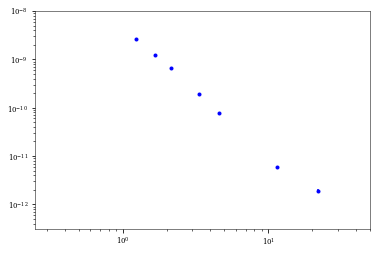

AWI0005yk3
J030651.95+303136.8
-11.5 -7.0


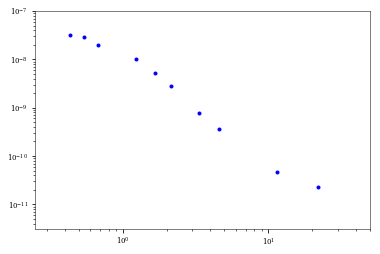

In [18]:
inputdata = get_data('sed_input_data.csv')

#print inputdata[1,:]

columnlabels = inputdata[1,:]

columncount = columnlabels.size

columnlabel_index_dict = {}

for i in range(columncount):
    columnlabel_index_dict[columnlabels[i]] = i

    
#from pprint import pprint
#pprint(columnlabel_index_dict)
    
inputdata_use = inputdata[5:,:]

#print inputdata_use.shape

num_subjs = inputdata_use[:,0].size

raw_subjs = []

for i in range(num_subjs):
    raw_subjs.append(FullSubject(inputdata_use[i,:]))
    
print "Subjects read in"

#has_tycho_subjs = [i for i in range(num_subjs) if raw_subjs[i].has_tycho]

#print has_tycho_subjs

#print columnlabels
#print raw_subjs[180].sourcevec

#print raw_subjs[180].sourcevec[columnlabel_index_dict[' P_gMeanPSFMag']]

#print raw_subjs[180].filts
#print raw_subjs[180].mags
#print raw_subjs[180].magerrs
#print raw_subjs[180].fluxes
#print raw_subjs[180].fluxerrs
#print raw_subjs[180].centwavs_microns
print raw_subjs[40].zooniverse_id
print raw_subjs[40].wiseid
#print raw_subjs[40].has_tycho

#if raw_subjs[40].has_tycho:
#    plt.errorbar(raw_subjs[40].hastyc_mag_fitting_centwavs_microns, raw_subjs[40].hastyc_mag_fitting_nuFnu, yerr=raw_subjs[40].hastyc_mag_fitting_nuFnu_errs, fmt='b.')
#else:
plt.errorbar(raw_subjs[40].centwavs_microns, raw_subjs[40].nuFnu, yerr=raw_subjs[40].nuFnuerrs, fmt='b.')
    
min_nuFnu_logs = min(np.log10(raw_subjs[40].nuFnu))
max_nuFnu_logs = max(np.log10(raw_subjs[40].nuFnu))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

print ymin, ymax

plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

print raw_subjs[30].zooniverse_id
print raw_subjs[30].wiseid
#print raw_subjs[30].has_tycho

#if raw_subjs[30].has_tycho:
#    plt.errorbar(raw_subjs[30].hastyc_mag_fitting_centwavs_microns, raw_subjs[30].hastyc_mag_fitting_nuFnu, yerr=raw_subjs[30].hastyc_mag_fitting_nuFnu_errs, fmt='b.')
#else:
plt.errorbar(raw_subjs[30].centwavs_microns_nops, raw_subjs[30].nuFnu_nops, yerr=raw_subjs[30].nuFnuerrs_nops, fmt='b.')

min_nuFnu_logs = min(np.log10(raw_subjs[30].nuFnu_nops))
max_nuFnu_logs = max(np.log10(raw_subjs[30].nuFnu_nops))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

print ymin, ymax

plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

{3.3500000000000001e-06: 6, 1.1559999999999999e-05: 8, 1.6619999999999999e-06: 4, 2.2079999999999999e-05: 9, 1.235e-06: 3, 2.1589999999999996e-06: 5, 6.7300000000000006e-07: 0, 4.5999999999999992e-06: 7, 5.4479999999999996e-07: 2, 4.3609999999999999e-07: 1}
1516831688.52
AWI00062h7 J002133.47-661816.6
[  3.09734125e-08   2.24987219e-08   4.38169418e-09   2.03464966e-09
   1.01976127e-09   3.16311886e-10   1.24352112e-10   9.30177395e-12
   2.17762819e-12]
[  5.42023776e-10   2.07220886e-10   1.08963616e-10   8.80771347e-11
   2.16024014e-11   7.91134550e-12   2.29065056e-12   1.62777758e-13
   1.32374199e-13]
[ 7.371       7.361       7.365       7.395       7.395       7.35594291
  7.386       7.365       6.793     ]
[ 0.019       0.01        0.027       0.047       0.023       0.02715558
  0.02        0.019       0.066     ]
[  57.14401078  108.57362048   40.21245203   23.10077031   47.20592195
   39.98205941   54.28681024   57.14401078   16.45054856]
11796.11874 2.11818581557e-10
Fi

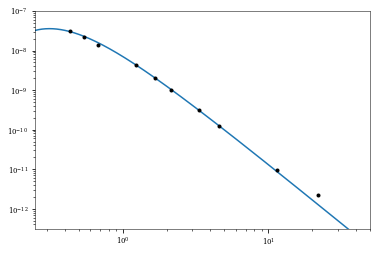

1516831693.58 1 5.06299996376
AWI0000nfp J002155.14-672715.9
[  5.50286751e-10   9.92105477e-10   9.64810591e-10   7.38736641e-10
   4.07848168e-10   1.38449909e-10   5.43817485e-11   1.09588702e-11
   2.47277004e-12]
[  8.61615807e-12   5.48257748e-11   2.04383381e-11   3.19788748e-11
   7.88848294e-12   2.80537573e-12   1.00174883e-12   1.71589371e-13
   1.48037849e-13]
[ 11.747  10.75    9.008   8.495   8.39    8.253   8.284   7.187   6.655]
[ 0.017  0.06   0.023  0.047  0.021  0.022  0.02   0.017  0.065]
[ 63.86683557  18.09560341  47.20592195  23.10077031  51.70172404
  49.35164567  54.28681024  63.86683557  16.70363392]
15792.427522 2.00386888538e-11
Fit W1 flux: 3.81719703118e-12
Observed W1 flux: 1.38449908846e-10
Observed W1 uncertainty: 2.80537572688e-12
Difference (Observed - Fit): 1.34632711815e-10
Significance: 47.9909733749
 
Fit K flux: 1.31723715532e-11
Observed K flux: 4.07848167873e-10
Observed K uncertainty: 7.88848293702e-12
Difference (Observed - Fit): 3.9467579632

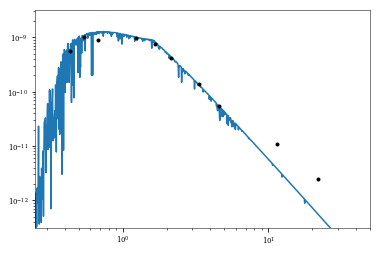

1516831710.97 2 11.2274999619
AWI0000bs0 J003140.76-014737.3
[  3.79654941e-08   2.94142546e-08   6.61975723e-09   3.23660455e-09
   1.62966567e-09   5.08081728e-10   1.95457872e-10   1.60311907e-11
   5.27695913e-12]
[  3.49675123e-10   2.70915297e-10   1.15843413e-10   7.15445509e-11
   3.15205285e-11   1.55679853e-11   3.42044371e-12   2.51009629e-13
   2.38152690e-13]
[ 7.15        7.07        6.917       6.891       6.886       6.84139774
  6.895       6.774       5.832     ]
[ 0.01        0.01        0.019       0.024       0.021       0.03326773
  0.019       0.017       0.049     ]
[ 108.57362048  108.57362048   57.14401078   45.23900853   51.70172404
   32.63631866   57.14401078   63.86683557   22.15788173]
10277.6500952 2.92677748315e-10
Fit W1 flux: 4.90597060846e-10
Observed W1 flux: 5.08081728429e-10
Observed W1 uncertainty: 1.55679852778e-11
Difference (Observed - Fit): 1.74846675833e-11
Significance: 1.12311691406
 
Fit K flux: 1.61665720808e-09
Observed K flux: 1.629665

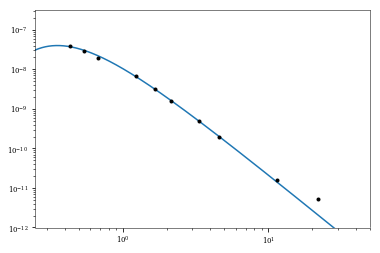

1516831715.63 3 9.03733332952
AWI0005mry J003412.66+540359.0
[  2.30244390e-08   1.81366824e-08   4.44264961e-09   2.20846052e-09
   1.08467222e-09   3.19255695e-10   1.27365899e-10   9.61536514e-12
   2.00809258e-12]
[  4.02919547e-10   1.67045018e-10   7.77447987e-11   8.13626924e-11
   2.09794206e-11   1.44919114e-11   4.45771648e-12   2.30258043e-13
   1.23917948e-13]
[ 7.693       7.595       7.35        7.306       7.328       7.34588505
  7.36        7.329       6.881     ]
[ 0.019       0.01        0.019       0.04        0.021       0.04928461
  0.038       0.026       0.067     ]
[  57.14401078  108.57362048   57.14401078   27.14340512   51.70172404
   22.02992312   28.57200539   41.7590848    16.20501798]
9605.3171129 2.52302689796e-10
Fit W1 flux: 3.35427881881e-10
Observed W1 flux: 3.19255694823e-10
Observed W1 uncertainty: 1.44919114344e-11
Difference (Observed - Fit): -1.61721870582e-11
Significance: -1.11594575577
 
Fit K flux: 1.0948399764e-09
Observed K flux: 1.084672

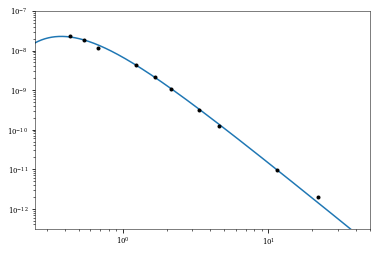

1516831718.74 4 7.55524998903
AWI0000jvv J003507.14+070625.0
[  3.75690504e-10   2.14211145e-09   2.41262398e-09   1.50972733e-09
   4.65193445e-10   1.68986950e-10   3.76847624e-11   1.21894393e-11]
[  7.74645322e-12   3.74861936e-11   6.88853729e-11   2.78102051e-11
   1.42476790e-11   3.26849738e-12   5.20634233e-13   3.92941099e-13]
[ 11.32634704   8.142        7.21         6.969        6.93714772   7.053
   5.846        4.923     ]
[ 0.02238706  0.019       0.031       0.02        0.03325331  0.021       0.015
  0.035     ]
[ 48.49838926  57.14401078  35.02374854  54.28681024  32.65047209
  51.70172404  72.38241365  31.02103442]
2548.9154545 1.00439038349e-09
Fit W1 flux: 6.82354074658e-10
Observed W1 flux: 4.65193444629e-10
Observed W1 uncertainty: 1.42476789722e-11
Difference (Observed - Fit): -2.17160630028e-10
Significance: -15.2418250336
 
Fit K flux: 1.37225158575e-09
Observed K flux: 1.50972732561e-09
Observed K uncertainty: 2.78102050755e-11
Difference (Observed - Fit): 1.

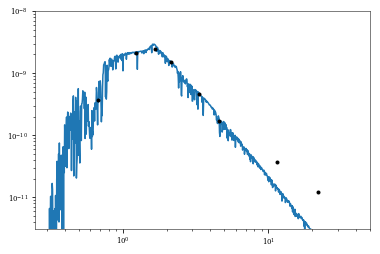

1516831734.66 5 9.22760000229
AWI00062m4 J004826.42+020753.0
[  7.01760721e-10   1.55223634e-09   1.55468376e-09   1.20917634e-09
   6.90078530e-10   2.33268857e-10   8.69066815e-11   1.18950366e-11
   7.91377559e-12]
[  6.01101325e-11   6.57644752e-11   3.72298332e-11   3.67518546e-11
   1.46184737e-11   5.17827476e-12   1.68092425e-12   2.08158937e-13
   3.13420837e-13]
[ 11.483       10.264        8.49         7.96         7.819        7.68658978
   7.775        7.098        5.392     ]
[ 0.093       0.046       0.026       0.033       0.023       0.02410198
  0.021       0.019       0.043     ]
[ 11.67458285  23.60296097  41.7590848   32.90109711  47.20592195
  45.04760127  51.70172404  57.14401078  25.24967918]
4360.14822088 3.76269699262e-10
Fit W1 flux: 2.50689142981e-10
Observed W1 flux: 2.33268856887e-10
Observed W1 uncertainty: 5.17827476473e-12
Difference (Observed - Fit): -1.74202860935e-11
Significance: -3.36411003375
 
Fit K flux: 6.75238724644e-10
Observed K flux: 6.9007

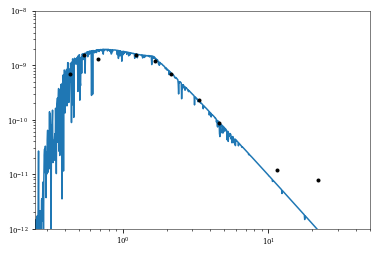

1516831748.54 6 10.0025000175
AWI0005yiv J005926.26+400918.2
[  2.29397698e-08   1.92201976e-08   5.24375102e-09   2.41262398e-09
   1.24079066e-09   3.86417073e-10   1.50887467e-10   1.11215618e-11
   2.48189687e-12]
[  4.22566177e-10   1.77024561e-10   8.69341170e-11   1.04439114e-10
   2.39990191e-11   1.11075405e-11   2.77944985e-12   1.63893392e-13
   1.23439220e-13]
[ 7.697       7.532       7.17        7.21        7.182       7.13859092
  7.176       7.171       6.651     ]
[ 0.02        0.01        0.018       0.047       0.021       0.03120944
  0.02        0.016       0.054     ]
[  54.28681024  108.57362048   60.31867804   23.10077031   51.70172404
   34.78871598   54.28681024   67.8585128    20.10622601]
8999.75021973 2.8588154379e-10
Fit W1 flux: 3.97019435419e-10
Observed W1 flux: 3.86417072663e-10
Observed W1 uncertainty: 1.11075405294e-11
Difference (Observed - Fit): -1.06023627556e-11
Significance: -0.95451938506
 
Fit K flux: 1.28309671656e-09
Observed K flux: 1.24079

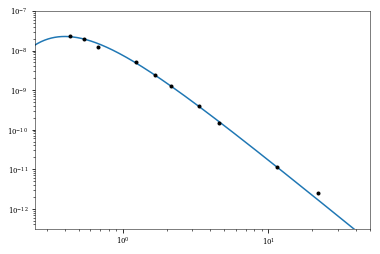

1516831752.97 7 9.20757143838
AWI00055sx J010652.55+743754.5
[  1.13080848e-08   8.89934098e-09   2.09142388e-09   9.90124120e-10
   5.00839434e-10   1.52367617e-10   6.00140819e-11   4.77052066e-12
   1.58337481e-12]
[  2.18717751e-10   9.83591514e-11   5.58619048e-11   2.18865124e-11
   1.52225755e-11   3.22772250e-12   1.10550024e-12   9.22700500e-14
   1.26875762e-13]
[ 8.465  8.368  8.168  8.177  8.167  8.149  8.177  8.09   7.139]
[ 0.021  0.012  0.029  0.024  0.033  0.023  0.02   0.021  0.087]
[ 51.70172404  90.47801706  37.43917947  45.23900853  32.90109711
  47.20592195  54.28681024  51.70172404  12.47972649]
9984.96426141 1.66742772117e-10
Fit W1 flux: 1.53689766247e-10
Observed W1 flux: 1.52367616589e-10
Observed W1 uncertainty: 3.22772250404e-12
Difference (Observed - Fit): -1.32214965848e-12
Significance: -0.409623087742
 
Fit K flux: 5.04439075089e-10
Observed K flux: 5.00839433587e-10
Observed K uncertainty: 1.52225754616e-11
Difference (Observed - Fit): -3.5996415026e-12

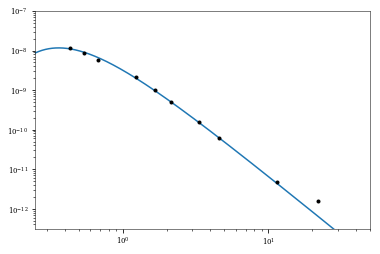

1516831755.89 8 8.421875
AWI00055sz J011636.23+740136.6
[  4.02336151e-08   2.99611064e-08   7.62152823e-09   3.87694500e-09
   2.14238992e-09   6.36169428e-10   2.82181757e-10   2.51284547e-11
   4.70742848e-12]
[  7.04074049e-10   2.75951988e-10   3.93102467e-10   1.21407142e-10
   3.94642807e-11   2.30622459e-11   4.65372795e-12   3.47162431e-13
   1.64756671e-13]
[ 7.087       7.05        6.764       6.695       6.589       6.5972997
  6.49631059  6.286       5.956     ]
[ 0.019       0.01        0.056       0.034       0.02        0.03935982
  0.01790591  0.015       0.038     ]
[  57.14401078  108.57362048   19.38814651   31.93341779   54.28681024
   27.58488619   60.6356366    72.38241365   28.57200539]
9055.52931489 3.57676476971e-10
Fit W1 flux: 6.26314409736e-10
Observed W1 flux: 6.36169427672e-10
Observed W1 uncertainty: 2.30622458734e-11
Difference (Observed - Fit): 9.85501793577e-12
Significance: 0.427322559558
 
Fit K flux: 2.02610751941e-09
Observed K flux: 2.14238991711

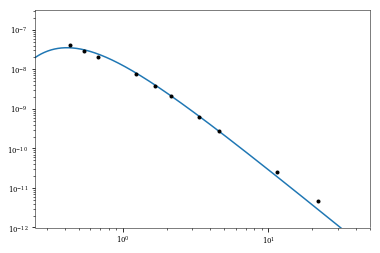

1516831763.97 9 8.38377777735
AWI00062mq J011743.47-523330.8
[  8.46816002e-10   9.95767270e-10   3.83391131e-10   2.48707934e-10
   1.74461064e-10   9.28309242e-11   5.42816658e-11   7.05611713e-11
   1.19559401e-10]
[  6.70753871e-11   4.86081841e-11   8.47479075e-12   5.26857487e-12
   3.37437613e-12   1.88100970e-12   1.04990050e-12   9.74838607e-13
   2.20236556e-12]
[ 11.279  10.746  10.01    9.677   9.312   8.687   8.286   5.165   2.444]
[ 0.086  0.053  0.024  0.023  0.021  0.022  0.021  0.015  0.02 ]
[ 12.62483959  20.48558877  45.23900853  47.20592195  51.70172404
  49.35164567  51.70172404  72.38241365  54.28681024]
5856.15871486 1.3281920339e-10
Fit W1 flux: 4.84328683218e-11
Observed W1 flux: 9.28309241899e-11
Observed W1 uncertainty: 1.88100969944e-12
Difference (Observed - Fit): 4.43980558682e-11
Significance: 23.6033104356
 
Fit K flux: 1.43274720898e-10
Observed K flux: 1.7446106356e-10
Observed K uncertainty: 3.37437613179e-12
Difference (Observed - Fit): 3.1186342662e

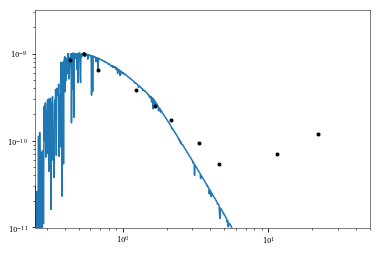

1516831777.88 10 8.9361000061
AWI0005w6c J012650.26+454038.8
[  2.81182998e-08   1.89215996e-08   3.54194703e-09   1.61766891e-09
   8.08534425e-10   2.46582385e-10   9.88674122e-11   9.41381764e-12
   2.55378147e-12]
[  5.43856134e-10   1.91701810e-10   6.52450755e-11   3.87381314e-11
   1.56384422e-11   5.70346115e-12   2.00332554e-12   1.47397590e-13
   1.74056854e-13]
[ 7.476       7.549       7.596       7.644       7.647       7.62632656
  7.635       7.352       6.62      ]
[ 0.021       0.011       0.02        0.026       0.021       0.02511313
  0.022       0.017       0.074     ]
[ 51.70172404  98.70329134  54.28681024  41.7590848   51.70172404
  43.23381518  49.35164567  63.86683557  14.67211088]
12547.9365921 1.81199404087e-10
Fit W1 flux: 2.38997274513e-10
Observed W1 flux: 2.46582385164e-10
Observed W1 uncertainty: 5.70346114856e-12
Difference (Observed - Fit): 7.5851106507e-12
Significance: 1.32991361791
 
Fit K flux: 8.06853532454e-10
Observed K flux: 8.08534425207e-10


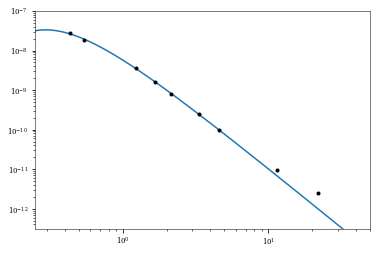

1516831784.52 11 8.72745455395
AWI0004ne5 J013525.89+560237.3
[  4.09438857e-08   3.09141882e-08   7.43433389e-09   3.42365221e-09
   1.70961577e-09   5.21949471e-10   2.07899367e-10   1.61944343e-11
   4.09999881e-12]
[  6.78792823e-10   2.84730196e-10   1.23250942e-10   1.13518808e-10
   3.62161293e-11   1.74491117e-11   4.21261265e-12   2.23734378e-13
   1.81259446e-13]
[ 7.068       7.016       6.791       6.83        6.834       6.81216053
  6.828       6.763       6.106     ]
[ 0.018       0.01        0.018       0.036       0.023       0.03629687
  0.022       0.015       0.048     ]
[  60.31867804  108.57362048   60.31867804   30.15933902   47.20592195
   29.9126672    49.35164567   72.38241365   22.61950427]
10049.7776007 3.09601525877e-10
Fit W1 flux: 5.34087385735e-10
Observed W1 flux: 5.21949470889e-10
Observed W1 uncertainty: 1.74491116877e-11
Difference (Observed - Fit): -1.21379148465e-11
Significance: -0.695617923925
 
Fit K flux: 1.75456050791e-09
Observed K flux: 1.70

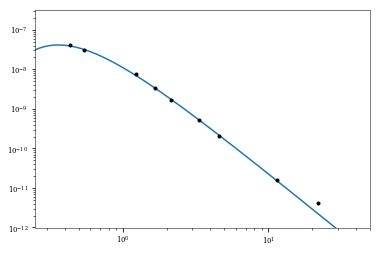

1516831788.21 12 8.30750000477
AWI00062a8 J013756.15+211539.9
[  1.66183942e-08   1.30664571e-08   2.87105864e-09   1.34427970e-09
   6.98390810e-10   2.13255655e-10   8.43049678e-11   7.22047521e-12
   5.63357046e-12]
[  3.36734347e-10   1.44415821e-10   4.75981691e-11   3.59056934e-11
   1.47945593e-11   4.73190352e-12   1.55295490e-12   1.19705462e-13
   1.97170986e-13]
[ 8.047       7.951       7.824       7.845       7.806       7.78398029
  7.808       7.64        5.761     ]
[ 0.022       0.012       0.018       0.029       0.023       0.02409127
  0.02        0.018       0.038     ]
[ 49.35164567  90.47801706  60.31867804  37.43917947  47.20592195
  45.06762537  54.28681024  60.31867804  28.57200539]
10362.3600271 1.91181532756e-10
Fit W1 flux: 2.11443997563e-10
Observed W1 flux: 2.13255654924e-10
Observed W1 uncertainty: 4.73190351595e-12
Difference (Observed - Fit): 1.81165736083e-12
Significance: 0.382860164989
 
Fit K flux: 6.97540278433e-10
Observed K flux: 6.98390809659e-

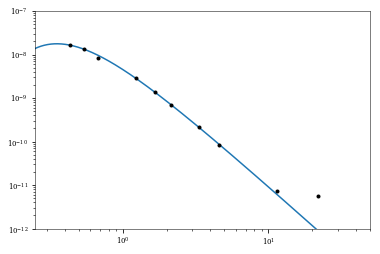

1516831793.84 13 8.10123076806
AWI0005aeg J013833.77+780834.3
[  2.33232494e-09   2.42861038e-09   1.05109522e-09   5.09670668e-10
   2.70955840e-10   1.47127100e-10   7.43794849e-11   9.08167134e-12
   1.87924642e-12]
[  9.45186289e-11   5.81576534e-11   2.90428343e-11   1.50215691e-11
   5.24075057e-12   3.11670853e-12   1.43862678e-12   1.42196983e-13
   1.09043545e-13]
[ 10.179   9.778   8.915   8.898   8.834   8.187   7.944   7.391   6.953]
[ 0.044  0.026  0.03   0.032  0.021  0.023  0.021  0.017  0.063]
[ 24.67582284  41.7590848   36.19120683  33.9292564   51.70172404
  47.20592195  51.70172404  63.86683557  17.23390801]
6896.18066571 1.6211785296e-10
Fit W1 flux: 9.03622068286e-11
Observed W1 flux: 1.47127099798e-10
Observed W1 uncertainty: 3.1167085343e-12
Difference (Observed - Fit): 5.67648929698e-11
Significance: 18.2130899778
 
Fit K flux: 2.77963886835e-10
Observed K flux: 2.70955839862e-10
Observed K uncertainty: 5.2407505729e-12
Difference (Observed - Fit): -7.0080469727

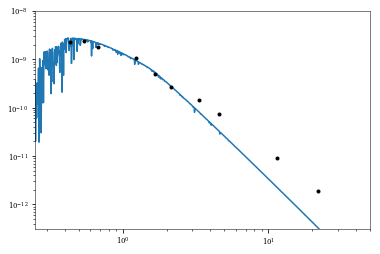

1516831801.51 14 8.07057142258
AWI00062aa J014113.00+163051.7
[  8.15434452e-09   7.85159423e-09   2.69179550e-09   1.42590188e-09
   7.29959081e-10   2.28570309e-10   9.02512377e-11   7.78692122e-12
   3.50254506e-12]
[  2.17802437e-10   1.08473783e-10   5.20639408e-11   2.75793874e-11
   1.41186603e-11   5.07346160e-12   1.66248924e-12   1.21924331e-13
   1.77427977e-13]
[ 8.82        8.504       7.894       7.781       7.758       7.70868215
  7.734       7.558       6.277     ]
[ 0.029       0.015       0.021       0.021       0.021       0.02409955
  0.02        0.017       0.055     ]
[ 37.43917947  72.38241365  51.70172404  51.70172404  51.70172404
  45.05214126  54.28681024  63.86683557  19.74065827]
7478.22127989 2.49265531772e-10
Fit W1 flux: 2.37907833438e-10
Observed W1 flux: 2.28570308905e-10
Observed W1 uncertainty: 5.07346160499e-12
Difference (Observed - Fit): -9.33752453235e-12
Significance: -1.84046421543
 
Fit K flux: 7.44158223418e-10
Observed K flux: 7.29959080957e

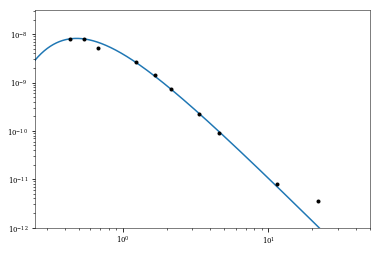

1516831806.38 15 7.85760000547
AWI0005zx4 J014928.21+244048.7
[  1.17216583e-08   9.39632105e-09   2.41235969e-09   1.18710638e-09
   6.27622516e-10   1.90690901e-10   7.63929299e-11   6.24835623e-12
   1.44405499e-12]
[  2.69901156e-10   1.21160641e-10   4.22154423e-11   2.95208654e-11
   1.04051106e-11   4.22887079e-12   1.33684928e-12   1.15098975e-13
   1.39652498e-13]
[ 8.426       8.309       8.013       7.98        7.922       7.90540676
  7.915       7.797       7.239     ]
[ 0.025       0.014       0.019       0.027       0.018       0.02407791
  0.019       0.02        0.105     ]
[ 43.42944819  77.55258605  57.14401078  40.21245203  60.31867804
  45.09262884  57.14401078  54.28681024  10.34034481]
9119.50643565 1.96747707454e-10
Fit W1 flux: 1.91191116133e-10
Observed W1 flux: 1.90690900854e-10
Observed W1 uncertainty: 4.22887078798e-12
Difference (Observed - Fit): -5.00215278665e-13
Significance: -0.118285779761
 
Fit K flux: 6.19177929122e-10
Observed K flux: 6.27622516262

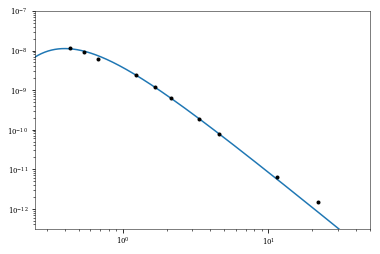

1516831807.96 16 7.46512499452
AWI00008jh J015317.94-461421.9
[  5.32339946e-11   1.76261656e-10   1.74117355e-09   1.89186281e-09
   1.27203340e-09   4.21617337e-10   1.68675951e-10   1.77241649e-11
   3.38207887e-12]
[  2.45151605e-12   8.92886418e-12   4.32993629e-11   5.40165713e-11
   2.81180654e-11   1.32979218e-11   3.10712584e-12   2.77517505e-13
   1.86900585e-13]
[ 14.283       12.626        8.367        7.474        7.155        7.04393553
   7.055        6.665        6.315     ]
[ 0.05        0.055       0.027       0.031       0.024       0.03424441
  0.02        0.017       0.06      ]
[ 21.7147241   19.74065827  40.21245203  35.02374854  45.23900853
  31.70550593  54.28681024  63.86683557  18.09560341]
0.0 inf
Fit W1 flux: nan
Observed W1 flux: 4.21617337009e-10
Observed W1 uncertainty: 1.32979217542e-11
Difference (Observed - Fit): nan
Significance: nan
 
Fit K flux: nan
Observed K flux: 1.27203340267e-09
Observed K uncertainty: 2.81180654475e-11
Difference (Observed - 

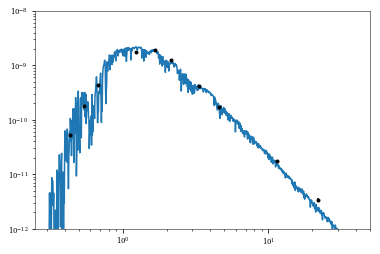

1516831824.87 17 8.02058822968
AWI00062aj J020221.16+192323.6
[  1.07297365e-08   8.64087748e-09   2.24720174e-09   1.11196122e-09
   5.78760010e-10   1.72700134e-10   6.77724470e-11   5.45714862e-12
   1.68571337e-12]
[  2.56943765e-10   1.11419592e-10   4.96739830e-11   2.35555450e-11
   9.59503804e-12   3.65844213e-12   1.24841461e-12   9.54981728e-14
   1.49049541e-13]
[ 8.522  8.4    8.09   8.051  8.01   8.013  8.045  7.944  7.071]
[ 0.026  0.014  0.024  0.023  0.018  0.023  0.02   0.019  0.096]
[ 41.7590848   77.55258605  45.23900853  47.20592195  60.31867804
  47.20592195  54.28681024  57.14401078  11.30975213]
9061.77805055 1.90427103815e-10
Fit W1 flux: 1.7768278749e-10
Observed W1 flux: 1.72700133843e-10
Observed W1 uncertainty: 3.65844213446e-12
Difference (Observed - Fit): -4.9826536462e-12
Significance: -1.36196049112
 
Fit K flux: 5.74860435848e-10
Observed K flux: 5.78760010328e-10
Observed K uncertainty: 9.59503803985e-12
Difference (Observed - Fit): 3.8995744795e-12
Si

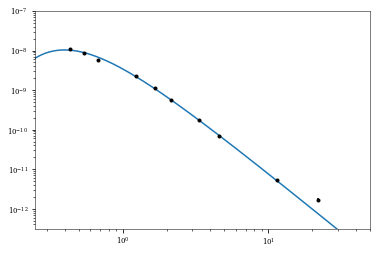

1516831830.46 18 7.88550000721
AWI0000qox J020359.52+141132.3
[  6.55186653e-10   2.41680751e-09   2.62355178e-09   1.66455640e-09
   5.35202574e-10   2.05424939e-10   2.43089265e-11   5.34544334e-12]
[  2.17175209e-11   5.11971256e-11   6.28258927e-11   2.75960359e-11
   1.83914416e-11   3.59486386e-12   3.13450883e-13   2.06780081e-13]
[ 10.72250998   8.011        7.119        6.863        6.7849362    6.841
   6.322        5.818     ]
[ 0.03598898  0.023       0.026       0.018       0.03730971  0.019       0.014
  0.042     ]
[ 30.1685748   47.20592195  41.7590848   60.31867804  29.100632
  57.14401078  77.55258605  25.85086202]
2764.41587151 9.65461473746e-10
Fit W1 flux: 7.42721558933e-10
Observed W1 flux: 5.35202574012e-10
Observed W1 uncertainty: 1.83914416021e-11
Difference (Observed - Fit): -2.0751898492e-10
Significance: -11.2834539787
 
Fit K flux: 1.58284435482e-09
Observed K flux: 1.66455640314e-09
Observed K uncertainty: 2.75960358744e-11
Difference (Observed - Fit): 8.1

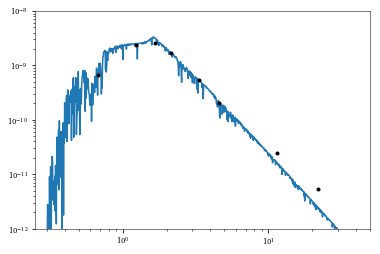

1516831847.14 19 8.34831579108
AWI0005w6v J021327.01+421923.3
[  4.67938799e-09   4.47669851e-09   1.28009459e-09   6.50563420e-10
   3.27264212e-10   1.02445450e-10   4.05744991e-11   3.53969450e-12
   1.81294125e-12]
[  1.37916020e-10   7.42174506e-11   2.12221924e-11   1.43805853e-11
   5.12416513e-12   2.26453791e-12   7.84780388e-13   8.80248362e-14
   1.80336305e-13]
[ 9.423  9.114  8.701  8.633  8.629  8.58   8.602  8.414  6.992]
[ 0.032  0.018  0.018  0.024  0.017  0.024  0.021  0.027  0.108]
[ 33.9292564   60.31867804  60.31867804  45.23900853  63.86683557
  45.23900853  51.70172404  40.21245203  10.05311301]
8341.04779231 1.54177745337e-10
Fit W1 flux: 1.04861410041e-10
Observed W1 flux: 1.02445449926e-10
Observed W1 uncertainty: 2.26453791211e-12
Difference (Observed - Fit): -2.4159601154e-12
Significance: -1.06686671152
 
Fit K flux: 3.34664514598e-10
Observed K flux: 3.27264212088e-10
Observed K uncertainty: 5.12416513433e-12
Difference (Observed - Fit): -7.4003025095e-12


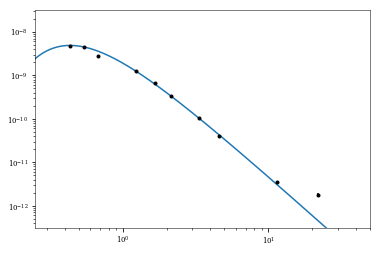

1516831852.73 20 8.21060000658
AWI0005yjn J022317.32+381509.7
[  3.90291467e-08   2.75776876e-08   5.92709738e-09   2.67725439e-09
   1.39861608e-09   4.18888443e-10   1.77931634e-10   1.53803345e-11
   3.41337286e-12]
[  2.51630208e-10   2.28599900e-10   9.82630517e-11   6.65777454e-11
   2.06107682e-11   1.24342864e-11   3.44150291e-12   2.26652985e-13
   1.76054625e-13]
[ 7.12        7.14        7.037       7.097       7.052       7.05098574
  6.997       6.819       6.305     ]
[ 0.007     0.009     0.018     0.027     0.016     0.032229  0.021     0.016
  0.056   ]
[ 155.10517211  120.63735608   60.31867804   40.21245203   67.8585128
   33.68817707   51.70172404   67.8585128    19.38814651]
11412.3271924 2.50063166064e-10
Fit W1 flux: 4.06577200649e-10
Observed W1 flux: 4.18888442951e-10
Observed W1 uncertainty: 1.24342864302e-11
Difference (Observed - Fit): 1.23112423016e-11
Significance: 0.990104447948
 
Fit K flux: 1.35783203694e-09
Observed K flux: 1.39861607571e-09
Observed K

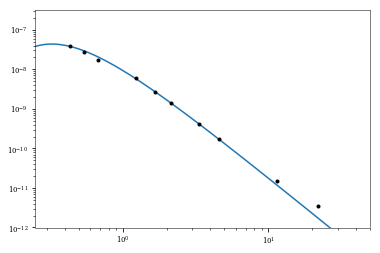

1516831860.8 21 8.20357143311
AWI0005yjp J022515.75+370707.9
[  3.23734554e-08   2.30227844e-08   4.47962915e-09   2.02716752e-09
   1.03394757e-09   3.02556852e-10   1.18755345e-10   9.97621457e-12
   3.40395438e-12]
[  5.96341086e-10   2.33252449e-10   7.42660366e-11   3.17405349e-11
   1.52368144e-11   7.56565406e-12   2.18755430e-12   1.83768664e-13
   1.88109471e-13]
[ 7.323      7.336      7.341      7.399      7.38       7.4042142  7.436
  7.289      6.308    ]
[ 0.02        0.011       0.018       0.017       0.016       0.02714962
  0.02        0.02        0.06      ]
[ 54.28681024  98.70329134  60.31867804  63.86683557  67.8585128
  39.9908388   54.28681024  54.28681024  18.09560341]
11961.6556013 2.11145464507e-10
Fit W1 flux: 3.06624291569e-10
Observed W1 flux: 3.0255685202e-10
Observed W1 uncertainty: 7.56565406304e-12
Difference (Observed - Fit): -4.06743954895e-12
Significance: -0.537619023427
 
Fit K flux: 1.02967728255e-09
Observed K flux: 1.03394756727e-09
Observed K 

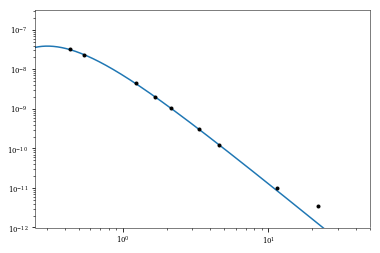

1516831862.31 22 7.8995909149
AWI0005yjq J023047.36+360701.7
[  1.77905370e-08   1.49058878e-08   3.85515694e-09   1.86934577e-09
   9.26613271e-10   2.89402790e-10   1.14565318e-10   8.68891965e-12
   3.81578354e-12]
[  3.60485182e-10   1.51017130e-10   9.23189998e-11   4.64867393e-11
   1.96291743e-11   7.23513812e-12   2.00485260e-12   1.36047443e-13
   2.00324592e-13]
[ 7.973      7.808      7.504      7.487      7.499      7.4524749  7.475
  7.439      6.184    ]
[ 0.022       0.011       0.026       0.027       0.023       0.02714366
  0.019       0.017       0.057     ]
[ 49.35164567  98.70329134  41.7590848   40.21245203  47.20592195
  39.99962204  57.14401078  63.86683557  19.04800359]
9233.42563619 2.41434070916e-10
Fit W1 flux: 2.92413069179e-10
Observed W1 flux: 2.89402790127e-10
Observed W1 uncertainty: 7.23513811815e-12
Difference (Observed - Fit): -3.01027905202e-12
Significance: -0.41606379904
 
Fit K flux: 9.48805964508e-10
Observed K flux: 9.26613270618e-10
Observed K

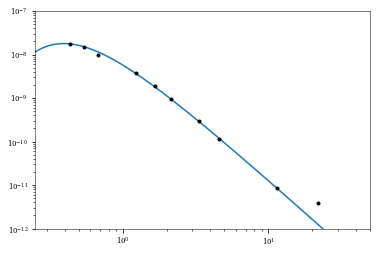

1516831865.78 23 7.70695652132
AWI0000b9g J023115.97-094845.9
[  1.03333939e-12   3.42327716e-12   3.12240792e-12   1.84034191e-12
   1.02918317e-12   4.54415531e-13   7.27387412e-13   2.16762290e-12]
[  1.46094328e-14   1.79718423e-13   2.12812454e-13   1.33906385e-13
   2.36978182e-14   1.33930295e-14   3.34974283e-14   1.15794359e-13]
[ 17.72781512  15.133       14.43        14.254       13.575       13.479
  10.132        6.798     ]
[ 0.01535022  0.057       0.074       0.079       0.025       0.032       0.05
  0.058     ]
[ 70.73097275  19.04800359  14.67211088  13.74349626  43.42944819
  33.9292564   21.7147241   18.71958974]
2767.91541441 3.58218995823e-11
Fit W1 flux: 1.02502749609e-12
Observed W1 flux: 1.02918316638e-12
Observed W1 uncertainty: 2.36978181686e-14
Difference (Observed - Fit): 4.15567028308e-15
Significance: 0.175360881475
 
Fit K flux: 2.18635133422e-12
Observed K flux: 1.84034190713e-12
Observed K uncertainty: 1.33906385387e-13
Difference (Observed - Fit): -3

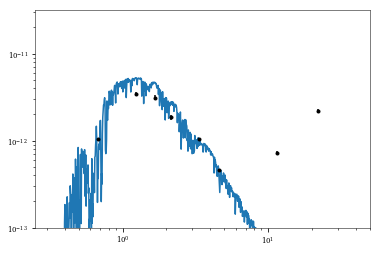

1516831878.89 24 7.93212500215
AWI0005w77 J023720.84+395345.8
[  7.51257908e-08   4.87256731e-08   8.24217938e-09   3.57840622e-09
   1.74782729e-09   5.08553706e-10   2.01675511e-10   1.88871218e-11
   5.64915812e-12]
[  1.24548139e-09   4.48780034e-10   1.74600538e-10   5.93250107e-11
   2.57569348e-11   1.74713082e-11   3.71500021e-12   2.78330913e-13
   2.18528810e-13]
[ 6.409       6.522       6.679       6.782       6.81        6.84038963
  6.861       6.596       5.758     ]
[ 0.018       0.01        0.023       0.018       0.016       0.03730035
  0.02        0.016       0.042     ]
[  60.31867804  108.57362048   47.20592195   60.31867804   67.8585128
   29.10793518   54.28681024   67.8585128    25.85086202]
14744.874174 2.41574080498e-10
Fit W1 flux: 5.12751105249e-10
Observed W1 flux: 5.08553705719e-10
Observed W1 uncertainty: 1.74713081725e-11
Difference (Observed - Fit): -4.19739953049e-12
Significance: -0.240245291826
 
Fit K flux: 1.75887753126e-09
Observed K flux: 1.7478

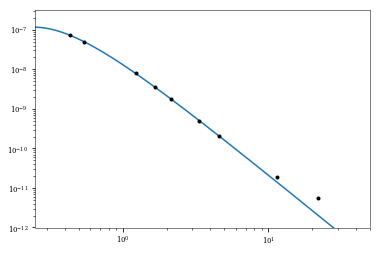

1516831880.55 25 7.68107999802
AWI0005zfw J024430.00+280053.8
[  1.59143555e-08   1.34078100e-08   3.59452958e-09   1.71589078e-09
   9.00530685e-10   2.71745426e-10   1.05451598e-10   8.32848065e-12
   1.99518757e-12]
[  3.66441578e-10   1.60537642e-10   6.29029978e-11   3.63490576e-11
   2.40531630e-11   6.28850557e-12   1.84536572e-12   1.45745469e-13
   1.63549574e-13]
[ 8.094       7.923       7.58        7.58        7.53        7.52082608
  7.565       7.485       6.888     ]
[ 0.025      0.013      0.019      0.023      0.029      0.0251252  0.019
  0.019      0.089    ]
[ 43.42944819  83.5181696   57.14401078  47.20592195  37.43917947
  43.2130373   57.14401078  57.14401078  12.1992832 ]
8936.03125919 2.41389015598e-10
Fit W1 flux: 2.8053760532e-10
Observed W1 flux: 2.71745425589e-10
Observed W1 uncertainty: 6.28850556616e-12
Difference (Observed - Fit): -8.79217973126e-12
Significance: -1.39813500024
 
Fit K flux: 9.05626529024e-10
Observed K flux: 9.00530685017e-10
Observed K

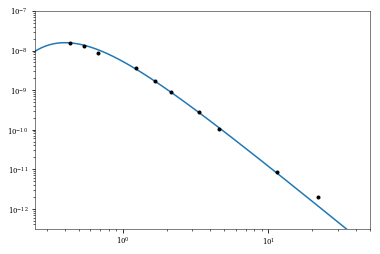

1516831883.48 26 7.49865384285
AWI000425z J024755.37+553648.4
[  4.22463367e-08   3.38343507e-08   8.67844794e-09   4.08215640e-09
   2.08016850e-09   6.40917865e-10   2.55305371e-10   1.86967354e-11
   4.23432053e-12]
[  7.78206282e-10   3.11625887e-10   1.59862919e-10   1.09034345e-10
   4.59817438e-11   2.38310074e-11   4.53518833e-12   2.58304945e-13
   1.94997667e-13]
[ 7.034       6.918       6.623       6.639       6.621       6.58922574
  6.60498304  6.607       6.071     ]
[ 0.02        0.01        0.02        0.029       0.024       0.04037052
  0.01928678  0.015       0.05      ]
[  54.28681024  108.57362048   54.28681024   37.43917947   45.23900853
   26.89428337   56.29432608   72.38241365   21.7147241 ]
9386.6826683 3.56330118471e-10
Fit W1 flux: 6.50173806049e-10
Observed W1 flux: 6.40917864754e-10
Observed W1 uncertainty: 2.38310073515e-11
Difference (Observed - Fit): -9.25594129488e-12
Significance: -0.388399078492
 
Fit K flux: 2.11493085096e-09
Observed K flux: 2.080

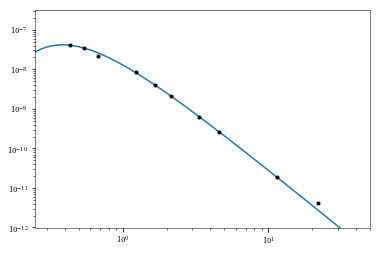

1516831885.3 27 7.28807407838
AWI0000c52 J025149.66-244328.9
[  1.02846391e-09   1.83551462e-09   2.03255386e-09   1.51108759e-09
   8.45081347e-10   2.77336326e-10   1.00612784e-10   9.83933577e-12
   3.14183758e-12]
[  2.36812567e-11   1.03124858e-10   5.42894873e-11   5.56705243e-11
   2.02370658e-11   7.18875557e-12   1.85335597e-12   1.44997810e-13
   1.36005750e-13]
[ 11.068       10.082        8.199        7.718        7.599        7.49871479
   7.616        7.304        6.395     ]
[ 0.025       0.061       0.029       0.04        0.026       0.02814306
  0.02        0.016       0.047     ]
[ 43.42944819  17.79895418  37.43917947  27.14340512  41.7590848
  38.57918426  54.28681024  67.8585128   23.10077031]
0.0 inf
Fit W1 flux: nan
Observed W1 flux: 2.77336325916e-10
Observed W1 uncertainty: 7.18875557491e-12
Difference (Observed - Fit): nan
Significance: nan
 
Fit K flux: nan
Observed K flux: 8.45081346695e-10
Observed K uncertainty: 2.02370657972e-11
Difference (Observed - Fi

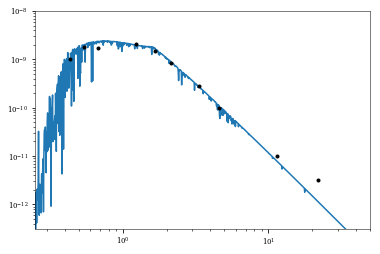

1516831902.22 28 7.63221428224
AWI0000phh J025614.05+040254.2
[  2.20693253e-08   1.63741154e-08   3.32691774e-09   1.54343960e-09
   7.73568035e-10   2.40721905e-10   9.45917296e-11   7.70133085e-12
   2.41425829e-12]
[  5.08164995e-10   2.11135647e-10   9.80545432e-11   5.40192956e-11
   1.63870973e-11   5.56724506e-12   1.91668846e-12   1.41863757e-13
   1.73441896e-13]
[ 7.739       7.706       7.664       7.695       7.695       7.65244266
  7.683       7.57        6.681     ]
[ 0.025       0.014       0.032       0.038       0.023       0.02511014
  0.022       0.02        0.078     ]
[ 43.42944819  77.55258605  33.9292564   28.57200539  47.20592195
  43.23896326  49.35164567  54.28681024  13.91969493]
11356.9878069 1.89669744329e-10
Fit W1 flux: 2.32544170216e-10
Observed W1 flux: 2.40721904694e-10
Observed W1 uncertainty: 5.56724506177e-12
Difference (Observed - Fit): 8.17773447758e-12
Significance: 1.46890147404
 
Fit K flux: 7.76164656081e-10
Observed K flux: 7.7356803496e-10

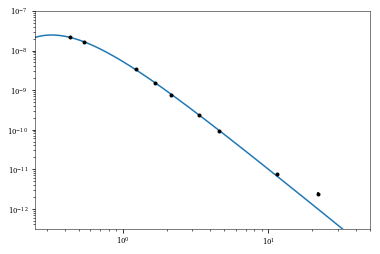

1516831903.77 29 7.42237931284
AWI0000xbv J025926.83+593531.6
[  1.88533729e-08   1.67709571e-08   5.48582643e-09   2.82936932e-09
   1.47264652e-09   4.54524608e-10   1.79412694e-10   1.37964001e-11
   2.94024643e-12]
[  1.73645981e-10   1.54466223e-10   1.06105290e-10   5.99367453e-11
   3.25525817e-11   1.56065229e-11   3.30490395e-12   2.03311266e-13
   1.65192089e-13]
[ 7.91        7.68        7.121       7.037       6.996       6.96233818
  6.988       6.937       6.467     ]
[ 0.01        0.01        0.021       0.023       0.024       0.03727976
  0.02        0.016       0.061     ]
[ 108.57362048  108.57362048   51.70172404   47.20592195   45.23900853
   29.12401507   54.28681024   67.8585128    17.79895418]
7939.34163481 3.32638750709e-10
Fit W1 flux: 4.58067134628e-10
Observed W1 flux: 4.54524608224e-10
Observed W1 uncertainty: 1.5606522902e-11
Difference (Observed - Fit): -3.54252640403e-12
Significance: -0.226990113446
 
Fit K flux: 1.44914732807e-09
Observed K flux: 1.472

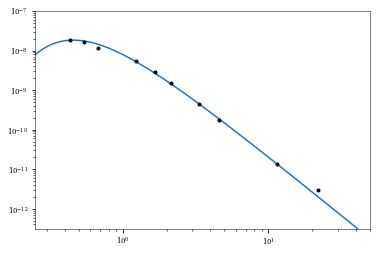

1516831908.89 30 7.34580000242
AWI0005yk3 J030651.95+303136.8
[  3.16074207e-08   2.96590917e-08   9.99176158e-09   5.21062286e-09
   2.80607010e-09   7.89366159e-10   3.54296095e-10   4.59796627e-11
   2.24689993e-11]
[  6.40453225e-10   3.00487363e-10   1.84055050e-10   1.00782381e-10
   6.97811239e-11   2.64426027e-11   6.43197100e-12   6.77581350e-13
   6.00146681e-13]
[ 7.349       7.061       6.47        6.374       6.296       6.36303543
  6.249217    5.63        4.259     ]
[ 0.022       0.011       0.02        0.021       0.027       0.03637056
  0.0197107   0.016       0.029     ]
[ 49.35164567  98.70329134  54.28681024  51.70172404  40.21245203
  29.85205983  55.08359647  67.8585128   37.43917947]
7546.87509146 4.77098330235e-10
Fit W1 flux: 8.82086015362e-10
Observed W1 flux: 7.89366159171e-10
Observed W1 uncertainty: 2.64426027453e-11
Difference (Observed - Fit): -9.27198561914e-11
Significance: -3.50645725327
 
Fit K flux: 2.76402973719e-09
Observed K flux: 2.80607009702e

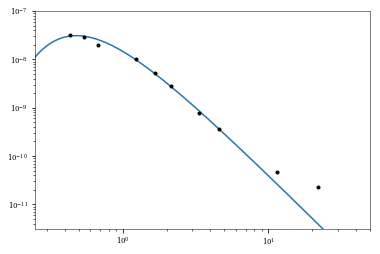

1516831910.58 31 7.16329032375
AWI00062ic J030854.20-185809.1
[  3.52037604e-08   2.64336933e-08   7.83505523e-09   4.48424818e-09
   2.57334797e-09   8.37810470e-10   3.43607431e-10   3.03784619e-11
   5.68569725e-12]
[  6.16053370e-10   2.43463313e-10   1.65976109e-10   1.36294792e-10
   4.26625393e-11   3.66516366e-11   5.99395944e-12   4.19693961e-13
   1.78048503e-13]
[ 7.232       7.186       6.734       6.537       6.39        6.29836723
  6.28247655  6.08        5.751     ]
[ 0.019       0.01        0.023       0.033       0.018       0.04749763
  0.01893981  0.015       0.034     ]
[  57.14401078  108.57362048   47.20592195   32.90109711   60.31867804
   22.85874648   57.32561834   72.38241365   31.93341779]
7911.50705571 4.21488631198e-10
Fit W1 flux: 7.3211530433e-10
Observed W1 flux: 8.37810469714e-10
Observed W1 uncertainty: 3.66516366293e-11
Difference (Observed - Fit): 1.05695165384e-10
Significance: 2.88377750913
 
Fit K flux: 2.31463879712e-09
Observed K flux: 2.573347

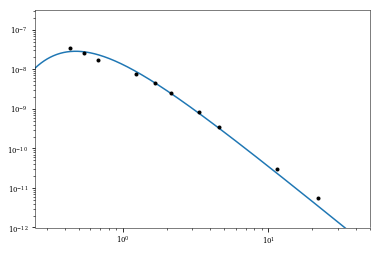

1516831920.22 32 7.24074999988
AWI00055vo J031738.10+731810.2
[  1.16356073e-09   1.57238122e-09   1.22023102e-09   6.78093592e-10
   3.91289790e-10   1.26035438e-10   4.95054676e-11   4.67052586e-12
   2.31197818e-12]
[  6.00140262e-11   4.77911485e-11   2.24774861e-11   1.81118711e-11
   7.56821551e-12   2.66990735e-12   9.57520634e-13   9.46376924e-14
   1.78870490e-13]
[ 10.934  10.25    8.753   8.588   8.435   8.355   8.386   8.113   6.728]
[ 0.056  0.033  0.02   0.029  0.021  0.023  0.021  0.022  0.084]
[ 19.38814651  32.90109711  54.28681024  37.43917947  51.70172404
  47.20592195  51.70172404  49.35164567  12.92543101]
5220.50430043 2.4523796072e-10
Fit W1 flux: 1.39962959244e-10
Observed W1 flux: 1.26035437756e-10
Observed W1 uncertainty: 2.66990734552e-12
Difference (Observed - Fit): -1.39275214879e-11
Significance: -5.21648120533
 
Fit K flux: 4.00796270394e-10
Observed K flux: 3.9128978982e-10
Observed K uncertainty: 7.56821551148e-12
Difference (Observed - Fit): -9.5064805

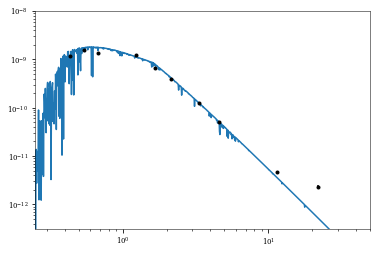

1516831933.96 33 7.43754545848
AWI0005w7o J032429.84+341709.9
[  7.39586638e-09   6.73841644e-09   2.60160922e-09   1.34057044e-09
   7.02260944e-10   2.17839198e-10   8.48502579e-11   7.83007246e-12
   3.02262125e-12]
[  1.83919806e-10   9.30946635e-11   6.46966073e-11   2.96330642e-11
   1.35829309e-11   4.63269511e-12   1.56299951e-12   1.44235265e-13
   1.97659530e-13]
[ 8.926       8.67        7.931       7.848       7.8         7.76089161
  7.801       7.552       6.437     ]
[ 0.027      0.015      0.027      0.024      0.021      0.0230899  0.02
  0.02       0.071    ]
[ 40.21245203  72.38241365  40.21245203  45.23900853  51.70172404
  47.02213124  54.28681024  54.28681024  15.29205922]
7206.05764304 2.50222968253e-10
Fit W1 flux: 2.28281703186e-10
Observed W1 flux: 2.17839197618e-10
Observed W1 uncertainty: 4.63269511304e-12
Difference (Observed - Fit): -1.04425055679e-11
Significance: -2.25408867045
 
Fit K flux: 7.08753156171e-10
Observed K flux: 7.02260943627e-10
Observed K

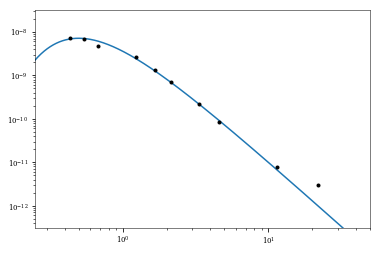

1516831938.49 34 7.352088234
AWI0005ykd J032448.99+283908.6
[  3.46249421e-08   2.80645348e-08   7.11937817e-09   3.37046359e-09
   1.75427840e-09   5.07139094e-10   2.06944156e-10   1.52955741e-11
   3.72206309e-12]
[  6.37815005e-10   2.58483918e-10   1.18029413e-10   6.51905455e-11
   4.36252531e-11   1.69515933e-11   3.43084701e-12   2.39491654e-13
   1.95404367e-13]
[ 7.25        7.121       6.838       6.847       6.806       6.84341396
  6.833       6.825       6.211     ]
[ 0.02        0.01        0.018       0.021       0.027       0.03629174
  0.018       0.017       0.057     ]
[  54.28681024  108.57362048   60.31867804   51.70172404   40.21245203
   29.91689846   60.31867804   63.86683557   19.04800359]
9353.39598637 3.25848271554e-10
Fit W1 flux: 5.41292402612e-10
Observed W1 flux: 5.07139093984e-10
Observed W1 uncertainty: 1.695159325e-11
Difference (Observed - Fit): -3.41533086272e-11
Significance: -2.01475508075
 
Fit K flux: 1.75981092249e-09
Observed K flux: 1.7542783

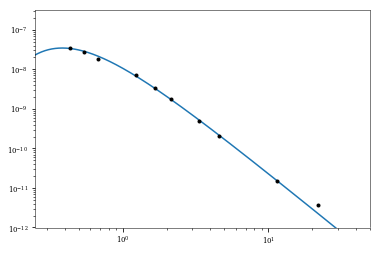

1516831942.9 35 7.26794285774
AWI0005zy4 J032504.59+105835.0
[  2.94706053e-08   2.39308347e-08   6.01508907e-09   2.87931805e-09
   1.49450893e-09   4.44513900e-10   1.77440669e-10   1.34575432e-11
   2.86803027e-12]
[  5.97155473e-10   2.42452246e-10   1.32962442e-10   9.54701975e-11
   2.20238976e-11   1.40237352e-11   3.26857792e-12   2.23107395e-13
   1.79625638e-13]
[ 7.425       7.294       7.021       7.018       6.98        6.98651832
  7.          6.964       6.494     ]
[ 0.022       0.011       0.024       0.036       0.016       0.03425332
  0.02        0.018       0.068     ]
[ 49.35164567  98.70329134  45.23900853  30.15933902  67.8585128
  31.69725422  54.28681024  60.31867804  15.96670889]
9372.70313867 2.99785458743e-10
Fit W1 flux: 4.59344792329e-10
Observed W1 flux: 4.445138995e-10
Observed W1 uncertainty: 1.40237351901e-11
Difference (Observed - Fit): -1.48308928283e-11
Significance: -1.05755653735
 
Fit K flux: 1.493853541e-09
Observed K flux: 1.4945089346e-09
Obs

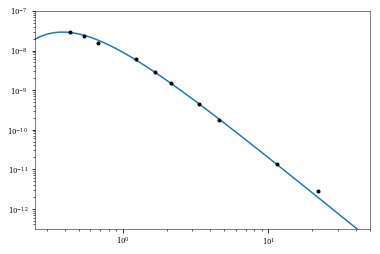

1516831948.02 36 7.20841666725
AWI00062iw J032555.87-355515.1
[  7.14149368e-08   5.52787033e-08   1.22586335e-08   5.96608780e-09
   3.09669559e-09   9.71499152e-10   3.82318847e-10   2.86131572e-11
   6.57633201e-12]
[  1.11818499e-09   4.58222106e-10   2.37102994e-10   1.59354128e-10
   8.84170233e-11   4.34357771e-11   6.51909645e-12   3.95305376e-13
   2.11995897e-13]
[ 6.464       6.385       6.248       6.227       6.189       6.13762562
  6.16656865  6.145       5.593     ]
[ 0.017       0.009       0.021       0.029       0.031       0.04854332
  0.01851339  0.015       0.035     ]
[  63.86683557  120.63735608   51.70172404   37.43917947   35.02374854
   22.36633524   58.64598723   72.38241365   31.02103442]
10241.3472849 4.00682545583e-10
Fit W1 flux: 9.15515311554e-10
Observed W1 flux: 9.71499151951e-10
Observed W1 uncertainty: 4.3435777089e-11
Difference (Observed - Fit): 5.59838403969e-11
Significance: 1.28888773608
 
Fit K flux: 3.01543446473e-09
Observed K flux: 3.096695

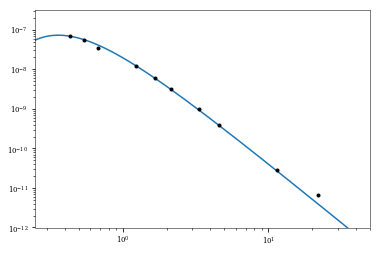

1516831954.59 37 7.19097297256
AWI0000zqw J032847.84+575556.1
[  1.90278210e-11   3.13731299e-11   4.38573173e-11   3.50017405e-11
   3.01230204e-11   2.02158811e-11   1.80406909e-11   6.16262556e-11
   1.09845869e-10]
[  1.75252708e-12   2.88957205e-13   8.48275721e-13   6.12518092e-13
   6.10375196e-13   4.28248835e-13   3.32321808e-13   7.94638307e-13
   1.82109212e-12]
[ 15.4    14.5    12.364  11.806  11.219  10.342   9.482   5.312   2.536]
[ 0.1    0.01   0.021  0.019  0.022  0.023  0.02   0.014  0.018]
[  10.85736205  108.57362048   51.70172404   57.14401078   49.35164567
   47.20592195   54.28681024   77.55258605   60.31867804]
3967.32137008 7.54510397984e-11
Fit W1 flux: 8.66361244005e-12
Observed W1 flux: 2.02158810785e-11
Observed W1 uncertainty: 4.28248835e-13
Difference (Observed - Fit): 1.15522686384e-11
Significance: 26.9755985172
 
Fit K flux: 2.24643213531e-11
Observed K flux: 3.01230203867e-11
Observed K uncertainty: 6.10375195745e-13
Difference (Observed - Fit): 7.65

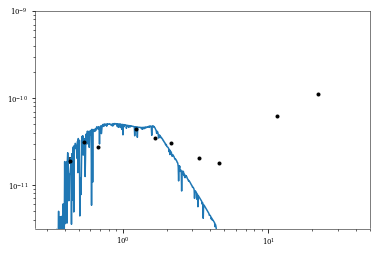

1516831966.99 38 7.32826315729
AWI0000mb7 J033337.91-072453.8
[  1.78891233e-08   1.87999999e-08   6.60757441e-09   3.54233508e-09
   1.87455642e-09   5.89489890e-10   2.31128322e-10   1.91146250e-11
   5.21895714e-12]
[  3.78959303e-10   2.07785278e-10   1.46059222e-10   1.17454003e-10
   3.62571356e-11   2.19097893e-11   4.25754103e-12   2.81683523e-13
   2.30728184e-13]
[ 7.967       7.556       6.919       6.793       6.734       6.68004078
  6.713       6.583       5.844     ]
[ 0.023       0.012       0.024       0.036       0.021       0.04035396
  0.02        0.016       0.048     ]
[ 47.20592195  90.47801706  45.23900853  30.15933902  51.70172404
  26.90531994  54.28681024  67.8585128   22.61950427]
7235.82404276 4.06395431075e-10
Fit W1 flux: 6.05465687013e-10
Observed W1 flux: 5.89489889982e-10
Observed W1 uncertainty: 2.19097892623e-11
Difference (Observed - Fit): -1.5975797031e-11
Significance: -0.729162514513
 
Fit K flux: 1.88139492031e-09
Observed K flux: 1.87455641768e

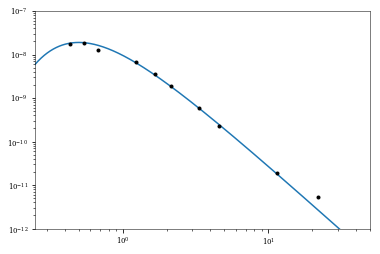

1516831971.7 39 7.26097435829
AWI0000xcq J033421.19+564343.6
[  1.31640359e-11   4.25165334e-11   7.50312294e-11   8.15999026e-11
   8.98045861e-11   9.35174539e-11   6.15819117e-11   3.29431999e-11
   4.60027433e-11]
[  1.21245251e-12   3.91591744e-13   1.24391369e-12   1.27765689e-12
   1.40612237e-12   1.98105344e-12   1.19109977e-12   4.55127126e-13
   8.89771940e-13]
[ 15.8    14.17   11.781  10.887  10.033   8.679   8.149   5.992   3.481]
[ 0.1    0.01   0.018  0.017  0.017  0.023  0.021  0.015  0.021]
[  10.85736205  108.57362048   60.31867804   63.86683557   63.86683557
   47.20592195   51.70172404   72.38241365   51.70172404]
3570.36226205 1.25488320895e-10
Fit W1 flux: 2.00808293597e-11
Observed W1 flux: 9.35174538798e-11
Observed W1 uncertainty: 1.98105343619e-12
Difference (Observed - Fit): 7.343662452e-11
Significance: 37.0694819122
 
Fit K flux: 4.96171554005e-11
Observed K flux: 8.98045861272e-11
Observed K uncertainty: 1.40612236883e-12
Difference (Observed - Fit): 4.01

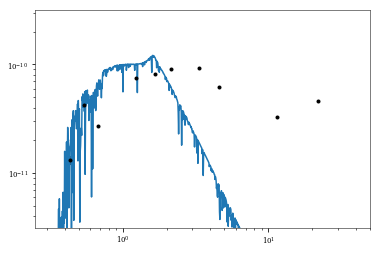

1516831987.28 40 7.46892499924
AWI0002d6a J033549.39+641324.7
[  9.98594239e-09   8.48316369e-09   2.60400649e-09   1.23392749e-09
   6.47587587e-10   1.94787158e-10   7.66748909e-11   5.85282827e-12
   1.91242200e-12]
[  9.19739284e-11   7.81328250e-11   5.75610867e-11   3.75041442e-11
   1.55077055e-11   4.32016729e-12   1.41240369e-12   1.07813081e-13
   1.33866837e-13]
[ 8.6         8.42        7.93        7.938       7.888       7.88233088
  7.911       7.868       6.934     ]
[ 0.01        0.01        0.024       0.033       0.026       0.02408045
  0.02        0.02        0.076     ]
[ 108.57362048  108.57362048   45.23900853   32.90109711   41.7590848
   45.08787398   54.28681024   54.28681024   14.28600269]
8523.08761618 2.09776740785e-10
Fit W1 flux: 1.99550720842e-10
Observed W1 flux: 1.94787158444e-10
Observed W1 uncertainty: 4.3201672924e-12
Difference (Observed - Fit): -4.76356239844e-12
Significance: -1.10263378153
 
Fit K flux: 6.39213457761e-10
Observed K flux: 6.47587

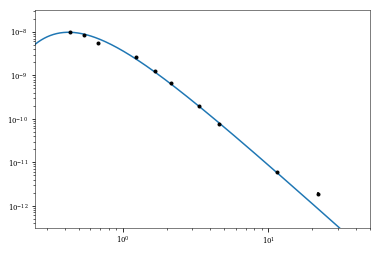

1516831991.03 41 7.37824390574
AWI00062j7 J033709.08-294948.5
[  3.13176421e-08   2.42414083e-08   5.10554446e-09   2.45069712e-09
   1.25111870e-09   3.85343650e-10   1.52283611e-10   1.15602115e-11
   2.50486158e-12]
[  5.19203058e-10   2.23271622e-10   9.87499847e-11   6.09437374e-11
   2.07418123e-11   1.14338407e-11   2.80516778e-12   1.70357573e-13
   1.29195515e-13]
[ 7.359       7.28        7.199       7.193       7.173       7.14161117
  7.166       7.129       6.641     ]
[ 0.018       0.01        0.021       0.027       0.018       0.03221575
  0.02        0.016       0.056     ]
[  60.31867804  108.57362048   51.70172404   40.21245203   60.31867804
   33.70203057   54.28681024   67.8585128    19.38814651]
10659.5273717 2.50474524118e-10
Fit W1 flux: 3.75655147263e-10
Observed W1 flux: 3.85343650442e-10
Observed W1 uncertainty: 1.14338407492e-11
Difference (Observed - Fit): 9.68850317871e-12
Significance: 0.847353342697
 
Fit K flux: 1.24390059621e-09
Observed K flux: 1.2511

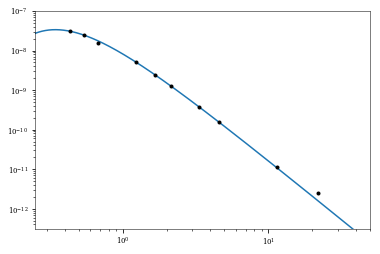

1516831994.33 42 7.28107143016
AWI0005ylv J033900.56+294145.6
[  1.05533188e-09   1.07190883e-09   5.29227085e-10   4.16571583e-10
   3.65509371e-10   2.54463006e-10   2.08282685e-10   2.36029225e-10
   1.90013182e-10]
[  1.15667593e-10   7.40448386e-11   1.26733401e-11   1.15102982e-11
   6.05963829e-12   5.88665662e-12   3.83670884e-12   3.47825521e-12
   3.85018938e-12]
[ 11.04        10.666        9.66         9.117        8.509        7.59217005
   6.826        3.854        1.941     ]
[ 0.119       0.075       0.026       0.03        0.018       0.02511704
  0.02        0.016       0.022     ]
[  9.12383365  14.47648273  41.7590848   36.19120683  60.31867804
  43.22708492  54.28681024  67.8585128   49.35164567]
2889.58873952 4.26806547263e-10
Fit W1 flux: 1.58209328254e-10
Observed W1 flux: 2.54463005663e-10
Observed W1 uncertainty: 5.88665662196e-12
Difference (Observed - Fit): 9.62536774095e-11
Significance: 16.3511622286
 
Fit K flux: 3.47153850033e-10
Observed K flux: 3.65509

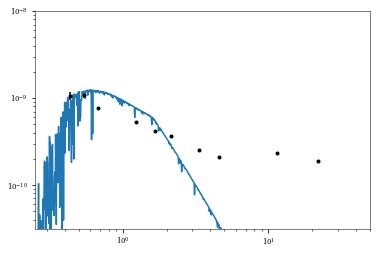

1516832005.05 43 7.36104651385
AWI0005ylw J033906.73+244209.8
[  3.86713253e-08   2.88773839e-08   6.25233245e-09   2.86081412e-09
   1.42461829e-09   4.48241685e-10   1.75006092e-10   1.31149241e-11
   3.65076376e-12]
[  3.56176069e-10   2.65970535e-10   1.38206664e-10   1.00126473e-10
   2.62424387e-11   1.45578611e-11   3.38491792e-12   2.05347955e-13
   2.01748661e-13]
[ 7.13        7.09        6.979       7.025       7.032       6.97745108
  7.015       6.992       6.232     ]
[ 0.01        0.01        0.024       0.038       0.02        0.03526222
  0.021       0.017       0.06      ]
[ 108.57362048  108.57362048   45.23900853   28.57200539   54.28681024
   30.7903531    51.70172404   63.86683557   18.09560341]
11083.4741972 2.61664190121e-10
Fit W1 flux: 4.2978891244e-10
Observed W1 flux: 4.48241685119e-10
Observed W1 uncertainty: 1.45578611495e-11
Difference (Observed - Fit): 1.84527726783e-11
Significance: 1.26754696235
 
Fit K flux: 1.4302277898e-09
Observed K flux: 1.4246182

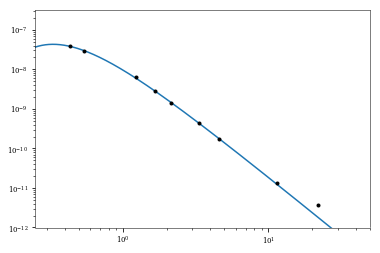

1516832008.7 44 7.27684090896
AWI0005ylz J034400.28+243324.6
[  1.34087735e-08   1.17100257e-08   3.42327716e-09   1.65687460e-09
   8.57627139e-10   2.69491014e-10   1.06918576e-10   9.55357201e-12
   2.77705020e-12]
[  1.23499368e-10   1.07853322e-10   1.16659327e-10   6.71456677e-11
   1.42182682e-11   6.23607895e-12   1.96951296e-12   1.49585805e-13
   2.30198198e-13]
[ 8.28        8.07        7.633       7.618       7.583       7.52987097
  7.55        7.336       6.529     ]
[ 0.01        0.01        0.037       0.044       0.018       0.02512417
  0.02        0.017       0.09      ]
[ 108.57362048  108.57362048   29.34422175   24.67582284   60.31867804
   43.21481748   54.28681024   63.86683557   12.06373561]
8602.44368606 2.40479347762e-10
Fit W1 flux: 2.6534598707e-10
Observed W1 flux: 2.69491013607e-10
Observed W1 uncertainty: 6.23607895012e-12
Difference (Observed - Fit): 4.14502653711e-12
Significance: 0.664684743452
 
Fit K flux: 8.51293019325e-10
Observed K flux: 8.576271

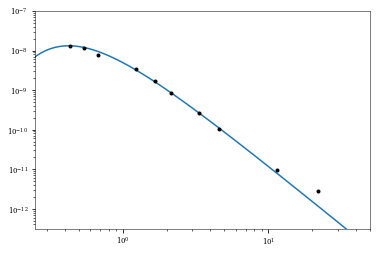

1516832013.37 45 7.21897777981
AWI0005ym7 J034921.76+242251.0
[  6.51912122e-08   4.59364942e-08   8.84793783e-09   4.11613528e-09
   2.02347813e-09   6.17526560e-10   2.43502627e-10   2.08240780e-11
   7.68393585e-12]
[  1.14082318e-09   4.23090747e-10   1.38537282e-10   1.02359719e-10
   3.16827680e-11   2.29570712e-11   4.37326830e-12   3.06874954e-13
   2.61855159e-13]
[ 6.563       6.586       6.602       6.63        6.651       6.62959258
  6.65637379  6.49        5.424     ]
[ 0.019       0.01        0.017       0.027       0.017       0.04036316
  0.01949965  0.016       0.037     ]
[  57.14401078  108.57362048   63.86683557   40.21245203   63.86683557
   26.8991874    55.67978231   67.8585128    29.34422175]
12037.3629621 2.96044937837e-10
Fit W1 flux: 6.07320496126e-10
Observed W1 flux: 6.17526559546e-10
Observed W1 uncertainty: 2.29570711725e-11
Difference (Observed - Fit): 1.02060634201e-11
Significance: 0.444571667849
 
Fit K flux: 2.04091019939e-09
Observed K flux: 2.0234

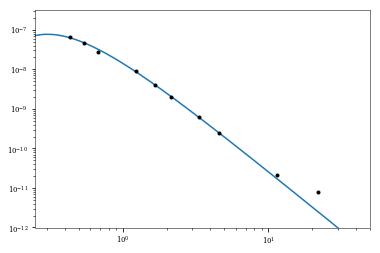

1516832016.53 46 7.13065217371
AWI0005zyr J035007.87+095528.1
[  8.90818149e-09   1.04461882e-08   5.52130912e-09   3.09663230e-09
   1.67995835e-09   5.52887166e-10   2.31981401e-10   2.85868157e-11
   7.33810177e-12]
[  1.88708982e-10   1.25076834e-10   9.15356453e-11   1.02675735e-10
   4.02297695e-11   1.84886074e-11   4.27325532e-12   3.94941454e-13
   2.63587018e-13]
[ 8.724       8.194       7.114       6.939       6.853       6.74964041
  6.709       6.146       5.474     ]
[ 0.023       0.013       0.018       0.036       0.026       0.03630714
  0.02        0.015       0.039     ]
[ 47.20592195  83.5181696   60.31867804  30.15933902  41.7590848
  29.90420828  54.28681024  72.38241365  27.83938987]
6001.15097313 4.48870208677e-10
Fit W1 flux: 5.72519171987e-10
Observed W1 flux: 5.52887165945e-10
Observed W1 uncertainty: 1.8488607383e-11
Difference (Observed - Fit): -1.96320060417e-11
Significance: -1.06184341714
 
Fit K flux: 1.70442196719e-09
Observed K flux: 1.67995835391e-0

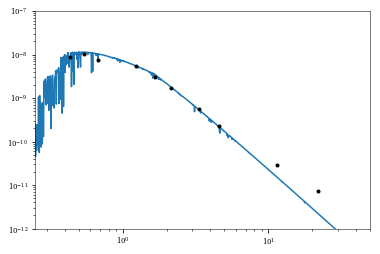

1516832033.91 47 7.34865957625
AWI0005ym9 J035157.43+255955.4
[  2.04827874e-08   1.67709571e-08   4.61362256e-09   2.15620297e-09
   1.12953194e-09   3.44457269e-10   1.36726648e-10   1.03030494e-11
   2.23451735e-12]
[  1.88653443e-10   1.54466223e-10   8.07367649e-11   3.17749812e-11
   1.76857352e-11   9.89579810e-12   2.77045772e-12   1.70810265e-13
   1.72877589e-13]
[ 7.82       7.68       7.309      7.332      7.284      7.2633933  7.283
  7.254      6.765    ]
[ 0.01        0.01        0.019       0.016       0.017       0.03119175
  0.022       0.018       0.084     ]
[ 108.57362048  108.57362048   57.14401078   67.8585128    63.86683557
   34.80843747   49.35164567   60.31867804   12.92543101]
9101.24076689 2.65396704567e-10
Fit W1 flux: 3.47014290253e-10
Observed W1 flux: 3.44457269373e-10
Observed W1 uncertainty: 9.89579809986e-12
Difference (Observed - Fit): -2.55702088069e-12
Significance: -0.258394608993
 
Fit K flux: 1.12346482939e-09
Observed K flux: 1.12953193911e-09

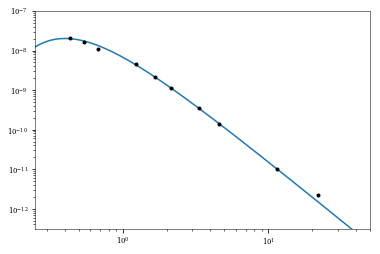

1516832038.25 48 7.28606249889
AWI0005w9s J035958.81+312901.0
[  1.71786510e-09   1.76261656e-09   8.12909244e-10   4.31012276e-10
   2.33183875e-10   7.36703400e-11   2.94207112e-11   2.70499073e-12
   3.63733859e-12]
[  8.38572480e-11   5.03263254e-11   1.34769075e-11   7.14558558e-12
   3.86586515e-12   1.56061649e-12   5.41949528e-13   6.47761019e-14
   1.84256196e-13]
[ 10.511  10.126   9.194   9.08    8.997   8.938   8.951   8.706   6.236]
[ 0.053  0.031  0.018  0.018  0.018  0.023  0.02   0.026  0.055]
[ 20.48558877  35.02374854  60.31867804  60.31867804  60.31867804
  47.20592195  54.28681024  41.7590848   19.74065827]
6515.18231357 1.56452358433e-10
Fit W1 flux: 7.79219337323e-11
Observed W1 flux: 7.36703399919e-11
Observed W1 uncertainty: 1.56061648528e-12
Difference (Observed - Fit): -4.25159374036e-12
Significance: -2.72430400451
 
Fit K flux: 2.36666300512e-10
Observed K flux: 2.33183875366e-10
Observed K uncertainty: 3.86586515048e-12
Difference (Observed - Fit): -3.48242

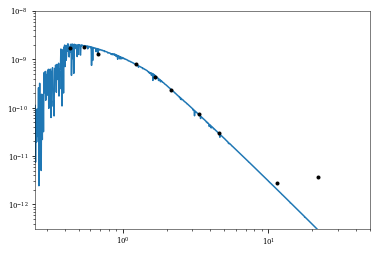

1516832051.57 49 7.40940816548
AWI0005ymc J040040.65+202447.8
[  1.37844377e-08   1.19277313e-08   3.60115705e-09   1.79015090e-09
   9.40369459e-10   2.98936078e-10   1.16052144e-10   9.45726985e-12
   8.10557317e-12]
[  1.26959363e-10   1.09858465e-10   8.95532820e-11   3.95709578e-11
   2.51172561e-11   6.92099021e-12   2.35153544e-12   1.56788414e-13
   2.91154843e-13]
[ 8.25        8.05        7.578       7.534       7.483       7.41728586
  7.461       7.347       5.366     ]
[ 0.01        0.01        0.027       0.024       0.029       0.02513705
  0.022       0.018       0.039     ]
[ 108.57362048  108.57362048   40.21245203   45.23900853   37.43917947
   43.19267459   49.35164567   60.31867804   27.83938987]
8404.62568762 2.53866114167e-10
Fit W1 flux: 2.87076306873e-10
Observed W1 flux: 2.98936077786e-10
Observed W1 uncertainty: 6.920990206e-12
Difference (Observed - Fit): 1.18597709127e-11
Significance: 1.71359452329
 
Fit K flux: 9.17398856999e-10
Observed K flux: 9.4036945

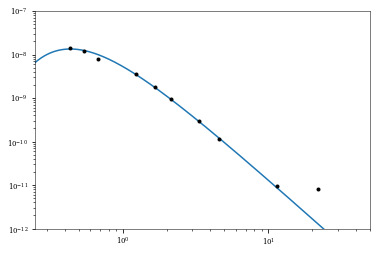

1516832057.88 50 7.38717999935
AWI0005zz5 J040238.47-004803.7
[  4.49768521e-08   3.34624586e-08   7.13907694e-09   3.17168202e-09
   1.67686660e-09   5.12821378e-10   2.04858112e-10   1.48513448e-11
   3.79825161e-12]
[  4.14252117e-10   3.08200634e-09   1.31506657e-10   5.84245419e-11
   3.55223780e-11   1.66662878e-11   4.15098847e-12   2.18857505e-13
   2.13397460e-13]
[ 6.966       6.93        6.835       6.913       6.855       6.83131638
  6.844       6.857       6.189     ]
[ 0.01        0.1         0.02        0.02        0.023       0.03528557
  0.022       0.016       0.061     ]
[ 108.57362048   10.85736205   54.28681024   54.28681024   47.20592195
   30.76998214   49.35164567   67.8585128    17.79895418]
11209.7053713 2.79622663572e-10
Fit W1 flux: 4.97551328267e-10
Observed W1 flux: 5.12821377779e-10
Observed W1 uncertainty: 1.6666287796e-11
Difference (Observed - Fit): 1.52700495124e-11
Significance: 0.916223798566
 
Fit K flux: 1.65804205124e-09
Observed K flux: 1.67686

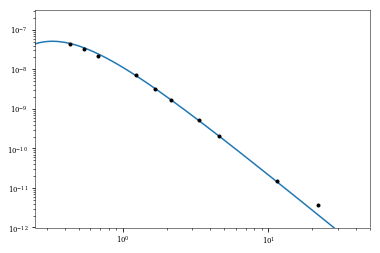

1516832062.41 51 7.33117647265
AWI00055vx J040649.32+702738.0
[  7.93942511e-09   6.75706112e-09   2.04005587e-09   9.78339617e-10
   5.05008300e-10   1.62664459e-10   6.30744056e-11   5.05086524e-12
   1.80793882e-12]
[  1.53562096e-10   6.84583161e-11   4.88529834e-11   1.53184295e-11
   8.37233700e-12   3.59566809e-12   1.16187349e-12   8.37363384e-14
   1.33213855e-13]
[ 8.849  8.667  8.195  8.19   8.158  8.078  8.123  8.028  6.995]
[ 0.021  0.011  0.026  0.017  0.018  0.024  0.02   0.018  0.08 ]
[ 51.70172404  98.70329134  41.7590848   63.86683557  60.31867804
  45.23900853  54.28681024  60.31867804  13.57170256]
8429.86934422 1.88792122595e-10
Fit W1 flux: 1.59374380944e-10
Observed W1 flux: 1.62664459385e-10
Observed W1 uncertainty: 3.59566808967e-12
Difference (Observed - Fit): 3.2900784409e-12
Significance: 0.915011719338
 
Fit K flux: 5.09567660864e-10
Observed K flux: 5.05008299709e-10
Observed K uncertainty: 8.37233699579e-12
Difference (Observed - Fit): -4.55936115492e-12


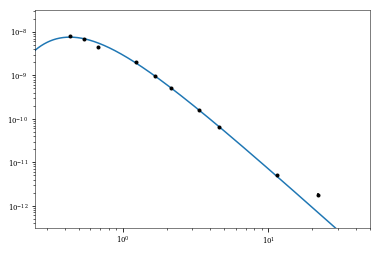

1516832066.77 52 7.27403846154
AWI0005ymi J041249.03+193219.2
[  1.39633317e-08   1.52530905e-08   7.40699519e-09   4.13894485e-09
   2.11689109e-09   7.11260843e-10   2.84146480e-10   2.21700045e-11
   6.18277911e-12]
[  3.21517595e-10   1.96680617e-10   1.43263988e-10   9.14906181e-11
   3.89945750e-11   2.51370418e-11   5.17122545e-12   3.26709260e-13
   2.90422050e-13]
[ 8.236       7.783       6.795       6.624       6.602       6.47615944
  6.48877721  6.422       5.66      ]
[ 0.025       0.014       0.021       0.024       0.02        0.03837157
  0.01975948  0.016       0.051     ]
[ 43.42944819  77.55258605  51.70172404  45.23900853  54.28681024
  28.29532801  54.9476102   67.8585128   21.28894519]
6307.56656938 4.88227259826e-10
Fit W1 flux: 7.25839929672e-10
Observed W1 flux: 7.1126084277e-10
Observed W1 uncertainty: 2.51370417925e-11
Difference (Observed - Fit): -1.45790869021e-11
Significance: -0.579984193145
 
Fit K flux: 2.18774196436e-09
Observed K flux: 2.11689109364e

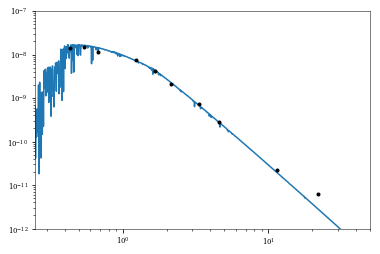

1516832079.38 53 7.37473585021
AWI0002ozm J041517.47+505124.0
[  6.27175459e-09   5.46711044e-09   1.59529889e-09   8.04803099e-10
   4.41874069e-10   1.33073835e-10   5.83785316e-11   7.59566463e-12
   2.65695213e-12]
[  1.73294984e-10   8.56017116e-11   3.37944652e-11   1.70487741e-11
   7.73264009e-12   2.81900723e-12   1.02160368e-12   1.25925582e-13
   1.61511461e-13]
[ 9.105  8.897  8.462  8.402  8.303  8.296  8.207  7.585  6.577]
[ 0.03   0.017  0.023  0.023  0.019  0.023  0.019  0.018  0.066]
[ 36.19120683  63.86683557  47.20592195  47.20592195  57.14401078
  47.20592195  57.14401078  60.31867804  16.45054856]
8224.63397827 1.76698064609e-10
Fit W1 flux: 1.35273617326e-10
Observed W1 flux: 1.33073835409e-10
Observed W1 uncertainty: 2.81900723306e-12
Difference (Observed - Fit): -2.19978191689e-12
Significance: -0.78033922407
 
Fit K flux: 4.30669790629e-10
Observed K flux: 4.41874068601e-10
Observed K uncertainty: 7.73264008939e-12
Difference (Observed - Fit): 1.1204277972e-11


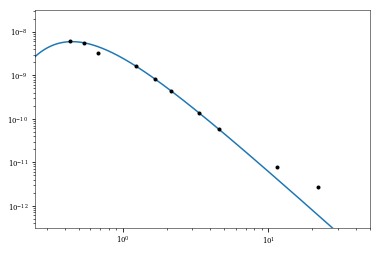

1516832083.29 54 7.31051852085
AWI00062df J043026.69-431245.6
[  3.14042956e-08   2.28327303e-08   4.52941446e-09   2.10906342e-09
   1.10483778e-09   3.31615985e-10   1.31417490e-10   1.05333322e-11
   3.24476860e-12]
[  5.49564078e-10   2.10297218e-10   7.09196631e-11   8.93558832e-11
   2.34046436e-11   8.91057686e-12   2.42079962e-12   1.55224920e-13
   1.46438574e-13]
[ 7.356       7.345       7.329       7.356       7.308       7.30464304
  7.326       7.23        6.36      ]
[ 0.019       0.01        0.017       0.046       0.023       0.02917391
  0.02        0.016       0.049     ]
[  57.14401078  108.57362048   63.86683557   23.60296097   47.20592195
   37.21599515   54.28681024   67.8585128    22.15788173]
11390.2986057 2.23494961917e-10
Fit W1 flux: 3.24020133546e-10
Observed W1 flux: 3.31615985243e-10
Observed W1 uncertainty: 8.91057686065e-12
Difference (Observed - Fit): 7.59585169683e-12
Significance: 0.852453417509
 
Fit K flux: 1.08186728106e-09
Observed K flux: 1.1048

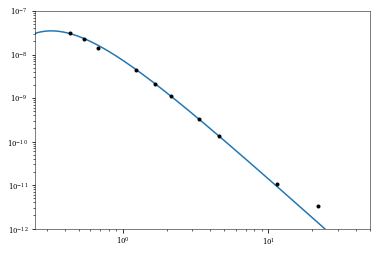

1516832088.94 55 7.28043636409
AWI0006006 J043217.75-133511.5
[  4.53094777e-09   3.87755393e-09   9.63922377e-10   4.82713717e-10
   2.47798410e-10   7.77128210e-11   3.05811045e-11   3.13737030e-12
   2.63501888e-12]
[  1.37714185e-10   6.78558239e-11   2.04195223e-11   1.06702983e-11
   5.24930771e-12   1.64625152e-12   5.91491001e-13   7.22406209e-14
   1.62605119e-13]
[ 9.458  9.27   9.009  8.957  8.931  8.88   8.909  8.545  6.586]
[ 0.033  0.019  0.023  0.024  0.023  0.023  0.021  0.025  0.067]
[ 32.90109711  57.14401078  47.20592195  45.23900853  47.20592195
  47.20592195  51.70172404  43.42944819  16.20501798]
9179.95768534 1.23930147094e-10
Fit W1 flux: 7.64887479351e-11
Observed W1 flux: 7.77128209776e-11
Observed W1 uncertainty: 1.64625152468e-12
Difference (Observed - Fit): 1.22407304241e-12
Significance: 0.743551652987
 
Fit K flux: 2.47964810338e-10
Observed K flux: 2.47798410185e-10
Observed K uncertainty: 5.2493077133e-12
Difference (Observed - Fit): -1.66400153625e-13


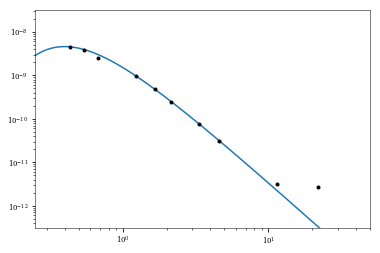

1516832094.06 56 7.24182142956
AWI000600b J043521.12-081730.0
[  1.96874313e-08   1.51132493e-08   3.16549814e-09   1.52647480e-09
   7.33328419e-10   2.35654408e-10   9.21834944e-11   6.90821398e-12
   1.83140220e-12]
[  3.62655887e-10   1.53117988e-10   7.58038198e-11   3.37424460e-11
   2.70168174e-11   5.23149458e-12   1.61317858e-12   1.39979405e-13
   1.55184106e-13]
[ 7.863       7.793       7.718       7.707       7.753       7.67554277
  7.711       7.688       6.981     ]
[ 0.02        0.011       0.026       0.024       0.04        0.02410319
  0.019       0.022       0.092     ]
[ 54.28681024  98.70329134  41.7590848   45.23900853  27.14340512
  45.04533162  57.14401078  49.35164567  11.80148049]
10826.407155 1.93720502928e-10
Fit W1 flux: 2.28980255426e-10
Observed W1 flux: 2.35654408143e-10
Observed W1 uncertainty: 5.23149457775e-12
Difference (Observed - Fit): 6.67415271642e-12
Significance: 1.27576405122
 
Fit K flux: 7.59737691286e-10
Observed K flux: 7.33328418986e-10

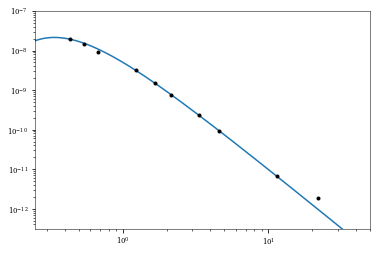

1516832098.0 57 7.18385964946
AWI0005wbq J043630.82+184215.2
[  1.54663935e-09   1.95595044e-09   1.20793082e-09   8.31169580e-10
   5.91695840e-10   3.81787171e-10   2.69428743e-10   2.57611817e-10
   3.03937111e-10]
[  9.97155241e-11   7.56628712e-11   2.11383626e-11   1.53107095e-11
   1.47142442e-11   1.09738023e-11   4.49068332e-12   3.32176953e-12
   5.31879206e-12]
[ 10.625       10.013        8.764        8.367        7.986        7.15167836
   6.5465231    3.759        1.431     ]
[ 0.07        0.042       0.019       0.02        0.027       0.03120758
  0.01809643  0.014       0.019     ]
[ 15.51051721  25.85086202  57.14401078  54.28681024  40.21245203
  34.7907825   59.99727074  77.55258605  57.14401078]
5171.75063296 2.67087455273e-10
Fit W1 flux: 1.63740590377e-10
Observed W1 flux: 3.81787170562e-10
Observed W1 uncertainty: 1.09738023435e-11
Difference (Observed - Fit): 2.18046580185e-10
Significance: 19.8697382511
 
Fit K flux: 4.67545061449e-10
Observed K flux: 5.916958

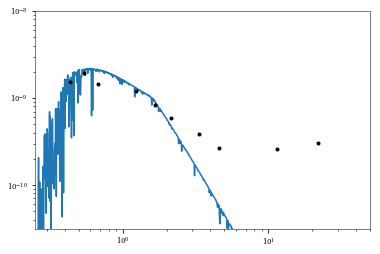

1516832107.69 58 7.22705172259
AWI000600n J043852.53-081329.6
[  3.44976138e-08   2.47148425e-08   4.82216495e-09   2.22274499e-09
   1.11711663e-09   3.42547295e-10   1.33984070e-10   1.09185705e-11
   2.63016946e-12]
[  6.35469531e-10   2.50395323e-10   1.02151695e-10   7.77945041e-11
   3.90982926e-11   9.52321658e-12   2.46807778e-12   1.70958376e-13
   1.55038438e-13]
[ 7.254       7.259       7.261       7.299       7.296       7.26943033
  7.305       7.191       6.588     ]
[ 0.02        0.011       0.023       0.038       0.038       0.03018474
  0.02        0.017       0.064     ]
[ 54.28681024  98.70329134  47.20592195  28.57200539  28.57200539
  35.96970538  54.28681024  63.86683557  16.9646282 ]
11845.6231116 2.21308253811e-10
Fit W1 flux: 3.32962510568e-10
Observed W1 flux: 3.42547294827e-10
Observed W1 uncertainty: 9.52321658498e-12
Difference (Observed - Fit): 9.58478425897e-12
Significance: 1.00646500827
 
Fit K flux: 1.11687466048e-09
Observed K flux: 1.1171166267e-09

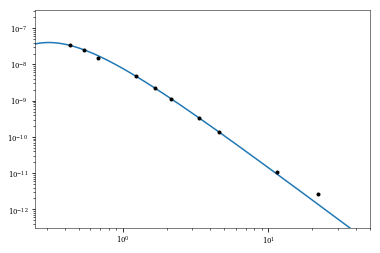

1516832109.61 59 7.13713559458
AWI0005yn2 J044717.93+054717.4
[  5.31849869e-08   3.88112694e-08   8.45750109e-09   3.87337585e-09
   1.99020822e-09   6.14092629e-10   2.37224454e-10   1.77732063e-11
   4.19550005e-12]
[  9.79703664e-10   3.93211501e-10   1.48003281e-10   1.17727863e-10
   3.84940398e-11   2.28287875e-11   4.50081699e-12   2.61915647e-13
   1.89345719e-13]
[ 6.784       6.769       6.651       6.696       6.669       6.63564697
  6.68473428  6.662       6.081     ]
[ 0.02        0.011       0.019       0.033       0.021       0.04036206
  0.02059948  0.016       0.049     ]
[ 54.28681024  98.70329134  57.14401078  32.90109711  51.70172404
  26.89992315  52.70697621  67.8585128   22.15788173]
10775.3429359 3.1477261742e-10
Fit W1 flux: 6.01107687615e-10
Observed W1 flux: 6.14092629175e-10
Observed W1 uncertainty: 2.28287874894e-11
Difference (Observed - Fit): 1.29849415599e-11
Significance: 0.568796812616
 
Fit K flux: 1.99321881528e-09
Observed K flux: 1.99020822037e-0

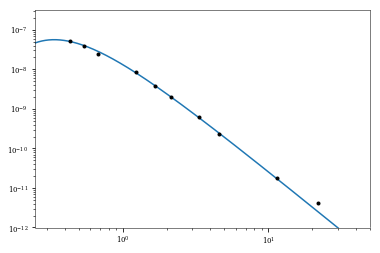

1516832116.5 60 7.13303333521
AWI0005yn4 J045013.22+034100.3
[  2.21100160e-08   1.93089140e-08   5.89443336e-09   2.88994542e-09
   1.56494297e-09   4.78773002e-10   1.91184714e-10   1.46881054e-11
   3.53495371e-12]
[  4.48009700e-10   1.95625837e-10   9.77215276e-11   6.92051904e-11
   3.45927778e-11   1.46656610e-11   3.34566496e-12   2.16451921e-13
   1.88837136e-13]
[ 7.737       7.527       7.043       7.014       6.93        6.90590755
  6.919       6.869       6.267     ]
[ 0.022       0.011       0.018       0.026       0.024       0.03325801
  0.019       0.016       0.058     ]
[ 49.35164567  98.70329134  60.31867804  41.7590848   45.23900853
  32.64585225  57.14401078  67.8585128   18.71958974]
8146.35532056 3.37476565846e-10
Fit W1 flux: 4.87415212267e-10
Observed W1 flux: 4.78773002111e-10
Observed W1 uncertainty: 1.46656609971e-11
Difference (Observed - Fit): -8.64221015614e-12
Significance: -0.589282007667
 
Fit K flux: 1.54916347999e-09
Observed K flux: 1.56494297074e

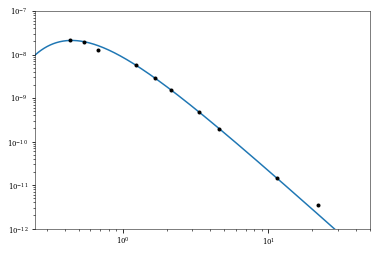

1516832121.85 61 7.10372130988
AWI0005zgy J045245.95-062129.5
[  1.13498222e-08   9.53581566e-09   2.42126354e-09   1.17839161e-09
   6.15599865e-10   1.88240025e-10   7.42425990e-11   5.90698382e-12
   2.40981515e-12]
[  2.50885740e-10   1.14176540e-10   5.79817195e-11   5.53522777e-11
   1.75766413e-11   4.17425079e-12   1.43597917e-12   9.79295968e-14
   1.64244612e-13]
[ 8.461       8.293       8.009       7.988       7.943       7.91945176
  7.946       7.858       6.683     ]
[ 0.024       0.013       0.026       0.051       0.031       0.02407636
  0.021       0.018       0.074     ]
[ 45.23900853  83.5181696   41.7590848   21.28894519  35.02374854
  45.09552359  51.70172404  60.31867804  14.67211088]
9174.38722185 1.95050739514e-10
Fit W1 flux: 1.89325334416e-10
Observed W1 flux: 1.88240025079e-10
Observed W1 uncertainty: 4.17425079196e-12
Difference (Observed - Fit): -1.08530933725e-12
Significance: -0.260000989721
 
Fit K flux: 6.13706207598e-10
Observed K flux: 6.15599864716

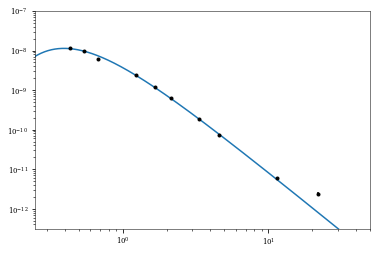

1516832125.72 62 7.05164515972
AWI0005wcl J045519.57+163712.9
[  3.44658550e-08   2.68261190e-08   6.20643287e-09   2.94096354e-09
   1.48627275e-09   4.61752315e-10   1.83760924e-10   1.42090742e-11
   3.56437780e-12]
[  6.03140286e-10   2.47077687e-10   1.48624734e-10   6.50094605e-11
   2.46403403e-11   1.54273850e-11   3.55425139e-12   2.09392655e-13
   2.10106450e-13]
[ 7.255       7.17        6.987       6.995       6.986       6.94520898
  6.962       6.905       6.258     ]
[ 0.019       0.01        0.026       0.024       0.018       0.03627501
  0.021       0.016       0.064     ]
[  57.14401078  108.57362048   41.7590848    45.23900853   60.31867804
   29.93069248   51.70172404   67.8585128    16.9646282 ]
10116.3389788 2.84095112595e-10
Fit W1 flux: 4.53371674865e-10
Observed W1 flux: 4.61752315394e-10
Observed W1 uncertainty: 1.54273849754e-11
Difference (Observed - Fit): 8.38064052895e-12
Significance: 0.543231438271
 
Fit K flux: 1.4907596562e-09
Observed K flux: 1.48627

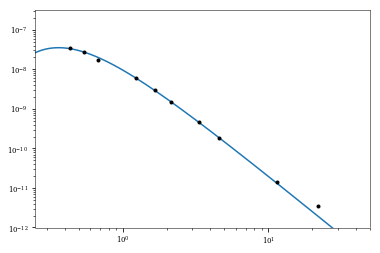

1516832131.33 63 7.02876190534
AWI0005zh6 J050206.31-085046.6
[  4.33594062e-11   1.74117355e-10   1.66299001e-10   1.26618894e-10
   7.92305506e-11   5.81103066e-11   2.94147920e-11   2.31410857e-11]
[  4.79504417e-13   3.84883226e-12   3.52284192e-12   2.21578591e-12
   1.67840278e-12   1.17747455e-12   4.60564418e-13   6.39411828e-13]
[ 13.67071427  10.867       10.114        9.66         8.859        8.212
   6.115        4.227     ]
[ 0.01200697  0.024       0.023       0.019       0.023       0.022       0.017
  0.03      ]
[ 90.42545727  45.23900853  47.20592195  57.14401078  47.20592195
  49.35164567  63.86683557  36.19120683]
2564.54931972 3.14226761271e-10
Fit W1 flux: 6.76354087432e-11
Observed W1 flux: 7.92305506276e-11
Observed W1 uncertainty: 1.67840278002e-12
Difference (Observed - Fit): 1.15951418844e-11
Significance: 6.90843820231
 
Fit K flux: 1.36643306677e-10
Observed K flux: 1.26618894007e-10
Observed K uncertainty: 2.21578591153e-12
Difference (Observed - Fit): -1

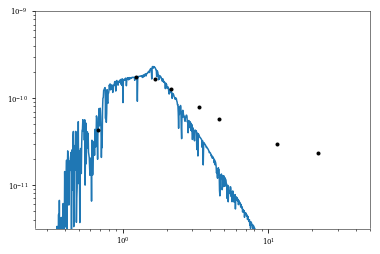

1516832144.21 64 7.12012499943
AWI0005wcz J050610.47+062929.2
[  2.12123633e-09   2.33001033e-09   9.96419143e-10   5.41613699e-10
   2.95732133e-10   9.81053461e-11   4.18266581e-11   6.73853954e-12
   3.96993806e-12]
[  1.03547736e-10   7.08186212e-11   2.47788705e-11   1.54641842e-11
   5.17520785e-12   2.07824235e-12   8.08999292e-13   1.17922061e-13
   1.82822404e-13]
[ 10.282   9.823   8.973   8.832   8.739   8.627   8.569   7.715   6.141]
[ 0.053  0.033  0.027  0.031  0.019  0.023  0.021  0.019  0.05 ]
[ 20.48558877  32.90109711  40.21245203  35.02374854  57.14401078
  47.20592195  51.70172404  57.14401078  21.7147241 ]
6579.86942595 1.73536668824e-10
Fit W1 flux: 9.71692249348e-11
Observed W1 flux: 9.81053460804e-11
Observed W1 uncertainty: 2.07824234833e-12
Difference (Observed - Fit): 9.36121145572e-13
Significance: 0.450438875101
 
Fit K flux: 2.95796591605e-10
Observed K flux: 2.95732133022e-10
Observed K uncertainty: 5.17520784771e-12
Difference (Observed - Fit): -6.445858

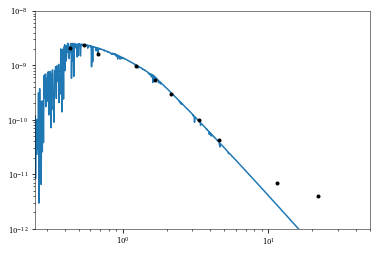

1516832153.27 65 7.15003077067
AWI0005zhi J050730.59-061059.9
[  4.13578398e-11   3.46451194e-10   4.47187484e-10   4.63552060e-10
   2.98382914e-10   2.02047354e-10   6.06130002e-11   5.09077298e-11]
[  3.80919782e-12   8.61552023e-12   1.23562468e-11   8.96589174e-12
   7.46076971e-12   4.09403478e-12   8.37399544e-13   1.17219380e-12]
[ 14.2         10.12         9.04         8.251        7.41929681   6.859
   5.33         3.371     ]
[ 0.1         0.027       0.03        0.021       0.02714776  0.022       0.015
  0.025     ]
[ 10.85736205  40.21245203  36.19120683  51.70172404  39.99358314
  49.35164567  72.38241365  43.42944819]
0.0 inf
Fit W1 flux: nan
Observed W1 flux: 2.98382913535e-10
Observed W1 uncertainty: 7.46076970531e-12
Difference (Observed - Fit): nan
Significance: nan
 
Fit K flux: nan
Observed K flux: 4.63552060343e-10
Observed K uncertainty: 8.96589173737e-12
Difference (Observed - Fit): nan
Significance: nan
False
Initial fit fail. Retrying with W1.
1998.23172786 

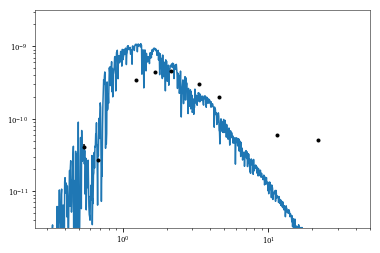

1516832167.81 66 7.26189394069
AWI0005wd8 J051143.75+122012.5
[  2.04262694e-09   2.81162792e-09   2.08565304e-09   1.22712736e-09
   6.67572619e-10   2.15037559e-10   8.69066815e-11   8.16894141e-12
   2.79243923e-12]
[  9.21851181e-11   7.50985454e-11   4.03401062e-11   3.50370081e-11
   2.02902845e-11   4.77163875e-12   1.52083622e-12   1.42953589e-13
   2.03182595e-13]
[ 10.323        9.619        8.171        7.944        7.855        7.77494588
   7.775        7.506        6.523     ]
[ 0.049       0.029       0.021       0.031       0.033       0.02409226
  0.019       0.019       0.079     ]
[ 22.15788173  37.43917947  51.70172404  35.02374854  32.90109711
  45.06576671  57.14401078  57.14401078  13.74349626]
5233.7257427 3.23424820267e-10
Fit W1 flux: 2.4434042649e-10
Observed W1 flux: 2.15037558665e-10
Observed W1 uncertainty: 4.77163874838e-12
Difference (Observed - Fit): -2.93028678256e-11
Significance: -6.14104909672
 
Fit K flux: 7.00226641814e-10
Observed K flux: 6.67572

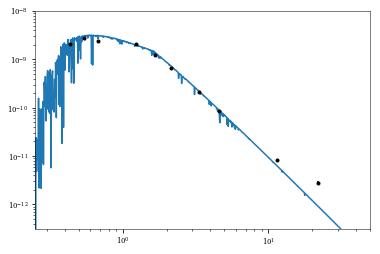

1516832181.9 67 7.36388059872
AWI0005yo4 J051328.63-043910.6
[  1.99245745e-08   1.69261368e-08   4.57975307e-09   2.28081279e-09
   1.17516410e-09   3.63818297e-10   1.42643888e-10   1.06602105e-11
   2.38552367e-12]
[  1.83512113e-10   1.55895481e-10   7.59259523e-11   6.93233051e-11
   2.48944211e-11   1.01175812e-11   2.89035727e-12   1.66913084e-13
   1.53800395e-13]
[ 7.85        7.67        7.317       7.271       7.241       7.20402034
  7.237       7.217       6.694     ]
[ 0.01        0.01        0.018       0.033       0.023       0.03019371
  0.022       0.017       0.07      ]
[ 108.57362048  108.57362048   60.31867804   32.90109711   47.20592195
   35.95901944   49.35164567   63.86683557   15.51051721]
8881.78929419 2.75271941373e-10
Fit W1 flux: 3.62032341636e-10
Observed W1 flux: 3.63818297429e-10
Observed W1 uncertainty: 1.01175811556e-11
Difference (Observed - Fit): 1.785955793e-12
Significance: 0.176520036313
 
Fit K flux: 1.16756930403e-09
Observed K flux: 1.1751640

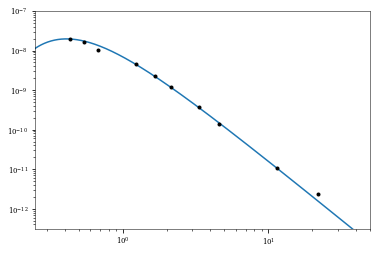

1516832186.45 68 7.32245588303
AWI0005wdi J051604.02+061852.6
[  3.47057193e-11   1.18370113e-10   1.20583987e-10   9.44710007e-11
   9.31735567e-11   6.73369074e-11   2.13484221e-11   1.76028801e-11]
[  1.52944098e-12   2.39850387e-12   2.99867283e-12   1.56619813e-12
   1.97376839e-12   1.17837209e-12   3.14601974e-13   4.53959848e-13]
[ 13.91241996  11.286       10.463        9.978        8.683        8.052
   6.463        4.524     ]
[ 0.04784714  0.022       0.027       0.018       0.023       0.019       0.016
  0.028     ]
[ 22.69176762  49.35164567  40.21245203  60.31867804  47.20592195
  57.14401078  67.8585128   38.77629303]
2439.28083868 2.97056609334e-10
Fit W1 flux: 5.44303120684e-11
Observed W1 flux: 9.31735567183e-11
Observed W1 uncertainty: 1.9737683934e-12
Difference (Observed - Fit): 3.874324465e-11
Significance: 19.6290733905
 
Fit K flux: 1.0580029717e-10
Observed K flux: 9.44710007003e-11
Observed K uncertainty: 1.56619812912e-12
Difference (Observed - Fit): -1.132

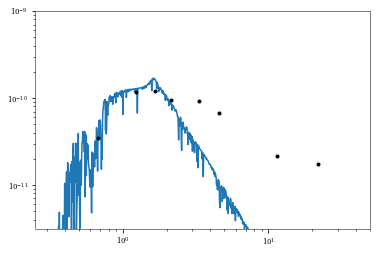

1516832198.31 69 7.38846376668
AWI0005wdq J051740.83+090514.5
[  6.36519794e-11   1.44557977e-10   1.40763365e-10   9.79261129e-11
   3.89128172e-11   1.90657181e-11   9.07331067e-12   1.10251303e-11]
[  6.73243771e-13   3.06228480e-12   3.63013981e-12   1.98425223e-12
   7.88480641e-13   3.51203506e-13   1.42066075e-13   3.24944649e-13]
[ 13.2538928  11.069      10.295       9.939       9.631       9.422
   7.392       5.032    ]
[ 0.01148378  0.023       0.028       0.022       0.022       0.02        0.017
  0.032     ]
[ 94.54521842  47.20592195  38.77629303  49.35164567  49.35164567
  54.28681024  63.86683557  33.9292564 ]
2988.21834728 2.11416618931e-10
Fit W1 flux: 4.13794392671e-11
Observed W1 flux: 3.8912817224e-11
Observed W1 uncertainty: 7.88480641223e-13
Difference (Observed - Fit): -2.4666220431e-12
Significance: -3.12832289614
 
Fit K flux: 9.27287740709e-11
Observed K flux: 9.79261128659e-11
Observed K uncertainty: 1.98425222776e-12
Difference (Observed - Fit): 5.1973387

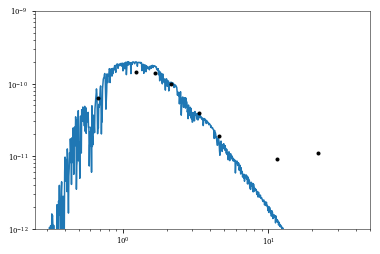

1516832212.2 70 7.48117142745
AWI0005yor J052007.77-055046.0
[  1.55377832e-08   1.07784881e-08   1.97534093e-09   9.03836010e-10
   4.60573043e-10   1.33688076e-10   5.25113480e-11   1.17102396e-11
   1.37779223e-11]
[  1.43108272e-10   9.92735442e-11   5.82193994e-11   2.24765207e-11
   1.01808828e-11   2.83201918e-12   1.06402425e-12   1.83353997e-13
   3.80698061e-13]
[ 8.12   8.16   8.23   8.276  8.258  8.291  8.322  7.115  4.79 ]
[ 0.01   0.01   0.032  0.027  0.024  0.023  0.022  0.017  0.03 ]
[ 108.57362048  108.57362048   33.9292564    40.21245203   45.23900853
   47.20592195   49.35164567   63.86683557   36.19120683]
12890.8371458 1.32597712693e-10
Fit W1 flux: 1.32113869383e-10
Observed W1 flux: 1.33688076325e-10
Observed W1 uncertainty: 2.83201917924e-12
Difference (Observed - Fit): 1.57420694158e-12
Significance: 0.555860268573
 
Fit K flux: 4.47297459856e-10
Observed K flux: 4.605730433e-10
Observed K uncertainty: 1.01808827879e-11
Difference (Observed - Fit): 1.3275583443

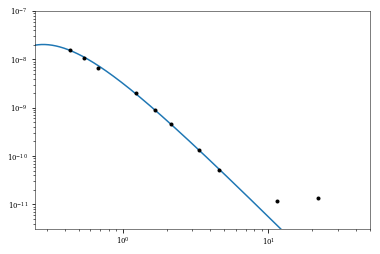

1516832217.77 71 7.45415493132
AWI0005yp1 J052104.79-102057.0
[  2.58338454e-09   2.42190915e-09   9.13780871e-10   4.99907486e-10
   2.60674480e-10   8.38866158e-11   3.53063780e-11   8.15390752e-12
   5.22857968e-12]
[  1.14210484e-10   6.24585012e-11   2.44070753e-11   1.01294998e-11
   5.28198151e-12   1.77703585e-12   6.50367518e-13   1.57710554e-13
   2.21522193e-13]
[ 10.068   9.781   9.067   8.919   8.876   8.797   8.753   7.508   5.842]
[ 0.048  0.028  0.029  0.022  0.022  0.023  0.02   0.021  0.046]
[ 22.61950427  38.77629303  37.43917947  49.35164567  49.35164567
  47.20592195  54.28681024  51.70172404  23.60296097]
7093.84132857 1.54363065636e-10
Fit W1 flux: 8.50817166924e-11
Observed W1 flux: 8.38866157894e-11
Observed W1 uncertainty: 1.77703585337e-12
Difference (Observed - Fit): -1.19510090298e-12
Significance: -0.672524924423
 
Fit K flux: 2.6329828175e-10
Observed K flux: 2.60674479908e-10
Observed K uncertainty: 5.28198150973e-12
Difference (Observed - Fit): -2.62380

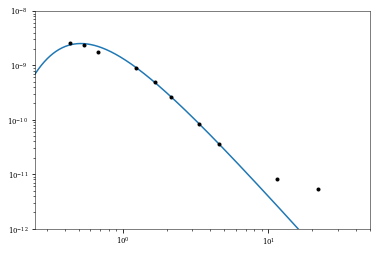

1516832221.53 72 7.40293055442
AWI0005we7 J052252.94+005557.8
[  2.04827874e-09   1.81868652e-09   5.18133965e-10   2.59471487e-10
   1.29210711e-10   4.18497313e-11   1.64381586e-11   1.64499954e-12
   2.53269989e-12]
[  9.62132561e-11   5.02521656e-11   1.09760374e-11   5.49658763e-12
   2.85617910e-12   8.86535621e-13   3.17942175e-13   6.51493245e-14
   1.86616224e-13]
[ 10.32   10.092   9.683   9.631   9.638   9.552   9.583   9.246   6.629]
[ 0.051  0.03   0.023  0.023  0.024  0.023  0.021  0.043  0.08 ]
[ 21.28894519  36.19120683  47.20592195  47.20592195  45.23900853
  47.20592195  51.70172404  25.24967918  13.57170256]
8532.63665786 9.57534339336e-11
Fit W1 flux: 4.16357450894e-11
Observed W1 flux: 4.18497313228e-11
Observed W1 uncertainty: 8.86535620906e-13
Difference (Observed - Fit): 2.13986233417e-13
Significance: 0.241373531272
 
Fit K flux: 1.33395372998e-10
Observed K flux: 1.29210710841e-10
Observed K uncertainty: 2.85617910371e-12
Difference (Observed - Fit): -4.184662

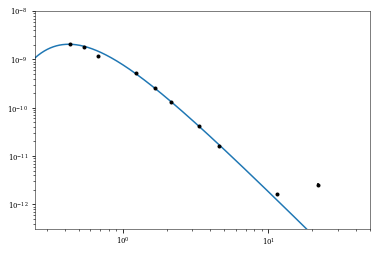

1516832223.28 73 7.32549314956
AWI0005yp9 J052303.81-044043.7
[  2.28764724e-11   3.43999528e-11   8.36454000e-11   7.50394496e-11
   5.01762864e-11   2.48938847e-11   1.54117930e-11   6.34696029e-12
   5.15209344e-12]
[  2.10700097e-12   3.16835274e-12   1.84896625e-12   1.65873329e-12
   1.06292356e-12   5.27346648e-13   2.98090504e-13   1.22761096e-13
   2.18281657e-13]
[ 15.2    14.4    11.663  10.978  10.665  10.116   9.653   7.78    5.858]
[ 0.1    0.1    0.024  0.024  0.023  0.023  0.021  0.021  0.046]
[ 10.85736205  10.85736205  45.23900853  45.23900853  47.20592195
  47.20592195  51.70172404  51.70172404  23.60296097]
3436.80345588 1.28488268163e-10
Fit W1 flux: 1.97046595499e-11
Observed W1 flux: 2.48938847249e-11
Observed W1 uncertainty: 5.27346648444e-13
Difference (Observed - Fit): 5.18922517504e-12
Significance: 9.840254395
 
Fit K flux: 4.77668425955e-11
Observed K flux: 5.01762864168e-11
Observed K uncertainty: 1.06292355595e-12
Difference (Observed - Fit): 2.4094438213

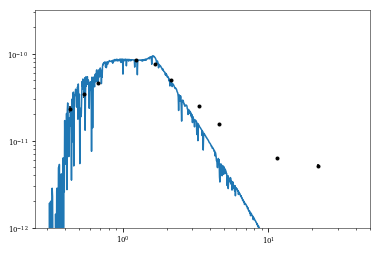

1516832235.64 74 7.39354054026
AWI0005web J052331.01-010423.6
[  1.12354134e-09   1.35568205e-09   8.48871714e-10   7.58734165e-10
   6.66958045e-10   4.64761898e-10   2.87361673e-10   1.28636964e-10
   2.13002024e-10]
[  8.17507654e-11   5.99342071e-11   1.64186346e-11   2.93504396e-11
   1.29001123e-11   1.50970875e-11   4.71957403e-12   1.89566435e-12
   4.31600651e-12]
[ 10.972       10.411        9.147        8.466        7.856        6.93815539
   6.47656081   4.513        1.817     ]
[ 0.079       0.048       0.021       0.042       0.021       0.0352685
  0.01783193  0.016       0.022     ]
[ 13.74349626  22.61950427  51.70172404  25.85086202  51.70172404
  30.78487136  60.88720541  67.8585128   49.35164567]
2839.86503991 5.79203650307e-10
Fit W1 flux: 2.81761189899e-10
Observed W1 flux: 4.64761898058e-10
Observed W1 uncertainty: 1.50970875476e-11
Difference (Observed - Fit): 1.83000708159e-10
Significance: 12.1215901797
 
Fit K flux: 6.11346729994e-10
Observed K flux: 6.669580

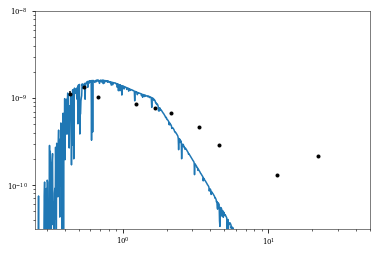

1516832245.72 75 7.42934666634
AWI0005wee J052408.04+022746.9
[  2.99081160e-09   2.51743257e-09   7.80624293e-10   5.92228959e-10
   6.39879970e-10   5.80251743e-10   4.20369718e-10   1.54371023e-10
   2.75412553e-10]
[  1.26713407e-10   6.26033093e-11   1.72555571e-11   1.85457430e-11
   1.70911857e-11   2.10256409e-11   8.03451068e-12   2.13271449e-12
   4.56595804e-12]
[ 9.909       9.739       9.238       8.735       7.901       6.69719055
  6.06355436  4.315       1.538     ]
[ 0.046       0.027       0.024       0.034       0.029       0.03934206
  0.02075164  0.015       0.018     ]
[ 23.60296097  40.21245203  45.23900853  31.93341779  37.43917947
  27.59733912  52.32051276  72.38241365  60.31867804]
7022.77211067 1.58519800858e-10
Fit W1 flux: 8.85276743172e-11
Observed W1 flux: 5.8025174318e-10
Observed W1 uncertainty: 2.10256409352e-11
Difference (Observed - Fit): 4.91724068863e-10
Significance: 23.3868765465
 
Fit K flux: 2.73382608976e-10
Observed K flux: 6.39879969922e-10

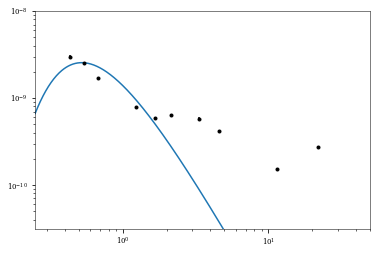

1516832246.99 76 7.34823684316
AWI0005wef J052411.19+033521.5
[  4.61588378e-11   9.29912450e-11   8.93078512e-11   5.47644229e-11
   2.43272307e-11   1.20518347e-11   5.39716607e-12   5.45988796e-12]
[  1.20978220e-12   1.79861014e-12   1.80962256e-12   1.16011764e-12
   5.37748981e-13   2.33103150e-13   1.04390447e-13   1.96120963e-13]
[ 13.60278542  11.548       10.789       10.57        10.141        9.92
   7.956        5.795     ]
[ 0.02845618  0.021       0.022       0.023       0.024       0.021       0.021
  0.039     ]
[ 38.15466764  51.70172404  49.35164567  47.20592195  45.23900853
  51.70172404  51.70172404  27.83938987]
3100.57270998 1.58148695964e-10
Fit W1 flux: 2.48057428395e-11
Observed W1 flux: 2.43272307274e-11
Observed W1 uncertainty: 5.37748980736e-13
Difference (Observed - Fit): -4.78512112079e-13
Significance: -0.889842899235
 
Fit K flux: 5.68315807701e-11
Observed K flux: 5.47644229284e-11
Observed K uncertainty: 1.16011764353e-12
Difference (Observed - Fit): 

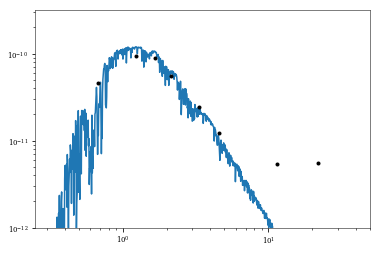

1516832262.36 77 7.45271428529
AWI0005ypj J052437.25-084201.9
[  1.65725393e-09   2.36242401e-09   1.68438770e-09   1.10481520e-09
   6.21868438e-10   1.98054518e-10   9.64391040e-11   1.63292328e-10
   4.13032029e-10]
[  8.39513000e-11   6.96279334e-11   3.10275681e-11   5.80016270e-11
   1.37462880e-11   4.39299628e-12   1.77647395e-12   2.10556909e-12
   6.46708147e-12]
[ 10.55        9.808       8.403       8.058       7.932       7.8642698
   7.662       4.254       1.098    ]
[ 0.055       0.032       0.02        0.057       0.024       0.02408244
  0.02        0.014       0.017     ]
[ 19.74065827  33.9292564   54.28681024  19.04800359  45.23900853
  45.08415348  54.28681024  77.55258605  63.86683557]
5158.01796114 3.04114911005e-10
Fit W1 flux: 2.11458030567e-10
Observed W1 flux: 1.98054518316e-10
Observed W1 uncertainty: 4.39299627525e-12
Difference (Observed - Fit): -1.34035122513e-11
Significance: -3.05110940494
 
Fit K flux: 6.03304157798e-10
Observed K flux: 6.21868438446e

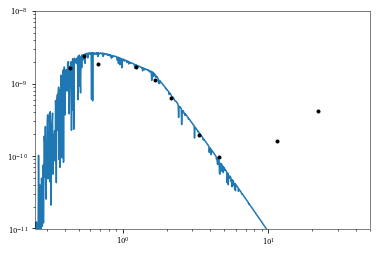

1516832275.27 78 7.52244871702
AWI0005ypo J052556.05-021601.5
[  1.36948679e-11   6.38619334e-11   6.30506604e-11   4.69568025e-11
   2.06296887e-11   1.12163917e-11   2.57849196e-12   4.23432053e-12]
[  1.26134395e-12   1.41165634e-12   1.33565150e-12   8.21727453e-13
   4.37014845e-13   2.06613570e-13   6.17468503e-14   2.06697527e-13]
[ 15.4    11.956  11.167  10.737  10.32    9.998   8.758   6.071]
[ 0.1    0.024  0.023  0.019  0.023  0.02   0.026  0.053]
[ 10.85736205  45.23900853  47.20592195  57.14401078  47.20592195
  54.28681024  41.7590848   20.48558877]
2816.23496744 1.60951262957e-10
Fit W1 flux: 2.14067632641e-11
Observed W1 flux: 2.06296886804e-11
Observed W1 uncertainty: 4.37014845383e-13
Difference (Observed - Fit): -7.77074583695e-13
Significance: -1.77814230319
 
Fit K flux: 4.61920852745e-11
Observed K flux: 4.69568024501e-11
Observed K uncertainty: 8.21727453356e-13
Difference (Observed - Fit): 7.64717175638e-13
Significance: 0.930621427475
False
W1 significantly lo

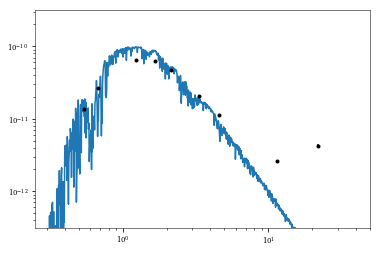

1516832287.49 79 7.58191139185
AWI0005wex J052617.32+055817.1
[  3.51204230e-11   2.87105864e-11   1.93236712e-11   1.18931943e-11
   5.30264648e-12   2.87775069e-12   3.63551366e-12   1.11169008e-11]
[  3.39822932e-13   6.34642255e-13   4.09348456e-13   3.17667067e-13
   1.22097947e-13   6.09616457e-14   7.70139320e-14   3.07171321e-13]
[ 13.89952324  12.824       12.451       12.228       11.795       11.475
   8.385        5.023     ]
[ 0.01050551  0.024       0.023       0.029       0.025       0.023       0.023
  0.03      ]
[ 103.34918483   45.23900853   47.20592195   37.43917947   43.42944819
   47.20592195   47.20592195   36.19120683]
4342.29486261 5.10467992934e-11
Fit W1 flux: 4.58427131627e-12
Observed W1 flux: 5.30264647839e-12
Observed W1 uncertainty: 1.22097947346e-13
Difference (Observed - Fit): 7.18375162124e-13
Significance: 5.88359737196
 
Fit K flux: 1.23286054497e-11
Observed K flux: 1.18931943459e-11
Observed K uncertainty: 3.17667067304e-13
Difference (Observed - 

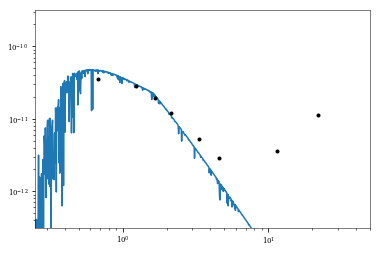

1516832303.62 80 7.68872500062
AWI0005ypv J052653.64-100458.1
[  2.03908059e-11   8.94627126e-11   7.92299971e-11   5.24926522e-11
   3.64495922e-11   2.52727887e-11   1.73207136e-11   1.74575675e-11]
[  3.41530890e-13   1.97755688e-12   1.53244401e-12   1.01529791e-12
   7.38568932e-13   4.88819071e-13   2.71200436e-13   4.18054361e-13]
[ 14.48983661  11.59        10.919       10.616        9.702        9.116
   6.69         4.533     ]
[ 0.01818528  0.024       0.021       0.021       0.022       0.021       0.017
  0.026     ]
[ 59.70413345  45.23900853  51.70172404  51.70172404  49.35164567
  51.70172404  63.86683557  41.7590848 ]
2588.16126598 2.08734015054e-10
Fit W1 flux: 3.04126255734e-11
Observed W1 flux: 3.64495922316e-11
Observed W1 uncertainty: 7.38568931921e-13
Difference (Observed - Fit): 6.03696665819e-12
Significance: 8.17387030143
 
Fit K flux: 6.1861748917e-11
Observed K flux: 5.24926521511e-11
Observed K uncertainty: 1.01529790601e-12
Difference (Observed - Fit): -9.

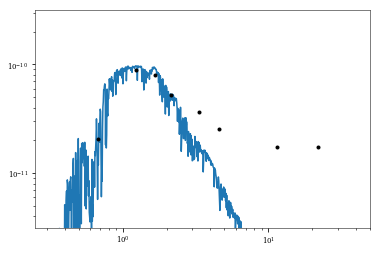

1516832321.53 81 7.81490123419
AWI0005n0p J052746.74+174407.4
[  1.62700563e-09   1.43270853e-09   5.79218017e-10   3.04291373e-10
   1.60582611e-10   5.02681236e-11   2.04481097e-11   1.87139636e-12
   3.65749491e-12]
[  1.18383678e-10   6.46590928e-11   1.06695902e-11   5.88551695e-12
   2.66223691e-12   1.01857036e-12   3.57834696e-13   6.20503109e-14
   2.02120638e-13]
[ 10.57   10.351   9.562   9.458   9.402   9.353   9.346   9.106   6.23 ]
[ 0.079  0.049  0.02   0.021  0.018  0.022  0.019  0.036  0.06 ]
[ 13.74349626  22.15788173  54.28681024  51.70172404  60.31867804
  49.35164567  57.14401078  30.15933902  18.09560341]
7068.28118106 1.21739829918e-10
Fit W1 flux: 5.26652321841e-11
Observed W1 flux: 5.02681235871e-11
Observed W1 uncertainty: 1.01857036181e-12
Difference (Observed - Fit): -2.39710859702e-12
Significance: -2.35340501441
 
Fit K flux: 1.62857310526e-10
Observed K flux: 1.60582611241e-10
Observed K uncertainty: 2.66223691323e-12
Difference (Observed - Fit): -2.27469

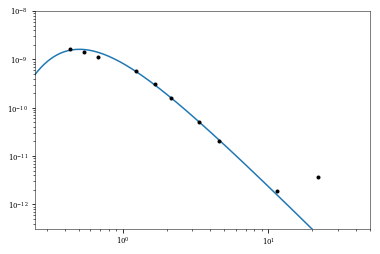

1516832325.54 82 7.76857317075
AWI0005wfn J052859.70+032148.6
[  1.59583893e-09   1.41696084e-09   5.09614836e-10   2.61872347e-10
   1.40895952e-10   4.37011307e-11   1.74362532e-11   1.98868401e-12
   2.55378147e-12]
[  8.96591405e-11   4.82875589e-11   1.12649426e-11   5.78864027e-12
   2.72516932e-12   9.25755264e-13   3.37247036e-13   5.49493698e-14
   1.62296256e-13]
[ 10.591  10.363   9.701   9.621   9.544   9.505   9.519   9.04    6.62 ]
[ 0.061  0.037  0.024  0.024  0.021  0.023  0.021  0.03   0.069]
[ 17.79895418  29.34422175  45.23900853  45.23900853  51.70172404
  47.20592195  51.70172404  36.19120683  15.73530732]
7417.57309035 1.09097528946e-10
Fit W1 flux: 4.50879510459e-11
Observed W1 flux: 4.37011307328e-11
Observed W1 uncertainty: 9.25755263985e-13
Difference (Observed - Fit): -1.38682031312e-12
Significance: -1.49804204963
 
Fit K flux: 1.40805348143e-10
Observed K flux: 1.40895951966e-10
Observed K uncertainty: 2.72516931674e-12
Difference (Observed - Fit): 9.060382

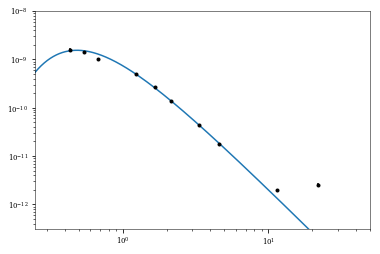

1516832327.81 83 7.70227710885
AWI0005wfv J052945.11+021539.6
[  1.20081507e-10   1.86055307e-10   1.68302141e-10   1.22828321e-10
   6.39282291e-11   3.62287347e-11   1.17426409e-11   1.40340730e-11]
[  1.32515793e-12   4.11271849e-12   3.72028800e-12   2.37571035e-12
   1.35424172e-12   6.33990058e-13   1.94676696e-13   4.26553344e-13]
[ 12.56473226  10.795       10.101        9.693        9.092        8.725
   7.112        4.77      ]
[ 0.01198163  0.024       0.024       0.021       0.023       0.019       0.018
  0.033     ]
[ 90.61675131  45.23900853  45.23900853  51.70172404  47.20592195
  57.14401078  60.31867804  32.90109711]
3216.89403985 2.2229515676e-10
Fit W1 flux: 5.24257831676e-11
Observed W1 flux: 6.39282291151e-11
Observed W1 uncertainty: 1.35424172391e-12
Difference (Observed - Fit): 1.15024459476e-11
Significance: 8.49364315429
 
Fit K flux: 1.22666780239e-10
Observed K flux: 1.22828321117e-10
Observed K uncertainty: 2.37571035409e-12
Difference (Observed - Fit): 1.6

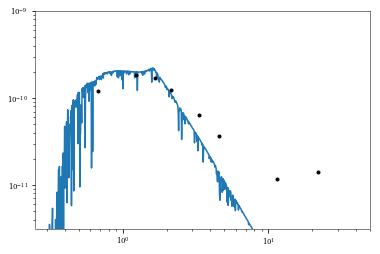

1516832341.55 84 7.77410714399
AWI0005wg8 J053020.90+004432.8
[  2.80494169e-10   1.46974524e-09   1.71115614e-09   1.15265282e-09
   3.47020561e-10   1.38501082e-10   1.75940484e-11   4.37304283e-12]
[  3.92256710e-12   2.70737078e-11   3.62487601e-11   2.54791794e-11
   9.96980266e-12   2.67884843e-12   2.91684913e-13   1.81247458e-13]
[ 11.64361299   8.551        7.583        7.262        7.25534367   7.269
   6.673        6.036     ]
[ 0.01518346  0.02        0.023       0.024       0.03119289  0.021       0.018
  0.045     ]
[ 71.50780644  54.28681024  47.20592195  45.23900853  34.80716444
  51.70172404  60.31867804  24.12747122]
2532.12270832 8.67375014363e-10
Fit W1 flux: 5.01958839418e-10
Observed W1 flux: 3.47020560782e-10
Observed W1 uncertainty: 9.96980266446e-12
Difference (Observed - Fit): -1.54938278636e-10
Significance: -15.5407568084
 
Fit K flux: 1.00443766465e-09
Observed K flux: 1.15265281626e-09
Observed K uncertainty: 2.54791794444e-11
Difference (Observed - Fit): 

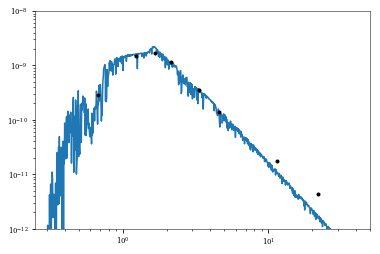

1516832364.48 85 7.95252941075
AWI0005yqi J053047.99-073132.4
[  2.65090113e-11   4.88474686e-11   4.93502822e-11   3.47454960e-11
   1.71590277e-11   9.35520194e-12   5.23077189e-12   3.04497500e-12]
[  2.79968625e-13   1.07976435e-12   1.09087895e-12   6.72037474e-13
   3.79297164e-13   1.72329188e-13   9.63543790e-14   1.99121319e-13]
[ 14.20493876  12.247       11.433       11.064       10.52        10.195
   7.99         6.429     ]
[ 0.01146675  0.024       0.024       0.021       0.024       0.02        0.02
  0.071     ]
[ 94.68565009  45.23900853  45.23900853  51.70172404  45.23900853
  54.28681024  54.28681024  15.29205922]
3047.81945192 1.2601491004e-10
Fit W1 flux: 1.52556725229e-11
Observed W1 flux: 1.71590276535e-11
Observed W1 uncertainty: 3.79297164337e-13
Difference (Observed - Fit): 1.90335513059e-12
Significance: 5.01811062551
 
Fit K flux: 3.45985950191e-11
Observed K flux: 3.47454960004e-11
Observed K uncertainty: 6.7203747357e-13
Difference (Observed - Fit): 1.469

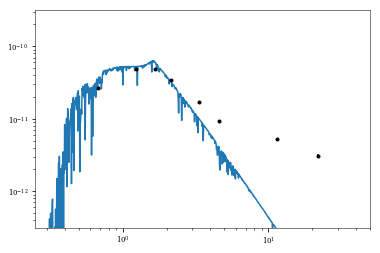

1516832380.1 86 8.04158139506
AWI0005wgp J053224.00-050523.4
[  1.31640359e-11   8.48316369e-11   1.78501579e-10   1.91641535e-10
   1.39219002e-10   6.05470062e-11   3.22591683e-11   1.22395593e-11
   1.04708932e-11]
[  1.21245251e-13   7.81328250e-13   3.61693266e-12   3.88318428e-12
   2.94918510e-12   1.28261463e-12   6.53659425e-13   1.80368812e-13
   3.76117913e-13]
[ 15.8    13.42   10.84    9.96    9.557   9.151   8.851   7.067   5.088]
[ 0.01   0.01   0.022  0.022  0.023  0.023  0.022  0.016  0.039]
[ 108.57362048  108.57362048   49.35164567   49.35164567   47.20592195
   47.20592195   49.35164567   67.8585128    27.83938987]
3105.81835849 2.4434649528e-10
Fit W1 flux: 5.94003492727e-11
Observed W1 flux: 6.05470062294e-11
Observed W1 uncertainty: 1.28261463252e-12
Difference (Observed - Fit): 1.14665695675e-12
Significance: 0.893999590898
 
Fit K flux: 1.36224657363e-10
Observed K flux: 1.39219001856e-10
Observed K uncertainty: 2.94918510468e-12
Difference (Observed - Fit): 2.

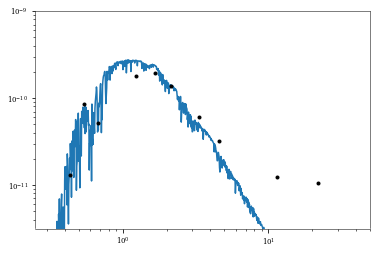

1516832394.89 87 8.11925287356
AWI0005wgs J053225.66-034313.6
[  2.08635908e-11   2.37989528e-11   5.96543424e-11   5.69756961e-11
   3.87702423e-11   2.04593897e-11   1.15094128e-11   6.21392177e-12
   5.34052227e-12]
[  1.92160773e-13   2.19196456e-13   1.20876096e-12   1.25943733e-12
   8.57009108e-13   4.52251063e-13   2.01410658e-13   1.25911136e-13
   2.26264928e-13]
[ 15.3    14.8    12.03   11.277  10.945  10.329   9.97    7.803   5.819]
[ 0.01   0.01   0.022  0.024  0.024  0.024  0.019  0.022  0.046]
[ 108.57362048  108.57362048   49.35164567   45.23900853   45.23900853
   45.23900853   57.14401078   49.35164567   23.60296097]
3838.48996015 8.27343680389e-11
Fit W1 flux: 9.86494502821e-12
Observed W1 flux: 2.04593896768e-11
Observed W1 uncertainty: 4.52251062542e-13
Difference (Observed - Fit): 1.05944446486e-11
Significance: 23.426024892
 
Fit K flux: 2.52132753792e-11
Observed K flux: 3.87702423464e-11
Observed K uncertainty: 8.57009107955e-13
Difference (Observed - Fit): 1.

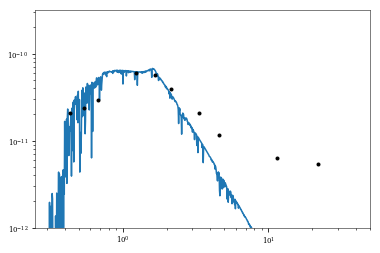

1516832411.27 88 8.21309091015
AWI0005wi7 J053431.70-035151.2
[  1.64359234e-10   2.58965591e-10   2.33393975e-10   1.38196968e-10
   5.61426198e-11   2.64151552e-11   6.88281000e-12   6.37358425e-12]
[  1.64715175e-12   5.48587084e-12   6.87884143e-12   2.54568223e-12
   1.18931307e-12   4.62255884e-13   1.39464650e-13   3.75698434e-13]
[ 12.22393731  10.436        9.746        9.565        9.233        9.068
   7.692        5.627     ]
[ 0.01088087  0.023       0.032       0.02        0.023       0.019       0.022
  0.064     ]
[ 99.78390568  47.20592195  33.9292564   54.28681024  47.20592195
  57.14401078  49.35164567  16.9646282 ]
3388.14907176 2.225011583e-10
Fit W1 flux: 5.76263231221e-11
Observed W1 flux: 5.61426197693e-11
Observed W1 uncertainty: 1.18931306613e-12
Difference (Observed - Fit): -1.48370335281e-12
Significance: -1.24752968336
 
Fit K flux: 1.38666695661e-10
Observed K flux: 1.38196968276e-10
Observed K uncertainty: 2.54568223239e-12
Difference (Observed - Fit): -4

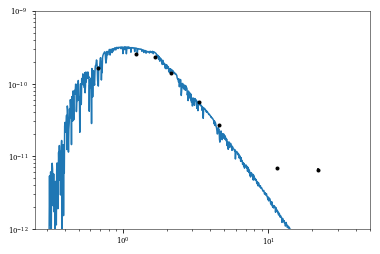

1516832425.29 89 8.27830337139
AWI00055xe J053523.12+594548.1
[  1.26878798e-08   1.09788752e-08   3.63782717e-09   1.81840091e-09
   9.54329867e-10   2.96729585e-10   1.18974302e-10   9.43986495e-12
   2.47049359e-12]
[  8.18017842e-11   9.10072595e-11   6.03101276e-11   3.51709918e-11
   1.40635246e-11   7.14444004e-12   2.19158764e-12   1.47805428e-13
   1.38799930e-13]
[ 8.34        8.14        7.567       7.517       7.467       7.42532956
  7.434       7.349       6.656     ]
[ 0.007       0.009       0.018       0.021       0.016       0.02614157
  0.02        0.017       0.061     ]
[ 155.10517211  120.63735608   60.31867804   51.70172404   67.8585128
   41.53293795   54.28681024   63.86683557   17.79895418]
8072.46585936 2.64046343121e-10
Fit W1 flux: 2.94900195337e-10
Observed W1 flux: 2.96729584973e-10
Observed W1 uncertainty: 7.1444400423e-12
Difference (Observed - Fit): 1.82938963621e-12
Significance: 0.256057805143
 
Fit K flux: 9.35765447604e-10
Observed K flux: 9.543298

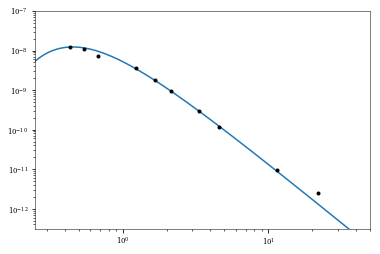

1516832430.87 90 8.24831111166
AWI0005wj7 J053525.11-064756.5
[  3.30665630e-11   2.14071005e-11   1.09759485e-10   1.20029954e-10
   9.52573544e-11   4.05221681e-11   2.64638586e-11   1.09387018e-11
   8.88758425e-12]
[  3.04554300e-13   1.97166682e-13   2.72948999e-12   3.31655020e-12
   1.75470531e-12   8.58412811e-13   4.87482290e-13   1.91423416e-13
   3.27430704e-13]
[ 14.8    14.915  11.368  10.468   9.969   9.587   9.066   7.189   5.266]
[ 0.01   0.01   0.027  0.03   0.02   0.023  0.02   0.019  0.04 ]
[ 108.57362048  108.57362048   40.21245203   36.19120683   54.28681024
   47.20592195   54.28681024   57.14401078   27.14340512]
15711.9520139 4.74627634643e-12
Fit W1 flux: 2.12900688112e-13
Observed W1 flux: 4.05221681304e-11
Observed W1 uncertainty: 8.5841281051e-13
Difference (Observed - Fit): 4.03092674423e-11
Significance: 46.9579052744
 
Fit K flux: 7.34362236591e-13
Observed K flux: 9.52573544256e-11
Observed K uncertainty: 1.75470531439e-12
Difference (Observed - Fit): 9.

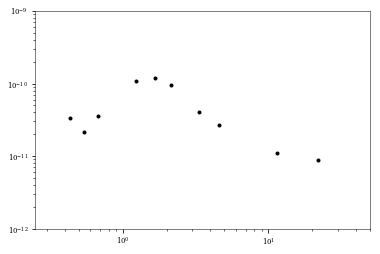

1516832436.37 91 8.21828571519
AWI0005wjy J053552.02-061001.6
[  6.01712531e-12   3.43999528e-11   4.98473485e-10   6.60221465e-10
   5.81431445e-10   3.50901486e-10   3.30949602e-10   3.92433236e-10
   6.13739013e-10]
[  5.54197722e-14   3.16835274e-12   1.46915535e-11   3.10124085e-11
   1.23169175e-11   9.75663251e-12   5.26636291e-12   4.69877678e-12
   1.13054904e-11]
[ 16.65        14.4          9.725        8.617        8.005        7.24326867
   6.32322826   3.302        0.668     ]
[ 0.01        0.1         0.032       0.051       0.023       0.03018833
  0.0172772   0.013       0.02      ]
[ 108.57362048   10.85736205   33.9292564    21.28894519   47.20592195
   35.96543024   62.84215645   83.5181696    54.28681024]
2437.98834147 6.60523954292e-10
Fit W1 flux: 2.68812849738e-10
Observed W1 flux: 3.50901485916e-10
Observed W1 uncertainty: 9.75663250989e-12
Difference (Observed - Fit): 8.20886361776e-11
Significance: 8.41362387016
 
Fit K flux: 5.22291331741e-10
Observed K flux

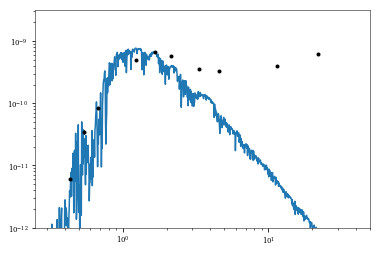

1516832449.6 92 8.27265217512
AWI0005wku J053628.55+000445.6
[  1.88360162e-10   2.18452916e-10   1.91797112e-10   1.22374136e-10
   8.80843017e-11   5.34678442e-11   4.87363686e-11   2.81686336e-11
   1.95696803e-11]
[  5.51685864e-11   3.70212732e-11   4.23964003e-12   2.81776862e-12
   1.54144416e-12   1.13265120e-12   9.42644942e-13   4.15108326e-13
   5.04681566e-13]
[ 12.911  12.393  10.762  10.447  10.054   9.286   8.403   6.162   4.409]
[ 0.318  0.184  0.024  0.025  0.019  0.023  0.021  0.016  0.028]
[  3.41426479   5.90074024  45.23900853  43.42944819  57.14401078
  47.20592195  51.70172404  67.8585128   38.77629303]
0.0 inf
Fit W1 flux: nan
Observed W1 flux: 5.34678442317e-11
Observed W1 uncertainty: 1.13265120196e-12
Difference (Observed - Fit): nan
Significance: nan
 
Fit K flux: nan
Observed K flux: 8.80843016915e-11
Observed K uncertainty: 1.54144416001e-12
Difference (Observed - Fit): nan
Significance: nan
False
Initial fit fail. Retrying with W1.
3145.52299115 2.0279660

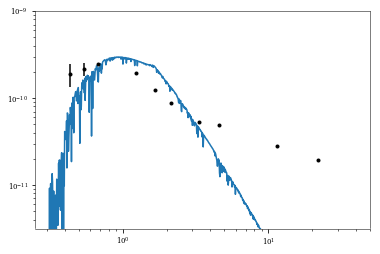

1516832469.46 93 8.3971720434
AWI00055xg J053707.15+603636.4
[  1.24792664e-08   9.43969250e-09   2.25134505e-09   1.09973903e-09
   5.46636360e-10   1.70487552e-10   6.68425742e-11   5.41209961e-12
   1.84324783e-12]
[  2.41370412e-10   1.04331337e-10   6.01333973e-11   3.34256037e-11
   1.15798259e-11   3.61157128e-12   1.29285001e-12   1.04679287e-13
   1.39210907e-13]
[ 8.358  8.304  8.088  8.063  8.072  8.027  8.06   7.953  6.974]
[ 0.021  0.012  0.029  0.033  0.023  0.023  0.021  0.021  0.082]
[ 51.70172404  90.47801706  37.43917947  32.90109711  47.20592195
  47.20592195  51.70172404  51.70172404  13.24068542]
9925.58430633 1.74221747985e-10
Fit W1 flux: 1.66558339766e-10
Observed W1 flux: 1.70487551723e-10
Observed W1 uncertainty: 3.61157127528e-12
Difference (Observed - Fit): 3.92921195766e-12
Significance: 1.08795082754
 
Fit K flux: 5.46217918047e-10
Observed K flux: 5.46636359901e-10
Observed K uncertainty: 1.15798259491e-11
Difference (Observed - Fit): 4.18441853815e-13
Si

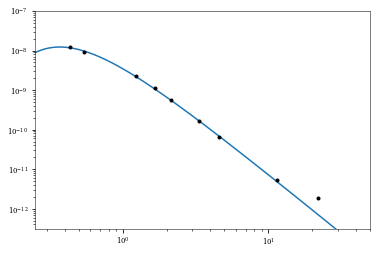

1516832477.38 94 8.39212766099
AWI0005wmu J053805.25-011521.6
[  2.33017778e-09   2.33645729e-09   1.08753204e-09   9.66695374e-10
   1.00762403e-09   8.09450589e-10   5.16590814e-10   1.59869561e-10
   4.97031291e-10]
[  2.14617305e-11   2.15195669e-11   3.20529289e-11   4.71890452e-11
   2.69136248e-11   3.16385241e-11   9.49956477e-12   2.20867960e-12
   7.78230652e-12]
[ 10.18         9.82         8.878        8.203        7.408        6.33575583
   5.83976622   4.277        0.897     ]
[ 0.01        0.01        0.032       0.053       0.029       0.04243754
  0.01996555  0.015       0.017     ]
[ 108.57362048  108.57362048   33.9292564    20.48558877   37.43917947
   25.58433465   54.38047183   72.38241365   63.86683557]
6275.30232755 1.99237583951e-10
Fit W1 flux: 1.20023454686e-10
Observed W1 flux: 8.09450588722e-10
Observed W1 uncertainty: 3.16385241082e-11
Difference (Observed - Fit): 6.89427134036e-10
Significance: 21.7907488882
 
Fit K flux: 3.61312832167e-10
Observed K flux

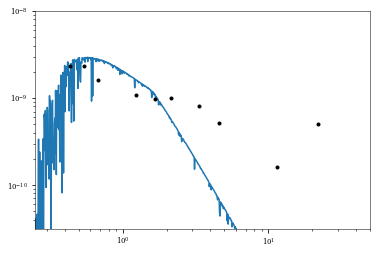

1516832492.58 95 8.46383158031
AWI0005wnn J053827.67-065453.6
[  8.30594510e-11   4.70498071e-11   1.16316697e-10   1.12950886e-10
   8.39650432e-11   3.61820087e-11   2.10985771e-11   1.37456658e-11
   1.77167367e-11]
[  7.65005815e-12   4.33344738e-13   2.57115930e-12   2.49675864e-12
   1.77869724e-12   7.66471816e-13   4.27515168e-13   2.27884069e-13
   4.73213808e-13]
[ 13.8    14.06   11.305  10.534  10.106   9.71    9.312   6.941   4.517]
[ 0.1    0.01   0.024  0.024  0.023  0.023  0.022  0.018  0.029]
[  10.85736205  108.57362048   45.23900853   45.23900853   47.20592195
   47.20592195   49.35164567   60.31867804   37.43917947]
3410.71675373 1.59275524561e-10
Fit W1 flux: 2.98766963206e-11
Observed W1 flux: 3.61820087356e-11
Observed W1 uncertainty: 7.66471816332e-13
Difference (Observed - Fit): 6.30531241496e-12
Significance: 8.22641130515
 
Fit K flux: 7.21413053046e-11
Observed K flux: 8.39650431916e-11
Observed K uncertainty: 1.77869724243e-12
Difference (Observed - Fit): 1

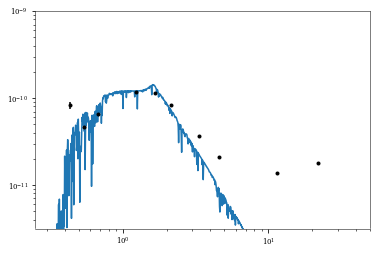

1516832506.09 96 8.51631249984
AWI0005wnz J053839.81-025646.2
[  1.11529321e-11   2.80903951e-11   1.05303320e-10   9.30871299e-11
   6.17872001e-11   3.21582698e-11   2.18299714e-11   1.44599164e-11
   9.66459659e-12]
[  2.05444601e-13   5.17444199e-13   2.61867442e-12   1.97193755e-12
   1.19507040e-12   6.81233804e-13   4.22229080e-13   2.26407278e-13
   2.75944095e-13]
[ 15.98   14.62   11.413  10.744  10.439   9.838   9.275   6.886   5.175]
[ 0.02   0.02   0.027  0.023  0.021  0.023  0.021  0.017  0.031]
[ 54.28681024  54.28681024  40.21245203  47.20592195  51.70172404
  47.20592195  51.70172404  63.86683557  35.02374854]
3268.91493147 1.53431120579e-10
Fit W1 flux: 2.57088206042e-11
Observed W1 flux: 3.2158269773e-11
Observed W1 uncertainty: 6.81233803881e-13
Difference (Observed - Fit): 6.44944916876e-12
Significance: 9.46730642552
 
Fit K flux: 6.0689629666e-11
Observed K flux: 6.17872001291e-11
Observed K uncertainty: 1.19507040202e-12
Difference (Observed - Fit): 1.0975704631

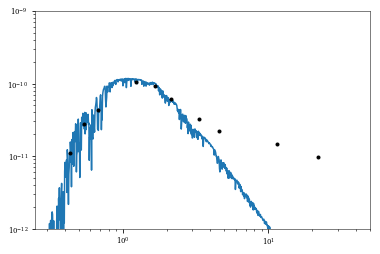

1516832517.73 97 8.5485360819
AWI0005yrn J053844.06-111411.1
[  3.91011073e-10   5.13520573e-10   3.84098015e-10   2.56147216e-10
   1.70804188e-10   8.13753134e-11   5.28996948e-11   4.59373334e-11
   3.42912827e-11]
[  6.66248838e-11   4.96618423e-11   8.13664894e-12   6.13392792e-12
   3.30364589e-12   1.72383697e-12   1.02317081e-12   6.34647714e-13
   6.31668771e-13]
[ 12.118  11.465  10.008   9.645   9.335   8.83    8.314   5.631   3.8  ]
[ 0.185  0.105  0.023  0.026  0.021  0.023  0.021  0.015  0.02 ]
[  5.86884435  10.34034481  47.20592195  41.7590848   51.70172404
  47.20592195  51.70172404  72.38241365  54.28681024]
4421.10030962 1.80816745938e-10
Fit W1 flux: 5.91651044936e-11
Observed W1 flux: 8.13753133952e-11
Observed W1 uncertainty: 1.72383696877e-12
Difference (Observed - Fit): 2.22102089016e-11
Significance: 12.8841701994
 
Fit K flux: 1.60197709863e-10
Observed K flux: 1.7080418825e-10
Observed K uncertainty: 3.30364589257e-12
Difference (Observed - Fit): 1.0606478387

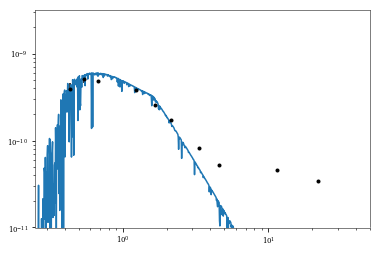

1516832531.78 98 8.60465306165
AWI0005wox J053926.39-021503.3
[  1.90278210e-11   3.10854993e-11   7.08014354e-11   6.66944415e-11
   5.37153631e-11   4.41461337e-11   2.98025323e-11   2.26446588e-11
   2.18767967e-11]
[  1.75252708e-12   2.86308029e-13   1.56505276e-12   1.65855197e-12
   1.18736827e-12   9.35182110e-13   5.21533785e-13   3.33704024e-13
   5.64179682e-13]
[ 15.4    14.51   11.844  11.106  10.591   9.494   8.937   6.399   4.288]
[ 0.1    0.01   0.024  0.027  0.024  0.023  0.019  0.016  0.028]
[  10.85736205  108.57362048   45.23900853   40.21245203   45.23900853
   47.20592195   57.14401078   67.8585128    38.77629303]
3476.22161787 1.20385164913e-10
Fit W1 flux: 1.76457121633e-11
Observed W1 flux: 4.41461336897e-11
Observed W1 uncertainty: 9.35182109995e-13
Difference (Observed - Fit): 2.65004215264e-11
Significance: 28.3371775862
 
Fit K flux: 4.30248824505e-11
Observed K flux: 5.37153630925e-11
Observed K uncertainty: 1.18736826549e-12
Difference (Observed - Fit): 1

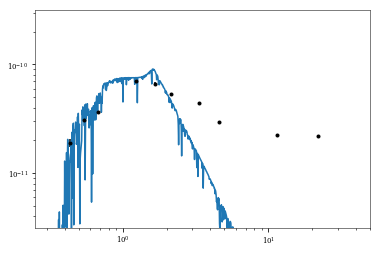

1516832545.73 99 8.65869696935
AWI0005wpr J054006.72-061618.9
[  8.30594510e-11   5.60477067e-11   1.82827728e-10   1.78356787e-10
   1.37435370e-10   6.74982750e-11   3.68683046e-11   1.75293487e-11
   3.06184873e-11]
[  7.65005815e-12   1.03243691e-12   3.53620177e-12   4.10681679e-12
   2.78481838e-12   1.42986880e-12   6.79139268e-13   2.58322029e-13
   7.61418062e-13]
[ 13.8    13.87   10.814  10.038   9.571   9.033   8.706   6.677   3.923]
[ 0.1    0.02   0.021  0.025  0.022  0.023  0.02   0.016  0.027]
[ 10.85736205  54.28681024  51.70172404  43.42944819  49.35164567
  47.20592195  54.28681024  67.8585128   40.21245203]
3211.04015963 2.18974398077e-10
Fit W1 flux: 5.07034737439e-11
Observed W1 flux: 6.74982750149e-11
Observed W1 uncertainty: 1.42986880104e-12
Difference (Observed - Fit): 1.67948012709e-11
Significance: 11.7456939117
 
Fit K flux: 1.18516160726e-10
Observed K flux: 1.37435369918e-10
Observed K uncertainty: 2.78481837941e-12
Difference (Observed - Fit): 1.89192091

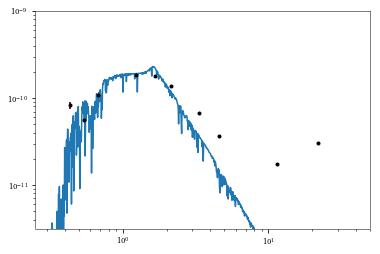

1516832558.72 100 8.70196000099
AWI0005yrp J054011.76-094211.1
[  4.04565697e-10   5.37227020e-10   3.80927268e-10   3.73327206e-10
   4.15048182e-10   3.18664739e-10   2.15900261e-10   1.53096683e-10
   1.59361618e-10]
[  7.48963742e-11   5.54180895e-11   8.42032752e-12   9.28387072e-12
   8.79229056e-12   8.26568798e-12   3.77817829e-12   1.97410158e-12
   2.49521707e-12]
[ 12.081       11.416       10.017        9.236        8.371        7.34789666
   6.787        4.324        2.132     ]
[ 0.201       0.112       0.024       0.027       0.023       0.02816238
  0.019       0.014       0.017     ]
[  5.40167266   9.69407326  45.23900853  40.21245203  47.20592195
  38.5527181   57.14401078  77.55258605  63.86683557]
2231.12580443 6.43837308269e-10
Fit W1 flux: 2.1034197971e-10
Observed W1 flux: 3.18664738558e-10
Observed W1 uncertainty: 8.26568797812e-12
Difference (Observed - Fit): 1.08322758848e-10
Significance: 13.1051110488
 
Fit K flux: 3.79241593281e-10
Observed K flux: 4.15048

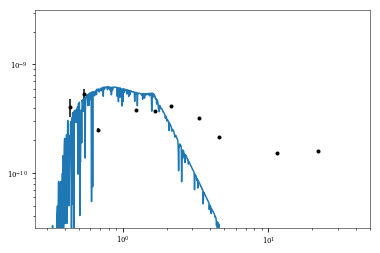

1516832571.34 101 8.74082178172
AWI0005wsf J054214.29-075835.1
[  2.26651108e-11   7.88573289e-11   1.03965594e-10   1.02730290e-10
   7.69294583e-11   4.65428707e-11   2.30869085e-11   2.06435190e-11]
[  2.08753385e-13   1.88838738e-12   2.10662872e-12   1.79774379e-12
   1.55880229e-12   9.00218931e-13   3.40221256e-13   4.18294440e-13]
[ 14.853  11.727  10.624   9.887   8.891   8.453   6.378   4.351]
[ 0.01   0.026  0.022  0.019  0.022  0.021  0.016  0.022]
[ 108.57362048   41.7590848    49.35164567   57.14401078   49.35164567
   51.70172404   67.8585128    49.35164567]
3020.36767707 1.80963701743e-10
Fit W1 flux: 3.09331843643e-11
Observed W1 flux: 7.6929458263e-11
Observed W1 uncertainty: 1.55880228951e-12
Difference (Observed - Fit): 4.59962738987e-11
Significance: 29.5074456896
 
Fit K flux: 6.97729393657e-11
Observed K flux: 1.02730290384e-10
Observed K uncertainty: 1.7977437878e-12
Difference (Observed - Fit): 3.29573510181e-11
Significance: 18.3326184976
True
K excess detecte

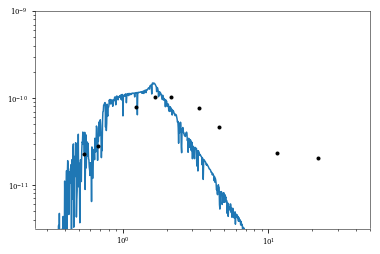

1516832586.69 102 8.80556862728
AWI0005wsk J054227.76-100151.2
[  1.36632266e-10   3.10486029e-10   3.40792195e-10   3.78179964e-10
   3.06221701e-10   1.99458784e-10   1.62392430e-10   1.78971439e-10]
[  1.86393242e-12   6.86323681e-12   8.16091150e-12   9.05623209e-12
   7.09051080e-12   3.85787491e-12   2.24353433e-12   2.14290423e-12]
[ 12.42453941  10.239        9.335        8.472        7.39114177   6.873
   4.26         2.006     ]
[ 0.01481157  0.024       0.026       0.026       0.02514004  0.021       0.015
  0.013     ]
[ 73.30322927  45.23900853  41.7590848   41.7590848   43.18753752
  51.70172404  72.38241365  83.5181696 ]
2710.48569965 4.29640258913e-10
Fit W1 flux: 1.41452284509e-10
Observed W1 flux: 3.06221701061e-10
Observed W1 uncertainty: 7.09051079692e-12
Difference (Observed - Fit): 1.64769416552e-10
Significance: 23.2380178624
 
Fit K flux: 2.97403782266e-10
Observed K flux: 3.7817996361e-10
Observed K uncertainty: 9.05623208544e-12
Difference (Observed - Fit): 8.

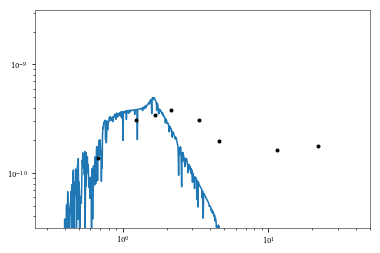

1516832600.17 103 8.85100970916
AWI0005e72 J054259.80+445105.2
[  2.26250244e-08   1.85762414e-08   5.09145679e-09   2.58517317e-09
   1.31249759e-09   4.12717434e-10   1.62425109e-10   1.27223044e-11
   2.61808493e-12]
[  4.79283604e-10   2.05312208e-10   1.50060960e-10   1.11908527e-10
   2.53859541e-11   1.18673918e-11   3.14158013e-12   1.87482806e-13
   1.68794173e-13]
[ 7.712       7.569       7.202       7.135       7.121       7.06709965
  7.096       7.025       6.593     ]
[ 0.023       0.012       0.032       0.047       0.021       0.03121956
  0.021       0.016       0.07      ]
[ 47.20592195  90.47801706  33.9292564   23.10077031  51.70172404
  34.77743389  51.70172404  67.8585128   15.51051721]
8781.10122927 2.93192988314e-10
Fit W1 flux: 4.04834888119e-10
Observed W1 flux: 4.12717433569e-10
Observed W1 uncertainty: 1.18673917951e-11
Difference (Observed - Fit): 7.88254544967e-12
Significance: 0.664218860031
 
Fit K flux: 1.30320726404e-09
Observed K flux: 1.31249759329e

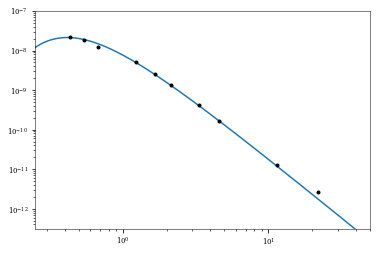

1516832605.96 104 8.82150000105
AWI0003lz9 J054330.38+251724.4
[  1.24792664e-08   9.75793334e-09   2.66466159e-09   1.29446300e-09
   6.59627139e-10   3.48632343e-10   1.71180057e-10   2.37774776e-11
   6.91805054e-12]
[  3.21827216e-10   1.43798220e-10   5.64476126e-11   2.74216230e-11
   1.64035543e-11   9.04701467e-12   3.15325318e-12   3.50397859e-13
   2.67613921e-13]
[ 8.358      8.268      7.905      7.886      7.868      7.2503125  7.039
  6.346      5.538    ]
[ 0.028       0.016       0.023       0.023       0.027       0.02817487
  0.02        0.016       0.042     ]
[ 38.77629303  67.8585128   47.20592195  47.20592195  40.21245203
  38.53562265  54.28681024  67.8585128   25.85086202]
8981.6135097 2.06475291434e-10
Fit W1 flux: 2.06573096556e-10
Observed W1 flux: 3.48632343366e-10
Observed W1 uncertainty: 9.04701466842e-12
Difference (Observed - Fit): 1.42059246809e-10
Significance: 15.7023340865
 
Fit K flux: 6.67394771257e-10
Observed K flux: 6.59627139345e-10
Observed K 

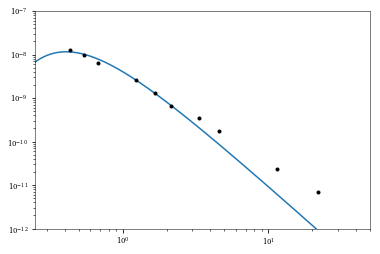

1516832608.94 105 8.76590476263
AWI00055xr J054733.26+521144.5
[  2.78605096e-09   2.61672358e-09   1.18152268e-09   6.12194805e-10
   3.65846172e-10   1.49586594e-10   7.75984715e-11   1.26871999e-11
   4.67287034e-12]
[  1.02641911e-10   5.54321040e-11   2.06762295e-11   1.29686018e-11
   6.06522199e-12   3.16880993e-12   1.50088750e-12   1.86965486e-13
   1.93674269e-13]
[ 9.986  9.697  8.788  8.699  8.508  8.169  7.898  7.028  5.964]
[ 0.04   0.023  0.019  0.023  0.018  0.023  0.021  0.016  0.045]
[ 27.14340512  47.20592195  57.14401078  47.20592195  60.31867804
  47.20592195  51.70172404  67.8585128   24.12747122]
6525.10926367 1.90565649776e-10
Fit W1 flux: 1.15847711416e-10
Observed W1 flux: 1.49586594169e-10
Observed W1 uncertainty: 3.16880992898e-12
Difference (Observed - Fit): 3.37388827531e-11
Significance: 10.6471778079
 
Fit K flux: 3.5197931264e-10
Observed K flux: 3.65846172446e-10
Observed K uncertainty: 6.06522198962e-12
Difference (Observed - Fit): 1.38668598053e-11
S

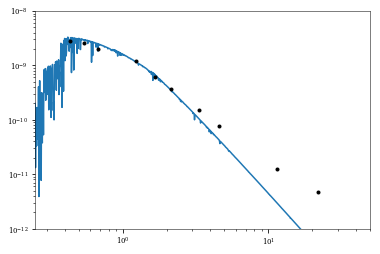

1516832621.5 106 8.80173584875
AWI0005zil J055417.57-383951.1
[  5.74101995e-10   3.81379941e-10   1.15569188e-10   6.63880084e-11
   4.47608696e-11   2.60430997e-11   1.89431922e-11   9.42249208e-12
   3.72892571e-12]
[  1.16328845e-10   5.30408499e-11   2.55463574e-12   1.58978600e-12
   9.48204543e-13   5.75677951e-13   3.48946497e-13   1.47533411e-13
   1.44247635e-13]
[ 11.701  11.788  11.312  11.111  10.789  10.067   9.429   7.351   6.209]
[ 0.22   0.151  0.024  0.026  0.023  0.024  0.02   0.017  0.042]
[  4.93516457   7.19030599  45.23900853  41.7590848   47.20592195
  45.23900853  54.28681024  63.86683557  25.85086202]
4996.42542788 8.22107290526e-11
Fit W1 flux: 1.47407537655e-11
Observed W1 flux: 2.60430997365e-11
Observed W1 uncertainty: 5.75677950994e-13
Difference (Observed - Fit): 1.1302345971e-11
Significance: 19.6331055436
 
Fit K flux: 4.16380483101e-11
Observed K flux: 4.47608696459e-11
Observed K uncertainty: 9.48204543004e-13
Difference (Observed - Fit): 3.122821335

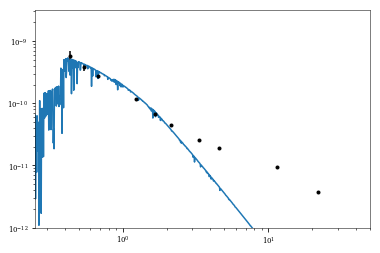

1516832634.26 107 8.83865420618
AWI0005wvr J055720.57-134921.9
[  1.40396005e-10   2.13423414e-10   1.80505168e-10   1.42461829e-10
   1.00668286e-10   5.73130033e-11   2.27701442e-11   4.56650283e-11]
[  1.44031748e-12   4.52111525e-12   3.65753088e-12   2.49303168e-12
   2.03981619e-12   1.00295731e-12   3.35553246e-13   9.25298997e-13]
[ 12.39503571  10.646       10.025        9.532        8.599        8.227
   6.393        3.489     ]
[ 0.01113853  0.023       0.022       0.019       0.022       0.019       0.016
  0.022     ]
[ 97.4757351   47.20592195  49.35164567  57.14401078  49.35164567
  57.14401078  67.8585128   49.35164567]
0.0 inf
Fit W1 flux: nan
Observed W1 flux: 1.00668285969e-10
Observed W1 uncertainty: 2.03981619256e-12
Difference (Observed - Fit): nan
Significance: nan
 
Fit K flux: nan
Observed K flux: 1.42461828991e-10
Observed K uncertainty: 2.49303167655e-12
Difference (Observed - Fit): nan
Significance: nan
False
Initial fit fail. Retrying with W1.
0.0 inf
Fitti

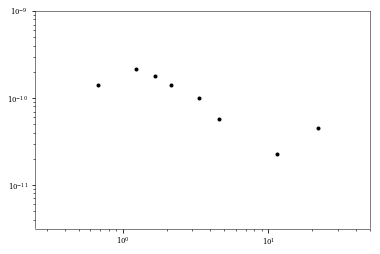

1516832643.68 108 8.84405555548
AWI0005ww1 J055804.52-141457.4
[  1.55359146e-10   9.74635133e-11   5.46625189e-11   2.83725595e-11
   9.88308827e-12   4.36770368e-12   5.66194676e-12   6.05318198e-12]
[  1.49565331e-12   1.88511148e-12   1.10761289e-12   6.79434419e-13
   2.09361196e-13   8.85016826e-14   9.90820680e-14   2.23007466e-13]
[ 12.28508052  11.497       11.322       11.284       11.119       11.022
   7.904        5.683     ]
[ 0.01045246  0.021       0.022       0.026       0.023       0.022       0.019
  0.04      ]
[ 103.87376871   51.70172404   49.35164567   41.7590848    47.20592195
   49.35164567   57.14401078   27.14340512]
5498.99612357 6.40399717651e-11
Fit W1 flux: 1.02932992183e-11
Observed W1 flux: 9.88308826772e-12
Observed W1 uncertainty: 2.09361195806e-13
Difference (Observed - Fit): -4.10210950558e-13
Significance: -1.95934566088
 
Fit K flux: 2.99294185321e-11
Observed K flux: 2.83725595181e-11
Observed K uncertainty: 6.79434419002e-13
Difference (Observed

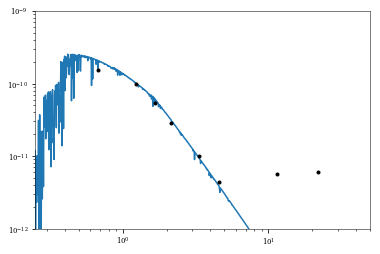

1516832659.35 109 8.90671559649
AWI0005wwi J055924.43-145421.8
[  1.61208916e-10   2.19057359e-10   7.99543436e-11   5.04533073e-11
   2.87937690e-11   1.64472265e-11   9.22684376e-12   5.45212471e-12
   7.56456102e-12]
[  4.45436695e-11   4.03518567e-11   1.76737613e-12   1.11526112e-12
   6.89521073e-13   3.48414475e-13   1.61466506e-13   1.05453441e-13
   2.15983764e-13]
[ 13.08   12.39   11.712  11.409  11.268  10.566  10.21    7.945   5.441]
[ 0.3    0.2    0.024  0.024  0.026  0.023  0.019  0.021  0.031]
[  3.61912068   5.42868102  45.23900853  45.23900853  41.7590848
  47.20592195  57.14401078  51.70172404  35.02374854]
5205.12398053 6.55953011622e-11
Fit W1 flux: 9.97016301734e-12
Observed W1 flux: 1.64472265332e-11
Observed W1 uncertainty: 3.48414475456e-13
Difference (Observed - Fit): 6.47706351588e-12
Significance: 18.5901102628
 
Fit K flux: 2.85248492438e-11
Observed K flux: 2.87937689699e-11
Observed K uncertainty: 6.89521073294e-13
Difference (Observed - Fit): 2.68919726

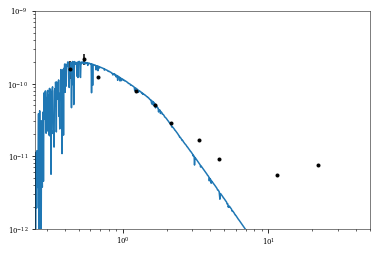

1516832669.81 110 8.9207818183
AWI0003lzu J060325.99+172444.3
[  4.08685337e-09   3.59217799e-09   1.32691182e-09   7.23251995e-10
   4.10864403e-10   1.80574559e-10   9.11702544e-11   1.24671097e-11
   3.31118717e-12]
[  1.43036980e-10   7.27874003e-11   2.32204880e-11   1.79857720e-11
   1.77857447e-11   3.66982154e-12   1.76338906e-12   1.95204751e-13
   2.01281262e-13]
[ 9.57        9.353       8.662       8.518       8.382       7.96459028
  7.723       7.047       6.338     ]
[ 0.038       0.022       0.019       0.027       0.047       0.02206545
  0.021       0.017       0.066     ]
[ 28.57200539  49.35164567  57.14401078  40.21245203  23.10077031
  49.20526983  51.70172404  63.86683557  16.45054856]
7198.38044436 1.83679160822e-10
Fit W1 flux: 1.22834943513e-10
Observed W1 flux: 1.80574558888e-10
Observed W1 uncertainty: 3.66982153531e-12
Difference (Observed - Fit): 5.77396153747e-11
Significance: 15.7336303194
 
Fit K flux: 3.8128591287e-10
Observed K flux: 4.10864402804e-10

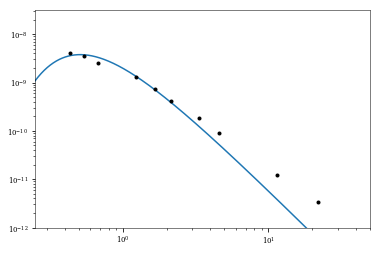

1516832670.74 111 8.84886486466
AWI0005ag4 J062612.83+473232.1
[  6.01712531e-10   5.83657200e-10   2.51676150e-10   1.81338342e-10
   1.71908961e-10   2.27937010e-10   2.13527181e-10   1.21385212e-10
   6.05875974e-11]
[  7.70334834e-11   4.73059969e-11   4.63604602e-12   3.00633813e-12
   3.16668009e-12   5.05933504e-12   4.12998183e-12   1.56519877e-12
   1.06026155e-12]
[ 11.65        11.326       10.467       10.02         9.328        7.71169457
   6.799        4.576        3.182     ]
[ 0.139       0.088       0.02        0.018       0.02        0.02409922
  0.021       0.014       0.019     ]
[  7.81105183  12.33791142  54.28681024  60.31867804  54.28681024
  45.05276042  51.70172404  77.55258605  57.14401078]
3008.67573752 2.64239626825e-10
Fit W1 flux: 6.54752994834e-11
Observed W1 flux: 2.27937009527e-10
Observed W1 uncertainty: 5.0593350419e-12
Difference (Observed - Fit): 1.62461710044e-10
Significance: 32.111277213
 
Fit K flux: 1.47339017741e-10
Observed K flux: 1.719089

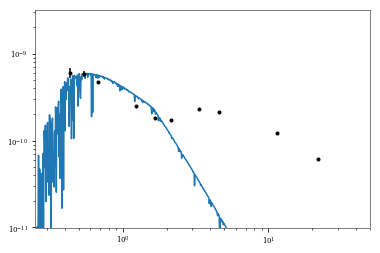

1516832683.72 112 8.88571428614
AWI0001a1v J064151.08+100144.6
[  3.33725242e-09   2.44657113e-09   4.73851285e-10   2.38610549e-10
   1.29687619e-10   5.05466845e-11   2.41798257e-11   7.04962120e-12
   6.30352864e-12]
[  3.07372307e-11   2.25337529e-11   1.17836954e-11   5.71397937e-12
   2.74727435e-12   1.02421477e-12   4.67679293e-13   1.36351762e-13
   2.49647871e-13]
[ 9.79   9.77   9.78   9.722  9.634  9.347  9.164  7.666  5.639]
[ 0.01   0.01   0.027  0.026  0.023  0.022  0.021  0.021  0.043]
[ 108.57362048  108.57362048   40.21245203   41.7590848    47.20592195
   49.35164567   51.70172404   51.70172404   25.24967918]
11240.8388773 7.49514649835e-11
Fit W1 flux: 3.58676578065e-11
Observed W1 flux: 5.05466844872e-11
Observed W1 uncertainty: 1.02421477136e-12
Difference (Observed - Fit): 1.46790266807e-11
Significance: 14.3319810367
 
Fit K flux: 1.19566164167e-10
Observed K flux: 1.29687618648e-10
Observed K uncertainty: 2.7472743525e-12
Difference (Observed - Fit): 1.01214544

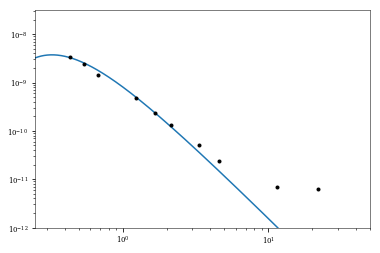

1516832687.17 113 8.83763716917
AWI0005d88 J083100.44+185806.0
[  2.35173865e-08   2.13480321e-08   6.26386029e-09   3.27860910e-09
   1.65081542e-09   5.31734453e-10   2.06373137e-10   1.49336436e-11
   3.39768983e-12]
[  4.98187209e-10   2.35947170e-10   1.84615313e-10   6.94533433e-11
   3.64909725e-11   1.72840228e-11   3.61145700e-12   2.20070304e-13
   2.22186547e-13]
[ 7.67        7.418       6.977       6.877       6.872       6.79199468
  6.836       6.851       6.31      ]
[ 0.023       0.012       0.032       0.023       0.024       0.03529184
  0.019       0.016       0.071     ]
[ 47.20592195  90.47801706  33.9292564   47.20592195  45.23900853
  30.76450765  57.14401078  67.8585128   15.29205922]
8194.73641206 3.49589519391e-10
Fit W1 flux: 5.27029744077e-10
Observed W1 flux: 5.3173445316e-10
Observed W1 uncertainty: 1.72840228484e-11
Difference (Observed - Fit): 4.70470908286e-12
Significance: 0.272199887962
 
Fit K flux: 1.67682684247e-09
Observed K flux: 1.65081541552e-

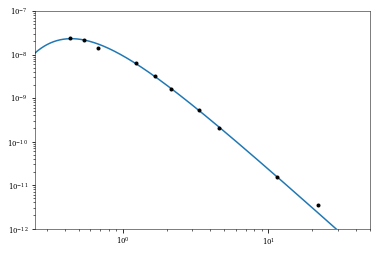

1516832694.13 114 8.82111403607
AWI0000s7e J103639.10+441425.8
[  4.82930850e-11   3.31468347e-11   2.13840342e-11   1.08667210e-11
   3.38604460e-12   1.33368469e-12   8.54605692e-13   3.32034897e-12]
[  4.65357235e-13   7.02175348e-13   4.72690160e-13   2.00172398e-13
   7.48478959e-14   3.07092249e-14   4.32916512e-14   1.74314802e-13]
[ 13.55371021  12.668       12.341       12.326       12.282       12.31
   9.957        6.335     ]
[ 0.01046227  0.023       0.024       0.02        0.024       0.025       0.055
  0.057     ]
[ 103.77637093   47.20592195   45.23900853   54.28681024   45.23900853
   43.42944819   19.74065827   19.04800359]
5161.01023826 4.06854601986e-11
Fit W1 flux: 3.78789820152e-12
Observed W1 flux: 3.3860445995e-12
Observed W1 uncertainty: 7.48478958627e-14
Difference (Observed - Fit): -4.01853602016e-13
Significance: -5.36893652634
 
Fit K flux: 1.08090609048e-11
Observed K flux: 1.08667209726e-11
Observed K uncertainty: 2.00172397769e-13
Difference (Observed -

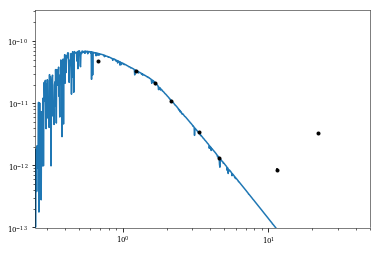

1516832706.1 115 8.84849565133
AWI000437j J110245.01-632940.4
[  3.66934930e-09   3.90263421e-09   1.72521038e-09   9.46432489e-10
   5.21072935e-10   1.60432619e-10   6.31325261e-11   4.77931638e-12
   1.92301969e-12]
[  1.04767464e-10   6.47002610e-11   3.33685271e-11   3.48678614e-11
   1.00784441e-11   3.39856977e-12   1.16294411e-12   8.36363482e-14
   9.56429957e-14]
[ 9.687  9.263  8.377  8.226  8.124  8.093  8.122  8.088  6.928]
[ 0.031  0.018  0.021  0.04   0.021  0.023  0.02   0.019  0.054]
[ 35.02374854  60.31867804  51.70172404  27.14340512  51.70172404
  47.20592195  54.28681024  57.14401078  20.10622601]
6498.36856933 2.31722564801e-10
Fit W1 flux: 1.70333115843e-10
Observed W1 flux: 1.60432619333e-10
Observed W1 uncertainty: 3.3985697709e-12
Difference (Observed - Fit): -9.90049651015e-12
Significance: -2.91313616537
 
Fit K flux: 5.17029718742e-10
Observed K flux: 5.21072934538e-10
Observed K uncertainty: 1.007844408e-11
Difference (Observed - Fit): 4.04321579591e-12
Si

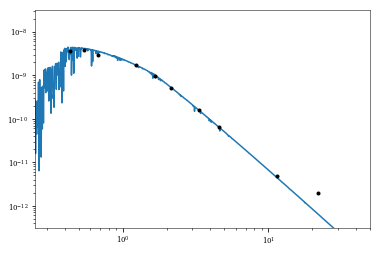

1516832719.07 116 8.88402586148
AWI0000y1k J111714.49-594610.8
[  2.99356751e-08   2.73248538e-08   8.53575738e-09   4.26274781e-09
   2.28506478e-09   7.17239462e-10   2.86369405e-10   2.31294753e-11
   6.60668698e-12]
[  5.51435513e-10   2.51671204e-10   1.65096185e-10   1.64897705e-10
   7.15571628e-11   2.33481081e-11   4.95471225e-12   4.26060681e-13
   2.49484327e-13]
[ 7.408       7.15        6.641       6.592       6.519       6.46707125
  6.48031637  6.376       5.588     ]
[ 0.02        0.01        0.021       0.042       0.034       0.03534369
  0.01878521  0.02        0.041     ]
[  54.28681024  108.57362048   51.70172404   25.85086202   31.93341779
   30.71938237   57.7973838    54.28681024   26.48137085]
7971.0595837 4.15228913931e-10
Fit W1 flux: 7.17462931281e-10
Observed W1 flux: 7.17239461918e-10
Observed W1 uncertainty: 2.33481081479e-11
Difference (Observed - Fit): -2.23469363729e-13
Significance: -0.00957119790233
 
Fit K flux: 2.27142794449e-09
Observed K flux: 2.

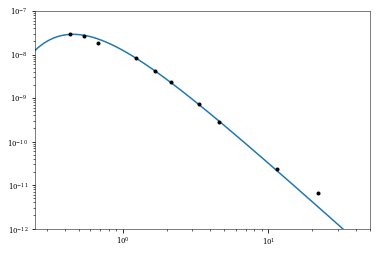

1516832723.65 117 8.84723076861
AWI0005cwg J111925.92-301922.9
[  1.93637317e-08   1.31995111e-08   2.46627819e-09   1.14416759e-09
   5.69244071e-10   1.69860608e-10   6.64130104e-11   7.36827424e-12
   4.15703547e-12]
[  3.92362431e-10   1.45886389e-10   6.81457848e-11   4.95294127e-11
   1.73016744e-11   3.59829023e-12   1.22337286e-12   1.35728627e-13
   2.52698897e-13]
[ 7.881  7.94   7.989  8.02   8.028  8.031  8.067  7.618  6.091]
[ 0.022  0.012  0.03   0.047  0.033  0.023  0.02   0.02   0.066]
[ 49.35164567  90.47801706  36.19120683  23.10077031  32.90109711
  47.20592195  54.28681024  54.28681024  16.45054856]
12543.8732555 1.51224708634e-10
Fit W1 flux: 1.66402108882e-10
Observed W1 flux: 1.69860607953e-10
Observed W1 uncertainty: 3.59829023459e-12
Difference (Observed - Fit): 3.45849907126e-12
Significance: 0.961150670397
 
Fit K flux: 5.61752973907e-10
Observed K flux: 5.6924407078e-10
Observed K uncertainty: 1.73016744338e-11
Difference (Observed - Fit): 7.49109687252e-12


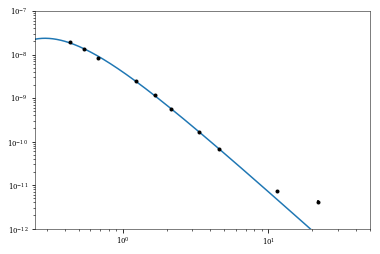

1516832728.99 118 8.81753389916
AWI0005da8 J112256.98-203731.7
[  2.34524952e-08   2.04248016e-08   5.42552867e-09   2.68961204e-09
   1.41546298e-09   4.39591934e-10   1.74844980e-10   1.29230725e-11
   2.98114933e-12]
[  4.75212020e-10   2.06931312e-10   9.99419314e-11   1.16429539e-10
   2.73774813e-11   1.46834416e-11   3.38180173e-12   2.02344024e-13
   1.81218840e-13]
[ 7.673      7.466      7.133      7.092      7.039      6.9986074  7.016
  7.008      6.452    ]
[ 0.022       0.011       0.02        0.047       0.021       0.03626623
  0.021       0.017       0.066     ]
[ 49.35164567  98.70329134  54.28681024  23.10077031  51.70172404
  29.93793601  51.70172404  63.86683557  16.45054856]
8787.66066596 3.04740971649e-10
Fit W1 flux: 4.37766449731e-10
Observed W1 flux: 4.39591934042e-10
Observed W1 uncertainty: 1.46834415675e-11
Difference (Observed - Fit): 1.82548431102e-12
Significance: 0.124322646202
 
Fit K flux: 1.40938854794e-09
Observed K flux: 1.41546298131e-09
Observed 

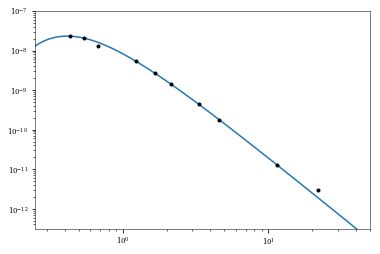

1516832732.63 119 8.77403361457
AWI00043e8 J113252.86-652033.1
[  1.36912173e-09   1.92171792e-09   1.41285800e-09   5.01054661e-10
   1.93131524e-10   2.25613863e-11   4.58758084e-12]
[  3.02641851e-11   4.60191580e-11   3.38335481e-11   1.39560183e-11
   3.37973343e-12   3.32476875e-13   1.85913997e-13]
[ 8.628       7.457       7.041       6.85651892  6.908       6.403       5.984     ]
[ 0.024       0.026       0.026       0.03024132  0.019       0.016       0.044     ]
[ 45.23900853  41.7590848   41.7590848   35.90240786  57.14401078
  67.8585128   24.67582284]
2570.71642898 9.28841745406e-10
Fit W1 flux: 5.93908217374e-10
Observed W1 flux: 5.01054660643e-10
Observed W1 uncertainty: 1.39560182884e-11
Difference (Observed - Fit): -9.28535567308e-11
Significance: -6.65329858502
 
Fit K flux: 1.20201836444e-09
Observed K flux: 1.41285800215e-09
Observed K uncertainty: 3.38335480524e-11
Difference (Observed - Fit): 2.10839637715e-10
Significance: 6.23167388143
True
K excess detected. 

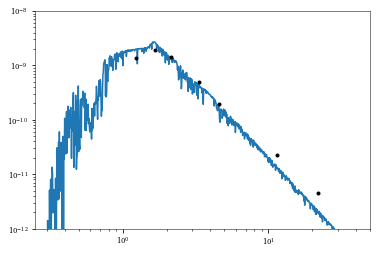

1516832747.29 120 8.823058333
AWI0002dmo J113505.30-554840.3
[  6.08399791e-10   1.02933762e-09   1.37164607e-09   1.07668742e-09
   6.71890523e-10   3.33464712e-10   2.85626943e-10   3.16348501e-10
   1.46414379e-10]
[  6.05185469e-11   5.97274642e-11   2.52666543e-11   3.76832990e-11
   1.79461872e-11   8.65151559e-12   4.94478496e-12   3.49641285e-12
   2.02278940e-12]
[ 11.638       10.71         8.626        8.086        7.848        7.29860698
   6.48313499   3.536        2.224     ]
[ 0.108       0.063       0.02        0.038       0.029       0.02816869
  0.01879631  0.012       0.015     ]
[ 10.05311301  17.23390801  54.28681024  28.57200539  37.43917947
  38.54408036  57.76326883  90.47801706  72.38241365]
4082.06291422 3.84830622224e-10
Fit W1 flux: 2.36075797752e-10
Observed W1 flux: 3.33464712323e-10
Observed W1 uncertainty: 8.65151559472e-12
Difference (Observed - Fit): 9.7388914571e-11
Significance: 11.256861703
 
Fit K flux: 6.19506147829e-10
Observed K flux: 6.71890523

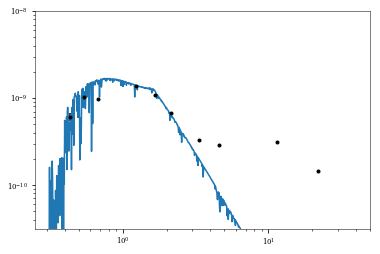

1516832760.37 121 8.85823967043
AWI0005x9h J114336.83-802900.5
[  5.90730040e-08   4.49322170e-08   1.28837433e-08   6.26454654e-09
   3.31206244e-09   1.04569698e-09   4.18698526e-10   3.24612905e-11
   7.15786875e-12]
[  5.44082474e-10   4.13841012e-10   2.25460956e-10   2.30794424e-10
   7.01620115e-11   5.06674629e-11   7.67523936e-12   4.78367255e-13
   2.04371863e-13]
[ 6.67        6.61        6.194       6.174       6.116       6.05771705
  6.06787934  6.008       5.501     ]
[ 0.01        0.01        0.019       0.04        0.023       0.0526075
  0.01990283  0.016       0.031     ]
[ 108.57362048  108.57362048   57.14401078   27.14340512   47.20592195
   20.63843186   54.5518526    67.8585128    35.02374854]
9085.62036225 4.43958510623e-10
Fit W1 flux: 9.68958266171e-10
Observed W1 flux: 1.04569698121e-09
Observed W1 uncertainty: 5.06674629421e-11
Difference (Observed - Fit): 7.67387150354e-11
Significance: 1.51455609931
 
Fit K flux: 3.13617820173e-09
Observed K flux: 3.31206

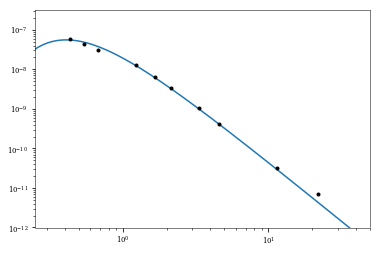

1516832769.18 122 8.85786885316
AWI0002dny J114401.39-552327.0
[  6.60372617e-09   5.58930549e-09   1.63697506e-09   8.11502085e-10
   4.07097575e-10   1.27788765e-10   5.02867035e-11   4.09040001e-12
   1.35638735e-12]
[  1.58138671e-10   7.20711684e-11   4.37235827e-11   2.01803681e-11
   1.16234724e-11   2.58935165e-12   9.26315311e-13   7.15805551e-14
   1.03690150e-13]
[ 9.049  8.873  8.434  8.393  8.392  8.34   8.369  8.257  7.307]
[ 0.026  0.014  0.029  0.027  0.031  0.022  0.02   0.019  0.083]
[ 41.7590848   77.55258605  37.43917947  40.21245203  35.02374854
  49.35164567  54.28681024  57.14401078  13.08115909]
8488.81321886 1.69838404067e-10
Fit W1 flux: 1.30131259406e-10
Observed W1 flux: 1.27788765347e-10
Observed W1 uncertainty: 2.58935165403e-12
Difference (Observed - Fit): -2.34249405896e-12
Significance: -0.904664322174
 
Fit K flux: 4.16561314374e-10
Observed K flux: 4.07097575318e-10
Observed K uncertainty: 1.16234724232e-11
Difference (Observed - Fit): -9.46373905682e

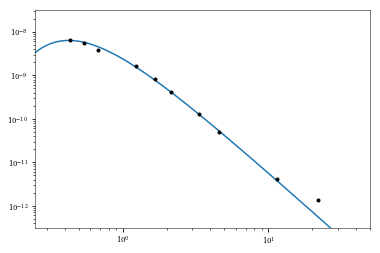

1516832773.91 123 8.82434959334
AWI00056ck J121456.32-475654.6
[  1.21727599e-08   1.14224127e-08   3.77434906e-09   1.87797428e-09
   1.00022687e-09   3.10218371e-10   1.22307522e-10   1.01243181e-11
   5.29643602e-12]
[  2.46653577e-10   1.15724740e-10   8.34312949e-11   6.57277729e-11
   2.11885887e-11   7.75819405e-12   2.14033842e-12   1.49197465e-13
   1.80493321e-13]
[ 8.385      8.097      7.527      7.482      7.416      7.3770629  7.404
  7.273      5.828    ]
[ 0.022       0.011       0.024       0.038       0.023       0.02715298
  0.019       0.016       0.037     ]
[ 49.35164567  98.70329134  45.23900853  28.57200539  47.20592195
  39.98589992  57.14401078  67.8585128   29.34422175]
7743.44588803 2.82232169443e-10
Fit W1 flux: 3.19230629869e-10
Observed W1 flux: 3.10218370896e-10
Observed W1 uncertainty: 7.75819405203e-12
Difference (Observed - Fit): -9.01225897336e-12
Significance: -1.16164392292
 
Fit K flux: 1.00524772999e-09
Observed K flux: 1.00022686656e-09
Observed

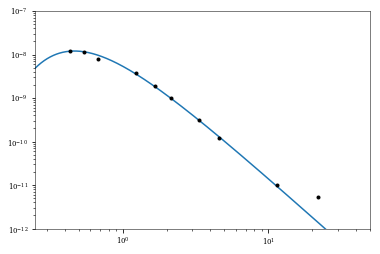

1516832779.48 124 8.79804838665
AWI00056i5 J132026.77-491325.4
[  1.45542241e-08   1.31026110e-08   3.95222865e-09   2.03464966e-09
   1.07077572e-09   3.29472151e-10   1.30212647e-10   1.03315571e-11
   3.24775852e-12]
[  3.08313522e-10   1.44815408e-10   1.23764662e-10   7.87072268e-11
   2.86004057e-11   8.24215807e-12   2.27867532e-12   1.52251452e-13
   1.34608326e-13]
[ 8.191       7.948       7.477       7.395       7.342       7.31168491
  7.336       7.251       6.359     ]
[ 0.023       0.012       0.034       0.042       0.029       0.02716105
  0.019       0.016       0.045     ]
[ 47.20592195  90.47801706  31.93341779  25.85086202  37.43917947
  39.97401502  57.14401078  67.8585128   24.12747122]
8096.79421922 2.8006193561e-10
Fit W1 flux: 3.33048535235e-10
Observed W1 flux: 3.29472150523e-10
Observed W1 uncertainty: 8.24215807021e-12
Difference (Observed - Fit): -3.57638471275e-12
Significance: -0.433913628237
 
Fit K flux: 1.05738598271e-09
Observed K flux: 1.07077572194

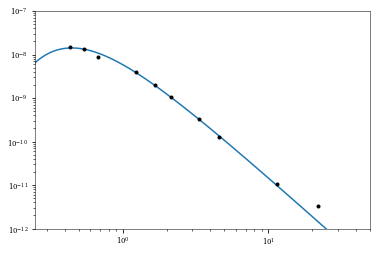

1516832782.96 125 8.75554400063
AWI0000wqx J132217.71+623337.9
[  3.30970325e-10   6.31186712e-10   6.76771501e-10   5.24432551e-10
   2.91137746e-10   9.42958705e-11   4.04252921e-11   1.76264877e-11
   1.05289177e-11]
[  5.57847930e-11   4.94142779e-11   1.30899214e-11   1.35245664e-11
   6.43554657e-12   1.99754325e-12   7.44661400e-13   2.43518926e-13
   2.52134781e-13]
[ 12.299  11.241   9.393   8.867   8.756   8.67    8.606   6.671   5.082]
[ 0.183  0.085  0.021  0.028  0.024  0.023  0.02   0.015  0.026]
[  5.93298473  12.77336711  51.70172404  38.77629303  45.23900853
  47.20592195  54.28681024  72.38241365  41.7590848 ]
0.0 inf
Fit W1 flux: nan
Observed W1 flux: 9.42958705123e-11
Observed W1 uncertainty: 1.99754324511e-12
Difference (Observed - Fit): nan
Significance: nan
 
Fit K flux: nan
Observed K flux: 2.91137746244e-10
Observed K uncertainty: 6.43554657128e-12
Difference (Observed - Fit): nan
Significance: nan
False
Initial fit fail. Retrying with W1.
4474.58479987 2.34014

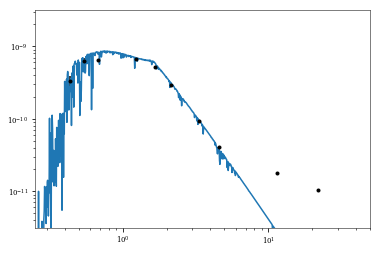

1516832802.56 126 8.84161904691
AWI0005f32 J134909.18-541342.3
[  4.76638431e-09   5.48223751e-09   2.58488998e-09   1.51806246e-09
   8.20537655e-10   2.61626456e-10   1.03813341e-10   7.95363728e-12
   1.86888996e-12]
[  1.14140057e-10   7.57399103e-11   5.71385196e-11   5.87238622e-11
   1.73820915e-11   6.05320466e-12   1.91231241e-12   1.24534701e-13
   1.22213100e-13]
[ 9.403       8.894       7.938       7.713       7.631       7.56202754
  7.582       7.535       6.959     ]
[ 0.026       0.015       0.024       0.042       0.023       0.02512049
  0.02        0.017       0.071     ]
[ 41.7590848   72.38241365  45.23900853  25.85086202  47.20592195
  43.22114819  54.28681024  63.86683557  15.29205922]
6207.84106284 3.0095656844e-10
Fit W1 flux: 2.6979777419e-10
Observed W1 flux: 2.61626455509e-10
Observed W1 uncertainty: 6.05320465728e-12
Difference (Observed - Fit): -8.17131868096e-12
Significance: -1.34991614254
 
Fit K flux: 8.10048051961e-10
Observed K flux: 8.2053765466e-1

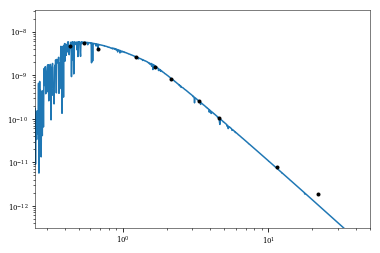

1516832815.52 127 8.87400787459
AWI0005f42 J135331.70-523004.9
[  1.26063412e-08   9.75793334e-09   2.41903450e-09   1.16758805e-09
   6.09956011e-10   1.95689286e-10   7.70997850e-11   5.80986152e-12
   1.39054078e-12]
[  2.55439125e-10   1.07848665e-10   4.01042360e-11   2.58093200e-11
   1.34829659e-11   3.97858541e-12   1.42023052e-12   1.01670524e-13
   9.47744189e-14]
[ 8.347       8.268       8.01        7.998       7.953       7.87731406
  7.905       7.876       7.28      ]
[ 0.022       0.012       0.018       0.024       0.024       0.02207425
  0.02        0.019       0.074     ]
[ 49.35164567  90.47801706  60.31867804  45.23900853  45.23900853
  49.18564412  54.28681024  57.14401078  14.67211088]
9500.02364147 1.88735586938e-10
Fit W1 flux: 1.8514818573e-10
Observed W1 flux: 1.9568928622e-10
Observed W1 uncertainty: 3.97858541274e-12
Difference (Observed - Fit): 1.05411004898e-11
Significance: 2.64945939227
 
Fit K flux: 6.03344111767e-10
Observed K flux: 6.09956011233e-10

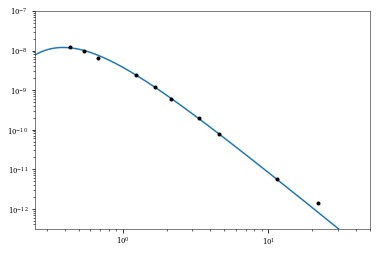

1516832821.58 128 8.85204687528
AWI0005f4c J135518.84-533142.8
[  1.20057434e-08   1.07884200e-08   3.13647668e-09   1.56779632e-09
   7.69304930e-10   2.54227649e-10   1.07610133e-10   2.80650475e-11
   2.45914270e-11]
[  2.32211664e-10   1.09301523e-10   6.64424408e-11   2.59918879e-11
   1.62967886e-11   5.88118503e-12   1.98225190e-12   4.13581824e-13
   5.20939449e-13]
[ 8.4         8.159       7.728       7.678       7.701       7.59317473
  7.543       6.166       4.161     ]
[ 0.021       0.011       0.023       0.018       0.023       0.02511692
  0.02        0.016       0.023     ]
[ 51.70172404  98.70329134  47.20592195  60.31867804  47.20592195
  43.22728283  54.28681024  67.8585128   47.20592195]
8424.56923321 2.37207316779e-10
Fit W1 flux: 2.51395966937e-10
Observed W1 flux: 2.54227648847e-10
Observed W1 uncertainty: 5.88118503362e-12
Difference (Observed - Fit): 2.83168191001e-12
Significance: 0.481481520105
 
Fit K flux: 8.03702015027e-10
Observed K flux: 7.69304930261e

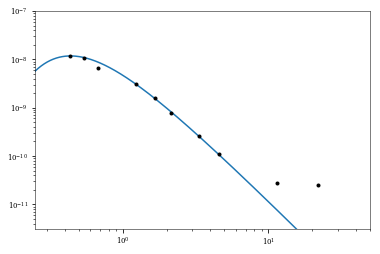

1516832825.6 129 8.81455814007
AWI0005f5v J140353.79-534628.3
[  1.39633317e-08   1.28516192e-08   3.93769489e-09   2.06105528e-09
   1.09874906e-09   3.37505898e-10   1.33368469e-10   9.85747720e-12
   4.40132796e-12]
[  2.70074780e-10   1.30204565e-10   6.52815184e-11   6.26439681e-11
   1.72037498e-11   9.06962769e-12   2.45673799e-12   1.54344224e-13
   1.86473552e-13]
[ 8.236       7.969       7.481       7.381       7.314       7.28552827
  7.31        7.302       6.029     ]
[ 0.021       0.011       0.018       0.033       0.017       0.02917645
  0.02        0.017       0.046     ]
[ 51.70172404  98.70329134  60.31867804  32.90109711  63.86683557
  37.21276214  54.28681024  63.86683557  23.60296097]
7912.79671563 2.88240919224e-10
Fit W1 flux: 3.42460711989e-10
Observed W1 flux: 3.37505897868e-10
Observed W1 uncertainty: 9.06962768735e-12
Difference (Observed - Fit): -4.95481412108e-12
Significance: -0.546308436453
 
Fit K flux: 1.08274828147e-09
Observed K flux: 1.09874905794

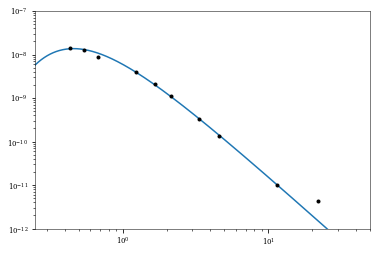

1516832829.27 130 8.775
AWI0000us7 J142409.74+581826.3
[  8.53078617e-11   2.48289210e-10   1.13146744e-09   1.10481520e-09
   6.91350873e-10   2.30267766e-10   1.13619577e-10   1.35695605e-11
   2.95653981e-12]
[  7.18928715e-11   1.99182731e-10   2.70951207e-11   2.95095997e-11
   1.33719114e-11   5.32429846e-12   2.09294995e-12   1.99968433e-13
   1.41599837e-13]
[ 13.771       12.254        8.835        8.058        7.817        7.70064882
   7.484        6.955        6.461     ]
[ 0.915       0.871       0.026       0.029       0.021       0.02510462
  0.02        0.016       0.052     ]
[  1.18659695   1.24653984  41.7590848   37.43917947  51.70172404
  43.24847064  54.28681024  67.8585128   20.8795424 ]
3029.98946699 5.75497935215e-10
Fit W1 flux: 3.14713683948e-10
Observed W1 flux: 2.30267765735e-10
Observed W1 uncertainty: 5.3242984625e-12
Difference (Observed - Fit): -8.44459182136e-11
Significance: -15.8604779218
 
Fit K flux: 7.11233834559e-10
Observed K flux: 6.91350873216

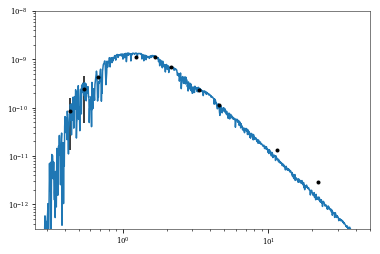

1516832843.79 131 8.81883969562
AWI0005av7 J143944.28-402206.3
[  4.46466684e-09   4.83234405e-09   2.07989812e-09   1.16543925e-09
   6.41059759e-10   1.98971854e-10   8.02145528e-11   6.23685692e-12
   1.64128398e-12]
[  1.15139083e-10   7.12120536e-11   5.17227380e-11   4.93768240e-11
   1.41705086e-11   4.22955110e-12   1.47760667e-12   1.14887150e-13
   1.48144484e-13]
[ 9.474       9.031       8.174       8.          7.899       7.85925257
  7.862       7.799       7.1       ]
[ 0.028       0.016       0.027       0.046       0.024       0.02307953
  0.02        0.02        0.098     ]
[ 38.77629303  67.8585128   40.21245203  23.60296097  45.23900853
  47.04325578  54.28681024  54.28681024  11.07894086]
6519.07603011 2.55296520396e-10
Fit W1 flux: 2.07653654364e-10
Observed W1 flux: 1.98971854253e-10
Observed W1 uncertainty: 4.22955110079e-12
Difference (Observed - Fit): -8.68180011104e-12
Significance: -2.05265284758
 
Fit K flux: 6.30777719091e-10
Observed K flux: 6.41059758678

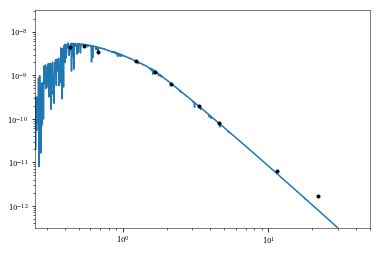

1516832852.99 132 8.82175757668
AWI0000w9x J144313.04+014928.7
[  3.18998805e-08   2.32358116e-08   4.82660838e-09   2.22479316e-09
   1.16331818e-09   3.54497307e-10   1.39911421e-10   1.11523344e-11
   3.08165297e-12]
[  5.87617515e-10   2.35410707e-10   1.06691294e-10   9.63081805e-11
   2.25005685e-11   9.52853779e-12   2.57726361e-12   1.74618552e-13
   1.44753671e-13]
[ 7.339       7.326       7.26        7.298       7.252       7.23219934
  7.258       7.168       6.416     ]
[ 0.02        0.011       0.024       0.047       0.021       0.02918352
  0.02        0.017       0.051     ]
[ 54.28681024  98.70329134  45.23900853  23.10077031  51.70172404
  37.20374672  54.28681024  63.86683557  21.28894519]
11066.4814556 2.34602668764e-10
Fit W1 flux: 3.44848730125e-10
Observed W1 flux: 3.54497306746e-10
Observed W1 uncertainty: 9.52853779413e-12
Difference (Observed - Fit): 9.64857662169e-12
Significance: 1.01259782247
 
Fit K flux: 1.14734943203e-09
Observed K flux: 1.16331818146e-

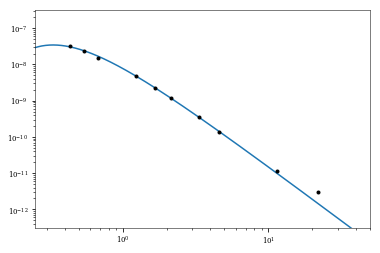

1516832857.02 133 8.78573684226
AWI0005cyr J144458.63-280251.9
[  5.85314195e-09   7.87331899e-09   5.39562878e-09   3.41735141e-09
   1.89015977e-09   6.03905539e-10   2.30066384e-10   1.81036348e-11
   3.74613764e-12]
[  1.40164517e-10   1.08773922e-10   9.93911551e-11   1.13309891e-10
   3.48180297e-11   2.18870359e-11   4.02608044e-12   2.83459086e-13
   1.75966334e-13]
[ 9.18        8.501       7.139       6.832       6.725       6.65380915
  6.718       6.642       6.204     ]
[ 0.026       0.015       0.02        0.036       0.02        0.03934978
  0.019       0.017       0.051     ]
[ 41.7590848   72.38241365  54.28681024  30.15933902  54.28681024
  27.59192889  57.14401078  63.86683557  21.28894519]
5298.51959356 5.22986185498e-10
Fit W1 flux: 6.50496103347e-10
Observed W1 flux: 6.03905538594e-10
Observed W1 uncertainty: 2.18870359138e-11
Difference (Observed - Fit): -4.65905647528e-11
Significance: -2.12868315912
 
Fit K flux: 1.87107807267e-09
Observed K flux: 1.89015977121

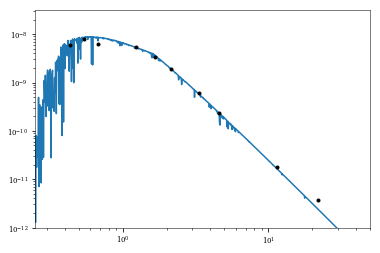

1516832868.91 134 8.80891791031
AWI0000vag J145820.26+150229.3
[  1.92840350e-09   4.11568438e-09   4.34199821e-09   2.61636611e-09
   9.36843926e-10   3.75231398e-10   3.50724239e-11   6.33262441e-12]
[  2.67723584e-11   7.58137080e-11   7.99825628e-11   4.81952449e-11
   4.18789099e-11   6.72928374e-12   4.52240546e-13   2.21637380e-13]
[ 9.55042781  7.433       6.572       6.372       6.17706357  6.18688499
  5.924       5.634     ]
[ 0.01507346  0.02        0.02        0.02        0.04853471  0.01947126
  0.014       0.038     ]
[ 72.02964606  54.28681024  54.28681024  54.28681024  22.37030356
  55.76097143  77.55258605  28.57200539]
3026.52486569 1.11272651115e-09
Fit W1 flux: 1.17401897513e-09
Observed W1 flux: 9.36843926494e-10
Observed W1 uncertainty: 4.18789098706e-11
Difference (Observed - Fit): -2.37175048637e-10
Significance: -5.66335297097
 
Fit K flux: 2.65138105238e-09
Observed K flux: 2.61636611406e-09
Observed K uncertainty: 4.81952448964e-11
Difference (Observed - Fit

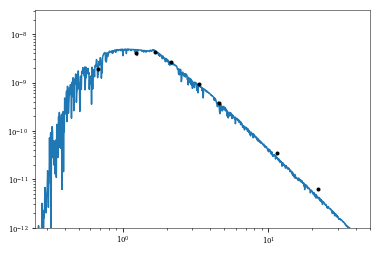

1516832883.7 135 8.85319999942
AWI0000uji J151147.67+101259.8
[  4.67938799e-08   3.52012307e-08   7.37975701e-09   3.54559920e-09
   1.77540940e-09   5.63255096e-10   2.18702208e-10   1.69108634e-11
   3.49609907e-12]
[  9.05073879e-10   3.89058379e-10   1.22346133e-10   1.43687172e-10
   3.43394623e-11   2.04067828e-11   4.23007572e-12   2.49207692e-13
   1.77101443e-13]
[ 6.923       6.875       6.799       6.792       6.793       6.72946886
  6.773       6.716       6.279     ]
[ 0.021       0.012       0.018       0.044       0.021       0.03933632
  0.021       0.016       0.055     ]
[ 51.70172404  90.47801706  60.31867804  24.67582284  51.70172404
  27.60136672  51.70172404  67.8585128   19.74065827]
10843.3218523 2.95947621894e-10
Fit W1 flux: 5.35423947665e-10
Observed W1 flux: 5.63255096018e-10
Observed W1 uncertainty: 2.04067828141e-11
Difference (Observed - Fit): 2.7831148353e-11
Significance: 1.36381852086
 
Fit K flux: 1.77684662717e-09
Observed K flux: 1.77540940316e-09

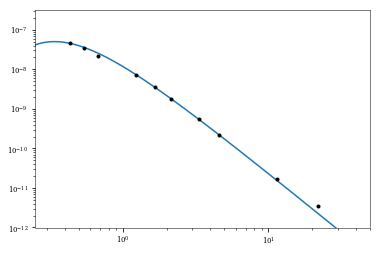

1516832886.58 136 8.80924264648
AWI0000qxd J152527.16+284914.6
[  4.05685099e-10   7.04300257e-10   7.08014354e-10   5.48642744e-10
   3.04297592e-10   1.01880877e-10   3.84993296e-11   6.20248584e-12
   1.06459330e-12]
[  5.26846196e-11   4.60566002e-11   1.17378957e-11   8.59041691e-12
   5.88563723e-12   2.15822237e-12   7.44643052e-13   1.02828610e-13
   8.92279269e-14]
[ 12.078  11.122   9.344   8.818   8.708   8.586   8.659   7.805   7.57 ]
[ 0.141  0.071  0.018  0.017  0.021  0.023  0.021  0.018  0.091]
[  7.70025677  15.29205922  60.31867804  63.86683557  51.70172404
  47.20592195  51.70172404  60.31867804  11.93116709]
4293.49735381 2.58459266862e-10
Fit W1 flux: 1.15443693623e-10
Observed W1 flux: 1.01880876858e-10
Observed W1 uncertainty: 2.15822237249e-12
Difference (Observed - Fit): -1.3562816765e-11
Significance: -6.28425362366
 
Fit K flux: 3.09120459947e-10
Observed K flux: 3.04297592037e-10
Observed K uncertainty: 5.88563723377e-12
Difference (Observed - Fit): -4.82286

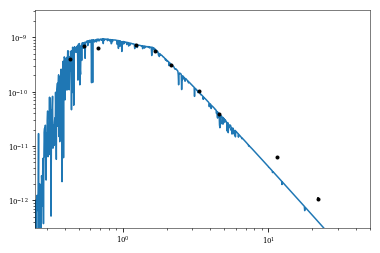

1516832901.45 137 8.85352554809
AWI0000v1z J152954.11+234901.6
[  2.11733246e-08   1.83044990e-08   5.47068945e-09   2.67478969e-09
   1.35300224e-09   4.17724357e-10   1.64230255e-10   1.21161818e-11
   2.40981515e-12]
[  4.09528406e-10   1.85449733e-10   1.20928589e-10   5.17350192e-11
   2.49232223e-11   1.27870481e-11   3.02523309e-12   1.78550653e-13
   1.46488437e-13]
[ 7.784       7.585       7.124       7.098       7.088       7.05400719
  7.084       7.078       6.683     ]
[ 0.021      0.011      0.024      0.021      0.02       0.0332357  0.02
  0.016      0.066    ]
[ 51.70172404  98.70329134  45.23900853  51.70172404  54.28681024
  32.66777083  54.28681024  67.8585128   16.45054856]
8414.2108309 3.11170542303e-10
Fit W1 flux: 4.31933577573e-10
Observed W1 flux: 4.17724357078e-10
Observed W1 uncertainty: 1.27870481057e-11
Difference (Observed - Fit): -1.42092204953e-11
Significance: -1.11121975751
 
Fit K flux: 1.38058282681e-09
Observed K flux: 1.35300224035e-09
Observed K

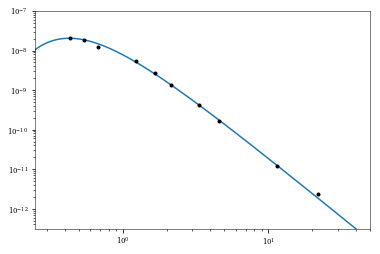

1516832906.55 138 8.82628985592
AWI0000t35 J153456.23+335145.2
[  1.78206934e-10   3.62111287e-10   3.71954348e-10   2.28296112e-10
   7.77128210e-11   3.10351013e-11   4.63623863e-12   1.24504122e-12]
[  1.78302541e-12   7.00385324e-12   7.53681753e-12   3.57456433e-12
   1.64625152e-12   5.71687692e-13   7.68624045e-14   1.14672534e-13]
[ 12.13611109  10.072        9.24         9.02         8.88         8.893
   8.121        7.4       ]
[ 0.01086319  0.021       0.022       0.017       0.023       0.02        0.018
  0.1       ]
[ 99.94637897  51.70172404  49.35164567  63.86683557  47.20592195
  54.28681024  60.31867804  10.85736205]
3127.28393226 3.02983648112e-10
Fit W1 flux: 9.24967752179e-11
Observed W1 flux: 7.77128209776e-11
Observed W1 uncertainty: 1.64625152468e-12
Difference (Observed - Fit): -1.47839542403e-11
Significance: -8.98037390927
 
Fit K flux: 2.12976971721e-10
Observed K flux: 2.28296112223e-10
Observed K uncertainty: 3.57456432859e-12
Difference (Observed - Fit):

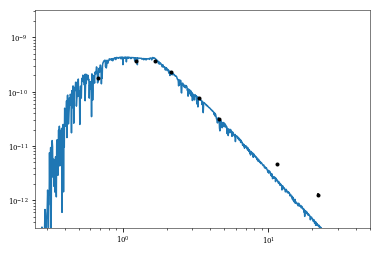

1516832923.02 139 8.88128057487
AWI0000tpu J153716.27+331834.4
[  2.04450914e-10   3.75454961e-10   3.87295154e-10   3.00392884e-10
   1.67995835e-10   5.54744077e-11   2.21132801e-11   4.28317463e-12
   1.04323880e-12]
[  5.25374439e-11   5.04877926e-11   7.49095240e-12   5.25676934e-12
   2.78513789e-12   1.17515781e-12   4.07341673e-13   7.10090932e-14
   9.70467028e-14]
[ 12.822  11.805   9.999   9.472   9.353   9.246   9.261   8.207   7.592]
[ 0.279  0.146  0.021  0.019  0.018  0.023  0.02   0.018  0.101]
[  3.89152762   7.43654935  51.70172404  57.14401078  60.31867804
  47.20592195  54.28681024  60.31867804  10.74986341]
4119.85051868 2.01095887747e-10
Fit W1 flux: 6.5429731641e-11
Observed W1 flux: 5.54744077229e-11
Observed W1 uncertainty: 1.17515780724e-12
Difference (Observed - Fit): -9.95532391812e-12
Significance: -8.4714783468
 
Fit K flux: 1.72349560588e-10
Observed K flux: 1.67995835391e-10
Observed K uncertainty: 2.78513788505e-12
Difference (Observed - Fit): -4.353725

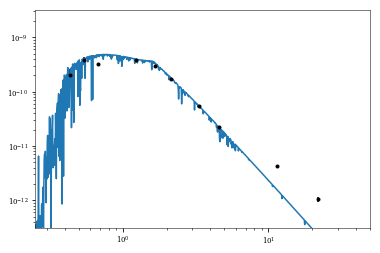

1516832939.14 140 8.93303571429
AWI00005x2 J153910.61-154639.2
[  7.92131007e-11   1.21798534e-10   1.06583417e-10   8.16767627e-11
   2.58043352e-11   1.41596711e-11   1.15602115e-11   1.13653740e-11]
[  8.35923874e-13   2.69233430e-12   2.65050779e-12   1.57976865e-12
   5.46633433e-13   2.47789242e-13   1.91652269e-13   3.14036888e-13]
[ 13.01643005  11.255       10.597       10.136       10.077        9.745
   7.129        4.999     ]
[ 0.01145761  0.024       0.027       0.021       0.023       0.019       0.018
  0.03      ]
[ 94.7611417   45.23900853  40.21245203  51.70172404  47.20592195
  57.14401078  60.31867804  36.19120683]
0.0 inf
Fit W1 flux: nan
Observed W1 flux: 2.58043351629e-11
Observed W1 uncertainty: 5.46633432823e-13
Difference (Observed - Fit): nan
Significance: nan
 
Fit K flux: nan
Observed K flux: 8.1676762659e-11
Observed K uncertainty: 1.5797686476e-12
Difference (Observed - Fit): nan
Significance: nan
False
Initial fit fail. Retrying with W1.
0.0 inf
Fitting

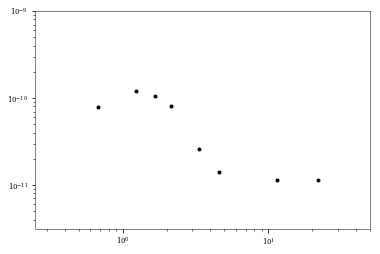

1516832949.15 141 8.94060992856
AWI0000tz1 J154030.20+370101.1
[  3.71697000e-08   2.69499428e-08   5.54679432e-09   2.58993962e-09
   1.28498635e-09   3.92556807e-10   1.52143417e-10   1.16135711e-11
   3.17968231e-12]
[  6.50456619e-10   2.48218146e-10   1.17502086e-10   9.06460568e-11
   2.84043881e-11   1.09208743e-11   2.80258532e-12   1.71143908e-13
   1.40572590e-13]
[ 7.173      7.165      7.109      7.133      7.144      7.1214754  7.167
  7.124      6.382    ]
[ 0.019       0.01        0.023       0.038       0.024       0.03020503
  0.02        0.016       0.048     ]
[  57.14401078  108.57362048   47.20592195   28.57200539   45.23900853
   35.94554776   54.28681024   67.8585128    22.61950427]
11316.215577 2.45140593419e-10
Fit W1 flux: 3.86779412092e-10
Observed W1 flux: 3.92556807297e-10
Observed W1 uncertainty: 1.09208742593e-11
Difference (Observed - Fit): 5.77739520529e-12
Significance: 0.5290231412
 
Fit K flux: 1.29039435675e-09
Observed K flux: 1.28498635414e-09
Obs

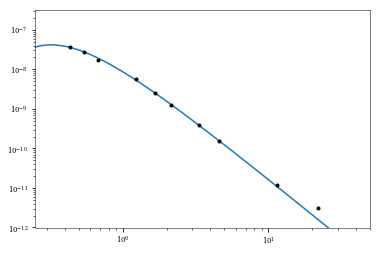

1516832954.37 142 8.91451408494
AWI0005dyy J154709.73+303356.0
[  2.21100160e-08   1.52530905e-08   2.79796361e-09   1.27317951e-09
   6.31100488e-10   1.92817161e-10   7.47916590e-11   5.46721032e-12
   1.45875961e-12]
[  3.86917468e-10   1.40486155e-10   4.63863550e-11   4.22150999e-11
   1.56941558e-11   3.91990429e-12   1.37771327e-12   8.56032755e-14
   1.04798246e-13]
[ 7.737       7.783       7.852       7.904       7.916       7.89336747
  7.938       7.942       7.228     ]
[ 0.019       0.01        0.018       0.036       0.027       0.02207263
  0.02        0.017       0.078     ]
[  57.14401078  108.57362048   60.31867804   30.15933902   40.21245203
   49.18925227   54.28681024   63.86683557   13.91969493]
12714.0205041 1.59582419947e-10
Fit W1 flux: 1.8827208146e-10
Observed W1 flux: 1.92817161248e-10
Observed W1 uncertainty: 3.91990429487e-12
Difference (Observed - Fit): 4.54507978762e-12
Significance: 1.15948743789
 
Fit K flux: 6.36502656161e-10
Observed K flux: 6.31100

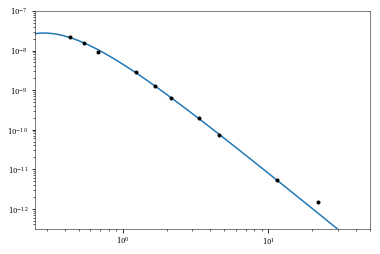

1516832959.38 143 8.88714685307
AWI0000tsh J155009.26+403823.5
[  6.66341088e-10   1.50398000e-09   1.52506952e-09   9.26613271e-10
   2.96729585e-10   1.07808541e-10   1.00038180e-11   1.74897552e-12]
[  6.75340532e-12   4.15565033e-11   3.65206643e-11   2.30429438e-11
   7.41922620e-12   1.98590671e-12   1.56635567e-13   9.82628250e-14]
[ 10.7041811    8.526        7.708        7.499        7.42532956   7.541
   7.286        7.031     ]
[ 0.011004    0.03        0.026       0.027       0.02714702  0.02        0.017
  0.061     ]
[ 98.66742125  36.19120683  41.7590848   40.21245203  39.99468099
  54.28681024  63.86683557  17.79895418]
3100.47154945 6.03997410419e-10
Fit W1 flux: 3.61797015309e-10
Observed W1 flux: 2.96729584973e-10
Observed W1 uncertainty: 7.41922619777e-12
Difference (Observed - Fit): -6.50674303356e-11
Significance: -8.77011006284
 
Fit K flux: 8.28884817909e-10
Observed K flux: 9.26613270618e-10
Observed K uncertainty: 2.30429437621e-11
Difference (Observed - Fit):

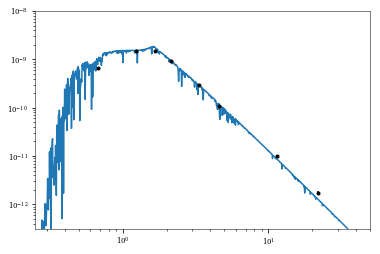

1516832974.11 144 8.92773611181
AWI00004c1 J161241.51+054140.8
[  9.58232608e-11   5.11495789e-10   5.63494446e-10   3.77831807e-10
   1.24995010e-10   5.14106585e-11   6.14562110e-12   1.43477477e-12]
[  1.04101463e-12   9.89320566e-12   1.24559416e-11   7.30791505e-12
   2.53274248e-12   9.47019327e-13   1.13206524e-13   1.41397975e-13]
[ 12.80974522   9.697        8.789        8.473        8.364        8.345
   7.815        7.246     ]
[ 0.01179533  0.021       0.024       0.021       0.022       0.02        0.02
  0.107     ]
[ 92.04794852  51.70172404  45.23900853  51.70172404  49.35164567
  54.28681024  54.28681024  10.14706733]
2552.08506725 4.86325619649e-10
Fit W1 flux: 1.60389162798e-10
Observed W1 flux: 1.24995009575e-10
Observed W1 uncertainty: 2.53274248256e-12
Difference (Observed - Fit): -3.53941532237e-11
Significance: -13.9746355847
 
Fit K flux: 3.2285293006e-10
Observed K flux: 3.77831807347e-10
Observed K uncertainty: 7.30791505296e-12
Difference (Observed - Fit): 5

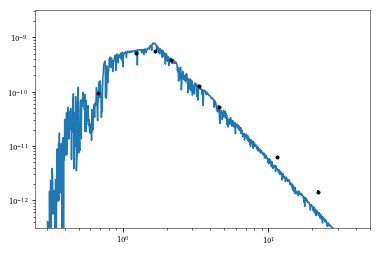

1516832989.3 145 8.97091724133
AWI0005b4j J161808.54-224218.7
[  1.96874313e-09   2.39970495e-09   1.49983009e-09   9.00512281e-10
   5.17724260e-10   1.69080169e-10   7.32239523e-11   1.03983823e-11
   2.52338624e-12]
[  9.24772512e-11   6.85165081e-11   3.31534695e-11   3.89819157e-11
   1.14442000e-11   3.58175759e-12   1.34883505e-12   1.81968017e-13
   1.83605845e-13]
[ 10.363   9.791   8.529   8.28    8.131   8.036   7.961   7.244   6.633]
[ 0.051  0.031  0.024  0.047  0.024  0.023  0.02   0.019  0.079]
[ 21.28894519  35.02374854  45.23900853  23.10077031  45.23900853
  47.20592195  54.28681024  57.14401078  13.74349626]
5517.72671299 2.62842044114e-10
Fit W1 flux: 1.74248306579e-10
Observed W1 flux: 1.69080169351e-10
Observed W1 uncertainty: 3.58175759272e-12
Difference (Observed - Fit): -5.16813722779e-12
Significance: -1.44290535973
 
Fit K flux: 5.07144419068e-10
Observed K flux: 5.1772425963e-10
Observed K uncertainty: 1.14441999601e-11
Difference (Observed - Fit): 1.0579840

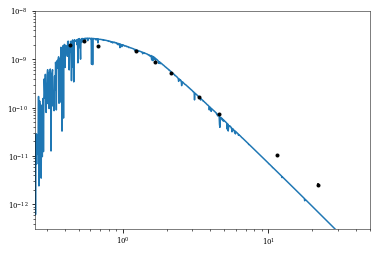

1516833004.18 146 9.01136301315
AWI0005b52 J162039.60-263428.5
[  1.44340783e-11   1.62645504e-10   1.59253740e-10   9.95631242e-11
   3.37359290e-11   1.51026503e-11   1.29946857e-12   3.26575598e-12]
[  1.32942774e-13   4.04465522e-12   3.52027476e-12   2.29252565e-12
   7.14654595e-13   2.64291045e-13   5.98427394e-14   2.10551069e-13]
[ 15.7    10.941  10.161   9.921   9.786   9.675   9.502   6.353]
[ 0.01   0.027  0.024  0.025  0.023  0.019  0.05   0.07 ]
[ 108.57362048   40.21245203   45.23900853   43.42944819   47.20592195
   57.14401078   21.7147241    15.51051721]
3207.82035628 2.01981151017e-10
Fit W1 flux: 4.30608238997e-11
Observed W1 flux: 3.37359290115e-11
Observed W1 uncertainty: 7.1465459461e-13
Difference (Observed - Fit): -9.32489488819e-12
Significance: -13.0481143737
 
Fit K flux: 1.00595417989e-10
Observed K flux: 9.95631241551e-11
Observed K uncertainty: 2.29252565492e-12
Difference (Observed - Fit): -1.03229383338e-12
Significance: -0.450286709405
False
W1 signif

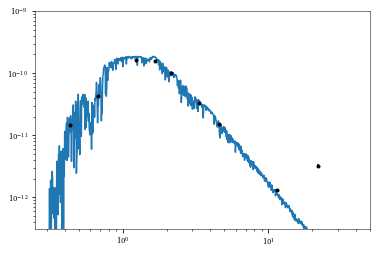

1516833018.35 147 9.04648299282
AWI0005b5k J162224.95-232955.1
[  3.30665630e-12   1.38816811e-10   1.73496069e-10   1.36803912e-10
   6.33421316e-11   4.64144455e-11   2.20072502e-11   1.80129038e-11]
[  3.04554300e-14   3.06852018e-12   3.67530306e-12   2.64602224e-12
   1.40016622e-12   8.97734967e-13   3.85119104e-13   6.63619902e-13]
[ 17.3    11.113  10.068   9.576   9.102   8.456   6.43    4.499]
[ 0.01   0.024  0.023  0.021  0.024  0.021  0.019  0.04 ]
[ 108.57362048   45.23900853   47.20592195   51.70172404   45.23900853
   51.70172404   57.14401078   27.14340512]
2646.33663086 2.87233466191e-10
Fit W1 flux: 6.02543070225e-11
Observed W1 flux: 6.33421315877e-11
Observed W1 uncertainty: 1.40016622034e-12
Difference (Observed - Fit): 3.08782456521e-12
Significance: 2.20532713927
 
Fit K flux: 1.24560011936e-10
Observed K flux: 1.36803911753e-10
Observed K uncertainty: 2.64602224206e-12
Difference (Observed - Fit): 1.22438998169e-11
Significance: 4.62728529725
False
W1 significan

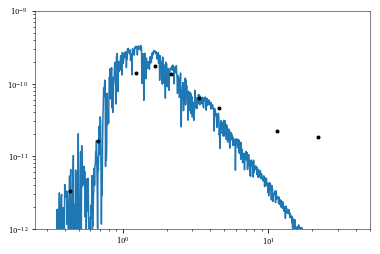

1516833033.28 148 9.08618918947
AWI00025ny J162418.65-431516.5
[  1.96264640e-09   3.04852415e-09   2.59476789e-09   9.62492250e-10
   3.72790676e-10   5.20673868e-11   1.29533986e-11]
[  3.79609469e-11   9.54650133e-11   4.77973910e-11   3.85487123e-11
   6.69471729e-12   7.19337532e-13   3.10193547e-13]
[ 8.237       6.956       6.381       6.14773858  6.19397031  5.495       4.857     ]
[ 0.021       0.034       0.02        0.04348475  0.01949807  0.015       0.026     ]
[ 51.70172404  31.93341779  54.28681024  24.96820758  55.68430444
  72.38241365  41.7590848 ]
2186.38912794 1.63015420424e-09
Fit W1 flux: 1.28786332789e-09
Observed W1 flux: 9.62492249508e-10
Observed W1 uncertainty: 3.85487122502e-11
Difference (Observed - Fit): -3.25371078381e-10
Significance: -8.44051744891
 
Fit K flux: 2.2798861029e-09
Observed K flux: 2.59476789466e-09
Observed K uncertainty: 4.77973909922e-11
Difference (Observed - Fit): 3.14881791755e-10
Significance: 6.58784475928
True
K excess detected. T

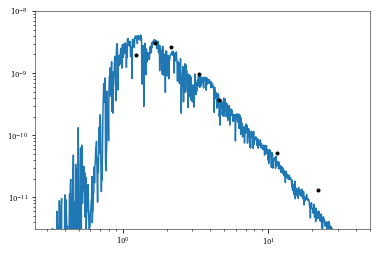

1516833049.61 149 9.1348053689
AWI00000lj J162754.20+061441.3
[  4.40932645e-10   1.52630758e-09   1.67528863e-09   1.10789478e-09
   3.65169825e-10   1.41596711e-10   1.78388059e-11   4.53715620e-12]
[  4.62627576e-12   3.65503122e-11   4.78329333e-11   2.65306288e-11
   9.47832855e-12   2.47789242e-12   2.79312507e-13   1.96407139e-13]
[ 11.15249195   8.51         7.606        7.305        7.19999448   7.245
   6.658        5.996     ]
[ 0.01139157  0.026       0.031       0.026       0.02818131  0.019       0.017
  0.047     ]
[ 95.31049757  41.7590848   35.02374854  41.7590848   38.52681648
  57.14401078  63.86683557  23.10077031]
2756.76335912 7.56523061559e-10
Fit W1 flux: 4.53551417875e-10
Observed W1 flux: 3.65169824736e-10
Observed W1 uncertainty: 9.47832855406e-12
Difference (Observed - Fit): -8.83815931387e-11
Significance: -9.32459690911
 
Fit K flux: 9.64763655187e-10
Observed K flux: 1.10789477893e-09
Observed K uncertainty: 2.65306288268e-11
Difference (Observed - Fit): 

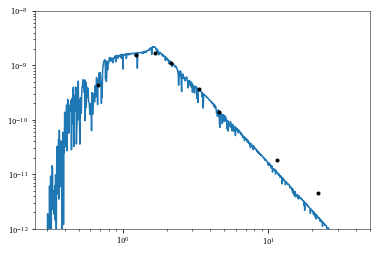

1516833068.07 150 9.19696666718
AWI0005b80 J162932.66-254329.3
[  2.06723123e-12   7.18716884e-12   1.56618140e-10   1.80505168e-10
   1.33936367e-10   5.86803471e-11   3.16120869e-11   1.54513269e-11
   2.09499857e-11]
[  3.99837967e-13   6.61962713e-14   3.31776467e-12   3.65753088e-12
   2.59055902e-12   1.24307173e-12   5.82316160e-13   2.27699168e-13
   5.40278197e-13]
[ 17.81   16.1    10.982  10.025   9.599   9.185   8.873   6.814   4.335]
[ 0.21   0.01   0.023  0.022  0.021  0.023  0.02   0.016  0.028]
[   5.1701724   108.57362048   47.20592195   49.35164567   51.70172404
   47.20592195   54.28681024   67.8585128    38.77629303]
2340.30758211 3.67620101252e-10
Fit W1 flux: 7.62430513935e-11
Observed W1 flux: 5.86803471101e-11
Observed W1 uncertainty: 1.24307173107e-12
Difference (Observed - Fit): -1.75627042834e-11
Significance: -14.1284721102
 
Fit K flux: 1.43265900721e-10
Observed K flux: 1.33936367345e-10
Observed K uncertainty: 2.59055901602e-12
Difference (Observed - Fit)

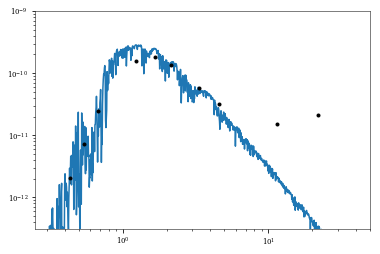

1516833080.85 151 9.22071523224
AWI0005b88 J163033.90-242806.5
[  8.66247636e-11   9.15565965e-11   6.64505402e-11   2.86347024e-11
   1.60049074e-11   5.57398481e-12   4.67717620e-12]
[  2.07439325e-12   2.02384180e-12   1.22406419e-12   5.80217783e-13
   2.80080226e-13   1.23211914e-13   2.54162470e-13]
[ 11.625  10.762  10.36    9.964   9.612   7.921   5.963]
[ 0.026  0.024  0.02   0.022  0.019  0.024  0.059]
[ 41.7590848   45.23900853  54.28681024  49.35164567  57.14401078
  45.23900853  18.40230856]
108652082290.0 9.57618114217e-15
Fit W1 flux: 6.89242473405e-12
Observed W1 flux: 2.86347024192e-11
Observed W1 uncertainty: 5.80217782608e-13
Difference (Observed - Fit): 2.17422776851e-11
Significance: 37.4726151746
 
Fit K flux: 2.57482976923e-11
Observed K flux: 6.64505401835e-11
Observed K uncertainty: 1.22406418598e-12
Difference (Observed - Fit): 4.07022424912e-11
Significance: 33.2517223829
True
Initial fit fail. Retrying with W1.
108652082290.0 9.57618114217e-15
Fitting failed

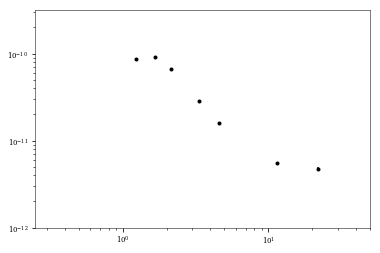

1516833083.08 152 9.17475657871
AWI0005dhk J164021.30+075004.8
[  3.94189574e-10   2.16392429e-09   2.48250219e-09   1.62516895e-09
   5.43215309e-10   2.23178917e-10   2.81427013e-11   7.19090797e-12]
[  4.28417934e-12   5.18192461e-11   7.08805394e-11   2.54462106e-11
   1.91726944e-11   4.31666297e-12   3.88805787e-13   2.45053627e-13]
[ 11.27415975   8.131        7.179        6.889        6.76880168   6.751
   6.163        5.496     ]
[ 0.01180013  0.026       0.031       0.017       0.03832088  0.021       0.015
  0.037     ]
[ 92.0105213   41.7590848   35.02374854  63.86683557  28.33275791
  51.70172404  72.38241365  29.34422175]
2480.33225612 1.10478395125e-09
Fit W1 flux: 7.79915126317e-10
Observed W1 flux: 5.43215309014e-10
Observed W1 uncertainty: 1.91726944007e-11
Difference (Observed - Fit): -2.36699817303e-10
Significance: -12.3456730888
 
Fit K flux: 1.53603556478e-09
Observed K flux: 1.62516894809e-09
Observed K uncertainty: 2.54462105955e-11
Difference (Observed - Fit):

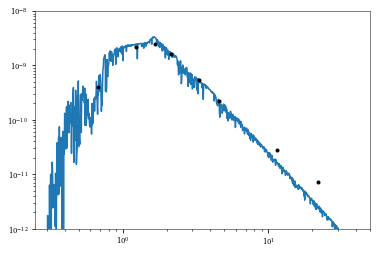

1516833094.97 153 9.1925098039
AWI0005gnp J164540.79-310226.6
[  2.15272749e-09   2.68755801e-09   1.44159100e-09   8.52098185e-10
   4.56350484e-10   1.47806208e-10   5.73658148e-11   4.36280479e-12
   4.23042238e-12]
[  1.13015911e-10   8.66366342e-11   3.05383507e-11   4.31646287e-11
   1.30297442e-11   3.26722916e-12   1.16238910e-12   9.24207093e-14
   1.98714513e-13]
[ 10.266   9.668   8.572   8.34    8.268   8.182   8.226   8.187   6.072]
[ 0.057  0.035  0.023  0.055  0.031  0.024  0.022  0.023  0.051]
[ 19.04800359  31.02103442  47.20592195  19.74065827  35.02374854
  45.23900853  49.35164567  47.20592195  21.28894519]
5878.71917786 2.37031975346e-10
Fit W1 flux: 1.55091236632e-10
Observed W1 flux: 1.47806207635e-10
Observed W1 uncertainty: 3.26722915539e-12
Difference (Observed - Fit): -7.28502899631e-12
Significance: -2.2297269796
 
Fit K flux: 4.59256854585e-10
Observed K flux: 4.56350484258e-10
Observed K uncertainty: 1.30297441957e-11
Difference (Observed - Fit): -2.906370

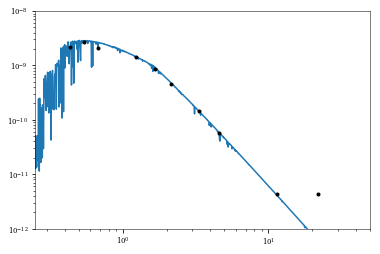

1516833106.32 154 9.20648701315
AWI00057qr J164548.44-263858.1
[  4.10950068e-08   3.08005057e-08   6.46311766e-09   2.98462409e-09
   1.58087858e-09   4.73909443e-10   1.88561562e-10   1.51413912e-11
   5.29156007e-12]
[  7.56998000e-10   3.12051455e-10   1.07149524e-10   1.04459734e-10
   3.49450316e-11   1.58355848e-11   3.82077556e-12   2.37077524e-13
   2.58306468e-13]
[ 7.064       7.02        6.943       6.979       6.919       6.91699328
  6.934       6.836       5.829     ]
[ 0.02        0.011       0.018       0.038       0.024       0.03627965
  0.022       0.017       0.053     ]
[ 54.28681024  98.70329134  60.31867804  28.57200539  45.23900853
  29.92686712  49.35164567  63.86683557  20.48558877]
10839.5920039 2.76968863076e-10
Fit W1 flux: 4.68758356077e-10
Observed W1 flux: 4.73909442695e-10
Observed W1 uncertainty: 1.58355848221e-11
Difference (Observed - Fit): 5.15108661721e-12
Significance: 0.325285530979
 
Fit K flux: 1.55554335817e-09
Observed K flux: 1.58087858242e

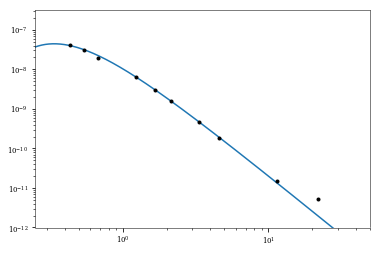

1516833109.77 155 9.16937419368
AWI0005dhx J164837.40+351209.3
[  5.69887402e-10   6.99774072e-10   3.92682966e-10   2.63081095e-10
   1.56206289e-10   1.01319415e-10   8.78725373e-11   4.47265893e-11
   1.56452941e-11]
[  5.51129979e-11   4.31825545e-11   8.68018506e-12   7.75381256e-12
   3.16516880e-12   2.14632849e-12   1.69960555e-12   5.76725955e-13
   3.45836361e-13]
[ 11.709  11.129   9.984   9.616   9.432   8.592   7.763   5.66    4.652]
[ 0.105  0.067  0.024  0.032  0.022  0.023  0.021  0.014  0.024]
[ 10.34034481  16.20501798  45.23900853  33.9292564   49.35164567
  47.20592195  51.70172404  77.55258605  45.23900853]
5332.42143239 1.45397052595e-10
Fit W1 flux: 5.07473675741e-11
Observed W1 flux: 1.01319415131e-10
Observed W1 uncertainty: 2.14632848918e-12
Difference (Observed - Fit): 5.05720475566e-11
Significance: 23.5621191311
 
Fit K flux: 1.46245535766e-10
Observed K flux: 1.56206289272e-10
Observed K uncertainty: 3.16516880336e-12
Difference (Observed - Fit): 9.9607535

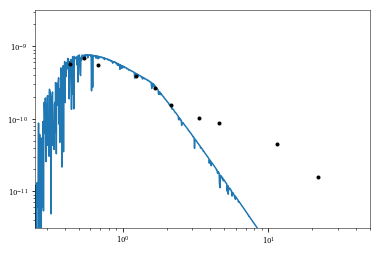

1516833121.66 156 9.18682692295
AWI0005di7 J165204.85+145827.2
[  7.08254033e-08   5.02756677e-08   9.68371641e-09   4.49665574e-09
   2.22074409e-09   6.61499343e-10   2.68720406e-10   2.02752296e-11
   4.19936603e-12]
[  1.17418693e-09   4.63056012e-10   3.03247102e-10   1.36671909e-10
   3.68168562e-11   2.09100784e-11   4.95333246e-12   3.17461002e-13
   2.04991230e-13]
[ 6.473       6.488       6.504       6.534       6.55        6.55490814
  6.5493813   6.519       6.08      ]
[ 0.018       0.01        0.034       0.033       0.018       0.03432026
  0.02001341  0.017       0.053     ]
[  60.31867804  108.57362048   31.93341779   32.90109711   60.31867804
   31.63543101   54.25042808   63.86683557   20.48558877]
12100.7525095 3.07366848205e-10
Fit W1 flux: 6.5876059224e-10
Observed W1 flux: 6.61499343434e-10
Observed W1 uncertainty: 2.09100784264e-11
Difference (Observed - Fit): 2.73875119404e-12
Significance: 0.130977566807
 
Fit K flux: 2.2150885969e-09
Observed K flux: 2.22074

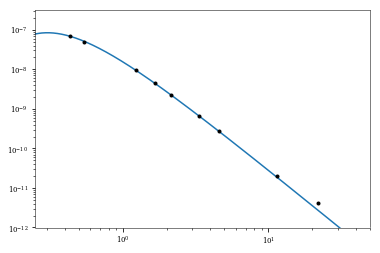

1516833123.85 157 9.14224203833
AWI000028h J165556.61+241554.0
[  3.66892966e-11   4.18834128e-11   3.05695918e-11   1.67841177e-11
   5.91687881e-12   2.89903305e-12   1.19279492e-12   1.65647059e-12]
[  3.53076730e-13   1.00297727e-12   9.00980307e-13   3.55551104e-13
   1.19892229e-13   5.87423785e-14   4.28455841e-14   1.44938251e-13]
[ 13.85207412  12.414       11.953       11.854       11.676       11.467
   9.595        7.09      ]
[ 0.0104485  0.026      0.032      0.023      0.022      0.022      0.039
  0.095    ]
[ 103.91309728   41.7590848    33.9292564    47.20592195   49.35164567
   49.35164567   27.83938987   11.42880216]
4023.81007508 6.39759193196e-11
Fit W1 flux: 6.37414602111e-12
Observed W1 flux: 5.91687881048e-12
Observed W1 uncertainty: 1.19892229125e-13
Difference (Observed - Fit): -4.57267210628e-13
Significance: -3.81398539308
 
Fit K flux: 1.66271645456e-11
Observed K flux: 1.67841176742e-11
Observed K uncertainty: 3.55551104233e-13
Difference (Observed - Fit)

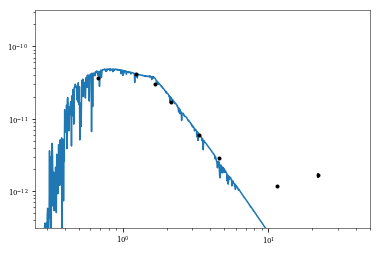

1516833138.49 158 9.17705063277
AWI00005ko J165920.60+131219.3
[  1.70944464e-11   2.27217649e-11   2.20642739e-11   1.85737038e-11
   1.12536311e-11   6.77100550e-12   1.79707326e-12   2.19980270e-12]
[  1.66969354e-13   5.23187972e-13   3.04829209e-13   4.10568322e-13
   2.38394477e-13   1.18490204e-13   5.29653004e-14   1.35748242e-13]
[ 14.68128498  13.078       12.307       11.744       10.978       10.546
   9.15         6.782     ]
[ 0.01060489  0.025       0.015       0.024       0.023       0.019       0.032
  0.067     ]
[ 102.38074246   43.42944819   72.38241365   45.23900853   47.20592195
   57.14401078   33.9292564    16.20501798]
3263.7901245 7.95244916103e-11
Fit W1 flux: 6.88703383599e-12
Observed W1 flux: 1.12536310871e-11
Observed W1 uncertainty: 2.38394477285e-13
Difference (Observed - Fit): 4.36659725106e-12
Significance: 18.3166879569
 
Fit K flux: 1.62439426535e-11
Observed K flux: 1.85737038114e-11
Observed K uncertainty: 4.10568321771e-13
Difference (Observed - 

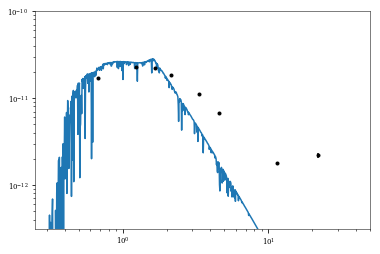

1516833155.18 159 9.22425786204
AWI0005bew J170737.21-062607.2
[  1.03321108e-09   1.59425522e-09   2.01577504e-09   1.29327130e-09
   7.55263533e-10   2.66267780e-10   1.25387189e-10   2.04628340e-11
   4.65568652e-12]
[  7.32749383e-11   6.46079861e-11   4.82715329e-11   5.83661975e-11
   1.66949621e-11   6.16112600e-12   2.30971738e-12   3.01551466e-13
   2.01538150e-13]
[ 11.063       10.235        8.208        7.887        7.721        7.54293514
   7.377        6.509        5.968     ]
[ 0.077       0.044       0.026       0.049       0.024       0.02512267
  0.02        0.016       0.047     ]
[ 14.10047019  24.67582284  41.7590848   22.15788173  45.23900853
  43.21738911  54.28681024  67.8585128   23.10077031]
4410.68877859 3.97619111037e-10
Fit W1 flux: 2.85050277076e-10
Observed W1 flux: 2.66267779785e-10
Observed W1 uncertainty: 6.16112600267e-12
Difference (Observed - Fit): -1.87824972908e-11
Significance: -3.04854945065
 
Fit K flux: 7.7113352407e-10
Observed K flux: 7.552

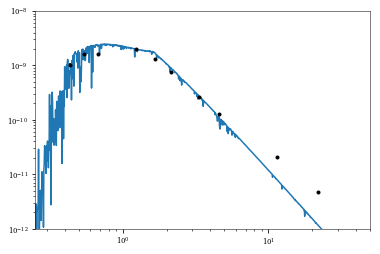

1516833168.57 160 9.25029374957
AWI0005844 J171043.91-220016.7
[  5.22142515e-09   5.26935972e-09   2.22045544e-09   1.13576803e-09
   6.40469593e-10   2.00448482e-10   8.58723141e-11   1.26871999e-11
   1.12715523e-11]
[  1.53891529e-10   8.73586738e-11   4.29474158e-11   4.60275646e-11
   1.00282030e-11   4.26109608e-12   1.58182648e-12   1.98650829e-13
   4.15259333e-13]
[ 9.304       8.937       8.103       8.028       7.9         7.85122476
  7.788       7.028       5.008     ]
[ 0.032       0.018       0.021       0.044       0.017       0.02308038
  0.02        0.017       0.04      ]
[ 33.9292564   60.31867804  51.70172404  24.67582284  63.86683557
  47.04153061  54.28681024  63.86683557  27.14340512]
6746.36745237 2.50161827713e-10
Fit W1 flux: 2.08887444147e-10
Observed W1 flux: 2.00448481718e-10
Observed W1 uncertainty: 4.26109608054e-12
Difference (Observed - Fit): -8.43896242916e-12
Significance: -1.98046752987
 
Fit K flux: 6.39474627708e-10
Observed K flux: 6.40469592644

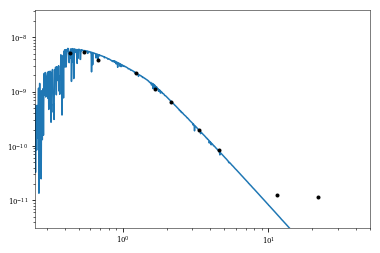

1516833180.7 161 9.26818012451
AWI0005paa J171307.83-532428.8
[  4.22076509e-10   2.18595925e-09   2.31467297e-09   1.54205021e-09
   5.28288915e-10   2.04292850e-10   1.14542269e-10   5.33069372e-11]
[  5.56784631e-12   4.02668575e-11   5.75610999e-11   3.40867376e-11
   1.66808637e-11   3.57505270e-12   1.47696260e-12   1.12924258e-12]
[ 11.19994463   8.12         7.255        6.946        6.79905294   6.847
   4.639        3.321     ]
[ 0.01432255  0.02        0.027       0.024       0.03428241  0.019       0.014
  0.023     ]
[ 75.80606309  54.28681024  40.21245203  45.23900853  31.67035746
  57.14401078  77.55258605  47.20592195]
2538.95966875 1.04523971847e-09
Fit W1 flux: 7.33021002717e-10
Observed W1 flux: 5.28288915457e-10
Observed W1 uncertainty: 1.6680863677e-11
Difference (Observed - Fit): -2.0473208726e-10
Significance: -12.2734704404
 
Fit K flux: 1.46980039443e-09
Observed K flux: 1.54205021322e-09
Observed K uncertainty: 3.40867376027e-11
Difference (Observed - Fit): 7.

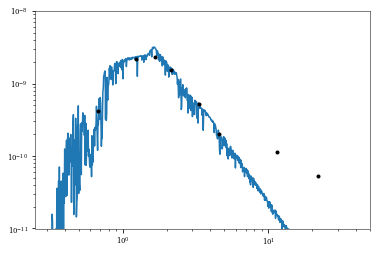

1516833195.4 162 9.30174074055
AWI0005djv J172007.53+354103.6
[  9.31942369e-09   9.72204993e-09   3.88366769e-09   2.17214914e-09
   1.13683783e-09   3.49603022e-10   1.37231297e-10   1.02557112e-11
   2.14775001e-12]
[  1.97420648e-10   1.07452067e-10   7.15398027e-11   3.40105959e-11
   2.19883930e-11   9.72035165e-12   2.52789390e-12   1.60579604e-13
   1.38470561e-13]
[ 8.675       8.272       7.496       7.324       7.277       7.24729374
  7.279       7.259       6.808     ]
[ 0.023       0.012       0.02        0.017       0.021       0.03018778
  0.02        0.017       0.07      ]
[ 47.20592195  90.47801706  54.28681024  63.86683557  51.70172404
  35.96608789  54.28681024  63.86683557  15.51051721]
6780.43370951 3.34206515816e-10
Fit W1 flux: 3.75366166179e-10
Observed W1 flux: 3.49603021814e-10
Observed W1 uncertainty: 9.72035165189e-12
Difference (Observed - Fit): -2.57631443646e-11
Significance: -2.65043336777
 
Fit K flux: 1.15040406624e-09
Observed K flux: 1.13683782674e

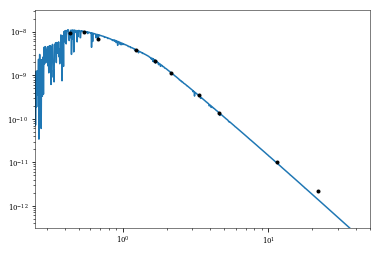

1516833207.11 163 9.3164785274
AWI0005igi J172452.23-185133.5
[  7.15466092e-09   7.88057392e-09   3.62778936e-09   2.08972741e-09
   1.12330713e-09   3.36568970e-10   1.33737490e-10   1.03410772e-11
   8.66131295e-12]
[  1.71331842e-10   1.08874152e-10   8.01916195e-11   5.96660124e-11
   2.48304984e-11   8.10870610e-12   2.46353560e-12   1.71440714e-13
   2.87185105e-13]
[ 8.962      8.5        7.57       7.366      7.29       7.2885465  7.307
  7.25       5.294    ]
[ 0.026       0.015       0.024       0.031       0.024       0.02615784
  0.02        0.018       0.036     ]
[ 41.7590848   72.38241365  45.23900853  35.02374854  45.23900853
  41.50711173  54.28681024  60.31867804  30.15933902]
6325.62948149 3.47907161666e-10
Fit W1 flux: 3.70028469681e-10
Observed W1 flux: 3.3656896984e-10
Observed W1 uncertainty: 8.10870609504e-12
Difference (Observed - Fit): -3.3459499841e-11
Significance: -4.12636732036
 
Fit K flux: 1.1160635362e-09
Observed K flux: 1.12330713056e-09
Observed K u

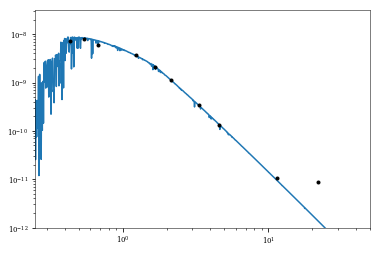

1516833220.11 164 9.33894512275
AWI0005bjo J172734.02-020656.8
[  2.03039985e-11   3.77782697e-11   3.18925790e-11   2.32969204e-11
   2.33180739e-11   1.87868153e-11   8.01984143e-12   4.09245328e-12]
[  2.00058480e-13   8.00286661e-13   7.34353770e-13   5.36431416e-13
   4.93965014e-13   3.80672520e-13   1.40344392e-13   2.56311636e-13]
[ 14.49446865  12.526       11.907       11.498       10.187        9.438
   7.526        6.108     ]
[ 0.01069793  0.023       0.025       0.025       0.023       0.022       0.019
  0.068     ]
[ 101.49031694   47.20592195   43.42944819   43.42944819   47.20592195
   49.35164567   57.14401078   15.96670889]
3072.60698297 1.07033064194e-10
Fit W1 flux: 1.11729803967e-11
Observed W1 flux: 2.33180738897e-11
Observed W1 uncertainty: 4.93965013889e-13
Difference (Observed - Fit): 1.2145093493e-11
Significance: 24.5869507992
 
Fit K flux: 2.54618525062e-11
Observed K flux: 2.32969203955e-11
Observed K uncertainty: 5.36431416153e-13
Difference (Observed - 

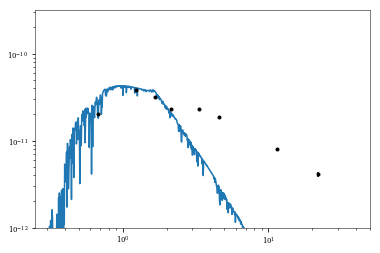

1516833233.17 165 9.36152121226
AWI0005bk4 J172944.28-061340.5
[  4.61787382e-10   6.31087590e-10   4.63125310e-10   1.78748985e-10
   7.20200082e-11   2.84554712e-11   1.02137149e-11]
[  1.14836912e-11   1.91813540e-11   1.45028419e-11   3.79765240e-12
   1.26032470e-12   3.93126862e-13   3.10436909e-13]
[ 9.808       8.666       8.252       7.97562272  7.979       6.151       5.115     ]
[ 0.027       0.033       0.034       0.02306726  0.019       0.015       0.033     ]
[ 40.21245203  32.90109711  31.93341779  47.06828487  57.14401078
  72.38241365  32.90109711]
2595.85900136 5.22640452372e-10
Fit W1 flux: 1.91828985522e-10
Observed W1 flux: 1.78748985175e-10
Observed W1 uncertainty: 3.79765240392e-12
Difference (Observed - Fit): -1.30800003473e-11
Significance: -3.44423316198
 
Fit K flux: 3.91050023688e-10
Observed K flux: 4.63125309674e-10
Observed K uncertainty: 1.45028419057e-11
Difference (Observed - Fit): 7.20752859853e-11
Significance: 4.96973534249
False
W1 significantly l

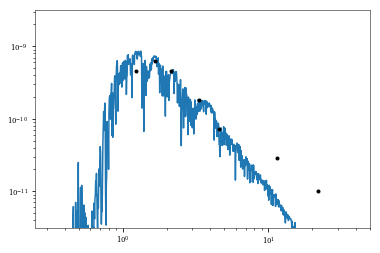

1516833245.53 166 9.37959036195
AWI00000om J173129.67+601156.1
[  2.75542793e-10   6.68894842e-10   1.07557838e-09   9.85574912e-10
   5.86271140e-10   1.84111941e-10   6.55621469e-11   6.06130002e-12
   2.12610021e-12]
[  5.50711912e-11   5.72949673e-11   2.27848188e-11   1.90627089e-11
   1.45793432e-11   4.08226061e-12   1.20769938e-12   9.49052817e-14
   1.15534429e-13]
[ 12.498       11.178        8.89         8.182        7.996        7.94352679
   8.081        7.83         6.819     ]
[ 0.217       0.093       0.023       0.021       0.027       0.02407371
  0.02        0.017       0.059     ]
[  5.00339265  11.67458285  47.20592195  51.70172404  40.21245203
  45.1004869   54.28681024  63.86683557  18.40230856]
3527.11267749 4.39461920198e-10
Fit W1 flux: 2.41151938009e-10
Observed W1 flux: 1.84111941039e-10
Observed W1 uncertainty: 4.08226060758e-12
Difference (Observed - Fit): -5.70399969704e-11
Significance: -13.9726495816
 
Fit K flux: 5.92289138281e-10
Observed K flux: 5.86

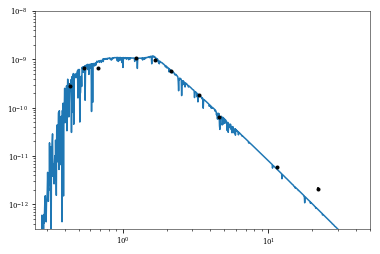

1516833257.61 167 9.3957544915
AWI00001l8 J173254.69+404312.3
[  4.63221871e-10   5.53296403e-10   2.35094280e-10   1.41413099e-10
   7.54568230e-11   2.29981379e-11   8.99193516e-12   9.87565208e-13
   1.39054078e-12]
[  7.16760425e-11   5.14700868e-11   4.33059667e-12   2.60492555e-12
   1.18147114e-12   5.08369628e-13   1.65637567e-13   3.54736656e-14
   1.39600158e-13]
[ 11.934  11.384  10.541  10.29   10.222  10.202  10.238   9.8     7.28 ]
[ 0.168  0.101  0.02   0.02   0.017  0.024  0.02   0.039  0.109]
[  6.4627155   10.74986341  54.28681024  54.28681024  63.86683557
  45.23900853  54.28681024  27.83938987   9.96088261]
6127.00288241 9.29098806737e-11
Fit W1 flux: 2.52494348748e-11
Observed W1 flux: 2.29981379219e-11
Observed W1 uncertainty: 5.08369627637e-13
Difference (Observed - Fit): -2.25129695292e-12
Significance: -4.42846470467
 
Fit K flux: 7.55640923128e-11
Observed K flux: 7.54568229667e-11
Observed K uncertainty: 1.18147113895e-12
Difference (Observed - Fit): -1.07269

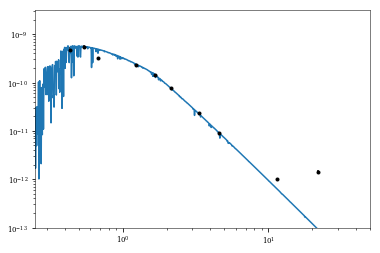

1516833269.78 168 9.41228571392
AWI0005dkx J173832.90+425112.9
[  2.74236419e-10   1.98811757e-09   2.01413993e-09   1.34059784e-09
   4.35128257e-10   1.72923161e-10   2.30444200e-11   5.63357046e-12]
[  5.00481926e-12   3.66224790e-11   4.45221944e-11   2.59294611e-11
   1.29187678e-11   3.02609423e-12   3.18370427e-13   2.17925826e-13]
[ 11.66810976   8.223        7.406        7.098        7.00968847   7.028
   6.38         5.761     ]
[ 0.0198147   0.02        0.024       0.021       0.03223503  0.019       0.015
  0.042     ]
[ 54.79447004  54.28681024  45.23900853  51.70172404  33.6818698
  57.14401078  72.38241365  25.85086202]
2447.41404084 1.01616580827e-09
Fit W1 flux: 6.41448971029e-10
Observed W1 flux: 4.35128256564e-10
Observed W1 uncertainty: 1.29187678454e-11
Difference (Observed - Fit): -2.06320714465e-10
Significance: -15.9706186328
 
Fit K flux: 1.25013342909e-09
Observed K flux: 1.34059784125e-09
Observed K uncertainty: 2.59294610817e-11
Difference (Observed - Fit): 

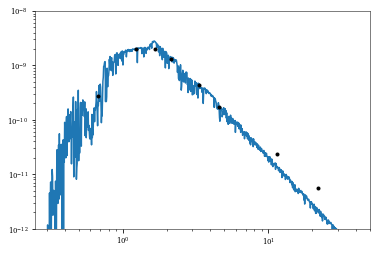

1516833286.55 169 9.45581065127
AWI0005bow J175911.27+135417.8
[  1.67258831e-08   1.22168108e-08   3.02302725e-09   1.43777074e-09
   7.44215165e-10   2.26675696e-10   9.98741662e-11   1.25824665e-11
   3.96628329e-12]
[  3.08102152e-10   1.23773084e-10   5.56862199e-11   2.38362442e-11
   1.98779775e-11   5.03120038e-12   1.74776262e-12   1.97010958e-13
   1.97266423e-13]
[ 8.04        8.024       7.768       7.772       7.737       7.71771929
  7.624       7.037       6.142     ]
[ 0.02        0.011       0.02        0.018       0.029       0.02409855
  0.019       0.017       0.054     ]
[ 54.28681024  98.70329134  54.28681024  60.31867804  37.43917947
  45.05399879  57.14401078  63.86683557  20.10622601]
9737.91900535 2.04746779083e-10
Fit W1 flux: 2.24679617582e-10
Observed W1 flux: 2.26675695884e-10
Observed W1 uncertainty: 5.03120038103e-12
Difference (Observed - Fit): 1.99607830235e-12
Significance: 0.396739972806
 
Fit K flux: 7.3481959728e-10
Observed K flux: 7.44215165429e-

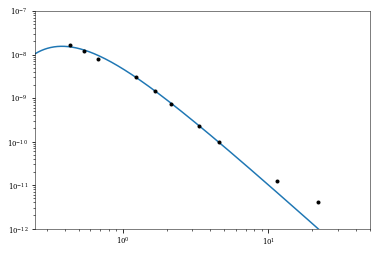

1516833292.38 170 9.43456470546
AWI0005d5p J180230.72+583738.4
[  4.42781081e-08   3.57567343e-08   8.56726227e-09   4.13132765e-09
   2.15227874e-09   6.68920896e-10   2.64034732e-10   1.90970278e-11
   4.11892354e-12]
[  8.15632894e-10   3.29331693e-10   3.62974047e-10   1.25568082e-10
   5.35226934e-11   2.61213206e-11   4.65399668e-12   2.63835190e-13
   1.40365745e-13]
[ 6.983       6.858       6.637       6.626       6.584       6.54279478
  6.56848027  6.584       6.101     ]
[ 0.02        0.01        0.046       0.033       0.027       0.04239793
  0.01913768  0.015       0.037     ]
[  54.28681024  108.57362048   23.60296097   32.90109711   40.21245203
   25.60823424   56.73290083   72.38241365   29.34422175]
9664.90849915 3.4950821054e-10
Fit W1 flux: 6.48633220585e-10
Observed W1 flux: 6.68920896386e-10
Observed W1 uncertainty: 2.61213205904e-11
Difference (Observed - Fit): 2.02876758012e-11
Significance: 0.776671138466
 
Fit K flux: 2.11905791334e-09
Observed K flux: 2.1522

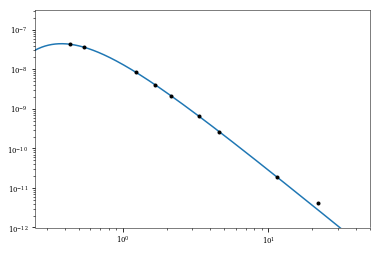

1516833297.05 171 9.40662573095
AWI0005bps J180533.55+182643.9
[  1.32736101e-08   1.06698385e-08   2.55177314e-09   1.23392749e-09
   6.23015018e-10   1.91220247e-10   7.52061171e-11   6.01126372e-12
   1.48861959e-12]
[  2.81185274e-10   1.17927413e-10   4.46551285e-11   2.72757412e-11
   1.31978149e-11   4.06397369e-12   1.45461527e-12   1.05194991e-13
   1.41220139e-13]
[ 8.291     8.171     7.952     7.938     7.93      7.902397  7.932     7.839
  7.206   ]
[ 0.023       0.012       0.019       0.024       0.023       0.02307498
  0.021       0.019       0.103     ]
[ 47.20592195  90.47801706  57.14401078  45.23900853  47.20592195
  47.0525307   51.70172404  57.14401078  10.5411282 ]
9696.84672966 1.90228858527e-10
Fit W1 flux: 1.9293510584e-10
Observed W1 flux: 1.91220246696e-10
Observed W1 uncertainty: 4.06397368788e-12
Difference (Observed - Fit): -1.71485914319e-12
Significance: -0.421966103842
 
Fit K flux: 6.30613022322e-10
Observed K flux: 6.23015018158e-10
Observed K uncer

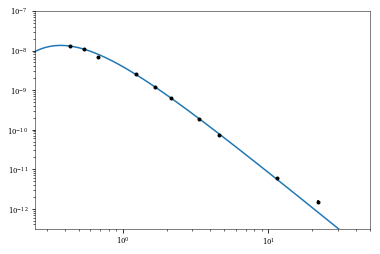

1516833300.65 172 9.37283139589
AWI00059aj J180611.37+035840.5
[  6.83583655e-11   2.76975951e-10   3.04011240e-10   2.05919993e-10
   7.94497755e-11   3.49826872e-11   1.08484023e-11   3.57753368e-12]
[  8.25059658e-13   6.88781552e-12   6.44010808e-12   4.55182375e-12
   1.60987084e-12   5.79964421e-13   1.79851459e-13   2.10881938e-13]
[ 13.17644341  10.363        9.459        9.132        8.856        8.763
   7.198        6.254     ]
[ 0.01310443  0.027       0.023       0.024       0.022       0.018       0.018
  0.064     ]
[ 82.85263351  40.21245203  47.20592195  45.23900853  49.35164567
  60.31867804  60.31867804  16.9646282 ]
2633.95848143 3.58078118108e-10
Fit W1 flux: 9.27578882594e-11
Observed W1 flux: 7.94497754601e-11
Observed W1 uncertainty: 1.60987084382e-12
Difference (Observed - Fit): -1.33081127993e-11
Significance: -8.26657172553
 
Fit K flux: 1.91107118939e-10
Observed K flux: 2.05919993437e-10
Observed K uncertainty: 4.55182374949e-12
Difference (Observed - Fit):

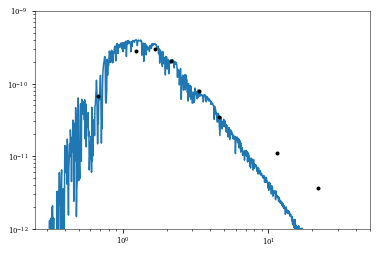

1516833314.62 173 9.39940462498
AWI0005xl0 J180841.59-591507.9
[  4.39935549e-09   3.91703856e-09   1.27773874e-09   6.97091264e-10
   3.77136456e-10   1.55486495e-10   9.00851418e-11   1.67712635e-11
   5.12370044e-12]
[  1.53974334e-10   7.93699685e-11   3.05978626e-11   1.99033882e-11
   7.29446577e-12   3.43700050e-12   1.65942964e-12   2.47150472e-13
   2.02921408e-13]
[ 9.49   9.259  8.703  8.558  8.475  8.127  7.736  6.725  5.864]
[ 0.038  0.022  0.026  0.031  0.021  0.024  0.02   0.016  0.043]
[ 28.57200539  49.35164567  41.7590848   35.02374854  51.70172404
  45.23900853  54.28681024  67.8585128   25.24967918]
7567.65186645 1.73631439572e-10
Fit W1 flux: 1.17251146604e-10
Observed W1 flux: 1.55486495147e-10
Observed W1 uncertainty: 3.43700050452e-12
Difference (Observed - Fit): 3.82353485424e-11
Significance: 11.1246269799
 
Fit K flux: 3.67604190583e-10
Observed K flux: 3.77136456076e-10
Observed K uncertainty: 7.294465767e-12
Difference (Observed - Fit): 9.53226549327e-12
Si

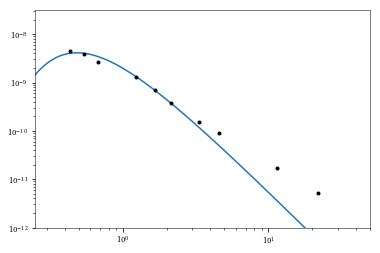

1516833315.52 174 9.35059770085
AWI0005brt J182004.41+292653.3
[  1.68651053e-08   1.20825290e-08   2.53070814e-09   1.17839161e-09
   5.93879748e-10   1.76778596e-10   6.90960414e-11   5.27917163e-12
   1.56741403e-12]
[  3.10666720e-10   1.22412625e-10   4.19556301e-11   2.82188082e-11
   9.84570232e-12   3.59229711e-12   1.20915631e-12   1.06970529e-13
   1.37145959e-13]
[ 8.031       8.036       7.961       7.988       7.982       7.98765748
  8.024       7.98        7.15      ]
[ 0.02        0.011       0.018       0.026       0.018       0.02206312
  0.019       0.022       0.095     ]
[ 54.28681024  98.70329134  60.31867804  41.7590848   60.31867804
  49.21046086  57.14401078  49.35164567  11.42880216]
11126.3002804 1.68357712656e-10
Fit W1 flux: 1.78752541554e-10
Observed W1 flux: 1.76778596325e-10
Observed W1 uncertainty: 3.59229711001e-12
Difference (Observed - Fit): -1.97394522957e-12
Significance: -0.549493866771
 
Fit K flux: 5.95127523934e-10
Observed K flux: 5.9387974819

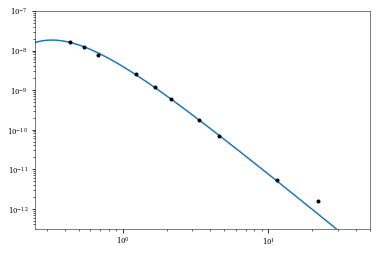

1516833317.52 175 9.30859428542
AWI0002lxd J182016.88-031207.4
[  8.92980679e-10   1.66452239e-09   1.50002506e-09   5.92235017e-10
   2.37010204e-10   2.67033520e-11   6.32097002e-12]
[  2.13841056e-11   4.75255349e-11   3.59209277e-11   2.20123202e-11
   4.06934657e-12   3.93515138e-13   3.02735084e-13]
[ 9.092       7.613       6.976       6.67499648  6.68571531  6.22        5.636     ]
[ 0.026       0.031       0.026       0.04035488  0.01864155  0.016       0.052     ]
[ 41.7590848   35.02374854  41.7590848   26.90470656  58.24281602
  67.8585128   20.8795424 ]
2040.7062257 1.35396086208e-09
Fit W1 flux: 7.5604984534e-10
Observed W1 flux: 5.92235016815e-10
Observed W1 uncertainty: 2.20123202401e-11
Difference (Observed - Fit): -1.63814828525e-10
Significance: -7.44196098994
 
Fit K flux: 1.25302276558e-09
Observed K flux: 1.50002506384e-09
Observed K uncertainty: 3.59209276515e-11
Difference (Observed - Fit): 2.47002298257e-10
Significance: 6.87627838159
True
K excess detected. Tr

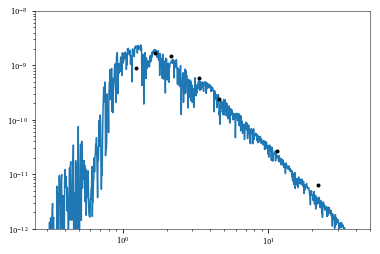

1516833334.54 176 9.35239204493
AWI0002lxl J182032.53-022049.6
[  8.28022356e-10   1.38832019e-09   1.36677969e-09   4.96424289e-10
   1.99091705e-10   4.29107180e-11   1.49962866e-11]
[  2.44043767e-11   6.77705780e-11   3.27301159e-11   1.47481773e-11
   3.48403451e-12   6.71877941e-13   4.41986891e-13]
[ 9.174       7.81        7.077       6.86659913  6.875       5.705       4.698     ]
[ 0.032       0.053       0.026       0.03225594  0.019       0.017       0.032     ]
[ 33.9292564   20.48558877  41.7590848   33.66004337  57.14401078
  63.86683557  33.9292564 ]
2156.10300202 1.12115155542e-09
Fit W1 flux: 5.89975367039e-10
Observed W1 flux: 4.96424288637e-10
Observed W1 uncertainty: 1.47481773316e-11
Difference (Observed - Fit): -9.35510784018e-11
Significance: -6.34322983094
 
Fit K flux: 1.03106164502e-09
Observed K flux: 1.36677968701e-09
Observed K uncertainty: 3.27301159403e-11
Difference (Observed - Fit): 3.35718041989e-10
Significance: 10.2571601824
True
K excess detected. 

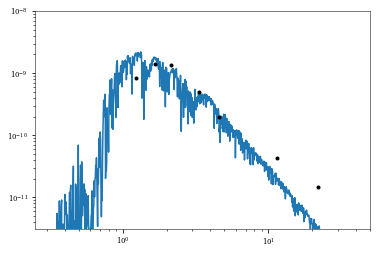

1516833348.54 177 9.37866101696
AWI0002ao1 J182614.45-013250.8
[  3.45612193e-10   9.20784176e-10   2.93522949e-09   2.61390404e-09
   1.57796918e-09   5.49814344e-10   2.05803694e-10   1.61646305e-11
   3.42281740e-12]
[  7.28954160e-11   8.90477245e-11   8.65102806e-11   9.14847945e-11
   3.05206298e-11   1.53211239e-11   3.60149194e-12   2.38210798e-13
   1.79694286e-13]
[ 12.252       10.831        7.8          7.123        6.921        6.75569152
   6.839        6.765        6.302     ]
[ 0.229       0.105       0.032       0.038       0.021       0.03025512
  0.019       0.016       0.057     ]
[  4.74120613  10.34034481  33.9292564   28.57200539  51.70172404
  35.88603201  57.14401078  67.8585128   19.04800359]
70795684792.2 5.72747095713e-15
Fit W1 flux: 1.60650413209e-12
Observed W1 flux: 5.49814344339e-10
Observed W1 uncertainty: 1.5321123946e-11
Difference (Observed - Fit): 5.48207840207e-10
Significance: 35.7811765077
 
Fit K flux: 6.00147959419e-12
Observed K flux: 1.57796

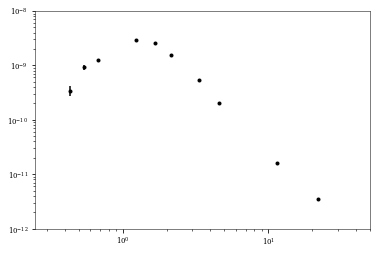

1516833353.79 178 9.35546629215
AWI0002001 J182717.07-041838.0
[  1.30389333e-10   1.57793693e-10   1.46588032e-10   7.23257047e-11
   5.17431861e-11   1.81704541e-11   1.59068333e-11]
[  2.64204630e-12   3.63333405e-12   2.97027648e-12   1.53213202e-12
   9.53144711e-13   2.84505314e-13   3.80919108e-13]
[ 11.181  10.171   9.501   8.958   8.338   6.638   4.634]
[ 0.022  0.025  0.022  0.023  0.02   0.017  0.026]
[ 49.35164567  43.42944819  49.35164567  47.20592195  54.28681024
  63.86683557  41.7590848 ]
2247.86958008 3.82999759241e-10
Fit W1 flux: 7.56955618226e-11
Observed W1 flux: 7.23257047487e-11
Observed W1 uncertainty: 1.53213202427e-12
Difference (Observed - Fit): -3.36985707396e-12
Significance: -2.19945606552
 
Fit K flux: 1.37385983333e-10
Observed K flux: 1.46588032475e-10
Observed K uncertainty: 2.97027648181e-12
Difference (Observed - Fit): 9.20204914181e-12
Significance: 3.09804464269
False
W1 significantly low. Refitting with W1 included
2500.0 3.5 3.03411677106e-10
[ 1

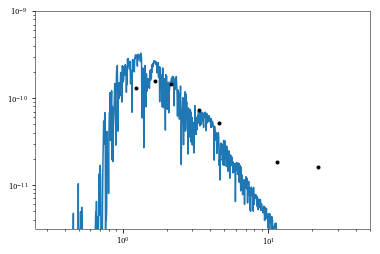

1516833365.05 179 9.36610055902
AWI0002apf J182750.65-022407.4
[  1.83840868e-09   2.69457105e-09   2.12470439e-09   7.66209779e-10
   3.85120835e-10   4.60220311e-11   1.04323880e-11]
[  5.07971091e-11   6.70083747e-11   4.50092765e-11   2.85146205e-11
   6.55687830e-12   6.35817856e-13   3.17083286e-13]
[ 8.308       7.09        6.598       6.39536246  6.15864038  5.629       5.092     ]
[ 0.03        0.027       0.023       0.04040585  0.01848521  0.015       0.033     ]
[ 36.19120683  40.21245203  47.20592195  26.87076892  58.73539468
  72.38241365  32.90109711]
2400.9564379 1.281470869e-09
Fit W1 flux: 9.79225000509e-10
Observed W1 flux: 7.66209778862e-10
Observed W1 uncertainty: 2.85146205175e-11
Difference (Observed - Fit): -2.13015221647e-10
Significance: -7.47038599078
 
Fit K flux: 1.87931133565e-09
Observed K flux: 2.12470439243e-09
Observed K uncertainty: 4.50092764814e-11
Difference (Observed - Fit): 2.45393056774e-10
Significance: 5.45205513079
True
K excess detected. Try

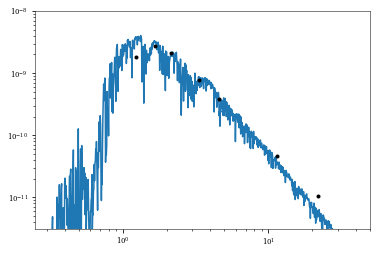

1516833375.27 180 9.37084444496
AWI0002m6v J182955.33+004939.0
[  9.98594239e-12   2.67696111e-10   3.73671212e-10   4.73912884e-10
   3.95113341e-10   2.76832800e-10   8.50679136e-11   1.38287756e-10]
[  9.19739284e-13   5.67081629e-12   9.63658933e-12   1.13487373e-11
   1.09923482e-11   4.82685116e-12   1.17525666e-12   2.67472234e-12]
[ 16.1         10.4          9.235        8.227        7.11442745
   6.51708906   4.962        2.286     ]
[ 0.1         0.023       0.028       0.026       0.03020599  0.01893087
  0.015       0.021     ]
[ 10.85736205  47.20592195  38.77629303  41.7590848   35.94439821
  57.35266951  72.38241365  51.70172404]
1822.05123884 9.83029382196e-10
Fit W1 flux: 3.00285122745e-10
Observed W1 flux: 3.95113340807e-10
Observed W1 uncertainty: 1.09923481958e-11
Difference (Observed - Fit): 9.48282180617e-11
Significance: 8.62674802257
 
Fit K flux: 4.40689866084e-10
Observed K flux: 4.73912883937e-10
Observed K uncertainty: 1.13487373161e-11
Difference (Observed

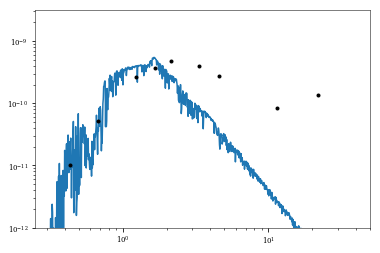

1516833385.04 181 9.373027625
AWI0002m9o J183311.41+025439.0
[  6.74904094e-10   8.07773572e-10   7.43530033e-10   9.38590515e-10
   5.18573027e-10   7.74400779e-11   2.08345311e-11]
[  1.42970218e-11   3.12474521e-11   1.36963294e-11   3.49644732e-11
   1.03238320e-11   9.98549266e-13   5.18111432e-13]
[ 9.396       8.398       7.738       6.17504128  5.83560811  5.064       4.341     ]
[ 0.023       0.042       0.02        0.04044596  0.021615    0.014       0.027     ]
[ 47.20592195  25.85086202  54.28681024  26.84412002  50.23067282
  77.55258605  40.21245203]
2069.61179737 1.05584366609e-09
Fit W1 flux: 4.75450478019e-10
Observed W1 flux: 9.385905151e-10
Observed W1 uncertainty: 3.49644731969e-11
Difference (Observed - Fit): 4.63140037081e-10
Significance: 13.2460178786
 
Fit K flux: 7.99022400008e-10
Observed K flux: 7.43530033494e-10
Observed K uncertainty: 1.36963293705e-11
Difference (Observed - Fit): -5.54923665138e-11
Significance: -4.05162324974
False
3400.0 2.5 3.807553659

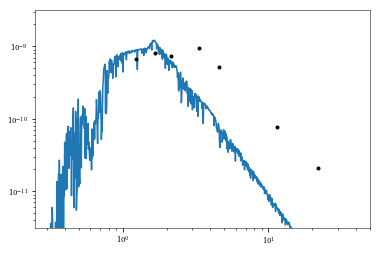

1516833394.12 182 9.37141208858
AWI0005z1i J183504.55-661033.0
[  5.26004012e-09   4.88604933e-09   1.60266245e-09   8.42732301e-10
   4.53417748e-10   1.38067886e-10   5.42316935e-11   4.23999926e-12
   1.27992267e-12]
[  1.30806252e-10   6.30030483e-11   3.83787734e-11   2.25093689e-11
   1.00227163e-11   2.79763489e-12   9.49035477e-13   7.41984892e-14
   1.28494905e-13]
[ 9.296  9.019  8.457  8.352  8.275  8.256  8.287  8.218  7.37 ]
[ 0.027  0.014  0.026  0.029  0.024  0.022  0.019  0.019  0.109]
[ 40.21245203  77.55258605  41.7590848   37.43917947  45.23900853
  49.35164567  57.14401078  57.14401078   9.96088261]
7624.33721743 1.9020024053e-10
Fit W1 flux: 1.42077586635e-10
Observed W1 flux: 1.38067885639e-10
Observed W1 uncertainty: 2.79763488657e-12
Difference (Observed - Fit): -4.0097009962e-12
Significance: -1.43324670973
 
Fit K flux: 4.46081016501e-10
Observed K flux: 4.53417748138e-10
Observed K uncertainty: 1.00227162985e-11
Difference (Observed - Fit): 7.3367316372e-12
S

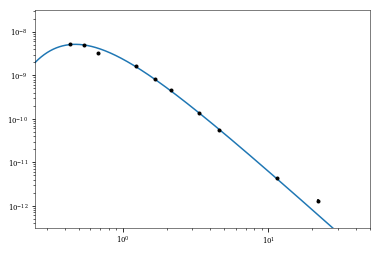

1516833398.51 183 9.34428415272
AWI0002mhd J184305.97+071626.4
[  1.24333757e-08   1.00036352e-08   2.64509980e-09   1.22036471e-09
   6.54181888e-10   2.03999763e-10   7.97724934e-11   6.94010085e-12
   3.66761492e-12]
[  2.86289055e-10   1.19777951e-10   6.57781275e-11   4.72078923e-11
   1.20504757e-11   4.33696624e-12   1.46946363e-12   1.21449313e-13
   2.16191883e-13]
[ 8.362       8.241       7.913       7.95        7.877       7.83215753
  7.868       7.683       6.227     ]
[ 0.025       0.013       0.027       0.042       0.02        0.02308239
  0.02        0.019       0.064     ]
[ 43.42944819  83.5181696   40.21245203  25.85086202  54.28681024
  47.03743386  54.28681024  57.14401078  16.9646282 ]
9166.1371518 2.0114640847e-10
Fit W1 flux: 2.01116993981e-10
Observed W1 flux: 2.03999762657e-10
Observed W1 uncertainty: 4.33696623998e-12
Difference (Observed - Fit): 2.88276867677e-12
Significance: 0.66469705256
 
Fit K flux: 6.51838714111e-10
Observed K flux: 6.54181887779e-10

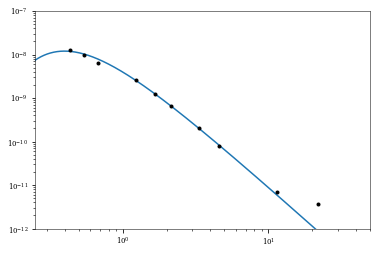

1516833401.98 184 9.31227173883
AWI0002b3p J184748.57+080147.3
[  6.84292945e-10   1.06681629e-09   9.07190546e-10   3.42230002e-10
   1.25734126e-10   1.93626940e-11   6.24573755e-12]
[  1.44959132e-11   4.12681130e-11   2.17243876e-11   8.24577171e-12
   2.43191360e-12   2.85339203e-13   2.58864159e-13]
[ 9.381       8.096       7.522       7.27043649  7.374       6.569       5.649     ]
[ 0.023       0.042       0.026       0.02615999  0.021       0.016       0.045     ]
[ 47.20592195  25.85086202  41.7590848   41.50369596  51.70172404
  67.8585128   24.12747122]
2300.36424096 8.4380969709e-10
Fit W1 flux: 3.86787894528e-10
Observed W1 flux: 3.42230002041e-10
Observed W1 uncertainty: 8.24577171166e-12
Difference (Observed - Fit): -4.4557892487e-11
Significance: -5.40372618174
 
Fit K flux: 7.16262500208e-10
Observed K flux: 9.0719054602e-10
Observed K uncertainty: 2.17243876488e-11
Difference (Observed - Fit): 1.90928045812e-10
Significance: 8.7886502901
True
K excess detected. Tryi

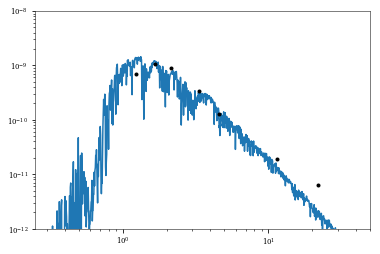

1516833417.09 185 9.34361621625
AWI0002b6k J185211.39+102422.6
[  4.05921507e-10   5.02677724e-10   3.67196485e-10   1.29685874e-10
   5.14106585e-11   8.25212468e-12   2.93753961e-12]
[  8.59895306e-12   1.15745823e-11   7.10220969e-12   2.62779230e-12
   9.47019327e-13   1.29208291e-13   1.32573124e-13]
[ 9.948  8.913  8.504  8.324  8.345  7.495  6.468]
[ 0.023  0.025  0.021  0.022  0.02   0.017  0.049]
[ 47.20592195  43.42944819  51.70172404  49.35164567  54.28681024
  63.86683557  22.15788173]
2775.56069079 4.27092377898e-10
Fit W1 flux: 1.46500312878e-10
Observed W1 flux: 1.29685874269e-10
Observed W1 uncertainty: 2.6277922956e-12
Difference (Observed - Fit): -1.68144386087e-11
Significance: -6.39869392906
 
Fit K flux: 3.13063553604e-10
Observed K flux: 3.67196485396e-10
Observed K uncertainty: 7.10220968916e-12
Difference (Observed - Fit): 5.41329317918e-11
Significance: 7.62198444723
True
K excess detected. Trying fitting without K.
2775.56069079 4.27092377898e-10
W1 significan

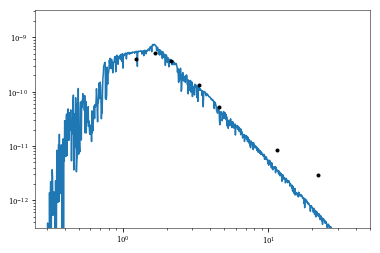

1516833427.4 186 9.34882795683
AWI0005xvl J190206.79-362142.1
[  1.07495196e-08   9.03977971e-09   2.39244555e-09   1.18165212e-09
   6.16167114e-10   1.93889210e-10   7.70288061e-11   9.83027758e-12
   1.35015532e-11]
[  2.57417510e-10   1.16563227e-10   5.28845708e-11   4.57103567e-11
   1.87278592e-11   4.12098015e-12   1.48986920e-12   1.72026385e-13
   3.97932480e-13]
[ 8.52        8.351       8.022       7.985       7.942       7.88734758
  7.906       7.305       4.812     ]
[ 0.026       0.014       0.024       0.042       0.033       0.02307657
  0.021       0.019       0.032     ]
[ 41.7590848   77.55258605  45.23900853  25.85086202  32.90109711
  47.04929484  51.70172404  57.14401078  33.9292564 ]
8915.06288625 1.98981395965e-10
Fit W1 flux: 1.90062166651e-10
Observed W1 flux: 1.93889210014e-10
Observed W1 uncertainty: 4.12098014772e-12
Difference (Observed - Fit): 3.82704336334e-12
Significance: 0.928673088965
 
Fit K flux: 6.13325417085e-10
Observed K flux: 6.16167114333e-

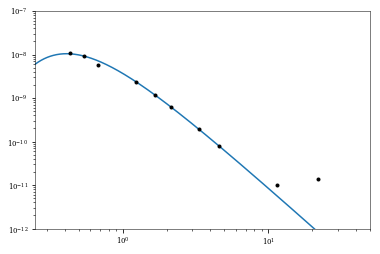

1516833433.61 187 9.332010695
AWI0002mxe J190638.88+203326.9
[  4.87740766e-10   5.24998240e-10   1.55325250e-10   7.72128602e-11
   3.88059675e-11   1.19809891e-11   4.88262271e-12   1.12555256e-12
   3.56437780e-12]
[  6.06454894e-11   4.06174648e-11   3.57649606e-12   2.13347017e-12
   6.43349105e-13   2.53802672e-13   9.44382958e-14   4.45769055e-14
   1.54296924e-13]
[ 11.878  11.441  10.991  10.947  10.944  10.91   10.901   9.658   6.258]
[ 0.135  0.084  0.025  0.03   0.018  0.023  0.021  0.043  0.047]
[  8.04249041  12.92543101  43.42944819  36.19120683  60.31867804
  47.20592195  51.70172404  25.24967918  23.10077031]
271174333338.0 5.2374502059e-15
Fit W1 flux: 5.14561955997e-12
Observed W1 flux: 1.19809891301e-11
Observed W1 uncertainty: 2.53802672127e-13
Difference (Observed - Fit): 6.83536957014e-12
Significance: 26.9318266544
 
Fit K flux: 1.92226901591e-11
Observed K flux: 3.88059675088e-11
Observed K uncertainty: 6.43349104595e-13
Difference (Observed - Fit): 1.958327734

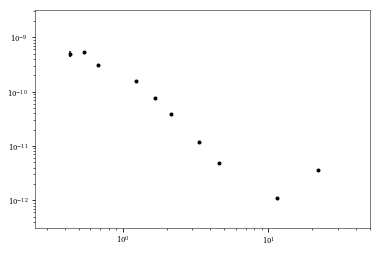

1516833440.39 188 9.31844680867
AWI00017os J190901.24+110641.3
[  1.42229295e-09   1.63590412e-09   1.50675299e-09   8.84076080e-10
   5.52202687e-10   2.11097911e-10   1.09914039e-10   1.74970882e-11
   5.71720455e-12]
[  9.43185755e-11   6.78025521e-11   3.74698114e-11   2.19851323e-11
   1.67837165e-11   4.48863159e-12   2.12592599e-12   2.73962034e-13
   2.52755519e-13]
[ 10.716       10.207        8.524        8.3          8.061        7.79502185
   7.52         6.679        5.745     ]
[ 0.072      0.045      0.027      0.027      0.033      0.0230863  0.021
  0.017      0.048    ]
[ 15.07966951  24.12747122  40.21245203  40.21245203  32.90109711
  47.02945801  51.70172404  63.86683557  22.61950427]
4919.74369652 2.98518125736e-10
Fit W1 flux: 1.89916611205e-10
Observed W1 flux: 2.11097910818e-10
Observed W1 uncertainty: 4.48863158825e-12
Difference (Observed - Fit): 2.11812996134e-11
Significance: 4.71887683295
 
Fit K flux: 5.33779001442e-10
Observed K flux: 5.52202687189e-10
O

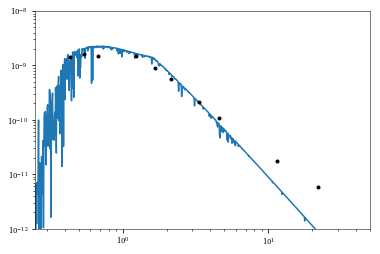

1516833452.7 189 9.33429629588
AWI00059vy J191845.28+371449.2
[  5.03719840e-09   4.52228415e-09   1.50398000e-09   8.37316482e-10
   6.38702352e-10   3.71314410e-10   2.36796102e-10   2.56664486e-11
   4.53297925e-12]
[  1.39182935e-10   7.08080197e-11   4.01712865e-11   4.08734399e-11
   1.05887989e-11   1.06713182e-11   4.06652681e-12   3.78234765e-13
   1.71176155e-13]
[ 9.343       9.103       8.526       8.359       7.903       7.18187718
  6.68669655  6.263       5.997     ]
[ 0.03        0.017       0.029       0.053       0.018       0.0312033
  0.01864547  0.016       0.041     ]
[ 36.19120683  63.86683557  37.43917947  20.48558877  60.31867804
  34.79555235  58.23055218  67.8585128   26.48137085]
6799.21870321 2.28894568398e-10
Fit W1 flux: 1.76732987954e-10
Observed W1 flux: 3.7131441029e-10
Observed W1 uncertainty: 1.06713181778e-11
Difference (Observed - Fit): 1.94581422335e-10
Significance: 18.2340568516
 
Fit K flux: 5.41973032703e-10
Observed K flux: 6.38702352417e-10


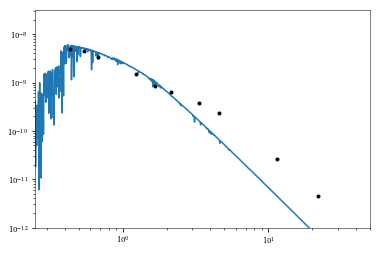

1516833461.31 190 9.33048421082
AWI00021py J192343.53+230856.7
[  2.34367378e-11   1.00563890e-10   1.20472976e-10   1.15053151e-10
   6.96454380e-11   4.32367624e-11   1.38091129e-11   2.19575424e-11]
[  2.30261692e-13   1.94507807e-12   2.44111366e-12   1.80145375e-12
   1.53949965e-12   7.96450597e-13   2.41654598e-13   4.65143811e-13]
[ 14.33867968  11.463       10.464        9.764        8.999        8.533
   6.936        4.284     ]
[ 0.01066716  0.021       0.022       0.017       0.024       0.02        0.019
  0.023     ]
[ 101.78305219   51.70172404   49.35164567   63.86683557   45.23900853
   54.28681024   57.14401078   47.20592195]
2389.29769961 3.1030946823e-10
Fit W1 flux: 5.68208075809e-11
Observed W1 flux: 6.96454380225e-11
Observed W1 uncertainty: 1.5394996549e-12
Difference (Observed - Fit): 1.28246304417e-11
Significance: 8.33038864338
 
Fit K flux: 1.08617870272e-10
Observed K flux: 1.15053150571e-10
Observed K uncertainty: 1.80145375196e-12
Difference (Observed - F

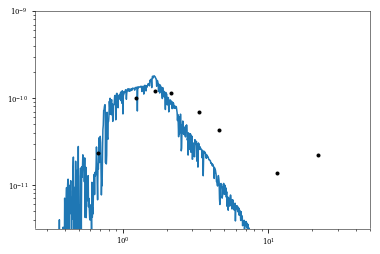

1516833472.86 191 9.34209424039
AWI0005bwq J192437.52+563454.9
[  1.07001301e-09   2.20271266e-09   2.67696111e-09   2.21457116e-09
   1.20808785e-09   4.02510295e-10   1.44229191e-10   1.18622147e-11
   2.72134580e-12]
[  5.61745487e-11   5.88344266e-11   5.91737352e-11   1.04024466e-10
   1.89157305e-11   1.23190762e-11   2.65679988e-12   1.74808056e-13
   1.32841962e-13]
[ 11.025       9.884       7.9         7.303       7.211       7.0942892
   7.225       7.101       6.551    ]
[ 0.057       0.029       0.024       0.051       0.017       0.03322963
  0.02        0.016       0.053     ]
[ 19.04800359  37.43917947  45.23900853  21.28894519  63.86683557
  32.67374016  54.28681024  67.8585128   20.48558877]
4209.55379439 5.16195631935e-10
Fit W1 flux: 4.46262838787e-10
Observed W1 flux: 4.02510295073e-10
Observed W1 uncertainty: 1.23190762091e-11
Difference (Observed - Fit): -4.37525437138e-11
Significance: -3.55160914431
 
Fit K flux: 1.18573597103e-09
Observed K flux: 1.20808784767

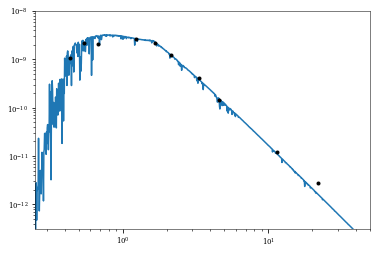

1516833487.24 192 9.36831770837
AWI0005byy J202222.87+730903.7
[  1.07099898e-08   1.04077739e-08   3.56485658e-09   1.78028544e-09
   9.63160172e-10   3.02276773e-10   1.19854175e-10   1.00685233e-11
   3.82281895e-12]
[  2.36742363e-10   1.15030968e-10   8.86505647e-11   6.55881395e-11
   1.86291693e-11   8.11851338e-12   2.31818527e-12   1.48375243e-13
   1.40837855e-13]
[ 8.524       8.198       7.589       7.54        7.457       7.40521974
  7.426       7.279       6.182     ]
[ 0.024       0.012       0.027       0.04        0.021       0.02916057
  0.021       0.016       0.04      ]
[ 45.23900853  90.47801706  40.21245203  27.14340512  51.70172404
  37.23302024  51.70172404  67.8585128   27.14340512]
7539.59502434 2.8205839602e-10
Fit W1 flux: 3.07909777136e-10
Observed W1 flux: 3.02276772967e-10
Observed W1 uncertainty: 8.11851337891e-12
Difference (Observed - Fit): -5.63300416936e-12
Significance: -0.693846755736
 
Fit K flux: 9.64658908096e-10
Observed K flux: 9.63160172242

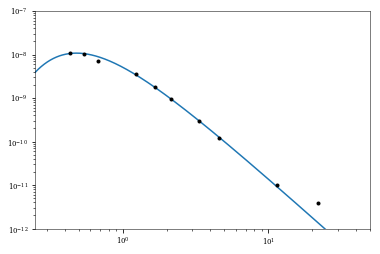

1516833493.33 193 9.35135233217
AWI0004y3p J203123.98+283625.0
[  1.11529321e-08   8.36677032e-09   2.03630141e-09   9.46432489e-10
   4.68703844e-10   1.63716584e-10   7.23524375e-11   9.73118617e-12
   3.37585458e-12]
[  2.15716831e-10   9.24729630e-11   3.56345553e-11   2.70225926e-11
   1.03606127e-11   3.46813656e-12   1.39942021e-12   1.43404059e-13
   1.52354572e-13]
[ 8.48   8.435  8.197  8.226  8.239  8.071  7.974  7.316  6.317]
[ 0.021  0.012  0.019  0.031  0.024  0.023  0.021  0.016  0.049]
[ 51.70172404  90.47801706  57.14401078  35.02374854  45.23900853
  47.20592195  51.70172404  67.8585128   22.15788173]
9970.3324568 1.63249168346e-10
Fit W1 flux: 1.4705138566e-10
Observed W1 flux: 1.63716583916e-10
Observed W1 uncertainty: 3.46813656352e-12
Difference (Observed - Fit): 1.66651982558e-11
Significance: 4.80523126773
 
Fit K flux: 4.8255139968e-10
Observed K flux: 4.68703844418e-10
Observed K uncertainty: 1.03606126578e-11
Difference (Observed - Fit): -1.38475552617e-11
Si

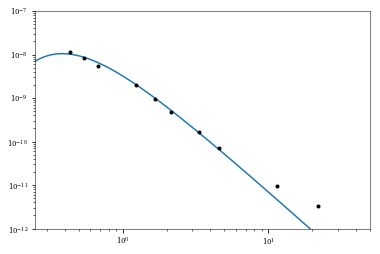

1516833500.82 194 9.34173195878
AWI0006207 J203711.08-650159.9
[  6.19140276e-08   4.17020925e-08   7.68496798e-09   3.49373242e-09
   1.78689287e-09   5.58046935e-10   2.18500868e-10   1.64803254e-11
   3.52519975e-12]
[  1.08347361e-09   3.84090466e-10   1.84031044e-10   9.33175478e-11
   3.78531505e-11   1.91803907e-11   4.02493473e-12   2.42863049e-13
   1.88316080e-13]
[ 6.619       6.691       6.755       6.808       6.786       6.73955487
  6.774       6.744       6.27      ]
[ 0.019       0.01        0.026       0.029       0.023       0.03731737
  0.02        0.016       0.058     ]
[  57.14401078  108.57362048   41.7590848    37.43917947   47.20592195
   29.0946594    54.28681024   67.8585128    18.71958974]
12714.7091186 2.64523053382e-10
Fit W1 flux: 5.1733350068e-10
Observed W1 flux: 5.58046935125e-10
Observed W1 uncertainty: 1.9180390719e-11
Difference (Observed - Fit): 4.07134344443e-11
Significance: 2.12265928472
 
Fit K flux: 1.74899030997e-09
Observed K flux: 1.786892

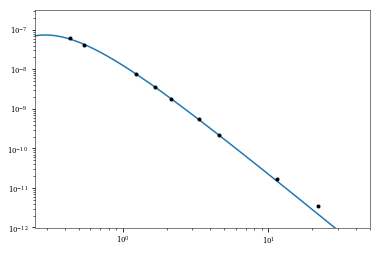

1516833504.57 195 9.31306153811
AWI0002o5q J204109.10+521801.3
[  5.11967111e-10   6.97091264e-10   5.12505483e-10   2.01936122e-10
   8.37631819e-11   1.38856362e-11   4.87061420e-12]
[  1.13169392e-11   2.31136121e-11   1.08568049e-11   4.29287749e-12
   1.54297483e-12   2.04626296e-13   1.74954057e-13]
[ 9.696       8.558       8.142       7.84319665  7.815       6.93        5.919     ]
[ 0.024       0.036       0.023       0.02308122  0.02        0.016       0.039     ]
[ 45.23900853  30.15933902  47.20592195  47.03980558  54.28681024
  67.8585128   27.83938987]
2542.74108621 5.74343181308e-10
Fit W1 flux: 2.2200726022e-10
Observed W1 flux: 2.01936122416e-10
Observed W1 uncertainty: 4.29287748836e-12
Difference (Observed - Fit): -2.00711378035e-11
Significance: -4.67545087368
 
Fit K flux: 4.45653581844e-10
Observed K flux: 5.12505482647e-10
Observed K uncertainty: 1.08568048567e-11
Difference (Observed - Fit): 6.68519008027e-11
Significance: 6.15760361223
True
K excess detected. T

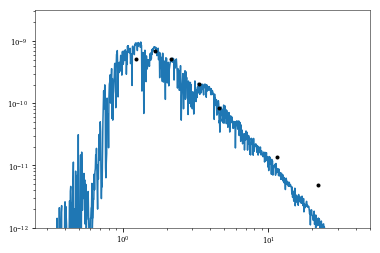

1516833517.3 196 9.33052040849
AWI0002o7p J204909.99+543431.2
[  2.01577504e-09   2.61631264e-09   1.92352801e-09   5.84037936e-10
   2.76109502e-10   3.38661464e-11   8.04606859e-12]
[  3.89885458e-11   6.98816769e-11   3.54326954e-11   2.06208564e-11
   5.05797796e-12   4.67878103e-13   2.22321091e-13]
[ 8.208       7.122       6.706       6.69012904  6.51992954  5.962       5.374     ]
[ 0.021       0.029       0.02        0.03833451  0.01988932  0.015       0.03      ]
[ 51.70172404  37.43917947  54.28681024  28.32268083  54.58890963
  72.38241365  36.19120683]
2668.26663864 1.02693319433e-09
Fit W1 flux: 7.83125306256e-10
Observed W1 flux: 5.8403793554e-10
Observed W1 uncertainty: 2.0620856446e-11
Difference (Observed - Fit): -1.99087370716e-10
Significance: -9.65466062176
 
Fit K flux: 1.62846508248e-09
Observed K flux: 1.92352801411e-09
Observed K uncertainty: 3.543269545e-11
Difference (Observed - Fit): 2.9506293163e-10
Significance: 8.32741985568
True
K excess detected. Trying

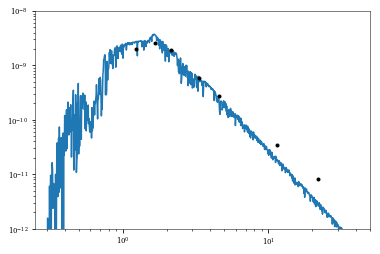

1516833527.41 197 9.33447715716
AWI0005c01 J205143.50+730449.3
[  1.15928190e-08   9.65067848e-09   2.43243958e-09   1.17839161e-09
   5.91151119e-10   1.87892494e-10   7.41742505e-11   5.54326679e-12
   1.14178342e-12]
[  2.45579761e-10   1.06663240e-10   5.15282720e-11   1.95360980e-11
   8.71152482e-12   3.99290160e-12   1.43465720e-12   9.18996731e-14
   7.88716042e-14]
[ 8.438       8.28        8.004       7.988       7.987       7.92145811
  7.947       7.927       7.494     ]
[ 0.023       0.012       0.023       0.018       0.016       0.02307297
  0.021       0.018       0.075     ]
[ 47.20592195  90.47801706  47.20592195  60.31867804  67.8585128
  47.05663008  51.70172404  60.31867804  14.47648273]
9367.39776108 1.90105375813e-10
Fit W1 flux: 1.84586493932e-10
Observed W1 flux: 1.87892493645e-10
Observed W1 uncertainty: 3.99290160218e-12
Difference (Observed - Fit): 3.30599971297e-12
Significance: 0.827969242009
 
Fit K flux: 6.00249860588e-10
Observed K flux: 5.9115111861e-1

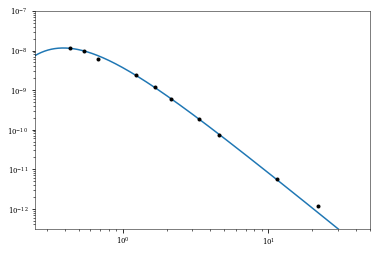

1516833530.93 198 9.30509090905
AWI0001ps3 J205207.92+484956.9
[  1.68340672e-09   2.27697282e-09   1.88991409e-09   1.09066064e-09
   6.35767782e-10   2.12468468e-10   8.90949661e-11   8.19154424e-12
   2.06625411e-12]
[  7.28723197e-11   5.87207452e-11   1.09662538e-10   7.13220256e-11
   1.22968391e-11   4.51791904e-12   1.55913043e-12   1.35804439e-13
   1.27507055e-13]
[ 10.533        9.848        8.278        8.072        7.908        7.78799547
   7.748        7.503        6.85      ]
[ 0.047       0.028       0.063       0.071       0.021       0.02308704
  0.019       0.018       0.067     ]
[ 23.10077031  38.77629303  17.23390801  15.29205922  51.70172404
  47.02794937  57.14401078  60.31867804  16.20501798]
5075.98157915 3.16492984768e-10
Fit W1 flux: 2.2365976043e-10
Observed W1 flux: 2.12468468016e-10
Observed W1 uncertainty: 4.51791904267e-12
Difference (Observed - Fit): -1.11912924136e-11
Significance: -2.47709007353
 
Fit K flux: 6.34942768376e-10
Observed K flux: 6.357

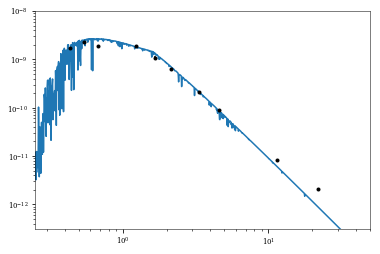

1516833546.36 199 9.335899498
AWI000621a J205241.67-531624.8
[  1.53387178e-08   1.70356162e-08   7.32558079e-09   4.13132765e-09
   2.19633466e-09   6.72662993e-10   2.71562387e-10   1.97954683e-11
   4.34493947e-12]
[  2.82549623e-10   1.72594206e-10   1.34942185e-10   8.75171479e-11
   4.04579796e-11   2.68936000e-11   4.75585040e-12   2.91716802e-13
   1.88086346e-13]
[ 8.134       7.663       6.807       6.626       6.562       6.53673785
  6.53795887  6.545       6.043     ]
[ 0.02        0.011       0.02        0.023       0.02        0.04340859
  0.01901441  0.016       0.047     ]
[ 54.28681024  98.70329134  54.28681024  47.20592195  54.28681024
  25.01201006  57.10070014  67.8585128   23.10077031]
6521.18934781 4.77292220108e-10
Fit W1 flux: 7.26123808692e-10
Observed W1 flux: 6.72662992824e-10
Observed W1 uncertainty: 2.68935999647e-11
Difference (Observed - Fit): -5.3460815868e-11
Significance: -1.9878638761
 
Fit K flux: 2.20587048839e-09
Observed K flux: 2.19633466284e-09

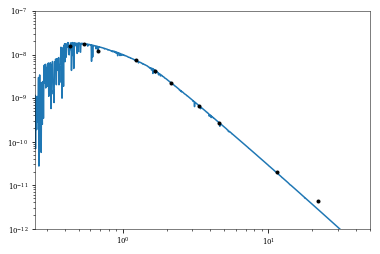

1516833557.82 200 9.34649000049
AWI0005d7g J205722.53+870157.8
[  2.67047832e-08   2.13873929e-08   5.26310534e-09   2.48478971e-09
   1.30406283e-09   3.95846847e-10   1.56405913e-10   1.21273464e-11
   3.23581535e-12]
[  4.91920285e-10   1.96985168e-10   1.16339980e-10   1.16717371e-10
   3.24293288e-11   1.17470459e-11   3.02515855e-12   1.89884879e-13
   1.78817764e-13]
[ 7.532       7.416       7.166       7.178       7.128       7.11241371
  7.137       7.077       6.363     ]
[ 0.02        0.01        0.024       0.051       0.027       0.03222002
  0.021       0.017       0.06      ]
[  54.28681024  108.57362048   45.23900853   21.28894519   40.21245203
   33.69756542   51.70172404   63.86683557   18.09560341]
9549.73749902 2.75684646551e-10
Fit W1 flux: 3.97606160622e-10
Observed W1 flux: 3.95846847384e-10
Observed W1 uncertainty: 1.17470458912e-11
Difference (Observed - Fit): -1.75931323803e-12
Significance: -0.149766439523
 
Fit K flux: 1.29668380321e-09
Observed K flux: 1.3

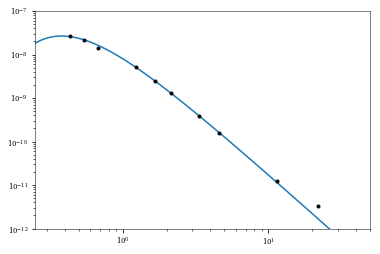

1516833561.29 201 9.31724378126
AWI000621k J205911.24-595822.3
[  9.62474111e-11   2.05379857e-10   2.75449547e-10   2.35120036e-10
   1.43119403e-10   8.35781347e-11   6.96070401e-11   4.42349745e-11
   1.94797658e-11]
[  8.86471416e-13   1.89161839e-12   5.58136498e-12   5.19728535e-12
   3.03181035e-12   1.69352275e-12   1.28220906e-12   5.70386840e-13
   5.38245820e-13]
[ 13.64   12.46   10.369   9.738   9.527   8.801   8.016   5.672   4.414]
[ 0.01   0.01   0.022  0.024  0.023  0.022  0.02   0.014  0.03 ]
[ 108.57362048  108.57362048   49.35164567   45.23900853   47.20592195
   49.35164567   54.28681024   77.55258605   36.19120683]
4040.46927666 1.81302521936e-10
Fit W1 flux: 5.15362856528e-11
Observed W1 flux: 8.35781346679e-11
Observed W1 uncertainty: 1.69352274948e-12
Difference (Observed - Fit): 3.2041849015e-11
Significance: 18.9202353643
 
Fit K flux: 1.34666919462e-10
Observed K flux: 1.43119402917e-10
Observed K uncertainty: 3.0318103538e-12
Difference (Observed - Fit): 8.

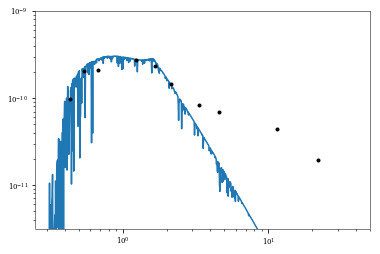

1516833572.01 202 9.32418811911
AWI000621m J205952.30-153218.5
[  1.32747018e-10   1.79987383e-10   1.62214488e-10   1.31855581e-10
   8.56037272e-11   5.30949440e-11   9.72222754e-12   6.84831504e-12]
[  1.36159640e-12   3.81281364e-12   3.73512662e-12   2.79319999e-12
   1.89225471e-12   1.07584951e-12   1.70135547e-13   2.14456062e-13]
[ 12.45586065  10.831       10.141        9.616        8.775        8.31
   7.317        5.549     ]
[ 0.01113648  0.023       0.025       0.023       0.024       0.022       0.019
  0.034     ]
[ 97.4936609   47.20592195  43.42944819  47.20592195  45.23900853
  49.35164567  57.14401078  31.93341779]
3279.46703341 2.18123746764e-10
Fit W1 flux: 5.22605451305e-11
Observed W1 flux: 8.56037271621e-11
Observed W1 uncertainty: 1.89225471426e-12
Difference (Observed - Fit): 3.33431820316e-11
Significance: 17.6208740718
 
Fit K flux: 1.23586295377e-10
Observed K flux: 1.31855580692e-10
Observed K uncertainty: 2.79319998968e-12
Difference (Observed - Fit): 8.

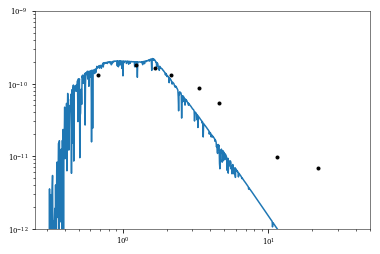

1516833583.26 203 9.3336798029
AWI00022vs J210144.07+521717.6
[  1.97951067e-10   2.31655205e-10   2.24537891e-10   1.97559772e-10
   1.09368605e-10   6.34239326e-11   8.91591216e-12   8.51890413e-12]
[  1.82319670e-12   4.48060890e-12   3.92933377e-12   3.63918548e-12
   2.21610858e-12   1.22672761e-12   1.39601596e-13   2.58924622e-13]
[ 12.5    10.557   9.788   9.177   8.509   8.117   7.411   5.312]
[ 0.01   0.021  0.019  0.02   0.022  0.021  0.017  0.033]
[ 108.57362048   51.70172404   57.14401078   54.28681024   49.35164567
   51.70172404   63.86683557   32.90109711]
4023.70800295 1.79798811788e-10
Fit W1 flux: 5.03436441728e-11
Observed W1 flux: 1.09368605362e-10
Observed W1 uncertainty: 2.21610857907e-12
Difference (Observed - Fit): 5.90249611893e-11
Significance: 26.6345077795
 
Fit K flux: 1.31321613061e-10
Observed K flux: 1.97559771745e-10
Observed K uncertainty: 3.63918548317e-12
Difference (Observed - Fit): 6.6238158685e-11
Significance: 18.2013692326
True
K excess detecte

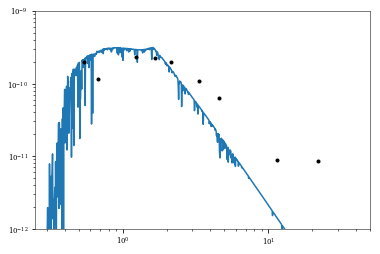

1516833596.79 204 9.35426470579
AWI0002o9g J210805.95+570209.1
[  7.71333267e-10   1.08066140e-09   8.45860054e-10   2.92365576e-10
   1.18974302e-10   1.52814928e-11   4.04374472e-12]
[  1.84710290e-11   4.67803189e-11   1.32441203e-11   7.30957636e-12
   2.19158764e-12   2.25196400e-13   1.56425914e-13]
[ 9.251       8.082       7.598       7.44141609  7.434       6.826       6.121     ]
[ 0.026       0.047       0.017       0.02714503  0.02        0.016       0.042     ]
[ 41.7590848   23.10077031  63.86683557  39.99760887  54.28681024
  67.8585128   25.85086202]
2513.91054906 7.36169348518e-10
Fit W1 flux: 3.56191650071e-10
Observed W1 flux: 2.92365576341e-10
Observed W1 uncertainty: 7.30957636189e-12
Difference (Observed - Fit): -6.38260737291e-11
Significance: -8.73184307395
 
Fit K flux: 7.08840995014e-10
Observed K flux: 8.45860053932e-10
Observed K uncertainty: 1.32441203064e-11
Difference (Observed - Fit): 1.37019058919e-10
Significance: 10.3456519383
True
K excess detected. 

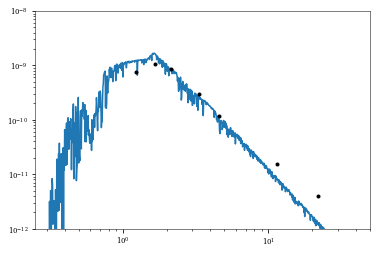

1516833607.46 205 9.36069756136
AWI0006222 J210916.04-001405.6
[  5.17355483e-08   4.29494738e-08   1.11081584e-08   5.77683070e-09
   2.89800090e-09   9.13582152e-10   3.58407772e-10   2.66296698e-11
   6.45035669e-12]
[  4.76502009e-10   3.95579272e-10   3.27391742e-10   2.02184993e-10
   5.60523068e-11   4.25354614e-11   6.49051668e-12   4.16956149e-13
   2.37639922e-13]
[ 6.814       6.659       6.355       6.262       6.261       6.20436267
  6.23668937  6.223       5.614     ]
[ 0.01        0.01        0.032       0.038       0.021       0.05055078
  0.01966193  0.017       0.04      ]
[ 108.57362048  108.57362048   33.9292564    28.57200539   51.70172404
   21.47812961   55.22022204   63.86683557   27.14340512]
9120.84125476 4.21357667659e-10
Fit W1 flux: 8.77061101169e-10
Observed W1 flux: 9.13582151965e-10
Observed W1 uncertainty: 4.2535461352e-11
Difference (Observed - Fit): 3.65210507964e-11
Significance: 0.858602437486
 
Fit K flux: 2.84045228211e-09
Observed K flux: 2.8980

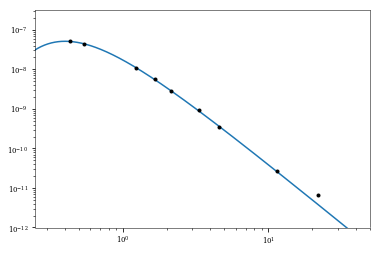

1516833612.09 206 9.33770873824
AWI0006226 J211124.19-192737.9
[  3.45797879e-10   7.25173729e-10   7.23251995e-10   4.23154064e-10
   1.46181588e-10   5.59568382e-11   1.33587487e-11   4.18777877e-12]
[  4.08893392e-12   1.53619228e-11   2.19826103e-11   8.18452520e-12
   3.09667901e-12   1.03076305e-12   2.21469521e-13   2.46853554e-13]
[ 11.41636677   9.318        8.518        8.35         8.194        8.253
   6.972        6.083     ]
[ 0.01283844  0.023       0.033       0.021       0.023       0.02        0.018
  0.064     ]
[ 84.56920215  47.20592195  32.90109711  51.70172404  47.20592195
  54.28681024  60.31867804  16.9646282 ]
3170.92628283 4.03665900108e-10
Fit W1 flux: 1.68407317855e-10
Observed W1 flux: 1.46181587578e-10
Observed W1 uncertainty: 3.09667900873e-12
Difference (Observed - Fit): -2.22257302767e-11
Significance: -7.17727934152
 
Fit K flux: 3.90859473185e-10
Observed K flux: 4.23154063508e-10
Observed K uncertainty: 8.18452520485e-12
Difference (Observed - Fit):

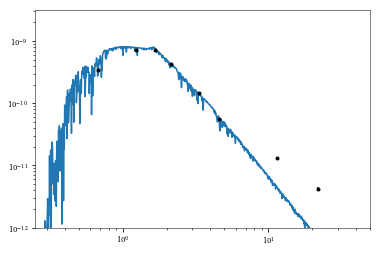

1516833627.45 207 9.36683091795
AWI00022y0 J211139.56+534446.4
[  3.96085603e-08   2.90909462e-08   6.12691792e-09   2.80084864e-09
   1.39347286e-09   4.33918814e-10   1.70865022e-10   1.33833791e-11
   3.32340853e-12]
[  6.93135811e-10   2.67937516e-10   1.52363699e-10   9.28683696e-11
   2.31018469e-11   1.12723481e-11   3.14745002e-12   2.09551311e-13
   1.53048619e-13]
[ 7.104       7.082       7.001       7.048       7.056       7.01271048
  7.041       6.97        6.334     ]
[ 0.019       0.01        0.027       0.036       0.018       0.02820527
  0.02        0.017       0.05      ]
[  57.14401078  108.57362048   40.21245203   30.15933902   60.31867804
   38.49409283   54.28681024   63.86683557   21.7147241 ]
11241.2308012 2.56603783e-10
Fit W1 flux: 4.20423606752e-10
Observed W1 flux: 4.33918814322e-10
Observed W1 uncertainty: 1.12723481031e-11
Difference (Observed - Fit): 1.34952075703e-11
Significance: 1.19719577916
 
Fit K flux: 1.40150362531e-09
Observed K flux: 1.3934728

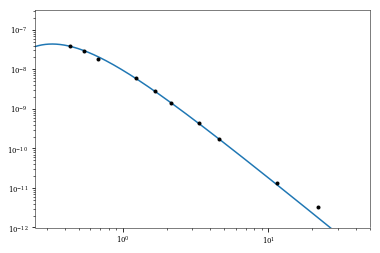

1516833633.47 208 9.35072115408
AWI0006228 J211412.49-015843.1
[  6.56733328e-10   1.49333707e-09   2.88165552e-09   2.18016639e-09
   1.37562011e-09   6.81476568e-10   3.26263684e-10   3.57244689e-11
   6.65554663e-12]
[  8.64969460e-11   8.94019278e-11   5.04279535e-11   1.52608566e-10
   2.91408377e-11   2.53467087e-11   5.75635447e-12   4.93551777e-13
   2.14549474e-13]
[ 11.555       10.306        7.82         7.32         7.07         6.52260437
   6.33871108   5.904        5.58      ]
[ 0.143       0.065       0.019       0.076       0.023       0.04038266
  0.01915592  0.015       0.035     ]
[  7.59256087  16.70363392  57.14401078  14.28600269  47.20592195
  26.88619564  56.678873    72.38241365  31.02103442]
3762.37950436 6.19645584566e-10
Fit W1 flux: 5.35167782343e-10
Observed W1 flux: 6.81476568458e-10
Observed W1 uncertainty: 2.53467086824e-11
Difference (Observed - Fit): 1.46308786115e-10
Significance: 5.77229919467
 
Fit K flux: 1.3554933189e-09
Observed K flux: 1.37562

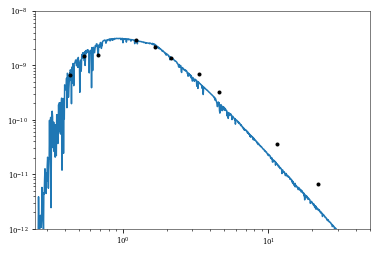

1516833645.64 209 9.36422487994
AWI000622o J212547.34-022251.3
[  1.20331637e-10   1.61451492e-10   1.38321484e-10   8.96393122e-11
   3.55543443e-11   2.28377422e-11   5.69856861e-11   3.23283642e-11]
[  1.19193739e-12   3.86626030e-12   2.80277349e-12   1.56865630e-12
   7.20428749e-13   4.41721096e-13   7.34800591e-13   6.25286001e-13]
[ 12.56247302  10.949       10.314       10.035        9.729        9.226
   5.397        3.864     ]
[ 0.01075469  0.026       0.022       0.019       0.022       0.021       0.014
  0.021     ]
[ 100.95466292   41.7590848    49.35164567   57.14401078   49.35164567
   51.70172404   77.55258605   51.70172404]
3507.69281859 1.70574123329e-10
Fit W1 flux: 3.59850510093e-11
Observed W1 flux: 3.5554344336e-11
Observed W1 uncertainty: 7.20428748681e-13
Difference (Observed - Fit): -4.30706673293e-13
Significance: -0.597847703998
 
Fit K flux: 8.81395124838e-11
Observed K flux: 8.96393122357e-11
Observed K uncertainty: 1.56865629516e-12
Difference (Observed

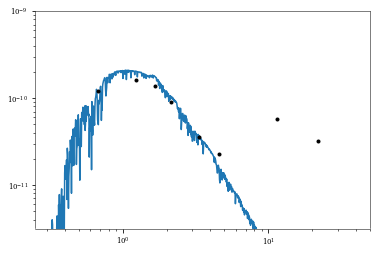

1516833658.96 210 9.38303333351
AWI0005zv8 J212636.95+075307.6
[  8.79405255e-09   9.72204993e-09   4.42223749e-09   2.48021677e-09
   1.41807276e-09   4.57062489e-10   1.92776090e-10   4.29107180e-11
   2.42987387e-11]
[  1.94390921e-10   1.25360745e-10   1.30337000e-10   1.53052393e-10
   3.39584253e-11   1.35732699e-11   3.55106680e-12   5.53311246e-13
   4.92359239e-13]
[ 8.738       8.272       7.355       7.18        7.037       6.95629273
  6.91        5.705       4.174     ]
[ 0.024       0.014       0.032       0.067       0.026       0.03224284
  0.02        0.014       0.022     ]
[ 45.23900853  77.55258605  33.9292564   16.20501798  41.7590848
  33.67372001  54.28681024  77.55258605  49.35164567]
6327.57142429 3.85940565175e-10
Fit W1 flux: 4.55546688249e-10
Observed W1 flux: 4.5706248937e-10
Observed W1 uncertainty: 1.35732698756e-11
Difference (Observed - Fit): 1.51580112082e-12
Significance: 0.11167545733
 
Fit K flux: 1.37410100447e-09
Observed K flux: 1.41807276344e-09

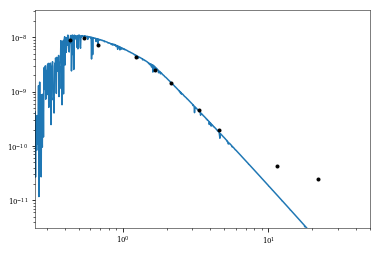

1516833668.82 211 9.38529383854
AWI00019fp J212952.96+525601.9
[  3.54641093e-08   2.50817507e-08   5.36095377e-09   2.41484711e-09
   1.21254682e-09   3.78965750e-10   1.50194202e-10   1.16779277e-11
   2.71133844e-12]
[  6.20609383e-10   2.31011461e-10   1.13565281e-10   5.33797532e-11
   3.01535160e-11   1.01895779e-11   2.76667944e-12   1.93603840e-13
   1.34850689e-13]
[ 7.224       7.243       7.146       7.209       7.207       7.15973178
  7.181       7.118       6.555     ]
[ 0.019       0.01        0.023       0.024       0.027       0.02919312
  0.02        0.018       0.054     ]
[  57.14401078  108.57362048   47.20592195   45.23900853   40.21245203
   37.19150636   54.28681024   60.31867804   20.10622601]
11243.2909646 2.39340073078e-10
Fit W1 flux: 3.65836956603e-10
Observed W1 flux: 3.78965750176e-10
Observed W1 uncertainty: 1.01895778713e-11
Difference (Observed - Fit): 1.31287935732e-11
Significance: 1.28845313702
 
Fit K flux: 1.21956357483e-09
Observed K flux: 1.2125

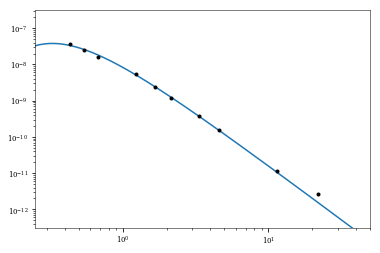

1516833672.66 212 9.35915566053
AWI0002coc J213519.16+573638.1
[  7.71291643e-11   8.34914613e-11   7.53858160e-11   7.53179543e-11
   5.12026778e-11   3.52738746e-11   4.38698128e-11   3.65076376e-11]
[  8.74467228e-13   1.84556346e-12   1.94412127e-12   1.38740799e-12
   1.08466641e-12   6.49768783e-13   6.06083862e-13   5.71621206e-13]
[ 13.04537602  11.665       10.973       10.224        9.333        8.754
   5.681        3.732     ]
[ 0.01230975  0.024       0.028       0.02        0.023       0.02        0.015
  0.017     ]
[ 88.20132048  45.23900853  38.77629303  54.28681024  47.20592195
  54.28681024  72.38241365  63.86683557]
3384.06608383 1.47961045609e-10
Fit W1 flux: 2.54288643244e-11
Observed W1 flux: 5.12026777794e-11
Observed W1 uncertainty: 1.0846664077e-12
Difference (Observed - Fit): 2.5773813455e-11
Significance: 23.7619725955
 
Fit K flux: 6.1151114137e-11
Observed K flux: 7.53179543041e-11
Observed K uncertainty: 1.38740799052e-12
Difference (Observed - Fit): 1.41

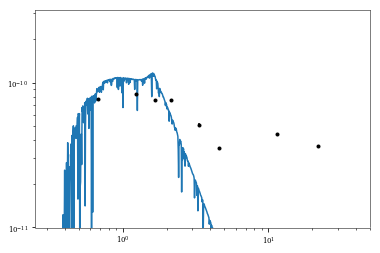

1516833689.71 213 9.39525821623
AWI0006235 J214241.32-013159.7
[  9.56288771e-10   2.02003013e-09   2.27427021e-09   1.75585901e-09
   9.91969949e-10   3.34392956e-10   1.21521513e-10   1.26172812e-11
   3.17090865e-12]
[  7.22235096e-11   7.44206602e-11   4.39882857e-11   6.14538246e-11
   2.46682283e-11   8.98556431e-12   2.35043444e-12   1.97556072e-13
   1.86912947e-13]
[ 11.147        9.978        8.077        7.555        7.425        7.29558888
   7.411        7.034        6.385     ]
[ 0.082       0.04        0.021       0.038       0.027       0.02917511
  0.021       0.017       0.064     ]
[ 13.24068542  27.14340512  51.70172404  28.57200539  40.21245203
  37.21446366  51.70172404  63.86683557  16.9646282 ]
4300.39508192 4.56427124931e-10
Fit W1 flux: 3.60937122636e-10
Observed W1 flux: 3.34392956334e-10
Observed W1 uncertainty: 8.98556430681e-12
Difference (Observed - Fit): -2.65441663015e-11
Significance: -2.95409007104
 
Fit K flux: 9.67071599046e-10
Observed K flux: 9.91

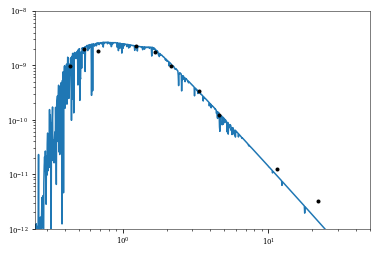

1516833702.32 214 9.41028037361
AWI0001q3p J214537.00+570201.1
[  2.62490255e-11   1.17717780e-10   1.31368016e-10   1.27437873e-10
   9.27454631e-11   6.73369074e-11   3.01276863e-11   6.39710870e-11]
[  3.44500553e-13   2.71055205e-12   3.62983242e-12   2.11274314e-12
   1.87927802e-12   1.11635251e-12   3.32983495e-13   8.83793229e-13]
[ 14.21563962  11.292       10.37         9.653        8.688        8.052
   6.089        3.123     ]
[ 0.01424955  0.025       0.03        0.018       0.022       0.018       0.012
  0.015     ]
[ 76.19443655  43.42944819  36.19120683  60.31867804  49.35164567
  60.31867804  90.47801706  72.38241365]
2359.03703942 3.45198343141e-10
Fit W1 flux: 6.8403608541e-11
Observed W1 flux: 9.27454631114e-11
Observed W1 uncertainty: 1.87927802307e-12
Difference (Observed - Fit): 2.43418545703e-11
Significance: 12.9527692399
 
Fit K flux: 1.29393331171e-10
Observed K flux: 1.27437873426e-10
Observed K uncertainty: 2.11274314296e-12
Difference (Observed - Fit): -1

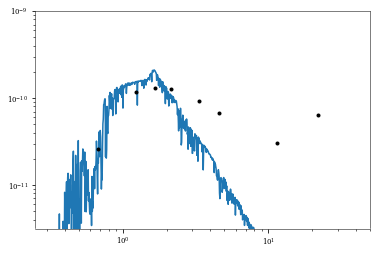

1516833712.4 215 9.41339069743
AWI0002oe7 J214622.33+623151.8
[  3.69308290e-09   3.06872412e-09   8.18167195e-10   4.10477768e-10
   2.13451158e-10   6.54173089e-11   2.63665415e-11   4.29898353e-12
   4.25386527e-12]
[  1.15649472e-10   5.65279873e-11   2.03461155e-11   1.17199839e-11
   3.93191564e-12   1.38578607e-12   4.85689643e-13   8.31497133e-14
   1.76307962e-13]
[ 9.68   9.524  9.187  9.133  9.093  9.067  9.07   8.203  6.066]
[ 0.034  0.02   0.027  0.031  0.02   0.023  0.02   0.021  0.045]
[ 31.93341779  54.28681024  40.21245203  35.02374854  54.28681024
  47.20592195  54.28681024  51.70172404  24.12747122]
8841.72701147 1.17823993493e-10
Fit W1 flux: 6.59498078906e-11
Observed W1 flux: 6.54173088624e-11
Observed W1 uncertainty: 1.38578606594e-12
Difference (Observed - Fit): -5.32499028117e-13
Significance: -0.384257744544
 
Fit K flux: 2.12536239085e-10
Observed K flux: 2.13451158231e-10
Observed K uncertainty: 3.9319156402e-12
Difference (Observed - Fit): 9.14919145335e-13

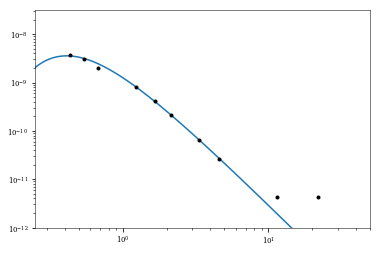

1516833717.68 216 9.39426388895
AWI0000phs J215221.25-031028.9
[  6.58550458e-08   4.54734440e-08   8.17413983e-09   3.74360174e-09
   1.91998801e-09   5.87302998e-10   2.28587863e-10   1.82879818e-11
   7.27752541e-12]
[  1.15244004e-09   4.18825897e-10   1.95745186e-10   6.20637232e-11
   5.48196034e-11   1.96452991e-11   4.21074404e-12   2.52657806e-13
   2.74816793e-13]
[ 6.552       6.597       6.688       6.733       6.708       6.68407614
  6.725       6.631       5.483     ]
[ 0.019      0.01       0.026      0.018      0.031      0.0363179  0.02
  0.015      0.041    ]
[  57.14401078  108.57362048   41.7590848    60.31867804   35.02374854
   29.89534519   54.28681024   72.38241365   26.48137085]
12881.008582 2.70995838139e-10
Fit W1 flux: 5.51330569848e-10
Observed W1 flux: 5.87302997568e-10
Observed W1 uncertainty: 1.96452990898e-11
Difference (Observed - Fit): 3.59724277203e-11
Significance: 1.83109595614
 
Fit K flux: 1.86648864115e-09
Observed K flux: 1.91998800603e-09
Obs

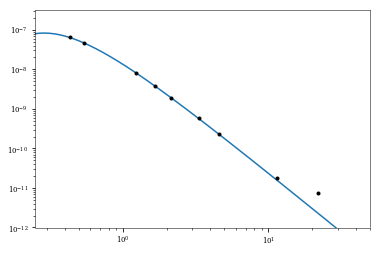

1516833724.75 217 9.38355299515
AWI0000ns8 J215739.35-083351.4
[  5.53846042e-08   3.77535545e-08   7.12593838e-09   3.19513815e-09
   1.75913235e-09   5.96653966e-10   2.54852162e-10   2.82986541e-11
   8.21833293e-12]
[  1.07123322e-09   3.82495396e-10   1.57517563e-10   1.29484563e-10
   3.40246362e-11   2.21773736e-11   4.30254879e-12   4.17024379e-13
   2.87635845e-13]
[ 6.74        6.799       6.837       6.905       6.803       6.66692536
  6.60691211  6.157       5.351     ]
[ 0.021       0.011       0.024       0.044       0.021       0.04035635
  0.01832997  0.016       0.038     ]
[ 51.70172404  98.70329134  45.23900853  24.67582284  51.70172404
  26.90372521  59.23283472  67.8585128   28.57200539]
12031.9929454 2.69341012126e-10
Fit W1 flux: 5.02431912711e-10
Observed W1 flux: 5.96653965551e-10
Observed W1 uncertainty: 2.21773736111e-11
Difference (Observed - Fit): 9.42220528403e-11
Significance: 4.2485667822
 
Fit K flux: 1.68834511246e-09
Observed K flux: 1.75913235192e-0

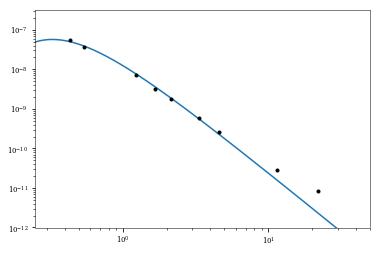

1516833730.28 218 9.36588532115
AWI0000psm J215947.70-593411.9
[  1.16035013e-08   1.05234429e-08   3.25418368e-09   1.61766891e-09
   8.96393122e-10   2.66761129e-10   1.06329352e-10   8.91591216e-12
   1.91594806e-12]
[  2.24431613e-10   1.06616940e-10   6.29414925e-11   5.06575565e-11
   2.55938659e-11   6.66640587e-12   1.95865904e-12   1.39601596e-13
   1.44701577e-13]
[ 8.437       8.186       7.688       7.644       7.535       7.54092532
  7.556       7.411       6.932     ]
[ 0.021       0.011       0.021       0.034       0.031       0.02713273
  0.02        0.017       0.082     ]
[ 51.70172404  98.70329134  51.70172404  31.93341779  35.02374854
  40.01573468  54.28681024  63.86683557  13.24068542]
7994.5746346 2.56589531762e-10
Fit W1 flux: 2.75014960694e-10
Observed W1 flux: 2.66761128603e-10
Observed W1 uncertainty: 6.66640587161e-12
Difference (Observed - Fit): -8.25383209047e-12
Significance: -1.23812324804
 
Fit K flux: 8.71140884591e-10
Observed K flux: 8.96393122357e

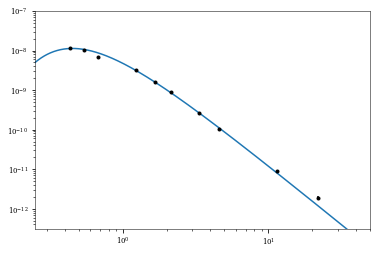

1516833735.47 219 9.34680821906
AWI0002360 J220614.20+600204.6
[  3.17552173e-11   3.57801422e-11   2.71449871e-11   2.75993285e-11
   3.66178359e-11   3.45027067e-11   1.72729208e-11   6.81057423e-12]
[  3.05692431e-13   9.55687136e-13   7.75045170e-13   5.59238261e-13
   7.41978011e-13   6.35563345e-13   2.38634219e-13   2.13274203e-13]
[ 14.00888486  12.585       12.082       11.314        9.697        8.778
   6.693        5.555     ]
[ 0.01045187  0.029       0.031       0.022       0.022       0.02        0.015
  0.034     ]
[ 103.87963231   37.43917947   35.02374854   49.35164567   49.35164567
   54.28681024   72.38241365   31.93341779]
3461.89044092 9.00918304549e-11
Fit W1 flux: 9.81150877916e-12
Observed W1 flux: 3.66178359051e-11
Observed W1 uncertainty: 7.41978011217e-13
Difference (Observed - Fit): 2.68063271259e-11
Significance: 36.1281961469
 
Fit K flux: 2.38729788924e-11
Observed K flux: 2.75993285026e-11
Observed K uncertainty: 5.59238261004e-13
Difference (Observed -

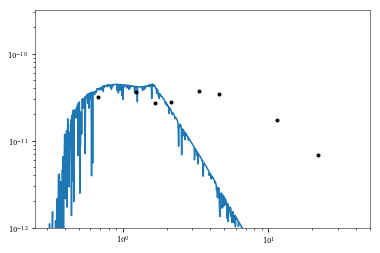

1516833745.94 220 9.35191363638
AWI0005aap J221513.24+711142.2
[  6.55178349e-11   1.03381317e-10   7.21256334e-11   4.91698084e-11
   2.93557158e-11   2.71052344e-11   3.10860672e-11   1.41639287e-11]
[  6.30505371e-13   1.80913653e-12   1.99290490e-12   1.13217668e-12
   6.21865109e-13   4.99296869e-13   4.29469889e-13   2.73954668e-13]
[ 13.22252374  11.433       11.021       10.687        9.937        9.04
   6.055        4.76      ]
[ 0.01044849  0.019       0.03        0.025       0.023       0.02        0.015
  0.021     ]
[ 103.91320668   57.14401078   36.19120683   43.42944819   47.20592195
   54.28681024   72.38241365   51.70172404]
3385.78146308 1.40180058727e-10
Fit W1 flux: 2.28451036758e-11
Observed W1 flux: 2.93557157739e-11
Observed W1 uncertainty: 6.21865108522e-13
Difference (Observed - Fit): 6.51061209802e-12
Significance: 10.4694925134
 
Fit K flux: 5.49522760856e-11
Observed K flux: 4.91698083707e-11
Observed K uncertainty: 1.1321766778e-12
Difference (Observed - F

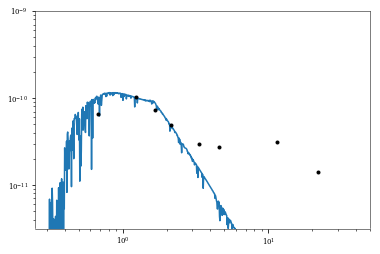

1516833759.52 221 9.37104072398
AWI0000hdq J222222.91-531805.1
[  1.92215788e-10   3.26706554e-10   3.18890853e-10   2.39711925e-10
   1.32342251e-10   4.23538285e-11   1.61529990e-11   3.51047416e-12
   3.97359619e-12]
[  3.54074566e-12   9.32814355e-12   6.16789593e-12   5.51957106e-12
   2.80350950e-12   8.97214307e-13   2.97549238e-13   7.11318562e-14
   1.79331050e-13]
[ 12.889  11.956  10.21    9.717   9.612   9.539   9.602   8.423   6.14 ]
[ 0.02   0.031  0.021  0.025  0.023  0.023  0.02   0.022  0.049]
[ 54.28681024  35.02374854  51.70172404  43.42944819  47.20592195
  47.20592195  54.28681024  49.35164567  22.15788173]
373171916859.0 1.35905211012e-15
Fit W1 flux: 4.76793637216e-13
Observed W1 flux: 4.23538285409e-11
Observed W1 uncertainty: 8.97214306911e-13
Difference (Observed - Fit): 4.18770349037e-11
Significance: 46.6745063928
 
Fit K flux: 1.78117644768e-12
Observed K flux: 1.32342250532e-10
Observed K uncertainty: 2.80350949789e-12
Difference (Observed - Fit): 1.305610

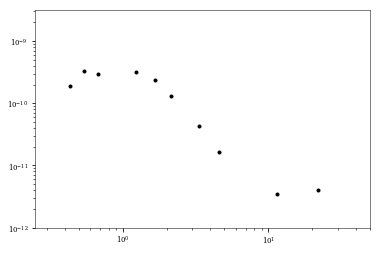

1516833764.07 222 9.3493108105
AWI0005w29 J222412.79+484918.7
[  2.31307149e-08   1.79538605e-08   4.18448545e-09   1.91994877e-09
   9.88322120e-10   3.05089329e-10   1.18755345e-10   8.80168418e-12
   1.98236550e-12]
[  4.04779339e-10   1.65361166e-10   1.11767552e-10   7.42702029e-11
   1.54747313e-11   7.91186105e-12   2.29693202e-12   1.45919713e-13
   1.18678696e-13]
[ 7.688       7.606       7.415       7.458       7.429       7.39516414
  7.436       7.425       6.895     ]
[ 0.019       0.01        0.029       0.042       0.017       0.02815632
  0.021       0.018       0.065     ]
[  57.14401078  108.57362048   37.43917947   25.85086202   63.86683557
   38.56100693   51.70172404   60.31867804   16.70363392]
10180.2729107 2.30342345945e-10
Fit W1 flux: 3.0035174366e-10
Observed W1 flux: 3.0508932858e-10
Observed W1 uncertainty: 7.9118610458e-12
Difference (Observed - Fit): 4.73758491995e-12
Significance: 0.598795263532
 
Fit K flux: 9.88461349804e-10
Observed K flux: 9.8832212

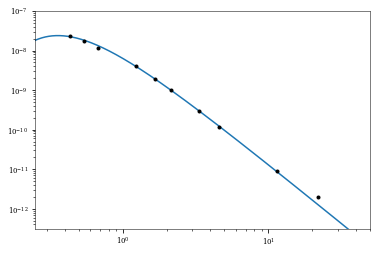

1516833769.44 223 9.33148878893
AWI0005abb J222653.92+733429.0
[  1.98147709e-08   1.37074871e-08   2.65241859e-09   1.21699737e-09
   5.98271777e-10   1.85135354e-10   7.24191072e-11   6.47687896e-12
   2.03978189e-12]
[  3.65001570e-10   1.38875684e-10   4.39734204e-11   1.90552320e-11
   8.81645872e-12   3.93402101e-12   1.33400925e-12   1.07377668e-13
   1.23994764e-13]
[ 7.856       7.899       7.91        7.953       7.974       7.93750828
  7.973       7.758       6.864     ]
[ 0.02        0.011       0.018       0.017       0.016       0.02307128
  0.02        0.018       0.066     ]
[ 54.28681024  98.70329134  60.31867804  63.86683557  67.8585128
  47.06008275  54.28681024  60.31867804  16.45054856]
12161.2436595 1.60103491873e-10
Fit W1 flux: 1.79798769354e-10
Observed W1 flux: 1.8513535413e-10
Observed W1 uncertainty: 3.93402100704e-12
Difference (Observed - Fit): 5.33658477625e-12
Significance: 1.35652167762
 
Fit K flux: 6.04913529965e-10
Observed K flux: 5.98271776854e-10

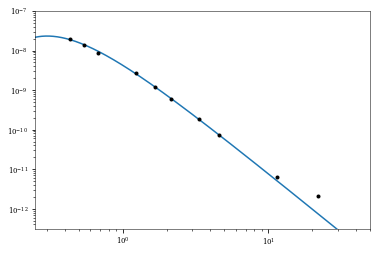

1516833770.99 224 9.29673660759
AWI0005abf J222753.27+704806.0
[  2.07104272e-08   1.65408509e-08   4.57553690e-09   2.15025339e-09
   1.12330713e-09   3.56804813e-10   1.40298545e-10   1.05333322e-11
   2.76174598e-12]
[  4.00575175e-10   1.67581554e-10   9.69271802e-11   1.08925111e-10
   1.75882697e-11   1.02523073e-11   2.58439470e-12   1.55224920e-13
   1.06833806e-13]
[ 7.808       7.695       7.318       7.335       7.29        7.22515493
  7.255       7.23        6.535     ]
[ 0.021       0.011       0.023       0.055       0.017       0.03119717
  0.02        0.016       0.042     ]
[ 51.70172404  98.70329134  47.20592195  19.74065827  63.86683557
  34.80239141  54.28681024  67.8585128   25.85086202]
8959.08007963 2.68688104932e-10
Fit W1 flux: 3.48707746797e-10
Observed W1 flux: 3.56804813044e-10
Observed W1 uncertainty: 1.0252307344e-11
Difference (Observed - Fit): 8.09706624639e-12
Significance: 0.789779897804
 
Fit K flux: 1.12615354454e-09
Observed K flux: 1.12330713056e-

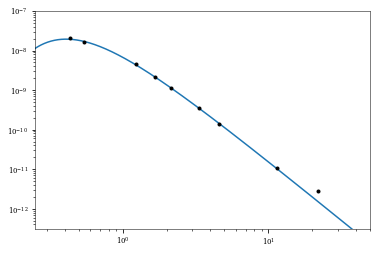

1516833774.79 225 9.27229333348
AWI0002cu6 J222906.46+631045.9
[  3.52603687e-11   7.08666760e-11   7.03541370e-11   5.83040221e-11
   3.13395441e-11   1.84949502e-11   1.28282017e-11   1.12197642e-11]
[  3.40695776e-13   1.76230676e-12   2.07355375e-12   9.66599800e-13
   6.35025310e-13   3.23655095e-13   2.36304209e-13   2.99679757e-13]
[ 13.89520546  11.843       11.048       10.502        9.866        9.455
   7.016        5.013     ]
[ 0.01049069  0.027       0.032       0.018       0.022       0.019       0.02
  0.029     ]
[ 103.49517437   40.21245203   33.9292564    60.31867804   49.35164567
   57.14401078   54.28681024   37.43917947]
2906.27774542 1.72097164771e-10
Fit W1 flux: 2.60084028573e-11
Observed W1 flux: 3.13395440785e-11
Observed W1 uncertainty: 6.35025309744e-13
Difference (Observed - Fit): 5.33114122121e-12
Significance: 8.39516337288
 
Fit K flux: 5.72795982856e-11
Observed K flux: 5.83040221193e-11
Observed K uncertainty: 9.66599799794e-13
Difference (Observed - 

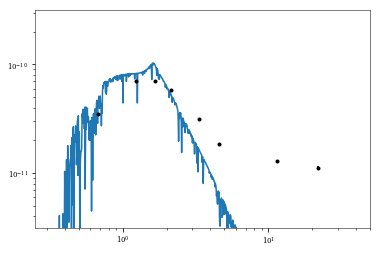

1516833786.84 226 9.28459734516
AWI0005yfu J223445.16+375006.0
[  9.88528185e-10   9.31875400e-10   2.42349463e-10   1.20472976e-10
   6.28200844e-11   1.99936771e-11   8.07333859e-12   2.80909082e-12
   5.45486153e-12]
[  9.28677467e-11   5.40722046e-11   4.91066630e-12   2.55207337e-12
   1.15718872e-12   4.05126857e-13   1.56152212e-13   6.46817066e-14
   2.21060978e-13]
[ 11.111  10.818  10.508  10.464  10.421  10.354  10.355   8.665   5.796]
[ 0.102  0.063  0.022  0.023  0.02   0.022  0.021  0.025  0.044]
[ 10.6444726   17.23390801  49.35164567  47.20592195  54.28681024
  49.35164567  51.70172404  43.42944819  24.67582284]
8790.01083964 6.43501915286e-11
Fit W1 flux: 1.95266290334e-11
Observed W1 flux: 1.99936771102e-11
Observed W1 uncertainty: 4.05126857239e-13
Difference (Observed - Fit): 4.67048076796e-13
Significance: 1.15284402515
 
Fit K flux: 6.28686887263e-11
Observed K flux: 6.28200844251e-11
Observed K uncertainty: 1.1571887195e-12
Difference (Observed - Fit): -4.8604301

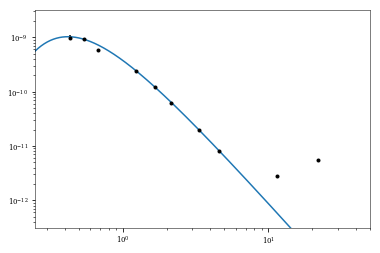

1516833791.12 227 9.26255506566
AWI0000gjb J224206.62-032824.4
[  3.65249017e-08   2.70992859e-08   5.58781556e-09   2.51472002e-09
   1.32830717e-09   4.10046423e-10   1.57853119e-10   1.18512943e-11
   3.15633965e-12]
[  6.72813554e-10   2.74553012e-10   1.08077935e-10   9.26457095e-11
   2.44683222e-11   1.14098824e-11   2.76237381e-12   1.85562572e-13
   1.62797390e-13]
[ 7.192       7.159       7.101       7.165       7.108       7.07414912
  7.127       7.102       6.39      ]
[ 0.02        0.011       0.021       0.04        0.02        0.03021151
  0.019       0.017       0.056     ]
[ 54.28681024  98.70329134  51.70172404  27.14340512  54.28681024
  35.93783074  57.14401078  63.86683557  19.38814651]
11139.882203 2.50481429064e-10
Fit W1 flux: 3.9625597964e-10
Observed W1 flux: 4.10046423326e-10
Observed W1 uncertainty: 1.14098824232e-11
Difference (Observed - Fit): 1.37904436858e-11
Significance: 1.20864029745
 
Fit K flux: 1.31946898742e-09
Observed K flux: 1.32830716637e-09

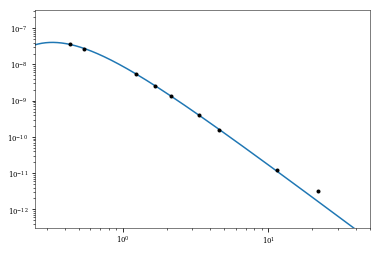

1516833796.29 228 9.24461842106
AWI0000hog J224414.01-090123.9
[  4.52260914e-09   5.05542704e-09   2.26590690e-09   1.24994136e-09
   6.57201454e-10   2.08576118e-10   8.13304484e-11   7.12140658e-12
   3.33260415e-12]
[  1.24964309e-10   8.38119668e-11   4.38265250e-11   4.60495416e-11
   1.99750620e-11   4.43474580e-12   1.42325411e-12   1.24622099e-13
   2.08722046e-13]
[ 9.46        8.982       8.081       7.924       7.872       7.80807024
  7.847       7.655       6.331     ]
[ 0.03        0.018       0.021       0.04        0.033       0.02308493
  0.019       0.019       0.068     ]
[ 36.19120683  60.31867804  51.70172404  27.14340512  32.90109711
  47.03226003  57.14401078  57.14401078  15.96670889]
6457.52406986 2.65787010605e-10
Fit W1 flux: 2.22169432948e-10
Observed W1 flux: 2.08576117578e-10
Observed W1 uncertainty: 4.43474579892e-12
Difference (Observed - Fit): -1.35933153702e-11
Significance: -3.06518478997
 
Fit K flux: 6.7338308567e-10
Observed K flux: 6.57201454177e

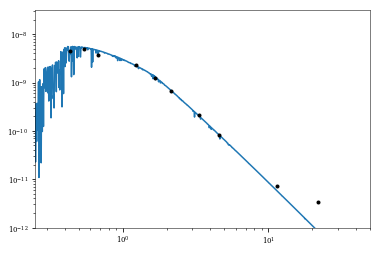

1516833807.62 229 9.25368995646
AWI00023d1 J224836.29+624808.6
[  3.93480216e-11   6.14387063e-11   5.22985490e-11   4.52166638e-11
   3.77826725e-11   3.29194952e-11   2.93336281e-11   2.20995653e-11]
[  3.79286515e-13   1.35809135e-12   1.39689357e-12   9.57859987e-13
   8.00379931e-13   6.06399511e-13   4.05259048e-13   3.86734585e-13]
[ 13.77611533  11.998       11.37        10.778        9.663        8.829
   6.118        4.277     ]
[ 0.01046571  0.024       0.029       0.023       0.023       0.02        0.015
  0.019     ]
[ 103.74221085   45.23900853   37.43917947   47.20592195   47.20592195
   54.28681024   72.38241365   57.14401078]
3147.69361715 1.36523686584e-10
Fit W1 flux: 1.90060118401e-11
Observed W1 flux: 3.77826725274e-11
Observed W1 uncertainty: 8.00379930522e-13
Difference (Observed - Fit): 1.87766606873e-11
Significance: 23.4596845464
 
Fit K flux: 4.39264149156e-11
Observed K flux: 4.5216663787e-11
Observed K uncertainty: 9.57859987115e-13
Difference (Observed - 

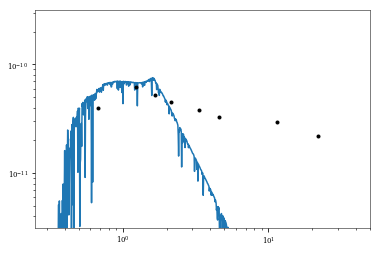

1516833817.33 230 9.25571304404
AWI0002opj J224952.84+654925.9
[  1.04434036e-09   1.88664262e-09   1.62516895e-09   6.89764485e-10
   2.62873204e-10   9.12359043e-11   3.77036791e-11]
[  2.01993334e-11   6.60311585e-11   2.39493747e-11   2.62978997e-11
   4.87014374e-12   1.17643923e-12   6.59801064e-13]
[ 8.922       7.477       6.889       6.50947961  6.57326712  4.886       3.697     ]
[ 0.021       0.038       0.016       0.04139468  0.02011499  0.014       0.019     ]
[ 51.70172404  28.57200539  67.8585128   26.22888115  53.97647762
  77.55258605  57.14401078]
1998.79948393 1.52914004583e-09
Fit W1 flux: 9.17223151675e-10
Observed W1 flux: 6.8976448543e-10
Observed W1 uncertainty: 2.62978996925e-11
Difference (Observed - Fit): -2.27458666244e-10
Significance: -8.64930921877
 
Fit K flux: 1.48856457468e-09
Observed K flux: 1.62516894809e-09
Observed K uncertainty: 2.39493746781e-11
Difference (Observed - Fit): 1.36604373406e-10
Significance: 5.70388059154
True
K excess detected. T

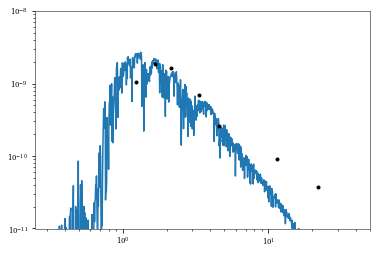

1516833828.09 231 9.26220779192
AWI0000jcg J230112.67-585821.9
[  1.63451555e-10   3.12577596e-10   3.44541914e-10   2.28923111e-10
   1.27908238e-10   4.11237466e-11   1.72446017e-11   8.79358126e-12
   2.79243923e-12]
[  3.17648780e-11   3.22441958e-11   7.29870110e-12   5.27114944e-12
   2.59177249e-12   9.09032888e-13   3.49423032e-13   1.45785378e-13
   1.74891347e-13]
[ 13.065  12.004  10.126   9.767   9.649   9.571   9.531   7.426   6.523]
[ 0.211  0.112  0.023  0.025  0.022  0.024  0.022  0.018  0.068]
[  5.14566922   9.69407326  47.20592195  43.42944819  49.35164567
  45.23900853  49.35164567  60.31867804  15.96670889]
0.0 inf
Fit W1 flux: nan
Observed W1 flux: 4.11237465751e-11
Observed W1 uncertainty: 9.09032887986e-13
Difference (Observed - Fit): nan
Significance: nan
 
Fit K flux: nan
Observed K flux: 1.27908237813e-10
Observed K uncertainty: 2.59177249461e-12
Difference (Observed - Fit): nan
Significance: nan
False
Initial fit fail. Retrying with W1.
0.0 inf
Fitting faile

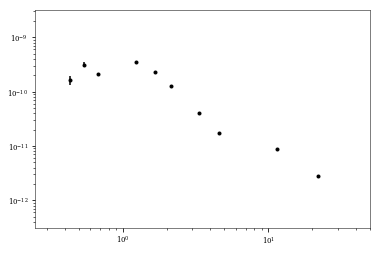

1516833837.98 232 9.26492241436
AWI00062gs J230533.05+145732.5
[  5.40242886e-08   3.90623032e-08   7.99543436e-09   3.55213645e-09
   1.80841673e-09   5.71159071e-10   2.15304530e-10   1.58258039e-11
   4.21874942e-12]
[  9.45405963e-10   3.59777109e-10   1.47281344e-10   5.56178558e-11
   2.66498138e-11   1.80414114e-11   4.16435880e-12   2.33217666e-13
   2.17594261e-13]
[ 6.767       6.762       6.712       6.79        6.773       6.71433899
  6.79        6.788       6.075     ]
[ 0.019       0.01        0.02        0.017       0.016       0.03429555
  0.021       0.016       0.056     ]
[  57.14401078  108.57362048   54.28681024   63.86683557   67.8585128
   31.6582255    51.70172404   67.8585128    19.38814651]
11597.7981227 2.85747359224e-10
Fit W1 flux: 5.41249288002e-10
Observed W1 flux: 5.71159070646e-10
Observed W1 uncertainty: 1.80414114088e-11
Difference (Observed - Fit): 2.99097826438e-11
Significance: 1.65784050738
 
Fit K flux: 1.81106838689e-09
Observed K flux: 1.80841

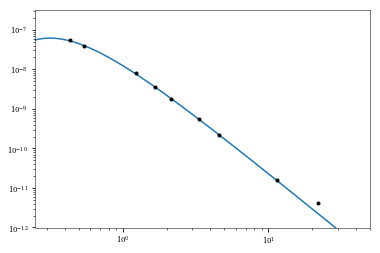

1516833841.3 233 9.23937768281
AWI0005w41 J230817.21+511146.3
[  1.33840964e-08   9.93934687e-09   2.63294667e-09   1.22486899e-09
   6.42833522e-10   1.96051312e-10   7.87504722e-11   6.59729313e-12
   1.61727447e-12]
[  2.46544167e-10   1.00699245e-10   4.85006700e-11   2.25629206e-11
   1.24335026e-11   4.34834439e-12   1.45063731e-12   1.03297636e-13
   1.16186057e-13]
[ 8.282      8.248      7.918      7.946      7.896      7.8753073  7.882
  7.738      7.116    ]
[ 0.02        0.011       0.02        0.02        0.021       0.02408122
  0.02        0.017       0.078     ]
[ 54.28681024  98.70329134  54.28681024  54.28681024  51.70172404
  45.08642705  54.28681024  63.86683557  13.91969493]
9359.98353156 1.96002403777e-10
Fit W1 flux: 1.96022160583e-10
Observed W1 flux: 1.96051311923e-10
Observed W1 uncertainty: 4.34834438591e-12
Difference (Observed - Fit): 2.91513400401e-14
Significance: 0.00670400903262
 
Fit K flux: 6.37360915945e-10
Observed K flux: 6.42833521667e-10
Observed

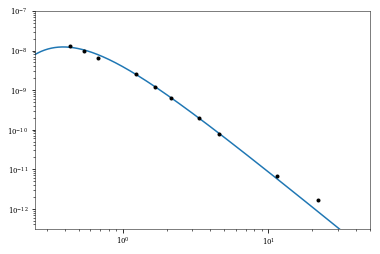

1516833843.4 234 9.20890598317
AWI00062kw J232421.82+061110.7
[  4.08685337e-08   2.67767490e-08   4.71674136e-09   2.09937316e-09
   1.02352514e-09   3.02556852e-10   1.15200182e-10   8.88312516e-12
   3.88672426e-12]
[  7.52826212e-10   2.71285269e-10   7.81970280e-11   5.02734475e-11
   1.69686269e-11   7.84586347e-12   2.22816907e-12   1.55451552e-13
   2.36267152e-13]
[ 7.07       7.172      7.285      7.361      7.391      7.4042142  7.469
  7.415      6.164    ]
[ 0.02        0.011       0.018       0.026       0.018       0.02815516
  0.021       0.019       0.066     ]
[ 54.28681024  98.70329134  60.31867804  41.7590848   60.31867804
  38.56259455  51.70172404  57.14401078  16.45054856]
13750.8498935 1.93805174423e-10
Fit W1 flux: 3.043850072e-10
Observed W1 flux: 3.0255685202e-10
Observed W1 uncertainty: 7.84586347278e-12
Difference (Observed - Fit): -1.82815518016e-12
Significance: -0.233008793296
 
Fit K flux: 1.03730849678e-09
Observed K flux: 1.02352514324e-09
Observed K 

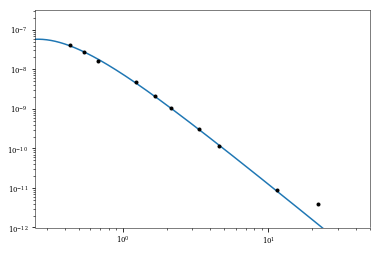

1516833844.94 235 9.17623829842
AWI0000ojv J234708.47+153903.2
[  1.02373855e-08   6.87001756e-09   1.26719095e-09   5.56787710e-10
   3.02899472e-10   9.92870653e-11   4.49007057e-11   6.34696029e-12
   1.99335078e-12]
[  2.45153492e-10   9.49128001e-11   2.68438979e-11   1.33333312e-11
   5.02165302e-12   2.19472240e-12   8.68456643e-13   1.11069563e-13
   1.35859850e-13]
[ 8.573  8.649  8.712  8.802  8.713  8.614  8.492  7.78   6.889]
[ 0.026  0.015  0.023  0.026  0.018  0.024  0.021  0.019  0.074]
[ 41.7590848   72.38241365  47.20592195  41.7590848   60.31867804
  45.23900853  51.70172404  57.14401078  14.67211088]
12573.2849437 1.09033324619e-10
Fit W1 flux: 8.6742659653e-11
Observed W1 flux: 9.92870653047e-11
Observed W1 uncertainty: 2.19472239838e-12
Difference (Observed - Fit): 1.25444056517e-11
Significance: 5.71571405156
 
Fit K flux: 2.92906554511e-10
Observed K flux: 3.02899471601e-10
Observed K uncertainty: 5.02165301748e-12
Difference (Observed - Fit): 9.99291708914e-12
S

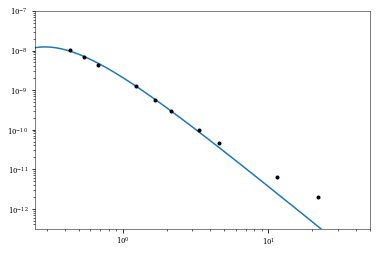

1516833847.78 236 9.14940677962
AWI00019pi J235135.40+631323.1
[  4.31905820e-10   4.97230599e-10   3.03139174e-10   1.74779157e-10
   1.03680842e-10   3.81674086e-11   1.86317293e-11   2.79103820e-12
   9.09460268e-13]
[  3.97799961e-12   4.57966306e-12   7.53844042e-12   4.99030413e-12
   2.00536528e-12   7.73376613e-13   3.60369595e-13   6.16953884e-14
   8.37643862e-14]
[ 12.01   11.5    10.265  10.06    9.877   9.652   9.447   8.672   7.741]
[ 0.01   0.01   0.027  0.031  0.021  0.022  0.021  0.024  0.1  ]
[ 108.57362048  108.57362048   40.21245203   35.02374854   51.70172404
   49.35164567   51.70172404   45.23900853   10.85736205]
3.93246903916e+14 6.54406690163e-17
Fit W1 flux: 1.16495742859e-12
Observed W1 flux: 3.81674085906e-11
Observed W1 uncertainty: 7.73376613318e-13
Difference (Observed - Fit): 3.7002451162e-11
Significance: 47.8453195051
 
Fit K flux: 4.35197657638e-12
Observed K flux: 1.03680842057e-10
Observed K uncertainty: 2.00536527534e-12
Difference (Observed - Fit

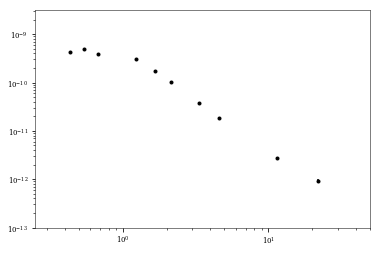

1516833852.2 237 9.12952742597
AWI0005ae4 J235449.26+742436.2
[  6.31232072e-08   4.58097421e-08   1.07756149e-08   5.08732684e-09
   2.55210487e-09   7.83511949e-10   3.07510113e-10   2.26655249e-11
   4.82151731e-12]
[  1.10463382e-09   4.21923317e-10   1.88569454e-10   1.12454428e-10
   4.93620844e-11   3.28069241e-11   5.75917187e-12   3.34011519e-13
   1.99835170e-13]
[ 6.598       6.589       6.388       6.4         6.399       6.37111763
  6.40298441  6.398       5.93      ]
[ 0.019       0.01        0.019       0.024       0.021       0.04546155
  0.0203341   0.016       0.045     ]
[  57.14401078  108.57362048   57.14401078   45.23900853   51.70172404
   23.88251778   53.39484915   67.8585128    24.12747122]
10171.9804128 3.71435241194e-10
Fit W1 flux: 7.80216216606e-10
Observed W1 flux: 7.83511948597e-10
Observed W1 uncertainty: 3.2806924113e-11
Difference (Observed - Fit): 3.29573199084e-12
Significance: 0.100458426992
 
Fit K flux: 2.56741449262e-09
Observed K flux: 2.55210

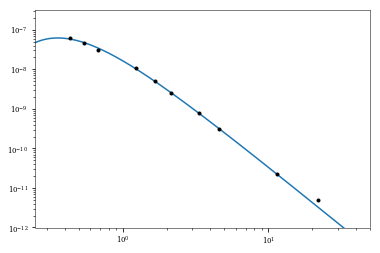

1516833856.36 238 9.10856722683
AWI00062l3 J235537.71+081323.7
[  5.14030699e-08   3.70986279e-08   7.57952627e-09   3.49051606e-09
   1.80675188e-09   5.50325287e-10   2.08666709e-10   1.64651534e-11
   3.49288052e-12]
[  8.99535562e-10   3.41690990e-10   1.81506044e-10   1.51099552e-10
   3.32815996e-11   1.84025182e-11   4.03597197e-12   2.27474501e-13
   2.21977268e-13]
[ 6.821       6.818       6.77        6.809       6.774       6.75468301
  6.824       6.745       6.28      ]
[ 0.019       0.01        0.026       0.047       0.02        0.03630631
  0.021       0.015       0.069     ]
[  57.14401078  108.57362048   41.7590848    23.10077031   54.28681024
   29.90489027   51.70172404   72.38241365   15.73530732]
11286.8224849 2.88718046265e-10
Fit W1 flux: 5.34838967747e-10
Observed W1 flux: 5.50325286898e-10
Observed W1 uncertainty: 1.84025181801e-11
Difference (Observed - Fit): 1.54863191513e-11
Significance: 0.841532609816
 
Fit K flux: 1.78379430809e-09
Observed K flux: 1.806

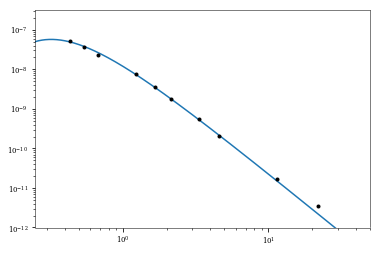

1516833861.78 239 9.09314225907
AWI0003cp6 J235652.35+611338.1
[  2.24589297e-09   2.37989528e-09   1.23492921e-09   7.06788769e-10
   4.21986459e-10   1.62066284e-10   8.08077783e-11   1.06405918e-11
   2.83911988e-12]
[  2.06854387e-11   2.19196456e-11   2.38856485e-11   2.60390605e-11
   6.21862228e-12   3.43317697e-12   1.48853429e-12   1.66605902e-13
   1.25516450e-13]
[ 10.22    9.8     8.74    8.543   8.353   8.082   7.854   7.219   6.505]
[ 0.01   0.01   0.021  0.04   0.016  0.023  0.02   0.017  0.048]
[ 108.57362048  108.57362048   51.70172404   27.14340512   67.8585128
   47.20592195   54.28681024   63.86683557   22.61950427]
6105.28852749 2.12065372772e-10
Fit W1 flux: 1.30894460967e-10
Observed W1 flux: 1.62066283927e-10
Observed W1 uncertainty: 3.43317696691e-12
Difference (Observed - Fit): 3.11718229594e-11
Significance: 9.0795852529
 
Fit K flux: 3.91380935367e-10
Observed K flux: 4.21986459469e-10
Observed K uncertainty: 6.21862227852e-12
Difference (Observed - Fit): 3.

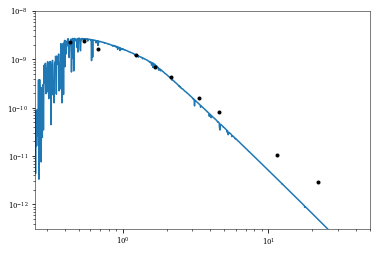

1516833871.69 240 9.09653749963
AWI0002d1k J235734.08+662553.7
[  1.15183178e-09   1.69729701e-09   1.35656954e-09   7.04838535e-10
   4.01881964e-10   1.52367617e-10   7.18212843e-11   9.25903618e-12
   2.50255557e-12]
[  6.47134527e-11   5.47143912e-11   3.37350615e-11   1.81770479e-11
   8.14323329e-12   3.36805827e-12   1.32299695e-12   1.70557750e-13
   1.35991393e-13]
[ 10.945  10.167   8.638   8.546   8.406   8.149   7.982   7.37    6.642]
[ 0.061  0.035  0.027  0.028  0.022  0.024  0.02   0.02   0.059]
[ 17.79895418  31.02103442  40.21245203  38.77629303  49.35164567
  45.23900853  54.28681024  54.28681024  18.40230856]
5245.72206927 2.48860710948e-10
Fit W1 flux: 1.45150384783e-10
Observed W1 flux: 1.52367616589e-10
Observed W1 uncertainty: 3.36805826508e-12
Difference (Observed - Fit): 7.21723180553e-12
Significance: 2.14284648231
 
Fit K flux: 4.16257229109e-10
Observed K flux: 4.01881963747e-10
Observed K uncertainty: 8.14323328603e-12
Difference (Observed - Fit): -1.437526

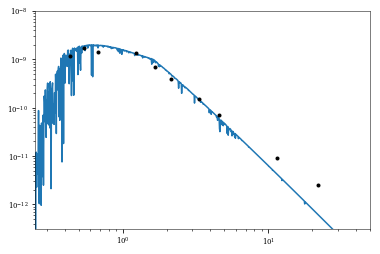

1516833883.85 241 9.10923651442
AWI0000o39 J235746.21+112827.6
[  5.88015882e-08   4.35469605e-08   9.02073786e-09   4.37008254e-09
   2.14436404e-09   6.64581548e-10   2.57352485e-10   1.91322383e-11
   4.22263682e-12]
[  9.74848755e-10   4.01082328e-10   1.91093352e-10   1.36849822e-10
   3.16005163e-11   2.28616318e-11   4.33496363e-12   2.81943083e-13
   2.17794766e-13]
[ 6.675       6.644       6.581       6.565       6.588       6.54986099
  6.596312    6.582       6.074     ]
[ 0.018       0.01        0.023       0.034       0.016       0.03734937
  0.01828864  0.016       0.056     ]
[  60.31867804  108.57362048   47.20592195   31.93341779   67.8585128
   29.0697337    59.36670003   67.8585128    19.38814651]
11050.4264367 3.21171859797e-10
Fit W1 flux: 6.45173972415e-10
Observed W1 flux: 6.6458154842e-10
Observed W1 uncertainty: 2.28616318042e-11
Difference (Observed - Fit): 1.94075760052e-11
Significance: 0.848914730648
 
Fit K flux: 2.1461758702e-09
Observed K flux: 2.144364

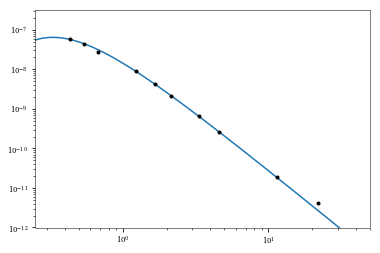

1516833889.33 242 9.09426033103
Star fits done
Time elapsed: 2200.81100011


In [20]:
def fluxdrive_plot(spectname, binsize):
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    with open(spectname) as f:
        spectfilelist = f.readlines()
        
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict

def lnlike_star_blackbody(theta, wav, flux, fluxerr):
    log10Teff, log10rdstar = theta

    Teff = 10.**log10Teff
    rdstar = 10.**log10rdstar
    
    centwavs_angstroms = wav * 1.e10 * u.AA
    centwavs_meters = wav * u.m
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Teff*u.K) * np.pi * u.sr
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    model = flux_lam * (rdstar**2)
    
    #print Teff, rdstar
    #print "flux:", flux
    #print "model:", model

    inv_sigma2 = 1./(fluxerr**2)
    
    #print -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
    return -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
def star_fitter_blackbody(centwavs, log10Teff, log10rdstar):
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    centwavs_meters = centwavs * u.m
    
    #print log10Teff, log10rdstar
    
    Teff = 10.**(log10Teff)
    rdstar = 10.**(log10rdstar)
    
    #print Teff, rdstar
    
    #print centwavs_angstroms
    #print Teff
    
    #print blackbody_lambda(centwavs_angstroms[0], Teff*u.K)
    
    #flux_lam_temp = []
    #for wav in centwavs_angstroms:
    #    flux_lam_temp.append(blackbody_lambda(wav, Teff*u.K) * np.pi * u.sr)
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Teff*u.K) * np.pi * u.sr 
    
    #print flux_lam_temp
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    #print flux_lam 
    
    return flux_lam * (rdstar**2)


def get_chi2(mags, magerrs, result_mags):
    chis = np.zeros(mags.size)
    
    for i in range(mags.size):
        chis[i] = ((mags[i] - result_mags[i])**2)/magerrs[i]
        
    sumchis = np.sum(chis)
    
    return sumchis

cent_wavs_dict = {}
    
cent_wavs_dict_keys = np.array([0.673, 0.4361, 0.5448, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]) * 1.e-6

for i in range(cent_wavs_dict_keys.size):
    cent_wavs_dict[cent_wavs_dict_keys[i]] = i
    
print cent_wavs_dict

def star_fitter_models(centwavs, mags, magerrs, guess):
    fit_results_dict = {model: None for model in btsettl_models_dict.keys()}
    fit_chi_dict = {model: None for model in btsettl_models_dict.keys()}
    
    magerrs_use = np.array(magerrs)
    
    for i in range(centwavs.size):
        if centwavs[i] == cent_wavs_dict_keys[0]:
            magerrs_use[i] = magerrs[i] * 10.
    
    log10Teff_guess = guess[0]
    Teff_guess = 10.**log10Teff_guess
    difTeffguess = 7000. - Teff_guess
    
    mindifTeffguess = Teff_guess - difTeffguess
    
    log10rdstar_guess = guess[1]
    
    keys_use = []
    
    for model in btsettl_models_dict.keys():
        Teff = model[0]
        logg = model[1]
        
        if Teff < mindifTeffguess:
            continue
        else:
            keys_use.append(model)
            
            def lnlike_rdstar(theta, centwavs, mags, magerrs):
                log10rdstar = theta[0]
                
                magerrs_use = np.array(magerrs)
                
                fitmagsfull = btsettl_models_dict[(Teff, logg)]
                
                fitmagsuse = []
                
                #print centwavs
                
                for i in range(len(centwavs)):
                    #print cent_wavs_dict[centwavs[i]]
                    fitmagsuse.append(fitmagsfull[cent_wavs_dict[centwavs[i]]])
                    if centwavs[i] == cent_wavs_dict_keys[0]:
                        magerrs_use[i] = 10.*magerrs[i]

                #print fitmagsuse
                
                result_mags = fitmagsuse - 5.*log10rdstar
                
                inv_sigma2 = 1./(magerrs_use**2)
                
                return -0.5*np.sum((((mags - result_mags)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
            nll1 = lambda *args: -lnlike_rdstar(*args)
    
            result1 = minimize(nll1, [log10rdstar_guess], args = (centwavs, mags, magerrs))
        
            log10rdstar_opt = result1["x"][0]
            
            #popt, pcov = curve_fit(fit_rdstar, centwavs, mags, sigma=magerrs)
        
            fit_mags_full = btsettl_models_dict[(Teff, logg)]
            
            #print Teff, logg, log10rdstar_opt
            #print fit_mags_full
            
            fit_mags_use = []
            
            for i in range(len(centwavs)):
                fit_mags_use.append(fit_mags_full[cent_wavs_dict[centwavs[i]]])
                
            fit_result_mags = fit_mags_use - 5.*log10rdstar_opt
            
            #print Teff, logg, log10rdstar_opt
            #print fit_result_mags
            #print mags
            
            fit_results_dict[model] = 10.**log10rdstar_opt
            fit_chi_dict[model] = get_chi2(mags, magerrs_use, fit_result_mags)
            
            #print fit_chi_dict[model]
    
    fit_chi_dict_use = {x: fit_chi_dict[x] for x in keys_use}
    fit_results_dict_use = {x: fit_results_dict[x] for x in keys_use}
    
    minchi = min(fit_chi_dict_use.values())
    
    best_model = fit_chi_dict_use.keys()[fit_chi_dict_use.values().index(minchi)]
    
    best_rdstar = (fit_results_dict_use[best_model])
    
    return best_model[0], best_model[1], best_rdstar

plotting_logx_vec = np.linspace(np.log10(0.25), np.log10(100.), 1001)
plotting_x_vec = np.zeros(1001)
    
for i in range(1001):
    plotting_x_vec[i] = 10.**(plotting_logx_vec[i])
    
plotting_xvec_angstroms = plotting_x_vec * 1.e4

btsettl_df = pd.read_csv('btsettl_combo_readin.csv',low_memory=False)
btsettl_data = btsettl_df.values

num_models = btsettl_data[:,0].size

btsettl_models_dict = {}

#print num_models

keylist = []

for i in range(num_models):
    if float(btsettl_data[i,0]) > 2400.:
    #print btsettl_data[i,0]
    #print btsettl_data[i,1]
    #print btsettl_data[i,2:]
        key = (float(btsettl_data[i,0]), float(btsettl_data[i,1]))
        keylist.append(key)
        btsettl_models_dict[key] = btsettl_data[i,2:]

#for key in keylist:
#    btsettl_models_dict[key] = btsettl_data[i,2:]
    
def get_star_fit(subj):
    #print subj.nuFnu.size
    #print subj.nuFnuerrs.size
    if subj.has_vmag or subj.has_bmag:
        nuFnu_full_use = subj.nuFnu_nogaia
        nuFnu_full_err_use = subj.nuFnuerrs_nogaia
        mags_full_use = subj.mags_nogaia
        magerrs_full_use = subj.magerrs_nogaia
        cent_wavs_full_use = subj.centwavs_meters_nogaia
        
        nuFnu_use = subj.nuFnu_nogaia[:-4]
        nuFnu_err_use = subj.nuFnuerrs_nogaia[:-4]
        mags_use = subj.mags_nogaia[:-4]
        magerrs_use = subj.magerrs_nogaia[:-4]
        cent_wavs_use = subj.centwavs_meters_nogaia[:-4]        
    #elif (subj.jmag < 14.5) and ((subj.jmag - subj.hmag) > 0.):
    #    nuFnu_full_use = subj.nuFnu_long
    #    nuFnu_full_err_use = subj.nuFnuerrs_long
    #    mags_full_use = subj.mags_long
    #    magerrs_full_use = subj.magerrs_long
    #    cent_wavs_full_use = subj.centwavs_meters_long
    #    
    #    nuFnu_use = subj.nuFnu_nogaia[:-4]
    #    nuFnu_err_use = subj.nuFnuerrs_nogaia[:-4]
    #    mags_use = subj.mags_nogaia[:-4]
    #    magerrs_use = subj.magerrs_nogaia[:-4]
    #    cent_wavs_use = subj.centwavs_meters_nogaia[:-4]                
    else:
        nuFnu_full_use = subj.nuFnu_nops
        nuFnu_full_err_use = subj.nuFnuerrs_nops
        mags_full_use = subj.mags_nops
        magerrs_full_use = subj.magerrs_nops
        cent_wavs_full_use = subj.centwavs_meters_nops
        
        nuFnu_use = subj.nuFnu_nops[:-3]
        nuFnu_err_use = subj.nuFnuerrs_nops[:-3]
        mags_use = subj.mags_nops[:-3]
        magerrs_use = subj.mags_nops[:-3]
        cent_wavs_use = subj.centwavs_meters_nops[:-3]
        
    print nuFnu_full_use
    print nuFnu_full_err_use
    print mags_full_use
    print magerrs_full_use
    
    print nuFnu_full_use/nuFnu_full_err_use
    
    #mags_use = subj.mags[:-3]
    #magerrs_use = subj.magerrs[:-3]
    
    #print nuFnu_use
    #print nuFnu_err_use
    #print cent_wavs_use
    
    Teff_guess = 10000.
    rdstar_guess = 1.e-10
    
    use_w1 = False
    use_w2 = False
    k_excess = False
    
    log10Teff_guess = np.log10(Teff_guess)
    log10rdstar_guess = np.log10(rdstar_guess)
    
    #print nuFnu_use
    
    #popt, pcov = curve_fit(star_fitter_blackbody, cent_wavs_use, nuFnu_use, sigma = nuFnu_err_use, p0 = [logTeff_guess, logrdstar_guess])
    #Teff_opt = 10.**(popt[0])
    #rdstar_opt = 10.**(popt[1])

    nll = lambda *args: -lnlike_star_blackbody(*args)
    
    #print len(cent_wavs_use)
    #print len(nuFnu_use)
    #print len(nuFnu_err_use)
    
    result = minimize(nll, [log10Teff_guess, log10rdstar_guess], args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))
    
    log10Teff_opt, log10rdstar_opt = result["x"]
    
    Teff_opt = 10.**log10Teff_opt
    rdstar_opt = 10.**log10rdstar_opt
    
    print Teff_opt, rdstar_opt
    
    #chi2test = 
    
    nuFnu_star = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, Teff_opt * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (rdstar_opt**2) * u.cm * u.cm * u.s / u.erg)

    nuFnu_star_test = nuFnu_star[:-4]
    
    #print len(nuFnu_use)
    #print len(nuFnu_star_test)
    #print len(nuFnu_err_use)
    
    #chi2test = np.sum(np.square(nuFnu_use - nuFnu_star_test)/nuFnu_err_use) / len(nuFnu_use)

    print 'Fit W1 flux:', nuFnu_star[-4]
    print 'Observed W1 flux:', nuFnu_full_use[-4]
    print 'Observed W1 uncertainty:', nuFnu_full_err_use[-4]
    print 'Difference (Observed - Fit):', nuFnu_full_use[-4] - nuFnu_star[-4]
    print 'Significance:', (nuFnu_full_use[-4] - nuFnu_star[-4])/nuFnu_full_err_use[-4]
    print ' '
    
    print 'Fit K flux:', nuFnu_star[-5]
    print 'Observed K flux:', nuFnu_full_use[-5]
    print 'Observed K uncertainty:', nuFnu_full_err_use[-5]
    print 'Difference (Observed - Fit):', nuFnu_full_use[-5] - nuFnu_star[-5]
    print 'Significance:', (nuFnu_full_use[-5] - nuFnu_star[-5])/nuFnu_full_err_use[-5]
    
    if ((nuFnu_full_use[-5] - nuFnu_star[-5])/nuFnu_full_err_use[-5]) > 5.:
        k_excess = True
    
    #nuFnu_remain = nuFnu_full_use - nuFnu_star
    
    if ((nuFnu_full_use[-4] - nuFnu_star[-4])/nuFnu_full_err_use[-4]) < 5.:
        use_w1 = True
        
    print k_excess
    
    #if nuFnu_remain[-4] < (nuFnu_full_use[-4] - (3.*(nuFnu_full_err_use[-4]))):
    #    use_w1=True

    if Teff_opt > 15000. or Teff_opt < 1000. or (rdstar_opt == 0.0):
        print 'Initial fit fail. Retrying with W1.'
        k_excess = False
        use_w1 = True
        
        Teff_guess = 10000.
        rdstar_guess = 1.e-10
        
        log10Teff_guess = np.log10(Teff_guess)
        log10rdstar_guess = np.log10(rdstar_guess)
        
        cent_wavs_use_spec = cent_wavs_full_use[:-3]
        nuFnu_use_spec = nuFnu_full_use[:-3]
        nuFnu_err_use_spec = nuFnu_full_err_use[:-3]
        
        
        result = minimize(nll, [log10Teff_guess, log10rdstar_guess], args = (cent_wavs_use_spec, nuFnu_use_spec, nuFnu_err_use_spec))
        
        log10Teff_opt, log10rdstar_opt = result["x"]
    
        Teff_opt = 10.**log10Teff_opt
        rdstar_opt = 10.**log10rdstar_opt
    
        print Teff_opt, rdstar_opt
        
        if Teff_opt > 15000. or Teff_opt < 1000. or (rdstar_opt == 0.0):
            print "Fitting failed after adding in W1 mag."
            subj.fitfail = True
            return subj
            

    if k_excess:
        print 'K excess detected. Trying fitting without K.'
        nuFnu_full_use_short = nuFnu_full_use[:-1]
        nuFnu_full_err_use_short = nuFnu_full_err_use[:-1] 
        mags_full_use_short = mags_full_use[:-1]
        magerrs_full_use_short = magerrs_full_use[:-1]
        cent_wavs_full_use_short = cent_wavs_full_use[:-1]

        log10Teff_guess = np.log10(10000.)
        log10rdstar_guess = np.log10(1.e-10)

        result = minimize(nll, [log10Teff_guess, log10rdstar_guess], args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))
    
        log10Teff_opt, log10rdstar_opt = result["x"]
    
        Teff_opt = 10.**log10Teff_opt
        rdstar_opt = 10.**log10rdstar_opt
    
        print Teff_opt, rdstar_opt


    use_models = False
    
    if math.isnan(Teff_opt) or math.isnan(rdstar_opt) or (rdstar_opt == 0.0):
        print 'Fitting failed'
        #plt.errorbar(cent_wavs_full_use, nuFnu_full_use, yerr=nuFnu_full_err_use)
        #plt.xscale('log', nonposx='clip')
        #plt.yscale('log', nonposy='clip')
        #plt.show()
        
        subj.fitfail = True
        
        return subj
        
        
    if Teff_opt < 5000.:
        use_models = True
    elif Teff_opt < 7000. and not use_w1:
        use_models = True
    elif Teff_opt > 5000. and Teff_opt < 7000. and use_w1:
        print "W1 significantly low. Refitting with W2 included"
        #popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])
        print len(cent_wavs_full_use), len(nuFnu_full_use), len(nuFnu_full_err_use)
        result = minimize(nll, [log10Teff_opt, log10rdstar_opt], args = (cent_wavs_full_use[:-3], nuFnu_full_use[:-3], nuFnu_full_err_use[:-3]))
        log10Teff_opt_new, log10rdstar_opt_new = result["x"]
        print 10.**log10Teff_opt_new, 10.**log10rdstar_opt_new
        if (10.**log10Teff_opt) < 7000.:
            use_models = True
    
    #Teff_opt = popt[0]
    #rdstar_opt = popt[1]
    
    model_star_plotting = False
    
    if use_models:
        if use_w1:
            cent_wavs_fit = cent_wavs_full_use[:-3]
            mags_fit = mags_full_use[:-3]
            magerrs_fit = magerrs_full_use[:-3]
            print "W1 significantly low. Refitting with W1 included"

        else:
            cent_wavs_fit = cent_wavs_full_use[:-4]
            mags_fit = mags_full_use[:-4]
            magerrs_fit = magerrs_full_use[:-4]
        Teff_use, logg_use, rdstar_use = star_fitter_models(cent_wavs_fit, mags_fit, magerrs_fit, [log10Teff_opt, log10rdstar_opt])

        print Teff_use, logg_use, rdstar_use
        
        model_mags = btsettl_models_dict[(Teff_use, logg_use)][:-3]
        
        model_mags_at_d = model_mags - 5.*np.log10(rdstar_use)
        
        model_mags_full = btsettl_models_dict[(Teff_use, logg_use)]
        model_mags_full_at_d = model_mags_full - (5.*np.log10(rdstar_use))

        print model_mags_full_at_d
        print mags_full_use
        
        chi2model = np.sum(np.array([((mags_fit[i] - model_mags_at_d[i])**2) for i in range(len(mags_fit))]) / magerrs_fit) / len(mags_fit)
        
        fluxes_at_d = np.zeros(mags_full_use.size)
        
        for i in range(fluxes_at_d.size):
            fluxes_at_d[i] = filterzps_nogaia[i] * 10.**(-0.4*model_mags_full_at_d[i]) * 10.**(-23.)
            
        nuFnu_model = (c / cent_wavs_full_use) * fluxes_at_d
        
        nuFnu_remain = nuFnu_full_use - nuFnu_model
        
        if (nuFnu_remain[-3] < (nuFnu_full_use[-3] - (3.*nuFnu_full_err_use[-3]))) and use_w1:
            use_w2 = True
            
        if use_w2:
            cent_wavs_refit = cent_wavs_full_use[:-2]
            mags_refit = mags_full_use[:-2]
            magerrs_refit = magerrs_full_use[:-2]
            print "W2 significantly low. Refitting with W2 included"

            Teff_use, logg_use, rdstar_use = star_fitter_models(cent_wavs_refit, mags_refit, magerrs_refit, [log10Teff_opt, log10rdstar_opt])

            print Teff_use, logg_use, rdstar_use
        
            model_mags = btsettl_models_dict[(Teff_use, logg_use)][:-2]
        
            model_mags_at_d = model_mags - 5.*np.log10(rdstar_use)
        
            model_mags_full = btsettl_models_dict[(Teff_use, logg_use)]
            model_mags_full_at_d = model_mags_full - (5.*np.log10(rdstar_use))

            print model_mags_full_at_d
            print mags_full_use
        
            chi2model = np.sum(np.array([((mags_fit[i] - model_mags_at_d[i])**2) for i in range(len(mags_fit))]) / magerrs_fit) / len(mags_fit)
        
            fluxes_at_d = np.zeros(mags_full_use.size)
        
            for i in range(fluxes_at_d.size):
                fluxes_at_d[i] = filterzps_nogaia[i] * 10.**(-0.4*model_mags_full_at_d[i]) * 10.**(-23.)
                
            subj.Teff = Teff_use
            subj.logg = logg_use
            subj.rdstar = rdstar_use
        else:
            subj.Teff = Teff_use
            subj.logg = logg_use
            subj.rdstar = rdstar_use
            
        #if not use_w2:
        #    cent_wavs_fit_short = cent_wavs_full_use[:-4]
        #    mags_fit_short = mags_full_use[:-4]
        #    magerrs_fit_short = magerrs_full_use[:-4]
            
        #    print Teff_opt
            
        #    Teff_use_short, logg_use_short, rdstar_use_short = star_fitter_models(cent_wavs_fit_short, mags_fit_short, magerrs_fit_short, [np.log10(Teff_opt), np.log10(rdstar_opt)])
            
        #    model_mags_short = np.array([btsettl_models_dict[(Teff_use_short, logg_use_short)][cent_wavs_dict[x]] for x in cent_wavs_fit_short])
            #for wav in cent_wavs_fit_short:
                
            #model_mags_short = btsettl_models_dict[(Teff_use_short, logg_use_short)][i][cent_wavs_dict[cent_wavs_fit_short]]
        #    model_mags_short_at_d = model_mags_short - 5.*np.log10(rdstar_use_short)
            
        #    print len(cent_wavs_fit_short)
        #    print len(mags_fit_short)
        #    print len(magerrs_fit_short)
            
            
        #    print len(mags_fit_short), len(model_mags_short_at_d), len(magerrs_fit_short)
            
        #    chi2short = np.sum(np.square(mags_fit_short - model_mags_short_at_d)/magerrs_fit_short) / len(mags_fit_short)
            #chi2testshort = np.sum(np.square(nuFnu_use - nuFnu_star_test_short)/nuFnu_err_use) / len(nuFnu_use)
            
        #    if chi2short < chi2model:
        #        print '2MASS only has better chi2'
        #        subj.Teff = Teff_use_short
        #        subj.logg = logg_use_short
        #        subj.rdstar = rdstar_use_short
        #    else:
        #        subj.Teff = Teff_use
        #        subj.logg = logg_use
        #        subj.rdstar = rdstar_use
        #else:
        #    subj.Teff = Teff_use
        #    subj.logg = logg_use
        #    subj.rdstar = rdstar_use
            
        if (subj.has_vmag) or (subj.has_bmag):
            subj.nuFnu_star = subj.centwavs_Hz_nogaia * fluxes_at_d
        else:
            subj.nuFnu_star = subj.centwavs_Hz_nops * fluxes_at_d
            
        #print 'nuFnu_star', subj.nuFnu_star.size
        
        teffpull = '0'+str(int(Teff_use/100))
        loggpull = str(logg_use)
        
        spect_file = 'BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
        spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
        
        #for i in range(spec_X.size):
        #    if spec_X[i] > 2500. and spec_X[i] < 50000.:
        #        print spec_X[i], spec_S[i]
        
        flux_spec_S = spec_X * spec_S * (rdstar_use**2)
        
        #spec_S_interp = np.interp(plotting_xvec_angstroms, spec_X, spec_S)
        
        spec_S_at_bands = np.interp(subj.centwavs_meters_nops * 1.e10, spec_X, flux_spec_S)
        
        spec_S_adjust_flux = 220800. * rdstar_use* np.interp(220800., spec_X, spec_S)
        
        #print 2208. * spec_S_adjust_flux * rdstar_use
        #print spec_S_adjust_flux
        #print subj.nuFnu_star[-1]
        
        print spec_S_at_bands
        print subj.nuFnu_star
        
        #print plotting_xvec_angstroms
        #print spec_S_interp
        
        #for i in range(spec_S_interp.size):
        #    print plotting_xvec_angstroms[i], spec_S_interp[i]
        
        #print subj.nuFnu_star[-1]/spec_S_adjust_flux
        
        subj.nuFnu_star_plotting = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)
        model_star_plotting = True
        
    else:
        if use_w1:
            print "W1 significantly low. Refitting with W1 included"
            
            result = minimize(nll, [log10Teff_opt, log10rdstar_opt], args = (cent_wavs_full_use[:-3], nuFnu_full_use[:-3], nuFnu_full_err_use[:-3]))
            #print subj.
    
            log10Teff_opt, log10rdstar_opt = result["x"]
    
            Teff_opt = 10.**log10Teff_opt
            rdstar_opt = 10.**log10rdstar_opt

            print Teff_opt, rdstar_opt
            
            #popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])

            #subj.Teff = Teff_opt
            #subj.Teff_err = (pcov[0,0])**2
            #subj.rdstar = rdstar_opt
            #subj.rdstar_err = (pcov[1,1])**2
        
            #print subj.Teff, subj.rdstar
            nuFnu_star = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, Teff_opt * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (rdstar_opt**2) * u.cm * u.cm * u.s / u.erg)

            nuFnu_star_test = nuFnu_star[:-4]
    
            #chi2test = np.sum(np.square(nuFnu_use - nuFnu_star_test)/nuFnu_err_use) / len(nuFnu_use)
    
            nuFnu_remain = nuFnu_full_use - nuFnu_star
    
            if nuFnu_remain[-3] < (nuFnu_full_use[-3] - (3.*(nuFnu_full_err_use[-3]))):
                use_w2=True

            
            if use_w2:
                print "W2 significantly low. Refitting with W2 included"
            
                result = minimize(nll, [log10Teff_opt, log10rdstar_opt], args = (cent_wavs_full_use[:-2], nuFnu_full_use[:-2], nuFnu_full_err_use[:-2]))
                #print subj.
    
                log10Teff_opt, log10rdstar_opt = result["x"]
    
                Teff_opt = 10.**log10Teff_opt
                rdstar_opt = 10.**log10rdstar_opt

                print Teff_opt, rdstar_opt
            
                #popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])

                subj.Teff = Teff_opt
                #subj.Teff_err = (pcov[0,0])**2
                subj.rdstar = rdstar_opt
                #subj.rdstar_err = (pcov[1,1])**2
        
                #print subj.Teff, subj.rdstar
            
        else:
            #nuFnu_shortened = nuFnu_full_use[:-4]
            #nuFnu_err_shortened = nuFnu_full_err_use[:-4]
            #cent_wavs_shortened = cent_wavs_full_use[:-4]

            #logTeff_guess = np.log10(Teff_opt)
            #logrdstar_guess = np.log10(rdstar_opt)
    
            #print nuFnu_use

            #result = minimize(nll, [logTeff_guess, logrdstar_guess], args = (cent_wavs_shortened, nuFnu_shortened, nuFnu_err_shortened))
    
            #log10Teff_opt_short, log10rdstar_opt_short = result["x"]
    
            #Teff_opt_short = 10.**log10Teff_opt_short
            #rdstar_opt_short = 10.**log10rdstar_opt_short
        
            #popt, pcov = curve_fit(star_fitter_blackbody, cent_wavs_use, nuFnu_use, sigma = nuFnu_err_use, p0 = [logTeff_guess, logrdstar_guess])
            #Teff_opt_short = 10.**(popt[0])
            #rdstar_opt_short = 10.**(popt[1])

            #chi2test = 
    
            #nuFnu_star = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, Teff_opt_short * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (rdstar_opt_short**2) * u.cm * u.cm * u.s / u.erg)

            #nuFnu_star_test_short = nuFnu_star[:-4]
    
            #chi2testshort = np.sum(np.square(nuFnu_shortened - nuFnu_star_test_short)/nuFnu_err_shortened) / len(nuFnu_shortened)

            #if chi2testshort < chi2test:
            #    print "2MASS only has better chi2"
            #    subj.Teff = Teff_opt_short
            #    subj.rdstar = rdstar_opt_short
            #else:
            subj.Teff = Teff_opt
            subj.rdstar = rdstar_opt
                
        if not model_star_plotting:
            #print len(cent_wavs_full_use)
            print subj.Teff
            print subj.rdstar
            subj.nuFnu_star = blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
        
        print nuFnu_use
        print subj.nuFnu_star
       
        #print subj.nuFnu
        #print subj.nuFnu_star
        if not model_star_plotting:    
            subj.nuFnu_star_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj.Teff*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
    
    #test_subj = get_star_fit_2mass(subj)
    
    if (subj.has_bmag or subj.has_vmag):
        subj.nuFnu_disk = subj.nuFnu_nogaia - subj.nuFnu_star
        subj.nuFnu_disk_errs = subj.nuFnuerrs_nogaia
    else:
        subj.nuFnu_disk = subj.nuFnu_nops - subj.nuFnu_star
        subj.nuFnu_disk_errs = subj.nuFnuerrs_nops
    
    #subj.nuFnu_disk_errs = subj.nuFnuerrs
    
    subj.sig_disk = subj.nuFnu_disk[-4:] / subj.nuFnu_disk_errs[-4:]
    
    subj.num_excesses = subj.sig_disk[subj.sig_disk > 5].size
    
    if subj.num_excesses < 1:
        subj.num_excesses = subj.sig_disk[subj.sig_disk > 3].size
    
    return subj

start_time = time.time()
subjs_with_star_fits = []

print start_time

f0 = open('has_no_fit.csv','w')
f1 = open('has_w3_excess.csv','w')
f2 = open('has_no_excess.csv','w')
f3 = open('has_w4_excess.csv','w')

for subj in raw_subjs:
    print subj.zooniverse_id, subj.wiseid
    subjs_with_star_fits.append(get_star_fit(subj))
    print subj.Teff, subj.logg, subj.rdstar

    if subj.fitfail:
        f0.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    elif subj.num_excesses > 1:
        f1.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    elif subj.num_excesses < 1:
        f2.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    else:
        f3.write(subj.zooniverse_id+','+subj.wiseid+'\n')
        
#    if subj.has_vmag or subj.has_bmag:
#        plt.errorbar(subj.centwavs_microns_nogaia, subj.)
#    else:
    plt.errorbar(subj.centwavs_microns_nops, subj.nuFnu_nops, yerr=subj.nuFnuerrs_nops, fmt='k.')
    if not subj.fitfail:
        plt.plot(plotting_x_vec, subj.nuFnu_star_plotting)
    
    ymin = float(np.floor((np.log10(min(subj.nuFnu_nops))-0.5)*2.))/2.
    ymax = float(np.ceil(2.*(np.log10(max(subj.nuFnu_nops))+0.5)))/2.

    
    #ymin = min(subj.nuFnu_star_plotting)
    #ymax = max(subj.nuFnu_star_flotting)
    
    plt.xscale("log", nonposx='clip')
    plt.yscale("log", nonposy='clip')
    plt.xlim([0.25, 50.])
    plt.ylim([10.**ymin, 10.**ymax])
    plt.show()
    
    print time.time(), len(subjs_with_star_fits), (time.time() - start_time)/len(subjs_with_star_fits)
    
star_fit_end_time = time.time()

f1.close()
f2.close()
f3.close()
    
print "Star fits done"
print "Time elapsed:", star_fit_end_time - start_time

In [ ]:
test = 9.16338e0
test1 = 9.15878e0

testsub = test - 8.
testsub1 = test1 - 8.

testexp = 10.**(testsub)
testexp1 = 10.**(testsub1)

print test
print testsub
print testexp
print 280000.*testexp
print 280000.*testexp*2.65882969187e-10

print test1
print testsub1
print testexp1
print 280800.*testexp1
print 280800.*testexp1*2.65882969187e-10

In [ ]:
def plot_subj(subj):
    plt.figure()
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
        
    plt.gcf().subplots_adjust(left = 0.18)
    plt.gcf().subplots_adjust(right=0.95)
    plt.gcf().subplots_adjust(top=0.95)
    plt.gcf().subplots_adjust(bottom=0.16)
    
    #ax = plt.subplot
    
    plt.errorbar(subj.centwavs_microns, subj.nuFnu, yerr=subj.nuFnuerrs, fmt='k.')
        
    #plt.plot(subj.centwavs_microns, subj.nuFnu_star, 'r.')
        
    #print subj.nuFnu
    #print subj.nuFnu_star
    

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    
    min_nuFnu_logs = min(np.log10(subj.nuFnu))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_star_plotting))

    ymin = float(np.floor((min_nuFnu_logs-1.5)*2.))/2.
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

    if subj.good_disk_fit:
        plt.plot(plotting_x_vec, subj.nuFnu_star_plotting, linestyle=':', label='Stellar fit')
        plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting, linestyle='--', label='Disk blackbody')
        plt.plot(plotting_x_vec, subj.nuFnu_model_plotting, label='Combined model')
        plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nTdisk = %.0f K\nLir/Lstar = %.4e' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    else:
        plt.plot(plotting_x_vec, subj.nuFnu_model_plotting)
        plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nNo good disk fit' % (subj.Teff), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)
        
    plt.legend(loc='lower left',fontsize=12)
    
    
    plt.xlim([0.25, 100.])
    plt.ylim([10.**(ymin), 10.**(ymax)])
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)
    
    #if len(subjs_with_star_fits) < 2:
    plt.savefig(subj.zooniverse_id+'_modelfit.pdf')
    
    plt.close()
    
    #plt.show()
    return

In [ ]:
wien_lamFlam_x = 3.90269

wien_lamFlam_factor = (h*c)/(wien_lamFlam_x*k)

def disk_fitter(centwavs, logTdisk, logxdisk):
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    centwavs_meters = centwavs * u.m
    
    Tdisk = 10.**logTdisk
    xdisk = 10.**logxdisk
    
    #print centwavs_angstroms
    #print Teff
    
    #print blackbody_lambda(centwavs_angstroms[0], Teff*u.K)
    
    #flux_lam_temp = []
    #for wav in centwavs_angstroms:
    #    flux_lam_temp.append(blackbody_lambda(wav, Teff*u.K) * np.pi * u.sr)
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr 
    
    #print flux_lam_temp
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    #print flux_lam 
    
    #print Tdisk, xdisk, max(flux_lam)
    
    #print xdisk
    
    return flux_lam * xdisk
    
def get_objective_function_value(subj, logTdiskguess, logxdiskguess):
    #Tdiskguess, xdiskguess = params
    #logTdiskguess = np.log10(Tdiskguess)
    #logxdiskguess = np.log10(xdiskguess)
    flux_lam_fit_disk = disk_fitter(subj.centwavs_meters, logTdiskguess, logxdiskguess)
    
    flux_lam_fit = flux_lam_fit_disk + subj.nuFnu_star
    
    flux_lam = subj.nuFnu
    flux_lam_errs = subj.nuFnuerrs
    
    #print min(flux_lam_errs)
    
    chiconts = np.zeros(flux_lam.size)
    
    for i in range(flux_lam.size):
        chiconts[i] = ((flux_lam[i] - flux_lam_fit[i])/flux_lam_errs[i])**2
        
    chisum = np.sum(chiconts)
    
    return chisum
        

def get_disk_fit(subj):
    subj.good_disk_fit = False
    nuFnu_use = subj.nuFnu_disk[-4:]
    nuFnu_err_use = subj.nuFnu_disk_errs[-4:]
    cent_wavs_use = subj.centwavs_meters[-4:]
    
    #print nuFnu_use
    #print nuFnu_err_use
    #print cent_wavs_use
    
    #Tstar = subj.Teff
    #rdstar = subj.rdstar
    
    #sig_nuFnu_use = nuFnu_use / nuFnu_err_use
    #print sig_nuFnu_use
    #print sig_nuFnu_use[sig_nuFnu_use > 5.]
    #print sig_nuFnu_use[sig_nuFnu_use > 5.].size
    
    if subj.num_excesses < 1:
        print "No significant excess"
        subj.nuFnu_model_plotting = subj.nuFnu_star_plotting
        return subj
    elif subj.num_excesses > 1:
        Tdiskguess = 200.
        xdiskguess = 1.e-3 * ((subj.Teff/Tdiskguess)**4)*(subj.rdstar**2)
        guess = [np.log10(200.), np.log10(xdiskguess)]
        popt, pcov = curve_fit(disk_fitter, cent_wavs_use, nuFnu_use, p0 = guess, sigma = nuFnu_err_use)
        
        subj.Tdisk = 10.**(popt[0])
        subj.xdisk = 10.**(popt[1])
        subj.fir = ((subj.Tdisk/subj.Teff)**4)*(subj.xdisk/(subj.rdstar**2))
        
        print "Excesses:", subj.num_excesses
        nuFnu_disk_points = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Tdisk * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
        print nuFnu_disk_points
        print subj.nuFnu_disk
        
        subj.good_disk_fit = True
        
        subj.nuFnu_disk_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj.Tdisk*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
        subj.nuFnu_model_plotting = subj.nuFnu_star_plotting  + subj.nuFnu_disk_plotting
        
        return subj
    
    else:
        print "Excesses:", subj.num_excesses
        #while not subj.good_disk_fit:
        #lambda_max_star = (2.8977729e-3 / Tstar)

        #peak_flux_star = blackbody_lambda((lambda_max_star*1.e10*u.AA), (Tstar*u.K))

        #lambda_max_disk = (2.8977729e-3 / 1.)
    
        #test_min_peak_flux_disk = blackbody_lambda((lambda_max_disk*1.e10*u.AA), (1.*u.K))
        #test_max_peak_flux_disk = blackbody_lambda(((2.8977729e-3/500.)*1.e10*u.AA), (500.*u.K))
    
        #test_min_peak_flux_disk_at_star = blackbody_lambda((lambda_max_star*1.e10*u.AA), (1.*u.K))
        #test_max_peak_flux_disk_at_star = blackbody_lambda(((lambda_max_star*1.e10*u.AA), (500.*u.K)))
    
        #test_min_peak_flux_star_at_disk = blackbody_lambda((lambda_max_disk*1.e10*u.AA), (Tstar*u.K))
        #test_max_peak_flux_star_at_disk = blackbody_lambda(((2.8977729e-3/500.)*1.e10*u.AA), (Tstar*u.K))
    
        #xdiskmax = 0.1 * rdstar * ((lambda_max_star * peak_flux_star) - (lambda_max_disk * test_min_peak_flux_star_at_disk))/((lambda_max_disk * test_min_peak_flux_disk) - (lambda_max_star * test_min_peak_flux_disk_at_star))
        #xdiskmin = 0.1* float((peak_flux_star / test_max_peak_flux_disk)) * (lambda_max_star/(2.8977729e-3/500.)) * rdstar
    
        #Tdiskmax = 0.1*Tstar
        #xdiskmax = 2.e14*rdstar
        #xdiskmin = float(1.e9*rdstar)
    
        #print xdiskmin, xdiskmax
    
        Tdiskvals = np.linspace(25., 300., 12)
        #xdiskvals = np.linspace(xdiskmin, 1.e11*rdstar, 51)
    
        #valgrid = np.zeros(51*51).reshape(51,51)
        #reschi = np.zeros(51*51).reshape(51,51)
    
        val_chi_dict = {}
        
        xdiskvals_dict = {}
        
        Tdiskval_minchis_dict = {}
    
        for i in range(12):
            Tdiskval = Tdiskvals[i]
        
            xdiskmax = (subj.rdstar**2) * 1.e-2 * ((subj.Teff/Tdiskval)**4)
            xdiskmin = (subj.rdstar**2) * 1.e-9 * ((subj.Teff/Tdiskval)**4)
         
            xdiskvals = np.linspace(xdiskmin, xdiskmax, 51)
            
            xdiskvals_dict[Tdiskval] = xdiskvals
            
            for j in range(51):
                val_chi_dict[(Tdiskvals[i], xdiskvals[j])] = get_objective_function_value(subj, np.log10(Tdiskvals[i]), np.log10(xdiskvals[j]))
                #valgrid[i,j] = (Tdiskvals[i], xdiskvals[j])
                #reschi[i,j] = get_objective_function_value(subj, Tdiskvals[i], xdiskvals[j])
    
        minchi = np.inf
        minchi_vals = None
   
        possible_minchi_vals = []
    
        minchi_chis_by_temperature = {Temp: np.inf for Temp in Tdiskvals}
        minchi_vals_by_temperature = {Temp: None for Temp in Tdiskvals}
    
        for key in val_chi_dict.keys():
            keytemp = key[0]
            
            if val_chi_dict[key] < minchi_chis_by_temperature[keytemp]:
                minchi_chis_by_temperature[keytemp] = val_chi_dict[key]
                minchi_vals_by_temperature[keytemp] = key
            
            if val_chi_dict[key] < minchi:
                minchi = val_chi_dict[key]
                minchi_vals = key

        for key in val_chi_dict.keys():
            local_min = True
            if (val_chi_dict[key] - minchi)/(minchi) < 1.:
                Tdiskval = key[0]
                xdiskval = key[1]
                xdiskindex = np.where(xdiskvals_dict[Tdiskval] == xdiskval)
                Tdiskindex = np.where(Tdiskvals==Tdiskval)
                
                if (Tdiskindex[0] > 0) and (Tdiskindex[0] < 11) and (xdiskindex[0] > 0) and (xdiskindex[0] < 50):
                    for i in range(Tdiskindex[0] - 1, Tdiskindex[0] + 2):
                        xdiskvals_surrounding = xdiskvals_dict[Tdiskvals[i]]
                        for j in range(xdiskindex[0] - 1, xdiskindex[0] + 2):
                            if (val_chi_dict[key] > val_chi_dict[(Tdiskvals[i], xdiskvals_surrounding[j])]):
                                local_min = False
                                
                if local_min:
                    possible_minchi_vals.append(key)
                
    #from pprint import pprint
    #pprint(val_chi_dict)
                
        print minchi_vals
        print len(possible_minchi_vals)
    
        possible_minchi_results_dict = {}
        possible_minchi_chi_dict = {}
    
        for possible_minchi_val in possible_minchi_vals:
            guess = np.array([np.log10(possible_minchi_val[0]), np.log10(possible_minchi_val[1])])
    
            #print nuFnu_use
            try:
                popt, pcov = curve_fit(disk_fitter, cent_wavs_use, nuFnu_use, guess, sigma = nuFnu_err_use)
            except RuntimeError:
                continue
            possible_minchi_results_dict[possible_minchi_val] = np.array(popt)
            possible_minchi_chi_dict[possible_minchi_val] = get_objective_function_value(subj, popt[0], popt[1])
    
        #final_minchi = np.inf
        #final_minchi_vals = None
        
        minchi_temp_results_dict = {}
        minchi_temp_chi_dict = {}
        
        for minchi_val_by_temp in minchi_vals_by_temperature.values():
            guess = np.array([np.log10(minchi_val_by_temp[0]), np.log10(minchi_val_by_temp[1])])
            
            try:
                popt, pcov = curve_fit(disk_fitter, cent_wavs_use, nuFnu_use, guess, sigma = nuFnu_err_use)
            except RuntimeError:
                continue
                
            minchi_temp_results_dict[minchi_val_by_temp] = np.array(popt)
            minchi_temp_chi_dict[minchi_val_by_temp] = get_objective_function_value(subj, popt[0], popt[1])
            
        sorted_chis = sorted(possible_minchi_chi_dict.values())
        
        print len(sorted_chis)
        
        sorted_minchi_keys = []
        
        for chi in sorted_chis:
            sorted_minchi_keys.append(possible_minchi_chi_dict.keys()[possible_minchi_chi_dict.values().index(chi)])
        
        sorted_results = [possible_minchi_results_dict[x] for x in sorted_minchi_keys]
        
        sorted_temp_chis = sorted(minchi_temp_chi_dict.values())
        
        print len(sorted_temp_chis)
        
        sorted_temp_minchi_keys = []
        
        for chi in sorted_temp_chis:
            sorted_temp_minchi_keys.append(minchi_temp_chi_dict.keys()[minchi_temp_chi_dict.values().index(chi)])
            
        sorted_temp_results = [minchi_temp_results_dict[x] for x in sorted_temp_minchi_keys]
        
        result_index = 0
        result_index_temp = 0
        while not subj.good_disk_fit:
            if result_index > (len(sorted_results)-1):
                print "Out of values; testing temperature results"
                
                result = sorted_temp_results[result_index_temp]
                
                print result
                print 10.**result
                test_Tdisk = 10.**(result[0])
                test_xdisk = 10.**(result[1])
                
                test_fir = ((test_Tdisk/subj.Teff)**4) * (test_xdisk/(subj.rdstar**2))
                
                peak_lambda_disk = wien_lamFlam_factor / test_Tdisk
                
                peak_lamFlam_disk = None
                
                if peak_lambda_disk < (100.*1.e-6):
                    peak_lamFlam_disk = blackbody_lambda(peak_lambda_disk * 1.e10 * u.AA, test_Tdisk * u.K) * np.pi * u.sr * (peak_lambda_disk * 1.e10 * u.AA) * test_xdisk * u.cm * u.cm * u.s / u.erg
                else:
                    peak_lamFlam_disk = blackbody_lambda(100. * 1.e4 * u.AA, test_Tdisk * u.K) * np.pi * u.sr * (100. * 1.e4 * u.AA) * test_xdisk * u.cm * u.cm * u.s / u.erg
    
                peak_lamFlam_star = None
        
                if np.argmax(subj.nuFnu_star_plotting) > 0:
                    peak_lamFlam_star = max(subj.nuFnu_star_plotting)
                else:
                    peak_lambda_star = wien_lamFlam_factor / subj.Teff
                    peak_lamFlam_star = blackbody_lambda(peak_lambda_star * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (peak_lambda_star * 1.e10 * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
        
                if (test_fir < 0.01) and (peak_lamFlam_disk < peak_lamFlam_star):
                    subj.Tdisk = test_Tdisk
                    subj.xdisk = test_xdisk
                    subj.fir = test_fir
                    subj.good_disk_fit = True
                    print "Good fit"
                else:
                    print "Fit fail--retrying"
              
                result_index_temp += 1
                
                if result_index_temp > (len(sorted_temp_results) - 1):
                    print "Out of trial values, giving up"
                    break

            else:
                #if (possible_minchi_chi_dict[key] < final_minchi): #and (peak_lamFlam_disk < peak_lamFlam_star):
                #    final_minchi = possible_minchi_chi_dict[key]
                #    final_minchi_vals = possible_minchi_results_dict[key]
                result = sorted_results[result_index]
                                      
                print result
                print 10.**result
                test_Tdisk = 10.**(result[0])
                #subj.Tdisk_err = (pcov[0,0])**2
                test_xdisk = 10.**(result[1])
                #subj.xdisk_err = (pcov[1,1])**2
    
                #print subj.Tdisk, subj.xdisk
                test_fir = ((test_Tdisk/subj.Teff)**4)*(test_xdisk/(subj.rdstar**2))
        
                peak_lambda_disk = wien_lamFlam_factor / test_Tdisk
         
                peak_lamFlam_disk = None
    
                if peak_lambda_disk < (100.*1.e-6):
                    peak_lamFlam_disk = blackbody_lambda(peak_lambda_disk * 1.e10 * u.AA, test_Tdisk * u.K) * np.pi * u.sr * (peak_lambda_disk * 1.e10 * u.AA) * test_xdisk * u.cm * u.cm * u.s / u.erg
                else:
                    peak_lamFlam_disk = blackbody_lambda(100. * 1.e4 * u.AA, test_Tdisk * u.K) * np.pi * u.sr * (100. * 1.e4 * u.AA) * test_xdisk * u.cm * u.cm * u.s / u.erg
        
                peak_lamFlam_star = None
        
                if np.argmax(subj.nuFnu_star_plotting) > 0:
                    peak_lamFlam_star = max(subj.nuFnu_star_plotting)
                else:
                    peak_lambda_star = wien_lamFlam_factor / subj.Teff
                    peak_lamFlam_star = blackbody_lambda(peak_lambda_star * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (peak_lambda_star * 1.e10 * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
        
                if (test_fir < 0.01) and (peak_lamFlam_disk < peak_lamFlam_star):
                    subj.Tdisk = test_Tdisk
                    subj.xdisk = test_xdisk
                    subj.fir = test_fir
                    subj.good_disk_fit = True
                    print "Good fit"
                else:
                    print "Fit fail--retrying"
            
                result_index += 1
            
        if subj.good_disk_fit:
            nuFnu_disk_points = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Tdisk * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
            print nuFnu_disk_points
            print subj.nuFnu_disk
            #nuFnu_disk_points = blackbody_lambda(cent_wavs_use*1.e10 *u.AA, subj.Tdisk * u)
        
            subj.nuFnu_disk_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj.Tdisk*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
            print np.interp(subj.centwavs_meters*1.e10, plotting_xvec_angstroms, subj.nuFnu_disk_plotting)
        
            subj.nuFnu_model_plotting = subj.nuFnu_star_plotting + subj.nuFnu_disk_plotting
            #subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
    
            #subj.nuFnu_disk_errs = subj.nuFnuerrs
    
            return subj
    
        else:
            subj.nuFnu_model_plotting = subj.nuFnu_star_plotting
            return subj


#subj_test = subjs_with_star_fits[40]

subjs_with_disk_fits = []

plt.close("all")

disk_fit_start_time = time.time()

for subj in subjs_with_star_fits:
    print subj.zooniverse_id, subj.wiseid
    print subj.num_excesses
    subjs_with_disk_fits.append(get_disk_fit(subj))
    print subj.Tdisk, subj.xdisk
    
    plot_subj(subj)

    #if subj.num_excesses > 1:
    #    f1.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #elif subj.num_excesses < 1:
    #    f2.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #else:
    #    f3.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    
    print len(subjs_with_disk_fits), len(subjs_with_star_fits), (time.time() - disk_fit_start_time)/len(subjs_with_disk_fits)
    
disk_fit_end_time = time.time()

#f1.close()
#f2.close()
#f3.close()
    
print "Disk fits done"
print "Time elapsed:", disk_fit_end_time - disk_fit_start_time



In [ ]:
lambda_max_disk_micron = (2.8977729e-3 / 20.96) * 1.e6

lambda_max_disk_angstroms = lambda_max_disk_micron * 1.e4 * u.AA

lambda_max_star_angstroms = 2.8977729e-3 / 10000. * 1.e10 * u.AA

print lambda_max_disk_micron
print lambda_max_disk_angstroms
print blackbody_lambda(lambda_max_disk_angstroms, 20.96)
print blackbody_lambda(lambda_max_disk_angstroms, 10000.)
print blackbody_lambda(lambda_max_disk_angstroms, 20.96) * lambda_max_disk_angstroms
print blackbody_lambda(lambda_max_disk_angstroms, 10000.) * lambda_max_disk_angstroms * 3.5e-20

print blackbody_lambda(lambda_max_star_angstroms, 20.96) * lambda_max_star_angstroms
print blackbody_lambda(lambda_max_star_angstroms, 10000.) * lambda_max_star_angstroms * 3.5e-20

testxdisknum = 0.1 * 3.5e-20*((lambda_max_star_angstroms*blackbody_lambda(lambda_max_star_angstroms, 10000.*u.K)) - (lambda_max_disk_angstroms*blackbody_lambda(lambda_max_disk_angstroms, 10000.*u.K)))
print testxdisknum

testxdiskden = lambda_max_disk_angstroms * blackbody_lambda(lambda_max_disk_angstroms, 20.96*u.K)

print testxdiskden

print (testxdisknum/testxdiskden)/(3.5e-20)

In [ ]:
var = h*c/k

Tpeak = var/(3.92069*2.159e-6)

print var
print Tpeak